In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Package Preparation

In [5]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [6]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [7]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [8]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [9]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [10]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [14]:
'''
app_store_scrapperNtransformer(app_name="YouTube",country="ph",
                           how_many=5000,export_csv_name="youtube_data_ph.csv")
'''
# Status: Completed

'\napp_store_scrapperNtransformer(app_name="YouTube",country="ph",\n                           how_many=5000,export_csv_name="youtube_data_ph.csv")\n'

# Basic Data Preparation

In [15]:
# Import scrapped data
youtube_ios_ph_review = pd.read_csv("youtube_data_ph.csv")

In [16]:
# Inspect the data
youtube_ios_ph_review.head()

Unnamed: 0                 date  rating  isEdited  \
0           0  2021-02-10 13:29:32       5     False   
1           1  2020-05-14 20:59:31       4     False   
2           2  2018-08-16 18:05:01       3     False   
3           3  2019-03-28 13:07:11       3     False   
4           4  2021-01-28 10:43:09       5     False   

                                  title  \
0    5 star but there's one problem....   
1  Community Posts and Playlist editing   
2                          Please help.   
3                      Autoplay problem   
4        Some Glitches need to be fixed   

                                                                                                                                                                                                    review  \
0  just want you to be aware that the latest update wont let me use the app since I'm using a device that's no longer compatible with the latest version of the app. Everytime I would open the app on ...   
1  Please make community posts available for iPads and other devices that are unable to view them; it is incredibly inconvenient for users to switch devices for the sole purpose of having access to c...   
2  Hello, I would like to just share a bug I just witnessed more than once. \n\nWhen I opened this app, the recommendation has this no-audio auto play, so I overlooked a video about nails, I didn’t p...   
3  The app is good, ads are still in tolerable range (except for that one time it forced me to watch a 30 sec unskippable ad) and only a few minoe bugs...\n\nHere’s a major bug though... The recommen...   
4  Thank you for reading this, disclaimer of the Title, i do not hate this app, it connects to a world which is virtually connective, there is a glitch that you watch a video, it doesn’t show the scr...   

           userName  
0           ajhoo21  
1           Shabong  
2      GmbH Kitsune  
3   IxianomosBanary  
4  legandary jaster

In [17]:
# Sort by date, only keep data between 2018 and 2021, clean columns
youtube_ios_ph_review_YearMonth = (youtube_ios_ph_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
youtube_ios_ph_review_YearMonth['date'] = pd.to_datetime(youtube_ios_ph_review_YearMonth['date']).dt.floor('d')

# Create year column
youtube_ios_ph_review_YearMonth['year'] = pd.DatetimeIndex(youtube_ios_ph_review_YearMonth['date']).year

# Create month column
youtube_ios_ph_review_YearMonth['month'] = pd.DatetimeIndex(youtube_ios_ph_review_YearMonth['date']).month

2021-10-16 23:26:37,309 [INFO] numexpr.utils - NumExpr defaulting to 8 threads.


In [18]:
# Inspect the dataframe again after cleaning
youtube_ios_ph_review_YearMonth.head()

date  rating  isEdited                             title  \
68 2018-01-03       3     False                    Offline videos   
69 2018-01-04       5     False                           Love it   
70 2018-01-06       1     False                          Annoying   
71 2018-01-12       1     False               Auto Speed/Slow app   
72 2018-01-15       1     False  Crashing after updated to latest   

                                                                                                                                                                                                     review  \
68                                                                          I cant download videos for offline viewing anymore, is it not available anymore? I don’t think there was an update removing it?   
69                                                                                                        Its wonderful i use this app every day and its very useful news,entertainment,guide and many more   
70  The thumbnails/links that shows a few seconds before the video ends are annoying. Also the suggestions on the upper right. Whoever thought of these features are such idiots by adding distractions ...   
71                             I will rate this app to 5 star again, if the auto slow/speed buffering is fix, very annoying and strange when watching, gives you scarring deep or dwarf high pitch voices 😕   
72                                                                                     The app crashes when playing a video! I tried re installing the app still it crash when i play a video stupid update   

             userName  year  month  
68  Key is Patience??  2018      1  
69         JLEmmanuel  2018      1  
70      Redituserjdkx  2018      1  
71       HondaMapUser  2018      1  
72            Cjsales  2018      1

# EDA

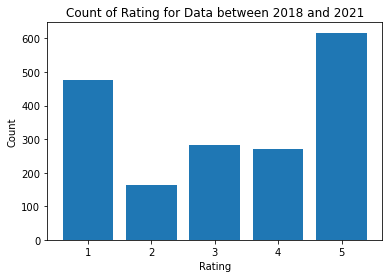

In [19]:
# Plot the count of different ratings for data between 2018 and 2021
youtube_ios_ph_review_score_count = youtube_ios_ph_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(youtube_ios_ph_review_score_count.index,youtube_ios_ph_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

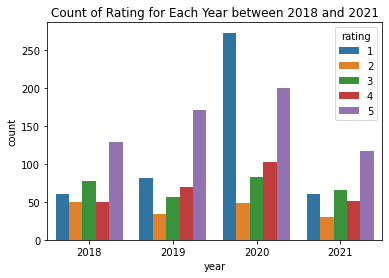

In [20]:
# Plot the count of different ratings for each year
youtube_ios_ph_review_score_count_ByYear = (youtube_ios_ph_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=youtube_ios_ph_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [21]:
# Understand average ratings over year
youtube_ios_ph_review_avg_score_ByYear = (youtube_ios_ph_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

youtube_ios_ph_review_avg_score_ByYear['count'] = youtube_ios_ph_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
youtube_ios_ph_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2018  3.370572    367
2019  3.512077    413
2020  2.871287    707
2021  3.410494    323

# Dataframe Preparation for Topic Modelling

In [22]:
# Dataframe with data between 2018 and 2021 without score or year filtering
youtube_ios_ph_review_YearMonth.head()

date  rating  isEdited                             title  \
68 2018-01-03       3     False                    Offline videos   
69 2018-01-04       5     False                           Love it   
70 2018-01-06       1     False                          Annoying   
71 2018-01-12       1     False               Auto Speed/Slow app   
72 2018-01-15       1     False  Crashing after updated to latest   

                                                                                                                                                                                                     review  \
68                                                                          I cant download videos for offline viewing anymore, is it not available anymore? I don’t think there was an update removing it?   
69                                                                                                        Its wonderful i use this app every day and its very useful news,entertainment,guide and many more   
70  The thumbnails/links that shows a few seconds before the video ends are annoying. Also the suggestions on the upper right. Whoever thought of these features are such idiots by adding distractions ...   
71                             I will rate this app to 5 star again, if the auto slow/speed buffering is fix, very annoying and strange when watching, gives you scarring deep or dwarf high pitch voices 😕   
72                                                                                     The app crashes when playing a video! I tried re installing the app still it crash when i play a video stupid update   

             userName  year  month  
68  Key is Patience??  2018      1  
69         JLEmmanuel  2018      1  
70      Redituserjdkx  2018      1  
71       HondaMapUser  2018      1  
72            Cjsales  2018      1

In [23]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
youtube_ios_ph_review_YearMonth_score1 = youtube_ios_ph_review_YearMonth[youtube_ios_ph_review_YearMonth['rating']==1]
youtube_ios_ph_review_YearMonth_score2 = youtube_ios_ph_review_YearMonth[youtube_ios_ph_review_YearMonth['rating']==2]
youtube_ios_ph_review_YearMonth_score3 = youtube_ios_ph_review_YearMonth[youtube_ios_ph_review_YearMonth['rating']==3]
youtube_ios_ph_review_YearMonth_score4 = youtube_ios_ph_review_YearMonth[youtube_ios_ph_review_YearMonth['rating']==4]
youtube_ios_ph_review_YearMonth_score5 = youtube_ios_ph_review_YearMonth[youtube_ios_ph_review_YearMonth['rating']==5]


In [24]:
# Prepare dataframe for grouped score
youtube_ios_ph_review_YearMonth_score1N2N3 = youtube_ios_ph_review_YearMonth[youtube_ios_ph_review_YearMonth['rating'].isin([1,2,3])]
youtube_ios_ph_review_YearMonth_score4N5 = youtube_ios_ph_review_YearMonth[youtube_ios_ph_review_YearMonth['rating'].isin([4,5])]


In [25]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
youtube_ios_ph_review_YearMonth_2018_score1N2N3 = youtube_ios_ph_review_YearMonth[(youtube_ios_ph_review_YearMonth['year']==2018)&(youtube_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
youtube_ios_ph_review_YearMonth_2019_score1N2N3 = youtube_ios_ph_review_YearMonth[(youtube_ios_ph_review_YearMonth['year']==2019)&(youtube_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
youtube_ios_ph_review_YearMonth_2020_score1N2N3 = youtube_ios_ph_review_YearMonth[(youtube_ios_ph_review_YearMonth['year']==2020)&(youtube_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
youtube_ios_ph_review_YearMonth_2021_score1N2N3 = youtube_ios_ph_review_YearMonth[(youtube_ios_ph_review_YearMonth['year']==2021)&(youtube_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [26]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_ph = youtube_ios_ph_review_YearMonth.review.values.tolist()
review_words_ph = list(sent_to_words(review_ph))
print(review_words_ph[:1])

[['cant', 'download', 'videos', 'for', 'offline', 'viewing', 'anymore', 'is', 'it', 'not', 'available', 'anymore', 'don', 'think', 'there', 'was', 'an', 'update', 'removing', 'it']]


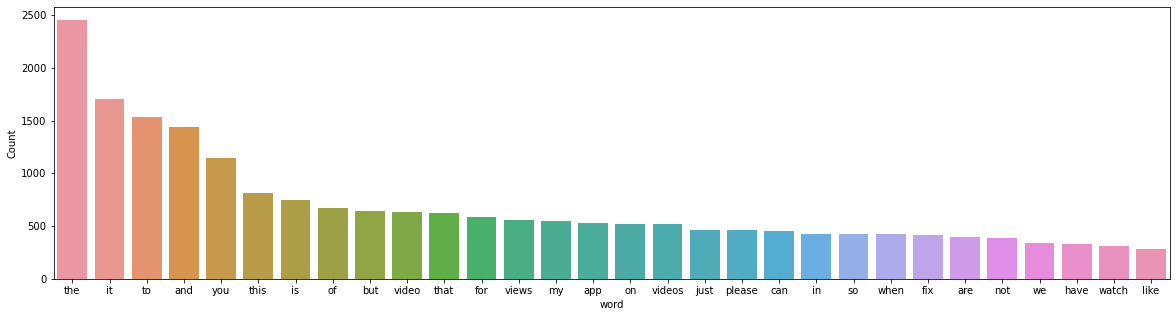

In [27]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph))

In [28]:
# Clean text
review_ph_ready = process_words(review_words_ph)  # processed Text Data! - move to each section

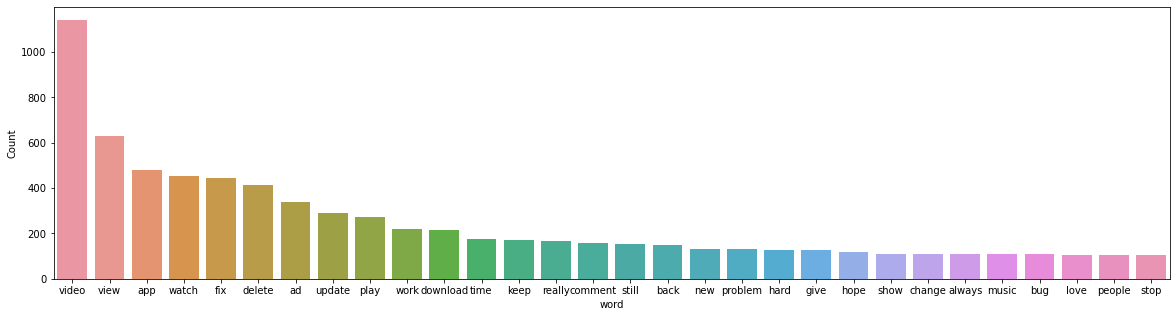

In [29]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready))

In [30]:
# Create Dictionary
id2word_ph = corpora.Dictionary(review_ph_ready)

2021-10-16 23:31:55,945 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:31:56,271 [INFO] gensim.corpora.dictionary - built Dictionary(2626 unique tokens: ['anymore', 'available', 'download', 'offline', 'remove']...) from 1812 documents (total 21852 corpus positions)
2021-10-16 23:31:56,315 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2626 unique tokens: ['anymore', 'available', 'download', 'offline', 'remove']...) from 1812 documents (total 21852 corpus positions)", 'datetime': '2021-10-16T23:31:56.274039', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [31]:
# Create Corpus: Term Document Frequency
corpus_ph = [id2word_ph.doc2bow(text) for text in review_ph_ready]

In [32]:
# Training LDA model
model_list_ph, coherence_values_ph = compute_coherence_values(dictionary=id2word_ph, corpus=corpus_ph, 
                                                              texts=review_ph_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-16 23:31:56,542 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:31:56,545 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:31:56,552 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:31:56,557 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1812 documents, updating model once every 1000 documents, evaluating perplexity every 1812 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:31:56,559 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1812
2021-10-16 23:32:01,746 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:32:01,752 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"video" + 0.039*"view" + 0.029*"delete" + 0.023*"app" + 0.020*"ad" + 0.018*"watch" + 0.016*"play" + 0.014*"update" + 0.011*"fix" + 0.01

2021-10-16 23:32:27,925 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1812/1812
2021-10-16 23:32:29,121 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:32:29,124 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"view" + 0.035*"delete" + 0.023*"video" + 0.022*"ad" + 0.015*"app" + 0.014*"work" + 0.011*"hard" + 0.010*"give" + 0.009*"stop" + 0.009*"people"
2021-10-16 23:32:29,133 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.064*"video" + 0.029*"fix" + 0.028*"watch" + 0.024*"app" + 0.016*"update" + 0.015*"download" + 0.015*"play" + 0.012*"comment" + 0.008*"bug" + 0.008*"problem"
2021-10-16 23:32:29,138 [INFO] gensim.models.ldamodel - topic diff=0.232499, rho=0.383145
2021-10-16 23:32:29,141 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1812
2021-10-16 23:32:30,381 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:

2021-10-16 23:32:45,024 [INFO] gensim.models.ldamodel - topic diff=0.166395, rho=0.290963
2021-10-16 23:32:46,306 [INFO] gensim.models.ldamodel - -6.528 per-word bound, 92.3 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:32:46,315 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1812/1812
2021-10-16 23:32:47,160 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:32:47,163 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.059*"view" + 0.039*"delete" + 0.019*"video" + 0.019*"ad" + 0.014*"work" + 0.012*"hard" + 0.012*"give" + 0.011*"app" + 0.010*"stop" + 0.010*"music"
2021-10-16 23:32:47,168 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.064*"video" + 0.029*"fix" + 0.028*"watch" + 0.026*"app" + 0.019*"update" + 0.016*"play" + 0.015*"download" + 0.011*"comment" + 0.010*"ad" + 0.008*"still"
2021-10-16 23:32:47,171 [INFO] gensim.models.ldamodel - topic diff=0.16099

2021-10-16 23:33:01,966 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"video" + 0.030*"fix" + 0.028*"watch" + 0.026*"app" + 0.020*"update" + 0.019*"play" + 0.015*"download" + 0.013*"ad" + 0.010*"comment" + 0.008*"still"
2021-10-16 23:33:01,973 [INFO] gensim.models.ldamodel - topic diff=0.132887, rho=0.243888
2021-10-16 23:33:03,181 [INFO] gensim.models.ldamodel - -6.518 per-word bound, 91.6 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:33:03,183 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1812/1812
2021-10-16 23:33:04,066 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:33:04,069 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.061*"view" + 0.041*"delete" + 0.018*"video" + 0.016*"ad" + 0.014*"work" + 0.013*"hard" + 0.012*"give" + 0.011*"music" + 0.010*"stop" + 0.010*"people"
2021-10-16 23:33:04,073 [INFO] gensim.models.ldamodel - topic #1 (0.50

2021-10-16 23:33:18,339 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.065*"view" + 0.043*"delete" + 0.017*"video" + 0.014*"ad" + 0.014*"work" + 0.013*"hard" + 0.013*"give" + 0.011*"music" + 0.010*"people" + 0.010*"stop"
2021-10-16 23:33:18,342 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"video" + 0.029*"fix" + 0.028*"watch" + 0.027*"app" + 0.020*"update" + 0.019*"play" + 0.015*"download" + 0.014*"ad" + 0.010*"comment" + 0.008*"still"
2021-10-16 23:33:18,345 [INFO] gensim.models.ldamodel - topic diff=0.113285, rho=0.214118
2021-10-16 23:33:19,528 [INFO] gensim.models.ldamodel - -6.513 per-word bound, 91.3 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:33:19,531 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1812/1812
2021-10-16 23:33:20,376 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:33:20,379 [INFO] gensim.models.ldamodel - topic #0 (0.50

2021-10-16 23:33:35,733 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1812
2021-10-16 23:33:36,992 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:33:36,997 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.066*"view" + 0.043*"delete" + 0.017*"video" + 0.014*"work" + 0.013*"hard" + 0.013*"give" + 0.012*"ad" + 0.011*"music" + 0.011*"people" + 0.010*"stop"
2021-10-16 23:33:36,999 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"video" + 0.029*"fix" + 0.027*"watch" + 0.027*"app" + 0.020*"update" + 0.018*"play" + 0.015*"ad" + 0.015*"download" + 0.010*"comment" + 0.008*"still"
2021-10-16 23:33:37,001 [INFO] gensim.models.ldamodel - topic diff=0.100334, rho=0.193124
2021-10-16 23:33:38,477 [INFO] gensim.models.ldamodel - -6.509 per-word bound, 91.1 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:33:38,488 [INFO] gensim.models.ldamodel - PROGRESS: pas

2021-10-16 23:33:53,539 [INFO] gensim.models.ldamodel - topic diff=0.091847, rho=0.180152
2021-10-16 23:33:53,541 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1812
2021-10-16 23:33:54,639 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:33:54,643 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.066*"view" + 0.044*"delete" + 0.016*"video" + 0.014*"work" + 0.014*"hard" + 0.013*"give" + 0.012*"music" + 0.011*"people" + 0.010*"stop" + 0.010*"much"
2021-10-16 23:33:54,645 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"video" + 0.029*"fix" + 0.027*"watch" + 0.027*"app" + 0.019*"update" + 0.018*"play" + 0.016*"ad" + 0.014*"download" + 0.010*"comment" + 0.008*"still"
2021-10-16 23:33:54,646 [INFO] gensim.models.ldamodel - topic diff=0.090666, rho=0.177298
2021-10-16 23:33:55,898 [INFO] gensim.models.ldamodel - -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 812 doc

2021-10-16 23:34:09,406 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.064*"video" + 0.029*"fix" + 0.027*"watch" + 0.027*"app" + 0.019*"update" + 0.017*"ad" + 0.017*"play" + 0.015*"download" + 0.011*"comment" + 0.008*"still"
2021-10-16 23:34:09,408 [INFO] gensim.models.ldamodel - topic diff=0.084637, rho=0.167104
2021-10-16 23:34:09,409 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1812
2021-10-16 23:34:10,279 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:34:10,282 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"view" + 0.044*"delete" + 0.016*"video" + 0.014*"work" + 0.014*"hard" + 0.013*"give" + 0.012*"music" + 0.011*"people" + 0.010*"much" + 0.010*"stop"
2021-10-16 23:34:10,284 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"video" + 0.029*"fix" + 0.027*"watch" + 0.027*"app" + 0.019*"update" + 0.018*"play" + 0.018*"ad" + 0.014*"download" + 0.010*"comment" + 0.008*"still"
2

2021-10-16 23:34:26,460 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.066*"view" + 0.044*"delete" + 0.016*"video" + 0.014*"work" + 0.014*"hard" + 0.013*"give" + 0.012*"music" + 0.011*"people" + 0.011*"much" + 0.010*"stop"
2021-10-16 23:34:26,464 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.064*"video" + 0.029*"fix" + 0.027*"app" + 0.027*"watch" + 0.019*"update" + 0.018*"ad" + 0.017*"play" + 0.014*"download" + 0.010*"comment" + 0.008*"still"
2021-10-16 23:34:26,470 [INFO] gensim.models.ldamodel - topic diff=0.078509, rho=0.156533
2021-10-16 23:34:26,471 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/1812
2021-10-16 23:34:27,756 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:34:27,759 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.068*"view" + 0.045*"delete" + 0.016*"video" + 0.014*"work" + 0.014*"hard" + 0.013*"give" + 0.012*"music" + 0.011*"people" + 0.010*"much" + 0.010*"stop"
202

2021-10-16 23:34:41,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1812/1812
2021-10-16 23:34:42,204 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:34:42,208 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.066*"view" + 0.044*"delete" + 0.016*"video" + 0.014*"work" + 0.014*"hard" + 0.013*"give" + 0.012*"music" + 0.012*"people" + 0.011*"much" + 0.010*"stop"
2021-10-16 23:34:42,212 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.064*"video" + 0.028*"fix" + 0.026*"app" + 0.026*"watch" + 0.019*"ad" + 0.019*"update" + 0.017*"play" + 0.014*"download" + 0.010*"comment" + 0.008*"still"
2021-10-16 23:34:42,225 [INFO] gensim.models.ldamodel - topic diff=0.073692, rho=0.147744
2021-10-16 23:34:42,234 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1000/1812
2021-10-16 23:34:43,167 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 

2021-10-16 23:34:56,141 [INFO] gensim.models.ldamodel - topic diff=0.069839, rho=0.140287
2021-10-16 23:34:57,751 [INFO] gensim.models.ldamodel - -6.497 per-word bound, 90.3 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:34:57,756 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1812/1812
2021-10-16 23:34:58,772 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:34:58,775 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"view" + 0.044*"delete" + 0.016*"video" + 0.014*"work" + 0.014*"hard" + 0.013*"give" + 0.012*"music" + 0.012*"people" + 0.011*"much" + 0.010*"stop"
2021-10-16 23:34:58,776 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.064*"video" + 0.028*"fix" + 0.026*"app" + 0.026*"watch" + 0.020*"ad" + 0.019*"update" + 0.017*"play" + 0.014*"download" + 0.010*"comment" + 0.008*"still"
2021-10-16 23:34:58,778 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 23:35:16,416 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.106*"view" + 0.065*"delete" + 0.032*"video" + 0.020*"hard" + 0.019*"work" + 0.015*"stream" + 0.012*"music" + 0.012*"people" + 0.011*"give" + 0.010*"stop"
2021-10-16 23:35:16,417 [INFO] gensim.models.ldamodel - topic diff=0.390088, rho=0.512181
2021-10-16 23:35:17,944 [INFO] gensim.models.ldamodel - -7.016 per-word bound, 129.5 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:35:17,951 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1812/1812
2021-10-16 23:35:19,058 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:35:19,083 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.065*"video" + 0.049*"app" + 0.039*"watch" + 0.028*"fix" + 0.023*"update" + 0.017*"still" + 0.013*"search" + 0.012*"work" + 0.010*"crash" + 0.009*"phone"
2021-10-16 23:35:19,089 [INFO] gensim.models.ldamodel - topic #6 (0

2021-10-16 23:35:27,664 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:35:27,674 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"ad" + 0.027*"change" + 0.018*"quality" + 0.017*"profile" + 0.017*"premium" + 0.016*"remove" + 0.016*"video" + 0.013*"new" + 0.013*"picture" + 0.013*"account"
2021-10-16 23:35:27,676 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.115*"view" + 0.072*"delete" + 0.021*"video" + 0.021*"hard" + 0.020*"work" + 0.017*"stream" + 0.014*"give" + 0.014*"music" + 0.013*"people" + 0.013*"bring"
2021-10-16 23:35:27,682 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.091*"video" + 0.066*"ad" + 0.049*"play" + 0.037*"watch" + 0.022*"fix" + 0.015*"screen" + 0.014*"app" + 0.012*"bug" + 0.010*"audio" + 0.010*"time"
2021-10-16 23:35:27,684 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.074*"video" + 0.039*"download" + 0.027*"fix" + 0.021*"upload" + 0.017*"app" + 0.014*"problem" + 0.013*"play" 

2021-10-16 23:35:38,591 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.079*"video" + 0.046*"download" + 0.025*"fix" + 0.024*"upload" + 0.015*"app" + 0.013*"problem" + 0.013*"time" + 0.013*"offline" + 0.012*"still" + 0.012*"play"
2021-10-16 23:35:38,593 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.054*"comment" + 0.021*"watch" + 0.019*"video" + 0.017*"section" + 0.017*"thing" + 0.015*"love" + 0.013*"caption" + 0.013*"fix" + 0.013*"download" + 0.011*"really"
2021-10-16 23:35:38,596 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.092*"video" + 0.069*"ad" + 0.043*"play" + 0.038*"watch" + 0.021*"fix" + 0.015*"screen" + 0.013*"app" + 0.011*"bug" + 0.010*"recommend" + 0.010*"annoying"
2021-10-16 23:35:38,598 [INFO] gensim.models.ldamodel - topic diff=0.132683, rho=0.336870
2021-10-16 23:35:38,601 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #1000/1812
2021-10-16 23:35:39,768 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 18

2021-10-16 23:35:46,579 [INFO] gensim.models.ldamodel - topic diff=0.108581, rho=0.290963
2021-10-16 23:35:48,045 [INFO] gensim.models.ldamodel - -6.719 per-word bound, 105.4 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:35:48,047 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1812/1812
2021-10-16 23:35:49,011 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:35:49,016 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.113*"view" + 0.073*"delete" + 0.022*"work" + 0.021*"hard" + 0.020*"video" + 0.016*"stream" + 0.015*"music" + 0.015*"give" + 0.014*"people" + 0.013*"bring"
2021-10-16 23:35:49,018 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.082*"video" + 0.049*"download" + 0.026*"fix" + 0.026*"upload" + 0.015*"app" + 0.015*"offline" + 0.013*"problem" + 0.013*"time" + 0.013*"still" + 0.012*"play"
2021-10-16 23:35:49,021 [INFO] gensim.models.ldamodel - topic

2021-10-16 23:35:57,290 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"comment" + 0.022*"watch" + 0.018*"section" + 0.016*"video" + 0.016*"thing" + 0.016*"love" + 0.015*"caption" + 0.012*"really" + 0.011*"put" + 0.011*"fix"
2021-10-16 23:35:57,292 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"new" + 0.023*"update" + 0.018*"app" + 0.014*"keep" + 0.013*"add" + 0.013*"ipad" + 0.013*"post" + 0.012*"feature" + 0.012*"fix" + 0.012*"change"
2021-10-16 23:35:57,294 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.115*"view" + 0.074*"delete" + 0.021*"work" + 0.020*"hard" + 0.019*"video" + 0.016*"stream" + 0.015*"give" + 0.014*"music" + 0.013*"people" + 0.013*"bring"
2021-10-16 23:35:57,297 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.066*"video" + 0.056*"app" + 0.038*"fix" + 0.033*"watch" + 0.032*"update" + 0.016*"crash" + 0.016*"still" + 0.013*"search" + 0.013*"work" + 0.013*"open"
2021-10-16 23:35:57,298 [INFO] gensim.models.ldamodel - topic diff=0.092502, rho=0

2021-10-16 23:36:07,804 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.061*"comment" + 0.022*"watch" + 0.018*"section" + 0.017*"thing" + 0.016*"caption" + 0.016*"video" + 0.015*"love" + 0.012*"put" + 0.011*"really" + 0.011*"great"
2021-10-16 23:36:07,807 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.035*"change" + 0.027*"quality" + 0.025*"picture" + 0.021*"premium" + 0.017*"ad" + 0.017*"profile" + 0.016*"channel" + 0.016*"account" + 0.016*"new" + 0.016*"remove"
2021-10-16 23:36:07,809 [INFO] gensim.models.ldamodel - topic diff=0.081727, rho=0.243888
2021-10-16 23:36:07,812 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1000/1812
2021-10-16 23:36:08,924 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:36:08,928 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.095*"video" + 0.079*"ad" + 0.047*"play" + 0.042*"watch" + 0.023*"fix" + 0.019*"screen" + 0.011*"bug" + 0.011*"annoying" + 0.010*"audio" 

2021-10-16 23:36:16,502 [INFO] gensim.models.ldamodel - -6.694 per-word bound, 103.6 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:36:16,503 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1812/1812
2021-10-16 23:36:17,371 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:36:17,375 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.094*"video" + 0.079*"ad" + 0.043*"play" + 0.042*"watch" + 0.022*"fix" + 0.019*"screen" + 0.012*"annoying" + 0.011*"bug" + 0.010*"app" + 0.010*"time"
2021-10-16 23:36:17,378 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"new" + 0.022*"update" + 0.018*"app" + 0.015*"post" + 0.014*"ipad" + 0.014*"change" + 0.013*"add" + 0.013*"community" + 0.013*"feature" + 0.012*"keep"
2021-10-16 23:36:17,380 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.113*"view" + 0.074*"delete" + 0.023*"work" + 0.021*"hard" + 0.019*"video" + 0.016*"

2021-10-16 23:36:25,940 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.096*"video" + 0.081*"ad" + 0.046*"play" + 0.043*"watch" + 0.023*"fix" + 0.019*"screen" + 0.012*"annoying" + 0.011*"bug" + 0.010*"audio" + 0.010*"time"
2021-10-16 23:36:25,946 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"new" + 0.023*"update" + 0.017*"app" + 0.014*"add" + 0.014*"feature" + 0.013*"change" + 0.013*"post" + 0.013*"ipad" + 0.013*"keep" + 0.011*"community"
2021-10-16 23:36:25,950 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.062*"comment" + 0.022*"watch" + 0.018*"section" + 0.017*"caption" + 0.016*"thing" + 0.016*"love" + 0.013*"video" + 0.012*"really" + 0.011*"put" + 0.011*"great"
2021-10-16 23:36:25,954 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.114*"view" + 0.074*"delete" + 0.022*"work" + 0.020*"hard" + 0.018*"video" + 0.016*"stream" + 0.016*"give" + 0.015*"music" + 0.013*"people" + 0.013*"bring"
2021-10-16 23:36:25,959 [INFO] gensim.models.ldamodel - topic diff=0.069060

2021-10-16 23:36:36,924 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.112*"view" + 0.074*"delete" + 0.023*"work" + 0.021*"hard" + 0.019*"video" + 0.016*"stream" + 0.016*"give" + 0.015*"music" + 0.014*"people" + 0.013*"back"
2021-10-16 23:36:36,931 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.063*"comment" + 0.022*"watch" + 0.019*"section" + 0.018*"caption" + 0.017*"thing" + 0.015*"love" + 0.013*"video" + 0.012*"really" + 0.011*"great" + 0.011*"put"
2021-10-16 23:36:36,939 [INFO] gensim.models.ldamodel - topic diff=0.064084, rho=0.200756
2021-10-16 23:36:36,945 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/1812
2021-10-16 23:36:38,594 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:36:38,655 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.063*"comment" + 0.022*"watch" + 0.018*"section" + 0.018*"caption" + 0.016*"thing" + 0.015*"love" + 0.012*"video" + 0.012*"really" + 0.011*"put" + 0

2021-10-16 23:36:49,179 [INFO] gensim.models.ldamodel - topic diff=0.061290, rho=0.189620
2021-10-16 23:36:50,406 [INFO] gensim.models.ldamodel - -6.684 per-word bound, 102.8 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:36:50,407 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1812/1812
2021-10-16 23:36:51,406 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:36:51,410 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.061*"video" + 0.057*"app" + 0.039*"fix" + 0.032*"update" + 0.032*"watch" + 0.017*"crash" + 0.015*"still" + 0.015*"search" + 0.014*"work" + 0.014*"open"
2021-10-16 23:36:51,412 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.096*"video" + 0.082*"ad" + 0.043*"watch" + 0.042*"play" + 0.022*"fix" + 0.019*"screen" + 0.013*"annoying" + 0.011*"bug" + 0.010*"time" + 0.010*"button"
2021-10-16 23:36:51,414 [INFO] gensim.models.ldamodel - topic #2 (0.1

2021-10-16 23:36:59,065 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.114*"view" + 0.075*"delete" + 0.022*"work" + 0.020*"hard" + 0.018*"video" + 0.016*"stream" + 0.016*"give" + 0.015*"music" + 0.013*"people" + 0.013*"back"
2021-10-16 23:36:59,067 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.093*"video" + 0.063*"download" + 0.027*"fix" + 0.026*"offline" + 0.026*"upload" + 0.014*"app" + 0.013*"problem" + 0.012*"still" + 0.012*"time" + 0.012*"play"
2021-10-16 23:36:59,071 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.040*"change" + 0.026*"quality" + 0.023*"picture" + 0.019*"premium" + 0.018*"channel" + 0.018*"profile" + 0.016*"update" + 0.016*"new" + 0.016*"account" + 0.014*"remove"
2021-10-16 23:36:59,074 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"new" + 0.023*"update" + 0.017*"app" + 0.014*"add" + 0.014*"change" + 0.014*"feature" + 0.014*"post" + 0.013*"ipad" + 0.012*"keep" + 0.012*"community"
2021-10-16 23:36:59,081 [INFO] gensim.models.ldamodel - topi

2021-10-16 23:37:09,407 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.039*"change" + 0.029*"quality" + 0.025*"picture" + 0.021*"premium" + 0.019*"channel" + 0.017*"profile" + 0.016*"account" + 0.016*"update" + 0.016*"new" + 0.013*"remove"
2021-10-16 23:37:09,417 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"video" + 0.057*"app" + 0.039*"fix" + 0.032*"update" + 0.032*"watch" + 0.018*"crash" + 0.015*"still" + 0.015*"search" + 0.014*"work" + 0.014*"open"
2021-10-16 23:37:09,419 [INFO] gensim.models.ldamodel - topic diff=0.054456, rho=0.174576
2021-10-16 23:37:09,422 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1000/1812
2021-10-16 23:37:10,597 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:37:10,604 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"change" + 0.027*"quality" + 0.023*"picture" + 0.019*"premium" + 0.018*"channel" + 0.018*"profile" + 0.016*"update" + 0.016*"new" + 0.01

2021-10-16 23:37:18,171 [INFO] gensim.models.ldamodel - topic diff=0.052534, rho=0.167104
2021-10-16 23:37:19,824 [INFO] gensim.models.ldamodel - -6.678 per-word bound, 102.4 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:37:19,828 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1812/1812
2021-10-16 23:37:20,957 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:37:20,969 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"new" + 0.022*"update" + 0.018*"app" + 0.015*"post" + 0.015*"change" + 0.014*"add" + 0.014*"ipad" + 0.014*"feature" + 0.013*"community" + 0.011*"keep"
2021-10-16 23:37:20,973 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"video" + 0.057*"app" + 0.039*"fix" + 0.032*"update" + 0.032*"watch" + 0.018*"crash" + 0.015*"still" + 0.015*"search" + 0.014*"work" + 0.014*"open"
2021-10-16 23:37:20,979 [INFO] gensim.models.ldamodel - topic #2 (

2021-10-16 23:37:31,771 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.098*"video" + 0.083*"ad" + 0.045*"play" + 0.043*"watch" + 0.023*"fix" + 0.020*"screen" + 0.013*"annoying" + 0.011*"bug" + 0.010*"time" + 0.010*"audio"
2021-10-16 23:37:31,776 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.113*"view" + 0.075*"delete" + 0.022*"work" + 0.020*"hard" + 0.019*"video" + 0.016*"stream" + 0.016*"give" + 0.015*"music" + 0.013*"people" + 0.013*"back"
2021-10-16 23:37:31,781 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"change" + 0.027*"quality" + 0.023*"picture" + 0.019*"premium" + 0.019*"channel" + 0.018*"profile" + 0.017*"update" + 0.016*"account" + 0.016*"new" + 0.013*"remove"
2021-10-16 23:37:31,784 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.061*"video" + 0.057*"app" + 0.039*"fix" + 0.033*"update" + 0.032*"watch" + 0.018*"crash" + 0.015*"still" + 0.015*"open" + 0.015*"work" + 0.014*"search"
2021-10-16 23:37:31,792 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 23:37:41,800 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.097*"video" + 0.083*"ad" + 0.043*"watch" + 0.042*"play" + 0.022*"fix" + 0.019*"screen" + 0.013*"annoying" + 0.011*"bug" + 0.010*"time" + 0.010*"button"
2021-10-16 23:37:41,801 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.095*"video" + 0.068*"download" + 0.028*"fix" + 0.026*"upload" + 0.025*"offline" + 0.014*"app" + 0.013*"still" + 0.013*"problem" + 0.012*"time" + 0.011*"play"
2021-10-16 23:37:41,802 [INFO] gensim.models.ldamodel - topic diff=0.048105, rho=0.156533
2021-10-16 23:37:41,803 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/1812
2021-10-16 23:37:42,806 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:37:42,809 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.064*"comment" + 0.022*"watch" + 0.019*"section" + 0.018*"caption" + 0.016*"love" + 0.015*"thing" + 0.012*"really" + 0.011*"great" + 0.011*"put" + 0.010

2021-10-16 23:37:50,711 [INFO] gensim.models.ldamodel - -6.674 per-word bound, 102.1 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:37:50,780 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #1812/1812
2021-10-16 23:37:51,640 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:37:51,649 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.096*"video" + 0.068*"download" + 0.028*"fix" + 0.026*"upload" + 0.025*"offline" + 0.014*"app" + 0.013*"still" + 0.013*"problem" + 0.012*"time" + 0.011*"play"
2021-10-16 23:37:51,651 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"change" + 0.030*"quality" + 0.025*"picture" + 0.021*"premium" + 0.019*"channel" + 0.018*"profile" + 0.017*"account" + 0.016*"update" + 0.016*"new" + 0.012*"remove"
2021-10-16 23:37:51,656 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"video" + 0.057*"app" + 0.039*"fix" + 0.033*"update" + 0

2021-10-16 23:37:59,185 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.061*"video" + 0.057*"app" + 0.039*"fix" + 0.033*"update" + 0.032*"watch" + 0.018*"crash" + 0.015*"still" + 0.015*"open" + 0.015*"search" + 0.014*"work"
2021-10-16 23:37:59,188 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"change" + 0.028*"quality" + 0.024*"picture" + 0.020*"premium" + 0.019*"channel" + 0.018*"profile" + 0.017*"update" + 0.016*"account" + 0.016*"new" + 0.012*"remove"
2021-10-16 23:37:59,190 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.113*"view" + 0.075*"delete" + 0.022*"work" + 0.021*"hard" + 0.019*"video" + 0.016*"stream" + 0.016*"give" + 0.015*"music" + 0.013*"people" + 0.013*"back"
2021-10-16 23:37:59,191 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.064*"comment" + 0.022*"watch" + 0.019*"section" + 0.018*"caption" + 0.016*"love" + 0.015*"thing" + 0.012*"really" + 0.011*"great" + 0.011*"put" + 0.010*"tube"
2021-10-16 23:37:59,192 [INFO] gensim.models.ldamodel - topic 

2021-10-16 23:38:10,929 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"new" + 0.023*"update" + 0.018*"app" + 0.015*"change" + 0.015*"post" + 0.015*"add" + 0.014*"ipad" + 0.014*"feature" + 0.013*"community" + 0.011*"keep"
2021-10-16 23:38:10,931 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"video" + 0.057*"app" + 0.039*"fix" + 0.033*"update" + 0.032*"watch" + 0.018*"crash" + 0.015*"still" + 0.015*"search" + 0.014*"work" + 0.014*"open"
2021-10-16 23:38:10,933 [INFO] gensim.models.ldamodel - topic diff=0.043563, rho=0.143132
2021-10-16 23:38:10,936 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1000/1812
2021-10-16 23:38:12,460 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:38:12,533 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.032*"new" + 0.023*"update" + 0.018*"app" + 0.015*"add" + 0.015*"change" + 0.014*"feature" + 0.014*"post" + 0.013*"ipad" + 0.012*"community" + 0.012*"keep"

2021-10-16 23:38:28,486 [INFO] gensim.models.ldamodel - -6.672 per-word bound, 101.9 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:38:28,497 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1812/1812
2021-10-16 23:38:29,756 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:38:29,761 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.064*"comment" + 0.022*"watch" + 0.019*"section" + 0.018*"caption" + 0.016*"thing" + 0.015*"love" + 0.012*"really" + 0.011*"great" + 0.011*"put" + 0.010*"tube"
2021-10-16 23:38:29,763 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"video" + 0.057*"app" + 0.039*"fix" + 0.033*"update" + 0.032*"watch" + 0.018*"crash" + 0.015*"still" + 0.015*"search" + 0.015*"work" + 0.014*"open"
2021-10-16 23:38:29,765 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"new" + 0.023*"update" + 0.018*"app" + 0.016*"change" + 0.015*"post" + 0

2021-10-16 23:38:52,724 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.083*"video" + 0.054*"app" + 0.041*"watch" + 0.032*"fix" + 0.026*"still" + 0.019*"update" + 0.017*"work" + 0.010*"open" + 0.010*"search" + 0.010*"upload"
2021-10-16 23:38:52,727 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.045*"video" + 0.041*"app" + 0.026*"play" + 0.025*"watch" + 0.021*"update" + 0.020*"fix" + 0.019*"love" + 0.018*"button" + 0.012*"yt" + 0.012*"help"
2021-10-16 23:38:52,729 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"video" + 0.049*"download" + 0.047*"quality" + 0.046*"ad" + 0.020*"premium" + 0.019*"much" + 0.018*"remove" + 0.018*"add" + 0.017*"picture" + 0.017*"new"
2021-10-16 23:38:52,732 [INFO] gensim.models.ldamodel - topic diff=0.309411, rho=0.512181
2021-10-16 23:38:52,734 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1000/1812
2021-10-16 23:38:54,963 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
20

2021-10-16 23:39:06,195 [INFO] gensim.models.ldamodel - topic diff=0.169301, rho=0.383145
2021-10-16 23:39:07,801 [INFO] gensim.models.ldamodel - -7.282 per-word bound, 155.7 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:39:07,803 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1812/1812
2021-10-16 23:39:09,316 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:39:09,325 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.053*"update" + 0.033*"app" + 0.027*"new" + 0.026*"thing" + 0.024*"crash" + 0.022*"fix" + 0.020*"keep" + 0.019*"ad" + 0.019*"version" + 0.019*"video"
2021-10-16 23:39:09,356 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.107*"ad" + 0.098*"video" + 0.060*"play" + 0.041*"watch" + 0.015*"fix" + 0.013*"app" + 0.013*"annoying" + 0.013*"always" + 0.012*"really" + 0.011*"well"
2021-10-16 23:39:09,359 [INFO] gensim.models.ldamodel - topic #5 (0.083):

2021-10-16 23:39:20,088 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.048*"app" + 0.026*"video" + 0.026*"love" + 0.019*"update" + 0.016*"button" + 0.015*"yt" + 0.015*"watch" + 0.014*"help" + 0.014*"fix" + 0.011*"play"
2021-10-16 23:39:20,097 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.052*"video" + 0.030*"fix" + 0.019*"upload" + 0.016*"show" + 0.013*"freeze" + 0.012*"thumbnail" + 0.011*"add" + 0.011*"keep" + 0.011*"play" + 0.011*"problem"
2021-10-16 23:39:20,106 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.098*"video" + 0.058*"app" + 0.043*"watch" + 0.042*"fix" + 0.026*"still" + 0.017*"update" + 0.017*"work" + 0.014*"play" + 0.013*"problem" + 0.013*"upload"
2021-10-16 23:39:20,150 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.079*"download" + 0.050*"video" + 0.036*"offline" + 0.032*"internet" + 0.027*"watch" + 0.021*"connection" + 0.017*"fast" + 0.016*"fix" + 0.016*"load" + 0.014*"time"
2021-10-16 23:39:20,153 [INFO] gensim.models.ldamodel - topic diff=0.105

2021-10-16 23:39:30,310 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.074*"comment" + 0.030*"change" + 0.027*"channel" + 0.025*"section" + 0.023*"profile" + 0.020*"fix" + 0.020*"account" + 0.018*"way" + 0.017*"put" + 0.017*"let"
2021-10-16 23:39:30,311 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.121*"ad" + 0.110*"video" + 0.069*"play" + 0.046*"watch" + 0.018*"fix" + 0.015*"annoying" + 0.014*"always" + 0.013*"really" + 0.011*"app" + 0.009*"skip"
2021-10-16 23:39:30,312 [INFO] gensim.models.ldamodel - topic diff=0.082877, rho=0.290963
2021-10-16 23:39:30,314 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1000/1812
2021-10-16 23:39:31,579 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:39:31,584 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.045*"quality" + 0.027*"add" + 0.027*"picture" + 0.026*"ad" + 0.026*"feature" + 0.024*"video" + 0.024*"premium" + 0.020*"remove" + 0.019*"download" + 0

2021-10-16 23:39:42,266 [INFO] gensim.models.ldamodel - -6.861 per-word bound, 116.2 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:39:42,270 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1812/1812
2021-10-16 23:39:43,364 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:39:43,388 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"video" + 0.031*"fix" + 0.017*"upload" + 0.017*"show" + 0.014*"thumbnail" + 0.014*"edit" + 0.012*"already" + 0.012*"different" + 0.011*"number" + 0.011*"keep"
2021-10-16 23:39:43,392 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.051*"app" + 0.028*"love" + 0.019*"button" + 0.018*"yt" + 0.018*"update" + 0.015*"video" + 0.014*"help" + 0.013*"watch" + 0.011*"computer" + 0.010*"ever"
2021-10-16 23:39:43,395 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.099*"video" + 0.060*"app" + 0.046*"watch" + 0.044*"fix" + 0.026*"still

2021-10-16 23:39:52,602 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"quality" + 0.030*"add" + 0.030*"feature" + 0.029*"picture" + 0.025*"premium" + 0.020*"remove" + 0.019*"video" + 0.018*"pay" + 0.017*"much" + 0.017*"new"
2021-10-16 23:39:52,605 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.080*"update" + 0.043*"app" + 0.030*"new" + 0.024*"crash" + 0.024*"version" + 0.023*"fix" + 0.022*"thing" + 0.022*"keep" + 0.017*"late" + 0.014*"io"
2021-10-16 23:39:52,614 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.129*"ad" + 0.113*"video" + 0.077*"play" + 0.047*"watch" + 0.021*"fix" + 0.014*"annoying" + 0.014*"always" + 0.013*"really" + 0.010*"skip" + 0.010*"app"
2021-10-16 23:39:52,618 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.137*"view" + 0.088*"delete" + 0.025*"work" + 0.025*"hard" + 0.020*"stream" + 0.017*"video" + 0.017*"music" + 0.017*"people" + 0.016*"give" + 0.015*"bring"
2021-10-16 23:39:52,619 [INFO] gensim.models.ldamodel - topic diff=0.059853, rho=0.

2021-10-16 23:40:02,979 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.134*"view" + 0.087*"delete" + 0.026*"work" + 0.026*"hard" + 0.019*"stream" + 0.018*"video" + 0.018*"music" + 0.017*"people" + 0.016*"give" + 0.015*"stop"
2021-10-16 23:40:02,984 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.073*"comment" + 0.034*"change" + 0.028*"channel" + 0.025*"section" + 0.023*"profile" + 0.022*"account" + 0.021*"fix" + 0.020*"let" + 0.018*"way" + 0.016*"put"
2021-10-16 23:40:02,990 [INFO] gensim.models.ldamodel - topic diff=0.053767, rho=0.224665
2021-10-16 23:40:02,996 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1000/1812
2021-10-16 23:40:04,397 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:40:04,411 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.054*"app" + 0.028*"love" + 0.020*"yt" + 0.017*"button" + 0.017*"update" + 0.014*"help" + 0.012*"watch" + 0.011*"online" + 0.011*"video" + 0.010*"ev

2021-10-16 23:40:14,005 [INFO] gensim.models.ldamodel - -6.814 per-word bound, 112.5 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:40:14,058 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1812/1812
2021-10-16 23:40:14,869 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:40:14,876 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.134*"view" + 0.087*"delete" + 0.026*"work" + 0.026*"hard" + 0.019*"stream" + 0.018*"video" + 0.017*"music" + 0.017*"people" + 0.016*"give" + 0.014*"stop"
2021-10-16 23:40:14,881 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.055*"app" + 0.029*"love" + 0.020*"yt" + 0.019*"button" + 0.017*"update" + 0.014*"help" + 0.011*"computer" + 0.011*"watch" + 0.010*"online" + 0.010*"ever"
2021-10-16 23:40:14,884 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.133*"ad" + 0.113*"video" + 0.071*"play" + 0.046*"watch" + 0.020*"fix" + 0.016*

2021-10-16 23:40:22,975 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.087*"update" + 0.046*"app" + 0.033*"new" + 0.026*"version" + 0.022*"thing" + 0.021*"fix" + 0.021*"keep" + 0.018*"crash" + 0.017*"late" + 0.016*"io"
2021-10-16 23:40:22,978 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.048*"quality" + 0.032*"add" + 0.031*"feature" + 0.030*"picture" + 0.026*"premium" + 0.020*"remove" + 0.018*"pay" + 0.017*"well" + 0.017*"new" + 0.017*"much"
2021-10-16 23:40:22,982 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.103*"download" + 0.079*"video" + 0.049*"offline" + 0.034*"internet" + 0.032*"watch" + 0.021*"connection" + 0.020*"fix" + 0.017*"fast" + 0.017*"load" + 0.013*"play"
2021-10-16 23:40:22,989 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.030*"give" + 0.018*"star" + 0.018*"watch" + 0.017*"hate" + 0.015*"let" + 0.015*"time" + 0.014*"literally" + 0.013*"content" + 0.012*"vid" + 0.011*"reason"
2021-10-16 23:40:22,991 [INFO] gensim.models.ldamodel - topic diff=0.04

2021-10-16 23:40:31,039 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.133*"ad" + 0.114*"video" + 0.070*"play" + 0.047*"watch" + 0.020*"fix" + 0.016*"annoying" + 0.014*"really" + 0.012*"always" + 0.010*"skip" + 0.010*"app"
2021-10-16 23:40:31,061 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.134*"view" + 0.087*"delete" + 0.026*"work" + 0.025*"hard" + 0.019*"stream" + 0.019*"video" + 0.018*"people" + 0.017*"music" + 0.016*"give" + 0.014*"stop"
2021-10-16 23:40:31,066 [INFO] gensim.models.ldamodel - topic diff=0.042529, rho=0.189620
2021-10-16 23:40:31,068 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1000/1812
2021-10-16 23:40:31,960 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:40:32,067 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.057*"app" + 0.030*"love" + 0.020*"yt" + 0.018*"button" + 0.016*"update" + 0.014*"help" + 0.011*"online" + 0.010*"ever" + 0.010*"watch" + 0.010*"phone"
202

2021-10-16 23:40:40,110 [INFO] gensim.models.ldamodel - -6.802 per-word bound, 111.6 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:40:40,111 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1812/1812
2021-10-16 23:40:40,885 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:40:40,891 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.029*"give" + 0.019*"hate" + 0.019*"star" + 0.018*"watch" + 0.015*"time" + 0.014*"literally" + 0.014*"content" + 0.013*"subscriber" + 0.013*"vid" + 0.012*"kid"
2021-10-16 23:40:40,895 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.089*"update" + 0.048*"app" + 0.033*"new" + 0.029*"version" + 0.022*"thing" + 0.020*"fix" + 0.019*"keep" + 0.017*"io" + 0.017*"late" + 0.015*"crash"
2021-10-16 23:40:40,897 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"video" + 0.028*"fix" + 0.018*"show" + 0.018*"upload" + 0.015*"thumbnail" +

2021-10-16 23:40:47,330 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.057*"video" + 0.023*"screen" + 0.021*"back" + 0.019*"fix" + 0.019*"comment" + 0.017*"app" + 0.016*"show" + 0.014*"search" + 0.013*"update" + 0.011*"bug"
2021-10-16 23:40:47,332 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.058*"app" + 0.031*"love" + 0.021*"yt" + 0.018*"button" + 0.016*"update" + 0.014*"help" + 0.011*"online" + 0.010*"phone" + 0.010*"ever" + 0.010*"computer"
2021-10-16 23:40:47,335 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.056*"caption" + 0.034*"loading" + 0.033*"tube" + 0.033*"error" + 0.017*"device" + 0.017*"move" + 0.013*"platform" + 0.013*"keep" + 0.013*"everytime" + 0.013*"entertainment"
2021-10-16 23:40:47,336 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"quality" + 0.033*"add" + 0.033*"feature" + 0.031*"picture" + 0.027*"premium" + 0.018*"pay" + 0.018*"remove" + 0.018*"new" + 0.017*"well" + 0.017*"much"
2021-10-16 23:40:47,337 [INFO] gensim.models.ldamodel - to

2021-10-16 23:40:56,738 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.092*"update" + 0.048*"app" + 0.032*"new" + 0.029*"version" + 0.022*"thing" + 0.018*"fix" + 0.018*"keep" + 0.017*"io" + 0.017*"late" + 0.014*"crash"
2021-10-16 23:40:56,742 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.132*"ad" + 0.116*"video" + 0.069*"play" + 0.048*"watch" + 0.021*"fix" + 0.016*"annoying" + 0.014*"really" + 0.011*"always" + 0.010*"skip" + 0.009*"much"
2021-10-16 23:40:56,744 [INFO] gensim.models.ldamodel - topic diff=0.036927, rho=0.167104
2021-10-16 23:40:56,747 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1812
2021-10-16 23:40:57,821 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:40:57,826 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.071*"comment" + 0.037*"change" + 0.030*"let" + 0.029*"channel" + 0.025*"section" + 0.024*"profile" + 0.022*"fix" + 0.021*"account" + 0.018*"way" + 0.015*"put"
2

2021-10-16 23:41:03,749 [INFO] gensim.models.ldamodel - topic diff=0.035843, rho=0.160516
2021-10-16 23:41:04,967 [INFO] gensim.models.ldamodel - -6.794 per-word bound, 111.0 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:41:04,968 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1812/1812
2021-10-16 23:41:05,853 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:41:05,858 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.057*"app" + 0.031*"love" + 0.022*"yt" + 0.019*"button" + 0.014*"help" + 0.014*"update" + 0.011*"computer" + 0.011*"phone" + 0.010*"online" + 0.010*"ever"
2021-10-16 23:41:05,862 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.094*"update" + 0.048*"app" + 0.032*"new" + 0.030*"version" + 0.022*"thing" + 0.018*"keep" + 0.018*"io" + 0.017*"fix" + 0.017*"late" + 0.013*"crash"
2021-10-16 23:41:05,864 [INFO] gensim.models.ldamodel - topic #7 (0.08

2021-10-16 23:41:14,721 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.050*"quality" + 0.033*"add" + 0.033*"feature" + 0.031*"picture" + 0.027*"premium" + 0.018*"new" + 0.018*"pay" + 0.017*"well" + 0.017*"much" + 0.017*"remove"
2021-10-16 23:41:14,723 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.072*"comment" + 0.037*"change" + 0.030*"let" + 0.029*"channel" + 0.025*"section" + 0.024*"profile" + 0.022*"fix" + 0.022*"account" + 0.018*"way" + 0.015*"put"
2021-10-16 23:41:14,725 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.098*"video" + 0.056*"app" + 0.048*"fix" + 0.045*"watch" + 0.026*"still" + 0.020*"crash" + 0.017*"update" + 0.016*"play" + 0.016*"work" + 0.014*"problem"
2021-10-16 23:41:14,727 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"video" + 0.027*"fix" + 0.019*"upload" + 0.018*"show" + 0.014*"thumbnail" + 0.013*"edit" + 0.012*"different" + 0.012*"learn" + 0.012*"sub" + 0.012*"number"
2021-10-16 23:41:14,729 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 23:41:23,254 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.054*"quality" + 0.035*"picture" + 0.034*"add" + 0.032*"feature" + 0.030*"premium" + 0.019*"new" + 0.018*"pay" + 0.018*"high" + 0.018*"much" + 0.017*"remove"
2021-10-16 23:41:23,263 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.057*"video" + 0.022*"screen" + 0.021*"back" + 0.020*"fix" + 0.018*"comment" + 0.017*"show" + 0.016*"app" + 0.014*"search" + 0.012*"update" + 0.011*"recommend"
2021-10-16 23:41:23,264 [INFO] gensim.models.ldamodel - topic diff=0.033140, rho=0.151079
2021-10-16 23:41:23,268 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1000/1812
2021-10-16 23:41:24,417 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:41:24,424 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.059*"app" + 0.032*"love" + 0.022*"yt" + 0.018*"button" + 0.014*"help" + 0.013*"update" + 0.011*"online" + 0.011*"phone" + 0.010*"computer" + 0.0

2021-10-16 23:41:34,845 [INFO] gensim.models.ldamodel - -6.790 per-word bound, 110.6 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:41:34,849 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1812/1812
2021-10-16 23:41:35,848 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:41:35,856 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.133*"view" + 0.087*"delete" + 0.025*"work" + 0.025*"hard" + 0.020*"video" + 0.019*"stream" + 0.019*"people" + 0.017*"music" + 0.016*"give" + 0.014*"stop"
2021-10-16 23:41:35,858 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.073*"comment" + 0.035*"change" + 0.031*"let" + 0.030*"channel" + 0.025*"section" + 0.023*"profile" + 0.023*"account" + 0.021*"fix" + 0.018*"way" + 0.015*"put"
2021-10-16 23:41:35,860 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.029*"give" + 0.019*"hate" + 0.018*"watch" + 0.018*"star" + 0.014*"time" +

2021-10-16 23:41:44,173 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.096*"video" + 0.057*"app" + 0.049*"fix" + 0.044*"watch" + 0.026*"still" + 0.021*"crash" + 0.017*"update" + 0.016*"play" + 0.016*"work" + 0.014*"problem"
2021-10-16 23:41:44,178 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.029*"give" + 0.019*"hate" + 0.018*"watch" + 0.017*"star" + 0.014*"time" + 0.014*"literally" + 0.013*"subscriber" + 0.013*"content" + 0.012*"vid" + 0.011*"still"
2021-10-16 23:41:44,182 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.072*"comment" + 0.037*"change" + 0.030*"let" + 0.029*"channel" + 0.025*"section" + 0.024*"profile" + 0.022*"fix" + 0.022*"account" + 0.018*"way" + 0.015*"put"
2021-10-16 23:41:44,186 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.100*"update" + 0.047*"app" + 0.034*"new" + 0.030*"version" + 0.021*"thing" + 0.017*"io" + 0.017*"late" + 0.017*"keep" + 0.014*"fix" + 0.013*"last"
2021-10-16 23:41:44,191 [INFO] gensim.models.ldamodel - topic diff=0.031201

2021-10-16 23:41:53,229 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.131*"ad" + 0.119*"video" + 0.069*"play" + 0.050*"watch" + 0.021*"fix" + 0.016*"annoying" + 0.014*"really" + 0.011*"always" + 0.010*"much" + 0.010*"skip"
2021-10-16 23:41:53,232 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.133*"view" + 0.087*"delete" + 0.025*"work" + 0.025*"hard" + 0.020*"video" + 0.019*"stream" + 0.019*"people" + 0.017*"music" + 0.016*"give" + 0.014*"stop"
2021-10-16 23:41:53,235 [INFO] gensim.models.ldamodel - topic diff=0.030055, rho=0.138926
2021-10-16 23:41:53,239 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2626, num_topics=12, decay=0.5, chunksize=1000) in 194.88s', 'datetime': '2021-10-16T23:41:53.239515', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 23:41:53,245 [INFO] gensim.topic_coherence.probability_estimation - using Pa

2021-10-16 23:42:13,259 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:42:13,266 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.074*"comment" + 0.036*"love" + 0.022*"video" + 0.021*"fix" + 0.020*"reply" + 0.019*"way" + 0.019*"section" + 0.016*"free" + 0.013*"help" + 0.013*"top"
2021-10-16 23:42:13,268 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.050*"app" + 0.049*"fix" + 0.039*"crash" + 0.039*"keep" + 0.036*"video" + 0.016*"thing" + 0.016*"post" + 0.015*"always" + 0.015*"update" + 0.015*"play"
2021-10-16 23:42:13,271 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.096*"channel" + 0.045*"account" + 0.030*"change" + 0.030*"edit" + 0.022*"comment" + 0.017*"song" + 0.016*"bit" + 0.015*"pic" + 0.015*"sub" + 0.014*"photo"
2021-10-16 23:42:13,274 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.089*"video" + 0.079*"play" + 0.051*"ad" + 0.023*"watch" + 0.020*"app" + 0.019*"fix" + 0.012*"update" + 0.010*"skip

2021-10-16 23:42:25,077 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.081*"video" + 0.029*"fix" + 0.027*"screen" + 0.026*"back" + 0.024*"app" + 0.021*"watch" + 0.018*"show" + 0.015*"open" + 0.014*"bug" + 0.014*"recommend"
2021-10-16 23:42:25,102 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.061*"app" + 0.060*"fix" + 0.054*"crash" + 0.042*"keep" + 0.033*"video" + 0.022*"always" + 0.021*"post" + 0.017*"problem" + 0.017*"setting" + 0.017*"update"
2021-10-16 23:42:25,111 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.104*"video" + 0.100*"play" + 0.055*"ad" + 0.026*"fix" + 0.021*"watch" + 0.019*"app" + 0.016*"fast" + 0.011*"skip" + 0.011*"load" + 0.011*"always"
2021-10-16 23:42:25,117 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.087*"video" + 0.035*"upload" + 0.024*"community" + 0.024*"fix" + 0.017*"watch" + 0.016*"ad" + 0.014*"able" + 0.013*"add" + 0.013*"vid" + 0.013*"hope"
2021-10-16 23:42:25,119 [INFO] gensim.models.ldamodel - topic diff=0.126667, rho=0.383145
2

2021-10-16 23:42:34,336 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.055*"ad" + 0.024*"add" + 0.023*"much" + 0.023*"feature" + 0.017*"video" + 0.017*"new" + 0.017*"already" + 0.016*"notification" + 0.016*"well" + 0.015*"keep"
2021-10-16 23:42:34,339 [INFO] gensim.models.ldamodel - topic diff=0.081261, rho=0.319243
2021-10-16 23:42:35,636 [INFO] gensim.models.ldamodel - -8.477 per-word bound, 356.2 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:42:35,637 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #1812/1812
2021-10-16 23:42:36,658 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:42:36,668 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.056*"ad" + 0.025*"add" + 0.024*"feature" + 0.023*"much" + 0.019*"already" + 0.018*"new" + 0.017*"notification" + 0.017*"thing" + 0.016*"premium" + 0.016*"well"
2021-10-16 23:42:36,681 [INFO] gensim.models.ldamodel - t

2021-10-16 23:42:44,256 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1000/1812
2021-10-16 23:42:45,511 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:42:45,538 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.070*"app" + 0.063*"fix" + 0.062*"crash" + 0.051*"keep" + 0.030*"video" + 0.023*"problem" + 0.023*"always" + 0.022*"update" + 0.017*"post" + 0.017*"open"
2021-10-16 23:42:45,548 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.082*"video" + 0.031*"fix" + 0.030*"screen" + 0.024*"app" + 0.023*"watch" + 0.023*"back" + 0.021*"show" + 0.020*"bug" + 0.017*"open" + 0.014*"update"
2021-10-16 23:42:45,559 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.066*"download" + 0.066*"video" + 0.059*"caption" + 0.054*"offline" + 0.048*"error" + 0.039*"loading" + 0.020*"watch" + 0.019*"pay" + 0.016*"fix" + 0.014*"helpful"
2021-10-16 23:42:45,593 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.162*"ad" 

2021-10-16 23:42:56,646 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.074*"app" + 0.066*"fix" + 0.060*"crash" + 0.050*"keep" + 0.028*"video" + 0.025*"problem" + 0.025*"always" + 0.023*"update" + 0.019*"post" + 0.018*"open"
2021-10-16 23:42:56,650 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.083*"video" + 0.032*"fix" + 0.029*"screen" + 0.024*"show" + 0.024*"watch" + 0.024*"back" + 0.023*"app" + 0.022*"bug" + 0.016*"open" + 0.014*"update"
2021-10-16 23:42:56,653 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.116*"download" + 0.062*"video" + 0.035*"watch" + 0.022*"offline" + 0.017*"let" + 0.016*"delete" + 0.015*"disappear" + 0.015*"still" + 0.014*"vid" + 0.013*"internet"
2021-10-16 23:42:56,655 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.059*"ad" + 0.034*"add" + 0.030*"feature" + 0.022*"much" + 0.021*"premium" + 0.020*"already" + 0.019*"new" + 0.018*"hate" + 0.017*"well" + 0.017*"thing"
2021-10-16 23:42:56,657 [INFO] gensim.models.ldamodel - topic diff=0.049034

2021-10-16 23:43:03,979 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.164*"ad" + 0.054*"quality" + 0.031*"video" + 0.030*"really" + 0.022*"much" + 0.017*"remove" + 0.013*"annoying" + 0.013*"well" + 0.012*"second" + 0.011*"one"
2021-10-16 23:43:03,981 [INFO] gensim.models.ldamodel - topic diff=0.042418, rho=0.236943
2021-10-16 23:43:05,311 [INFO] gensim.models.ldamodel - -8.424 per-word bound, 343.5 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:43:05,313 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1812/1812
2021-10-16 23:43:06,136 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:43:06,162 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.129*"update" + 0.051*"version" + 0.046*"new" + 0.041*"change" + 0.039*"app" + 0.034*"late" + 0.034*"old" + 0.022*"picture" + 0.022*"device" + 0.022*"fix"
2021-10-16 23:43:06,170 [INFO] gensim.models.ldamodel - topic

2021-10-16 23:43:13,286 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1000/1812
2021-10-16 23:43:14,542 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:43:14,561 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.073*"download" + 0.067*"video" + 0.062*"offline" + 0.060*"caption" + 0.049*"error" + 0.041*"loading" + 0.020*"watch" + 0.017*"pay" + 0.015*"always" + 0.015*"helpful"
2021-10-16 23:43:14,566 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.066*"search" + 0.023*"literally" + 0.021*"instal" + 0.018*"time" + 0.017*"bar" + 0.017*"specific" + 0.016*"connection" + 0.016*"internet" + 0.015*"show" + 0.014*"load"
2021-10-16 23:43:14,571 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.134*"video" + 0.132*"play" + 0.058*"ad" + 0.040*"fix" + 0.024*"watch" + 0.021*"audio" + 0.017*"load" + 0.017*"app" + 0.017*"update" + 0.016*"sometimes"
2021-10-16 23:43:14,575 [INFO] gensim.models.ldamodel - topic #0 

2021-10-16 23:43:23,258 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.077*"app" + 0.068*"fix" + 0.059*"crash" + 0.054*"keep" + 0.027*"problem" + 0.025*"always" + 0.025*"video" + 0.025*"update" + 0.019*"post" + 0.018*"everytime"
2021-10-16 23:43:23,260 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.084*"video" + 0.033*"fix" + 0.029*"screen" + 0.026*"watch" + 0.026*"show" + 0.024*"bug" + 0.023*"app" + 0.023*"back" + 0.016*"open" + 0.014*"update"
2021-10-16 23:43:23,262 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.152*"view" + 0.097*"delete" + 0.028*"hard" + 0.027*"work" + 0.021*"stream" + 0.018*"give" + 0.018*"music" + 0.017*"people" + 0.016*"bring" + 0.016*"stop"
2021-10-16 23:43:23,264 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.123*"channel" + 0.084*"change" + 0.053*"account" + 0.037*"edit" + 0.036*"profile" + 0.021*"sub" + 0.019*"people" + 0.017*"photo" + 0.017*"bit" + 0.016*"still"
2021-10-16 23:43:23,265 [INFO] gensim.models.ldamodel - topic diff=0.03415

2021-10-16 23:43:33,545 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.138*"update" + 0.050*"version" + 0.045*"new" + 0.039*"app" + 0.038*"change" + 0.034*"late" + 0.030*"old" + 0.023*"fix" + 0.021*"device" + 0.019*"picture"
2021-10-16 23:43:33,547 [INFO] gensim.models.ldamodel - topic diff=0.031122, rho=0.196829
2021-10-16 23:43:34,732 [INFO] gensim.models.ldamodel - -8.408 per-word bound, 339.6 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:43:34,733 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1812/1812
2021-10-16 23:43:35,588 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:43:35,603 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.061*"ad" + 0.039*"add" + 0.033*"feature" + 0.025*"premium" + 0.024*"already" + 0.022*"much" + 0.021*"hate" + 0.021*"new" + 0.019*"well" + 0.016*"notification"
2021-10-16 23:43:35,605 [INFO] gensim.models.ldamodel - top

2021-10-16 23:43:41,633 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1000/1812
2021-10-16 23:43:42,766 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:43:42,774 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.074*"video" + 0.057*"upload" + 0.023*"community" + 0.020*"able" + 0.017*"long" + 0.016*"music" + 0.015*"content" + 0.015*"hope" + 0.015*"problem" + 0.014*"add"
2021-10-16 23:43:42,777 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.117*"channel" + 0.089*"change" + 0.050*"account" + 0.037*"edit" + 0.036*"profile" + 0.019*"sub" + 0.018*"pic" + 0.018*"people" + 0.017*"still" + 0.016*"bit"
2021-10-16 23:43:42,780 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.138*"update" + 0.050*"version" + 0.045*"new" + 0.039*"app" + 0.038*"change" + 0.034*"late" + 0.031*"old" + 0.023*"fix" + 0.021*"device" + 0.019*"picture"
2021-10-16 23:43:42,782 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.08

2021-10-16 23:43:53,658 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.121*"channel" + 0.085*"change" + 0.052*"account" + 0.041*"edit" + 0.037*"profile" + 0.021*"sub" + 0.019*"people" + 0.018*"still" + 0.017*"photo" + 0.016*"bit"
2021-10-16 23:43:53,660 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.073*"video" + 0.056*"upload" + 0.028*"community" + 0.022*"able" + 0.018*"long" + 0.018*"music" + 0.018*"content" + 0.013*"problem" + 0.013*"hope" + 0.013*"vid"
2021-10-16 23:43:53,663 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.152*"view" + 0.097*"delete" + 0.028*"hard" + 0.027*"work" + 0.021*"stream" + 0.019*"give" + 0.017*"music" + 0.017*"people" + 0.016*"bring" + 0.015*"stop"
2021-10-16 23:43:53,665 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.092*"search" + 0.025*"literally" + 0.024*"bar" + 0.022*"instal" + 0.021*"specific" + 0.019*"result" + 0.019*"time" + 0.015*"day" + 0.014*"show" + 0.012*"help"
2021-10-16 23:43:53,670 [INFO] gensim.models.ldamodel - topic d

2021-10-16 23:44:01,425 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.101*"star" + 0.057*"give" + 0.040*"rate" + 0.024*"keep" + 0.021*"fix" + 0.021*"entertainment" + 0.020*"app" + 0.019*"platform" + 0.019*"live" + 0.016*"break"
2021-10-16 23:44:01,427 [INFO] gensim.models.ldamodel - topic diff=0.026064, rho=0.171975
2021-10-16 23:44:02,937 [INFO] gensim.models.ldamodel - -8.398 per-word bound, 337.4 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:44:02,938 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1812/1812
2021-10-16 23:44:04,009 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:44:04,016 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.118*"download" + 0.067*"video" + 0.041*"watch" + 0.022*"offline" + 0.018*"let" + 0.015*"vid" + 0.015*"still" + 0.014*"disappear" + 0.013*"time" + 0.013*"check"
2021-10-16 23:44:04,018 [INFO] gensim.models.ldamodel

2021-10-16 23:44:12,662 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1812
2021-10-16 23:44:13,951 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:44:13,986 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.095*"search" + 0.025*"bar" + 0.024*"literally" + 0.022*"instal" + 0.019*"result" + 0.018*"specific" + 0.018*"time" + 0.016*"show" + 0.015*"day" + 0.013*"help"
2021-10-16 23:44:13,987 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.140*"video" + 0.130*"play" + 0.055*"ad" + 0.043*"fix" + 0.025*"watch" + 0.024*"audio" + 0.019*"app" + 0.018*"load" + 0.017*"update" + 0.016*"sometimes"
2021-10-16 23:44:13,989 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.117*"channel" + 0.089*"change" + 0.050*"account" + 0.040*"edit" + 0.036*"profile" + 0.019*"sub" + 0.018*"still" + 0.018*"people" + 0.018*"pic" + 0.016*"bit"
2021-10-16 23:44:13,990 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.086*"v

2021-10-16 23:44:22,878 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.074*"great" + 0.058*"button" + 0.052*"tube" + 0.038*"enjoy" + 0.030*"much" + 0.029*"advertisement" + 0.022*"amazing" + 0.019*"support" + 0.017*"world" + 0.016*"love"
2021-10-16 23:44:22,879 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.114*"watch" + 0.112*"video" + 0.047*"app" + 0.034*"fix" + 0.025*"work" + 0.025*"thing" + 0.019*"love" + 0.018*"still" + 0.014*"find" + 0.014*"time"
2021-10-16 23:44:22,881 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.036*"app" + 0.029*"phone" + 0.028*"still" + 0.021*"wrong" + 0.020*"yt" + 0.016*"time" + 0.016*"stupid" + 0.016*"update" + 0.015*"remove" + 0.014*"io"
2021-10-16 23:44:22,883 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.136*"update" + 0.051*"version" + 0.045*"new" + 0.038*"change" + 0.037*"app" + 0.035*"old" + 0.034*"late" + 0.024*"device" + 0.022*"picture" + 0.022*"fix"
2021-10-16 23:44:22,885 [INFO] gensim.models.ldamodel - topic diff=0.024007

2021-10-16 23:44:29,631 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.036*"app" + 0.028*"phone" + 0.026*"still" + 0.020*"wrong" + 0.020*"yt" + 0.017*"time" + 0.016*"update" + 0.015*"stupid" + 0.015*"remove" + 0.013*"io"
2021-10-16 23:44:29,632 [INFO] gensim.models.ldamodel - topic diff=0.022817, rho=0.154650
2021-10-16 23:44:30,750 [INFO] gensim.models.ldamodel - -8.392 per-word bound, 336.0 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:44:30,751 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1812/1812
2021-10-16 23:44:31,492 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:44:31,510 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.169*"ad" + 0.063*"quality" + 0.031*"really" + 0.024*"much" + 0.023*"video" + 0.017*"remove" + 0.015*"annoying" + 0.012*"one" + 0.012*"second" + 0.012*"well"
2021-10-16 23:44:31,514 [INFO] gensim.models.ldamodel - topic #7 

2021-10-16 23:44:38,313 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1000/1812
2021-10-16 23:44:39,509 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:44:39,514 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.073*"download" + 0.066*"video" + 0.062*"offline" + 0.061*"caption" + 0.048*"error" + 0.043*"loading" + 0.018*"watch" + 0.016*"pay" + 0.015*"always" + 0.015*"helpful"
2021-10-16 23:44:39,516 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.117*"channel" + 0.089*"change" + 0.050*"account" + 0.040*"edit" + 0.037*"profile" + 0.019*"sub" + 0.019*"still" + 0.018*"people" + 0.018*"pic" + 0.017*"photo"
2021-10-16 23:44:39,518 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.142*"video" + 0.130*"play" + 0.054*"ad" + 0.043*"fix" + 0.026*"watch" + 0.024*"audio" + 0.019*"app" + 0.018*"load" + 0.017*"update" + 0.016*"sometimes"
2021-10-16 23:44:39,519 [INFO] gensim.models.ldamodel - topic #11 (0.059)

2021-10-16 23:44:47,882 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.076*"app" + 0.070*"fix" + 0.059*"crash" + 0.053*"keep" + 0.028*"problem" + 0.027*"always" + 0.025*"update" + 0.023*"video" + 0.022*"internet" + 0.021*"connection"
2021-10-16 23:44:47,883 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.061*"ad" + 0.040*"add" + 0.033*"feature" + 0.028*"already" + 0.023*"premium" + 0.023*"much" + 0.021*"hate" + 0.021*"new" + 0.020*"well" + 0.016*"notification"
2021-10-16 23:44:47,884 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.115*"watch" + 0.110*"video" + 0.049*"app" + 0.033*"fix" + 0.025*"thing" + 0.024*"work" + 0.020*"love" + 0.018*"still" + 0.014*"time" + 0.014*"find"
2021-10-16 23:44:47,887 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.117*"download" + 0.070*"video" + 0.042*"watch" + 0.022*"offline" + 0.018*"let" + 0.015*"vid" + 0.015*"still" + 0.014*"disappear" + 0.013*"check" + 0.013*"time"
2021-10-16 23:44:47,889 [INFO] gensim.models.ldamodel - topic di

2021-10-16 23:44:54,542 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.115*"download" + 0.068*"video" + 0.042*"watch" + 0.024*"offline" + 0.017*"let" + 0.015*"still" + 0.014*"vid" + 0.014*"check" + 0.014*"disappear" + 0.013*"time"
2021-10-16 23:44:54,543 [INFO] gensim.models.ldamodel - topic diff=0.020519, rho=0.141688
2021-10-16 23:44:55,990 [INFO] gensim.models.ldamodel - -8.387 per-word bound, 334.9 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:44:55,992 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1812/1812
2021-10-16 23:44:57,128 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:44:57,135 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.117*"download" + 0.070*"video" + 0.043*"watch" + 0.022*"offline" + 0.018*"let" + 0.015*"vid" + 0.015*"still" + 0.014*"disappear" + 0.013*"check" + 0.013*"time"
2021-10-16 23:44:57,137 [INFO] gensim.models.ldamod

2021-10-16 23:45:03,252 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2626, num_topics=17, decay=0.5, chunksize=1000) in 181.99s', 'datetime': '2021-10-16T23:45:03.251923', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 23:45:03,260 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:45:09,253 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:45:09,403 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1772 virtual documents
2021-10-16 23:45:13,096 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 23:45:13,098 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545

2021-10-16 23:45:23,762 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.039*"view" + 0.030*"fix" + 0.028*"video" + 0.024*"profile" + 0.021*"change" + 0.017*"delete" + 0.013*"update" + 0.011*"bug" + 0.010*"picture" + 0.010*"look"
2021-10-16 23:45:23,763 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.067*"view" + 0.047*"delete" + 0.022*"give" + 0.022*"million" + 0.020*"watch" + 0.017*"video" + 0.016*"time" + 0.013*"people" + 0.013*"still" + 0.011*"really"
2021-10-16 23:45:23,765 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.093*"video" + 0.034*"watch" + 0.033*"play" + 0.026*"fix" + 0.026*"bug" + 0.020*"app" + 0.015*"really" + 0.014*"community" + 0.014*"delete" + 0.013*"press"
2021-10-16 23:45:23,767 [INFO] gensim.models.ldamodel - topic diff=0.188934, rho=0.455866
2021-10-16 23:45:25,104 [INFO] gensim.models.ldamodel - -9.260 per-word bound, 612.9 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:45:25,107 [INFO] gensim.models.

2021-10-16 23:45:35,692 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.078*"comment" + 0.072*"love" + 0.057*"video" + 0.057*"watch" + 0.040*"section" + 0.030*"app" + 0.026*"fix" + 0.024*"enjoy" + 0.018*"reply" + 0.017*"much"
2021-10-16 23:45:35,694 [INFO] gensim.models.ldamodel - topic diff=0.129407, rho=0.383145
2021-10-16 23:45:35,696 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1812
2021-10-16 23:45:37,157 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:45:37,247 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.091*"screen" + 0.063*"channel" + 0.031*"video" + 0.029*"advertisement" + 0.029*"mode" + 0.022*"comment" + 0.022*"minimize" + 0.020*"black" + 0.019*"suggest" + 0.018*"much"
2021-10-16 23:45:37,250 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.094*"video" + 0.059*"play" + 0.044*"fix" + 0.029*"freeze" + 0.020*"problem" + 0.019*"keep" + 0.018*"stick" + 0.017*"hope" + 0.016*"watc

2021-10-16 23:45:46,141 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:45:46,148 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.128*"download" + 0.117*"video" + 0.044*"offline" + 0.034*"fix" + 0.028*"error" + 0.027*"watch" + 0.026*"caption" + 0.022*"upload" + 0.019*"always" + 0.017*"work"
2021-10-16 23:45:46,150 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.051*"video" + 0.044*"app" + 0.034*"watch" + 0.031*"always" + 0.030*"show" + 0.030*"thumbnail" + 0.029*"time" + 0.028*"crash" + 0.019*"fix" + 0.017*"happen"
2021-10-16 23:45:46,152 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.077*"change" + 0.059*"account" + 0.048*"quality" + 0.029*"picture" + 0.021*"move" + 0.020*"update" + 0.020*"add" + 0.019*"useless" + 0.018*"entertainment" + 0.015*"mobile"
2021-10-16 23:45:46,154 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.038*"view" + 0.030*"delete" + 0.027*"million" + 0.027*"give" + 0.019*"army" + 0.0

2021-10-16 23:45:53,783 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.118*"screen" + 0.063*"channel" + 0.036*"video" + 0.031*"full" + 0.030*"advertisement" + 0.027*"mode" + 0.022*"minimize" + 0.021*"black" + 0.020*"suggest" + 0.020*"much"
2021-10-16 23:45:53,785 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.035*"view" + 0.031*"million" + 0.027*"give" + 0.027*"delete" + 0.020*"army" + 0.018*"time" + 0.016*"happen" + 0.015*"support" + 0.013*"literally" + 0.013*"people"
2021-10-16 23:45:53,789 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.076*"change" + 0.057*"account" + 0.042*"quality" + 0.034*"picture" + 0.019*"update" + 0.018*"useful" + 0.018*"add" + 0.017*"useless" + 0.017*"move" + 0.016*"mobile"
2021-10-16 23:45:53,793 [INFO] gensim.models.ldamodel - topic diff=0.060778, rho=0.279378
2021-10-16 23:45:54,858 [INFO] gensim.models.ldamodel - -9.028 per-word bound, 522.0 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:45:5

2021-10-16 23:46:02,517 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.035*"profile" + 0.029*"fix" + 0.029*"change" + 0.025*"system" + 0.017*"almost" + 0.016*"look" + 0.016*"money" + 0.015*"sure" + 0.014*"hear" + 0.014*"pls"
2021-10-16 23:46:02,520 [INFO] gensim.models.ldamodel - topic diff=0.050507, rho=0.259832
2021-10-16 23:46:02,523 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/1812
2021-10-16 23:46:03,733 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:46:03,783 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.127*"video" + 0.050*"watch" + 0.049*"bug" + 0.047*"fix" + 0.038*"play" + 0.021*"community" + 0.018*"audio" + 0.015*"show" + 0.015*"press" + 0.013*"time"
2021-10-16 23:46:03,802 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.045*"app" + 0.037*"update" + 0.034*"fix" + 0.033*"iphone" + 0.028*"io" + 0.023*"help" + 0.023*"anymore" + 0.020*"subtitle" + 0.018*"hope" + 0.016*"versi

2021-10-16 23:46:13,140 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:46:13,151 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.060*"keep" + 0.055*"crash" + 0.047*"fix" + 0.029*"already" + 0.028*"annoy" + 0.022*"hate" + 0.018*"scroll" + 0.017*"feel" + 0.016*"thing" + 0.016*"last"
2021-10-16 23:46:13,154 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.048*"tube" + 0.046*"disappointed" + 0.044*"number" + 0.033*"certain" + 0.031*"information" + 0.030*"able" + 0.028*"buy" + 0.027*"bar" + 0.021*"one" + 0.019*"informative"
2021-10-16 23:46:13,157 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.247*"ad" + 0.127*"video" + 0.059*"watch" + 0.046*"play" + 0.034*"annoying" + 0.025*"remove" + 0.024*"much" + 0.019*"premium" + 0.018*"start" + 0.015*"fix"
2021-10-16 23:46:13,159 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.055*"back" + 0.043*"video" + 0.029*"feature" + 0.027*"add" + 0.026*"quality" + 0.023*"bring" + 

2021-10-16 23:46:20,531 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.056*"video" + 0.051*"app" + 0.043*"always" + 0.035*"crash" + 0.031*"watch" + 0.029*"thumbnail" + 0.029*"time" + 0.024*"show" + 0.021*"fix" + 0.021*"happen"
2021-10-16 23:46:20,532 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.051*"app" + 0.040*"update" + 0.036*"iphone" + 0.033*"io" + 0.031*"fix" + 0.026*"help" + 0.026*"anymore" + 0.020*"subtitle" + 0.018*"hope" + 0.016*"work"
2021-10-16 23:46:20,533 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.123*"screen" + 0.066*"channel" + 0.041*"video" + 0.036*"full" + 0.030*"advertisement" + 0.026*"mode" + 0.022*"minimize" + 0.020*"suggest" + 0.020*"black" + 0.017*"much"
2021-10-16 23:46:20,534 [INFO] gensim.models.ldamodel - topic diff=0.039328, rho=0.219201
2021-10-16 23:46:21,719 [INFO] gensim.models.ldamodel - -8.987 per-word bound, 507.5 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:46:21,721 [INFO] gensi

2021-10-16 23:46:28,385 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.135*"video" + 0.057*"fix" + 0.054*"bug" + 0.051*"watch" + 0.032*"play" + 0.025*"community" + 0.021*"show" + 0.020*"audio" + 0.014*"refresh" + 0.014*"kid"
2021-10-16 23:46:28,387 [INFO] gensim.models.ldamodel - topic diff=0.036127, rho=0.209372
2021-10-16 23:46:28,391 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1000/1812
2021-10-16 23:46:29,285 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:46:29,292 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.055*"app" + 0.042*"update" + 0.036*"io" + 0.036*"iphone" + 0.029*"fix" + 0.027*"help" + 0.026*"anymore" + 0.020*"subtitle" + 0.017*"hope" + 0.017*"ipad"
2021-10-16 23:46:29,294 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.137*"video" + 0.058*"fix" + 0.052*"bug" + 0.050*"watch" + 0.037*"play" + 0.022*"audio" + 0.020*"community" + 0.019*"show" + 0.014*"time" + 0.014*"press"


2021-10-16 23:46:38,736 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1812/1812
2021-10-16 23:46:39,491 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:46:39,517 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.077*"change" + 0.071*"picture" + 0.063*"account" + 0.024*"channel" + 0.021*"quality" + 0.020*"mobile" + 0.020*"move" + 0.020*"add" + 0.019*"useless" + 0.018*"subscribe"
2021-10-16 23:46:39,540 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.091*"upload" + 0.044*"video" + 0.034*"long" + 0.032*"skip" + 0.031*"fast" + 0.026*"wait" + 0.026*"sometimes" + 0.021*"min" + 0.018*"year" + 0.015*"become"
2021-10-16 23:46:39,550 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.048*"device" + 0.046*"post" + 0.039*"well" + 0.032*"still" + 0.032*"app" + 0.032*"put" + 0.030*"available" + 0.026*"phone" + 0.026*"turn" + 0.024*"click"
2021-10-16 23:46:39,557 [INFO] gensim.models.ldamodel - topic #12 (0.045)

2021-10-16 23:46:46,650 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.111*"watch" + 0.073*"thing" + 0.070*"vid" + 0.061*"recommend" + 0.039*"content" + 0.024*"especially" + 0.023*"tap" + 0.022*"create" + 0.021*"later" + 0.020*"add"
2021-10-16 23:46:46,659 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.177*"update" + 0.075*"new" + 0.056*"app" + 0.043*"version" + 0.038*"late" + 0.026*"old" + 0.025*"open" + 0.020*"video" + 0.015*"long" + 0.014*"phone"
2021-10-16 23:46:46,668 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.069*"video" + 0.043*"app" + 0.037*"fix" + 0.036*"search" + 0.034*"problem" + 0.033*"watch" + 0.024*"work" + 0.023*"still" + 0.022*"load" + 0.017*"update"
2021-10-16 23:46:46,671 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.125*"screen" + 0.068*"channel" + 0.041*"video" + 0.040*"full" + 0.031*"advertisement" + 0.026*"mode" + 0.022*"minimize" + 0.021*"suggest" + 0.019*"black" + 0.018*"away"
2021-10-16 23:46:46,673 [INFO] gensim.models.ldamodel - to

2021-10-16 23:46:55,542 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.254*"ad" + 0.123*"video" + 0.060*"watch" + 0.042*"play" + 0.036*"annoying" + 0.025*"remove" + 0.025*"much" + 0.021*"premium" + 0.020*"start" + 0.013*"fix"
2021-10-16 23:46:55,545 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.098*"upload" + 0.047*"video" + 0.035*"long" + 0.031*"skip" + 0.030*"fast" + 0.027*"wait" + 0.025*"sometimes" + 0.021*"min" + 0.018*"year" + 0.014*"become"
2021-10-16 23:46:55,547 [INFO] gensim.models.ldamodel - topic diff=0.029273, rho=0.180152
2021-10-16 23:46:55,549 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1812
2021-10-16 23:46:56,587 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:46:56,598 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.035*"million" + 0.028*"give" + 0.028*"army" + 0.020*"happen" + 0.018*"support" + 0.017*"reach" + 0.017*"pay" + 0.015*"time" + 0.015*"world" + 0.015*"l

2021-10-16 23:47:03,336 [INFO] gensim.models.ldamodel - topic diff=0.028083, rho=0.171975
2021-10-16 23:47:04,561 [INFO] gensim.models.ldamodel - -8.957 per-word bound, 496.9 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:47:04,563 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1812/1812
2021-10-16 23:47:05,432 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:47:05,469 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"million" + 0.029*"give" + 0.028*"army" + 0.020*"happen" + 0.019*"support" + 0.018*"pay" + 0.017*"literally" + 0.017*"reach" + 0.015*"world" + 0.015*"time"
2021-10-16 23:47:05,476 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.108*"star" + 0.048*"minute" + 0.047*"rate" + 0.034*"speed" + 0.033*"properly" + 0.030*"setting" + 0.028*"big" + 0.025*"set" + 0.023*"fix" + 0.021*"photo"
2021-10-16 23:47:05,483 [INFO] gensim.models.ldamodel - t

2021-10-16 23:47:15,407 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.066*"app" + 0.051*"update" + 0.040*"io" + 0.037*"iphone" + 0.029*"help" + 0.026*"anymore" + 0.025*"fix" + 0.021*"subtitle" + 0.020*"ipad" + 0.017*"reinstall"
2021-10-16 23:47:15,410 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.047*"profile" + 0.034*"system" + 0.030*"change" + 0.027*"fix" + 0.020*"almost" + 0.018*"look" + 0.016*"money" + 0.016*"sure" + 0.015*"already" + 0.015*"filter"
2021-10-16 23:47:15,412 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.103*"star" + 0.050*"minute" + 0.047*"rate" + 0.034*"properly" + 0.034*"speed" + 0.028*"big" + 0.027*"setting" + 0.025*"set" + 0.022*"fix" + 0.022*"normal"
2021-10-16 23:47:15,416 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.052*"back" + 0.039*"video" + 0.038*"quality" + 0.030*"add" + 0.030*"feature" + 0.024*"bring" + 0.021*"option" + 0.018*"new" + 0.018*"app" + 0.014*"way"
2021-10-16 23:47:15,418 [INFO] gensim.models.ldamodel - topic #10 (0

2021-10-16 23:47:23,020 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.176*"view" + 0.116*"delete" + 0.033*"hard" + 0.032*"work" + 0.025*"stream" + 0.023*"music" + 0.020*"video" + 0.019*"stop" + 0.017*"people" + 0.017*"bring"
2021-10-16 23:47:23,022 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.093*"button" + 0.050*"app" + 0.037*"movie" + 0.036*"never" + 0.024*"ever" + 0.022*"mode" + 0.021*"watch" + 0.017*"friend" + 0.015*"favorite" + 0.014*"game"
2021-10-16 23:47:23,023 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.108*"star" + 0.048*"minute" + 0.047*"rate" + 0.034*"speed" + 0.033*"properly" + 0.032*"setting" + 0.028*"big" + 0.026*"set" + 0.022*"fix" + 0.021*"photo"
2021-10-16 23:47:23,024 [INFO] gensim.models.ldamodel - topic diff=0.025237, rho=0.160516
2021-10-16 23:47:23,026 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1000/1812
2021-10-16 23:47:23,890 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 docu

2021-10-16 23:47:29,554 [INFO] gensim.models.ldamodel - topic diff=0.024629, rho=0.154650
2021-10-16 23:47:30,655 [INFO] gensim.models.ldamodel - -8.948 per-word bound, 493.9 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:47:30,656 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1812/1812
2021-10-16 23:47:31,324 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:47:31,331 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.077*"keep" + 0.051*"fix" + 0.046*"crash" + 0.029*"annoy" + 0.029*"already" + 0.023*"hate" + 0.022*"hope" + 0.019*"scroll" + 0.019*"update" + 0.018*"soon"
2021-10-16 23:47:31,333 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.122*"watch" + 0.077*"thing" + 0.071*"vid" + 0.063*"recommend" + 0.043*"content" + 0.030*"later" + 0.025*"especially" + 0.025*"tap" + 0.024*"create" + 0.019*"add"
2021-10-16 23:47:31,335 [INFO] gensim.models.ldamodel - 

2021-10-16 23:47:38,033 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.048*"post" + 0.046*"device" + 0.036*"well" + 0.033*"put" + 0.030*"still" + 0.029*"available" + 0.028*"app" + 0.027*"turn" + 0.025*"phone" + 0.025*"click"
2021-10-16 23:47:38,037 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.178*"view" + 0.116*"delete" + 0.032*"hard" + 0.031*"work" + 0.025*"stream" + 0.022*"music" + 0.019*"video" + 0.019*"stop" + 0.017*"bring" + 0.017*"people"
2021-10-16 23:47:38,046 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.052*"back" + 0.039*"quality" + 0.038*"video" + 0.032*"add" + 0.030*"feature" + 0.024*"bring" + 0.021*"option" + 0.020*"new" + 0.017*"app" + 0.015*"way"
2021-10-16 23:47:38,048 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.071*"video" + 0.059*"app" + 0.040*"crash" + 0.040*"always" + 0.038*"watch" + 0.032*"time" + 0.028*"thumbnail" + 0.025*"fix" + 0.022*"whenever" + 0.021*"show"
2021-10-16 23:47:38,051 [INFO] gensim.models.ldamodel - topic #11 (0.045): 

2021-10-16 23:47:47,151 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.259*"ad" + 0.120*"video" + 0.060*"watch" + 0.037*"play" + 0.037*"annoying" + 0.026*"much" + 0.025*"remove" + 0.022*"premium" + 0.021*"start" + 0.011*"second"
2021-10-16 23:47:47,154 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.079*"keep" + 0.051*"fix" + 0.044*"crash" + 0.029*"annoy" + 0.029*"already" + 0.023*"hate" + 0.022*"hope" + 0.019*"scroll" + 0.019*"update" + 0.019*"soon"
2021-10-16 23:47:47,157 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.175*"update" + 0.073*"new" + 0.052*"app" + 0.047*"version" + 0.041*"late" + 0.030*"old" + 0.021*"open" + 0.020*"video" + 0.019*"long" + 0.017*"phone"
2021-10-16 23:47:47,158 [INFO] gensim.models.ldamodel - topic diff=0.022610, rho=0.146158
2021-10-16 23:47:47,159 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/1812
2021-10-16 23:47:48,169 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 document

2021-10-16 23:47:53,831 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.150*"download" + 0.112*"video" + 0.054*"offline" + 0.033*"error" + 0.029*"fix" + 0.027*"caption" + 0.022*"work" + 0.021*"loading" + 0.020*"watch" + 0.020*"internet"
2021-10-16 23:47:53,834 [INFO] gensim.models.ldamodel - topic diff=0.022135, rho=0.141688
2021-10-16 23:47:55,194 [INFO] gensim.models.ldamodel - -8.940 per-word bound, 491.2 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:47:55,226 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1812/1812
2021-10-16 23:47:56,029 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:47:56,036 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.072*"video" + 0.047*"search" + 0.042*"app" + 0.039*"fix" + 0.034*"problem" + 0.029*"watch" + 0.025*"load" + 0.024*"work" + 0.021*"still" + 0.020*"update"
2021-10-16 23:47:56,039 [INFO] gensim.models.ldamodel

2021-10-16 23:48:02,284 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2626, num_topics=22, decay=0.5, chunksize=1000) in 169.16s', 'datetime': '2021-10-16T23:48:02.284157', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 23:48:02,294 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:48:09,232 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:48:09,456 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1778 virtual documents
2021-10-16 23:48:13,909 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-16 23:48:13,910 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037

2021-10-16 23:48:25,536 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.038*"comment" + 0.029*"app" + 0.029*"love" + 0.021*"really" + 0.019*"watch" + 0.018*"subscriber" + 0.017*"favorite" + 0.016*"put" + 0.014*"number" + 0.014*"movie"
2021-10-16 23:48:25,549 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.032*"video" + 0.027*"view" + 0.023*"skip" + 0.020*"ad" + 0.019*"app" + 0.019*"delete" + 0.018*"hour" + 0.015*"play" + 0.015*"add" + 0.014*"keep"
2021-10-16 23:48:25,558 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.101*"download" + 0.093*"video" + 0.056*"offline" + 0.042*"watch" + 0.030*"caption" + 0.024*"fix" + 0.023*"error" + 0.023*"work" + 0.018*"always" + 0.017*"problem"
2021-10-16 23:48:25,560 [INFO] gensim.models.ldamodel - topic diff=0.183184, rho=0.455866
2021-10-16 23:48:27,145 [INFO] gensim.models.ldamodel - -9.818 per-word bound, 902.9 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:48:27,146 [INFO] gensim.models

2021-10-16 23:48:37,714 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.071*"video" + 0.066*"search" + 0.042*"community" + 0.038*"post" + 0.029*"available" + 0.023*"fix" + 0.021*"playlist" + 0.019*"ipad" + 0.016*"still" + 0.014*"suddenly"
2021-10-16 23:48:37,715 [INFO] gensim.models.ldamodel - topic diff=0.143220, rho=0.383145
2021-10-16 23:48:37,720 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1812
2021-10-16 23:48:39,285 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:48:39,293 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.134*"add" + 0.071*"feature" + 0.046*"quality" + 0.029*"people" + 0.029*"update" + 0.017*"though" + 0.016*"guy" + 0.016*"wish" + 0.016*"set" + 0.015*"history"
2021-10-16 23:48:39,295 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.066*"comment" + 0.057*"crash" + 0.052*"ad" + 0.048*"way" + 0.034*"keep" + 0.034*"fix" + 0.028*"annoy" + 0.027*"video" + 0.025*"watch" +

2021-10-16 23:48:48,272 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #1812/1812
2021-10-16 23:48:49,275 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:48:49,294 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.108*"star" + 0.065*"quality" + 0.045*"give" + 0.044*"high" + 0.032*"picture" + 0.030*"fix" + 0.025*"rate" + 0.016*"watch" + 0.016*"copyright" + 0.015*"auto"
2021-10-16 23:48:49,302 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.034*"content" + 0.024*"skip" + 0.021*"keep" + 0.019*"result" + 0.018*"especially" + 0.018*"connect" + 0.017*"app" + 0.015*"actual" + 0.013*"long" + 0.013*"open"
2021-10-16 23:48:49,306 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.184*"ad" + 0.147*"video" + 0.058*"play" + 0.053*"watch" + 0.017*"annoying" + 0.015*"second" + 0.014*"sometimes" + 0.013*"really" + 0.013*"new" + 0.012*"always"
2021-10-16 23:48:49,310 [INFO] gensim.models.ldamodel - topic #18 (0.037):

2021-10-16 23:48:57,465 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.164*"add" + 0.088*"feature" + 0.041*"people" + 0.034*"update" + 0.026*"quality" + 0.019*"guy" + 0.018*"sync" + 0.017*"set" + 0.016*"though" + 0.015*"wish"
2021-10-16 23:48:57,474 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.197*"ad" + 0.146*"video" + 0.065*"play" + 0.053*"watch" + 0.017*"annoying" + 0.017*"really" + 0.016*"sometimes" + 0.015*"second" + 0.013*"always" + 0.013*"fix"
2021-10-16 23:48:57,479 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.191*"update" + 0.084*"app" + 0.074*"channel" + 0.068*"version" + 0.060*"new" + 0.054*"iphone" + 0.052*"late" + 0.041*"io" + 0.033*"issue" + 0.024*"crash"
2021-10-16 23:48:57,484 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.037*"app" + 0.032*"work" + 0.026*"access" + 0.026*"really" + 0.022*"keep" + 0.020*"open" + 0.019*"time" + 0.016*"ask" + 0.015*"give" + 0.015*"application"
2021-10-16 23:48:57,489 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 23:49:06,288 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.071*"update" + 0.054*"load" + 0.054*"internet" + 0.049*"problem" + 0.040*"thumbnail" + 0.039*"anymore" + 0.036*"app" + 0.029*"connection" + 0.026*"show" + 0.024*"phone"
2021-10-16 23:49:06,291 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.061*"video" + 0.051*"screen" + 0.029*"back" + 0.018*"app" + 0.018*"full" + 0.018*"whenever" + 0.017*"last" + 0.016*"fix" + 0.015*"old" + 0.015*"wrong"
2021-10-16 23:49:06,292 [INFO] gensim.models.ldamodel - topic diff=0.053076, rho=0.259832
2021-10-16 23:49:06,295 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/1812
2021-10-16 23:49:07,278 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:49:07,286 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.064*"premium" + 0.063*"ad" + 0.040*"much" + 0.039*"well" + 0.034*"wait" + 0.034*"pay" + 0.033*"remove" + 0.026*"background" + 0.025*"life" +

2021-10-16 23:49:13,365 [INFO] gensim.models.ldamodel - topic diff=0.044875, rho=0.236943
2021-10-16 23:49:14,680 [INFO] gensim.models.ldamodel - -9.506 per-word bound, 727.1 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:49:14,683 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1812/1812
2021-10-16 23:49:15,398 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:49:15,527 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.077*"premium" + 0.060*"ad" + 0.045*"well" + 0.043*"much" + 0.036*"pay" + 0.036*"wait" + 0.030*"remove" + 0.026*"background" + 0.026*"life" + 0.025*"stay"
2021-10-16 23:49:15,529 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.082*"crash" + 0.060*"way" + 0.060*"comment" + 0.041*"keep" + 0.039*"fix" + 0.027*"always" + 0.027*"read" + 0.026*"hate" + 0.025*"ad" + 0.025*"annoy"
2021-10-16 23:49:15,530 [INFO] gensim.models.ldamodel - topic #17 (0.0

2021-10-16 23:49:22,730 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.079*"let" + 0.070*"vid" + 0.062*"tube" + 0.032*"never" + 0.031*"find" + 0.029*"banner" + 0.021*"love" + 0.020*"information" + 0.019*"almost" + 0.019*"informative"
2021-10-16 23:49:22,775 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.084*"video" + 0.083*"search" + 0.044*"post" + 0.036*"community" + 0.030*"available" + 0.029*"playlist" + 0.020*"ipad" + 0.019*"stupid" + 0.015*"fix" + 0.014*"pls"
2021-10-16 23:49:22,778 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.078*"app" + 0.074*"video" + 0.051*"watch" + 0.049*"fix" + 0.028*"enjoy" + 0.023*"crash" + 0.023*"lag" + 0.021*"still" + 0.015*"work" + 0.015*"music"
2021-10-16 23:49:22,781 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.066*"premium" + 0.055*"ad" + 0.044*"well" + 0.038*"much" + 0.036*"wait" + 0.035*"pay" + 0.032*"remove" + 0.027*"background" + 0.026*"life" + 0.023*"stay"
2021-10-16 23:49:22,782 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 23:49:31,777 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.078*"premium" + 0.053*"ad" + 0.048*"well" + 0.038*"wait" + 0.037*"much" + 0.037*"pay" + 0.031*"remove" + 0.027*"background" + 0.027*"life" + 0.026*"stay"
2021-10-16 23:49:31,778 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.093*"button" + 0.060*"app" + 0.057*"bug" + 0.040*"video" + 0.038*"open" + 0.031*"fast" + 0.026*"certain" + 0.025*"fix" + 0.024*"yt" + 0.023*"watch"
2021-10-16 23:49:31,781 [INFO] gensim.models.ldamodel - topic diff=0.033493, rho=0.209372
2021-10-16 23:49:31,784 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1000/1812
2021-10-16 23:49:33,065 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:49:33,100 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.067*"premium" + 0.050*"ad" + 0.046*"well" + 0.037*"wait" + 0.036*"pay" + 0.034*"much" + 0.032*"remove" + 0.027*"background" + 0.027*"life" + 0.024*"stay"
2021-

2021-10-16 23:49:40,289 [INFO] gensim.models.ldamodel - -9.486 per-word bound, 716.9 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:49:40,290 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1812/1812
2021-10-16 23:49:40,999 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:49:41,008 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.156*"comment" + 0.071*"section" + 0.039*"minute" + 0.035*"advertisement" + 0.023*"least" + 0.023*"much" + 0.023*"double" + 0.020*"account" + 0.018*"back" + 0.017*"low"
2021-10-16 23:49:41,011 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.080*"content" + 0.028*"keep" + 0.027*"connect" + 0.026*"creator" + 0.023*"especially" + 0.019*"long" + 0.018*"result" + 0.018*"skip" + 0.015*"app" + 0.014*"actual"
2021-10-16 23:49:41,013 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.088*"crash" + 0.064*"way" + 0.051*"comment" + 0.044*"k

2021-10-16 23:49:48,832 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.114*"help" + 0.041*"app" + 0.033*"picture" + 0.033*"setting" + 0.025*"helpful" + 0.022*"video" + 0.021*"idk" + 0.018*"love" + 0.018*"part" + 0.017*"live"
2021-10-16 23:49:48,834 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.060*"time" + 0.036*"last" + 0.026*"literally" + 0.020*"sleep" + 0.019*"give" + 0.019*"happen" + 0.019*"people" + 0.018*"bias" + 0.016*"real" + 0.016*"comeback"
2021-10-16 23:49:48,835 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.068*"update" + 0.059*"load" + 0.051*"problem" + 0.049*"internet" + 0.043*"app" + 0.038*"anymore" + 0.035*"thumbnail" + 0.030*"connection" + 0.028*"still" + 0.027*"show"
2021-10-16 23:49:48,837 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.105*"option" + 0.055*"mobile" + 0.052*"back" + 0.048*"bring" + 0.037*"feel" + 0.035*"datum" + 0.032*"mode" + 0.028*"change" + 0.028*"great" + 0.023*"give"
2021-10-16 23:49:48,839 [INFO] gensim.models.ldamodel -

2021-10-16 23:49:58,440 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.062*"time" + 0.037*"last" + 0.029*"literally" + 0.021*"sleep" + 0.020*"happen" + 0.020*"people" + 0.019*"bias" + 0.018*"give" + 0.017*"become" + 0.017*"real"
2021-10-16 23:49:58,442 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.093*"button" + 0.062*"app" + 0.058*"bug" + 0.043*"open" + 0.035*"video" + 0.031*"fast" + 0.026*"certain" + 0.024*"yt" + 0.023*"fix" + 0.023*"watch"
2021-10-16 23:49:58,443 [INFO] gensim.models.ldamodel - topic diff=0.027093, rho=0.180152
2021-10-16 23:49:58,445 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1812
2021-10-16 23:49:59,801 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1812 documents
2021-10-16 23:49:59,810 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.159*"comment" + 0.072*"section" + 0.041*"minute" + 0.033*"advertisement" + 0.024*"double" + 0.022*"least" + 0.020*"much" + 0.019*"account" + 0.018*"back"

2021-10-16 23:50:07,237 [INFO] gensim.models.ldamodel - topic diff=0.025885, rho=0.171975
2021-10-16 23:50:08,797 [INFO] gensim.models.ldamodel - -9.476 per-word bound, 711.9 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:50:08,799 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1812/1812
2021-10-16 23:50:09,806 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:50:09,816 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.112*"option" + 0.054*"back" + 0.054*"mobile" + 0.051*"bring" + 0.040*"feel" + 0.036*"datum" + 0.031*"mode" + 0.029*"great" + 0.027*"change" + 0.023*"give"
2021-10-16 23:50:09,819 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.078*"app" + 0.077*"video" + 0.056*"watch" + 0.050*"fix" + 0.033*"enjoy" + 0.024*"lag" + 0.022*"still" + 0.022*"crash" + 0.016*"glitch" + 0.015*"music"
2021-10-16 23:50:09,823 [INFO] gensim.models.ldamodel - topic #0 (

2021-10-16 23:50:18,067 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.078*"content" + 0.029*"keep" + 0.027*"connect" + 0.027*"creator" + 0.022*"especially" + 0.019*"long" + 0.017*"skip" + 0.017*"result" + 0.016*"app" + 0.013*"actual"
2021-10-16 23:50:18,070 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.158*"video" + 0.117*"watch" + 0.060*"fix" + 0.056*"upload" + 0.029*"problem" + 0.026*"time" + 0.019*"hope" + 0.018*"happen" + 0.015*"find" + 0.012*"later"
2021-10-16 23:50:18,074 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.087*"recommend" + 0.072*"old" + 0.070*"edit" + 0.060*"different" + 0.035*"watch" + 0.033*"kid" + 0.031*"change" + 0.028*"video" + 0.025*"keep" + 0.022*"source"
2021-10-16 23:50:18,082 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.036*"work" + 0.030*"access" + 0.028*"app" + 0.023*"keep" + 0.022*"really" + 0.021*"time" + 0.019*"ask" + 0.018*"choose" + 0.017*"application" + 0.017*"love"
2021-10-16 23:50:18,088 [INFO] gensim.models.ldamodel - t

2021-10-16 23:50:26,369 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.253*"ad" + 0.141*"video" + 0.056*"play" + 0.047*"watch" + 0.033*"annoying" + 0.020*"really" + 0.019*"sometimes" + 0.018*"second" + 0.017*"much" + 0.014*"always"
2021-10-16 23:50:26,371 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.043*"love" + 0.036*"app" + 0.034*"comment" + 0.031*"subscriber" + 0.026*"sub" + 0.025*"movie" + 0.025*"move" + 0.022*"top" + 0.021*"number" + 0.020*"favorite"
2021-10-16 23:50:26,373 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.234*"update" + 0.092*"app" + 0.089*"new" + 0.066*"version" + 0.063*"channel" + 0.050*"iphone" + 0.048*"late" + 0.043*"io" + 0.034*"issue" + 0.023*"fix"
2021-10-16 23:50:26,374 [INFO] gensim.models.ldamodel - topic diff=0.023261, rho=0.160516
2021-10-16 23:50:26,378 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1000/1812
2021-10-16 23:50:27,191 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 18

2021-10-16 23:50:33,453 [INFO] gensim.models.ldamodel - topic diff=0.022302, rho=0.154650
2021-10-16 23:50:34,945 [INFO] gensim.models.ldamodel - -9.469 per-word bound, 708.8 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:50:34,947 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1812/1812
2021-10-16 23:50:35,948 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:50:35,963 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.198*"download" + 0.119*"video" + 0.067*"offline" + 0.044*"error" + 0.041*"caption" + 0.035*"watch" + 0.026*"loading" + 0.026*"always" + 0.021*"fix" + 0.019*"work"
2021-10-16 23:50:35,967 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.084*"premium" + 0.054*"well" + 0.043*"wait" + 0.038*"pay" + 0.034*"stay" + 0.029*"background" + 0.029*"life" + 0.024*"cancel" + 0.024*"much" + 0.023*"app"
2021-10-16 23:50:35,971 [INFO] gensim.models.ldamodel 

2021-10-16 23:50:43,444 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.107*"crash" + 0.063*"way" + 0.052*"keep" + 0.044*"fix" + 0.033*"comment" + 0.032*"hate" + 0.027*"always" + 0.027*"read" + 0.025*"reply" + 0.024*"watch"
2021-10-16 23:50:43,456 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.070*"video" + 0.059*"screen" + 0.026*"back" + 0.019*"home" + 0.018*"full" + 0.017*"app" + 0.017*"fix" + 0.015*"whenever" + 0.015*"issue" + 0.015*"mode"
2021-10-16 23:50:43,459 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.125*"help" + 0.039*"app" + 0.034*"picture" + 0.033*"setting" + 0.026*"helpful" + 0.025*"video" + 0.022*"idk" + 0.020*"live" + 0.019*"love" + 0.018*"part"
2021-10-16 23:50:43,462 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.090*"button" + 0.066*"app" + 0.064*"open" + 0.056*"bug" + 0.032*"video" + 0.029*"fast" + 0.024*"fix" + 0.023*"certain" + 0.022*"really" + 0.021*"watch"
2021-10-16 23:50:43,465 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.032*"work

2021-10-16 23:50:51,345 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.068*"time" + 0.053*"last" + 0.030*"literally" + 0.022*"sleep" + 0.020*"bias" + 0.019*"people" + 0.019*"mean" + 0.019*"become" + 0.018*"real" + 0.017*"comeback"
2021-10-16 23:50:51,350 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.093*"search" + 0.083*"video" + 0.051*"post" + 0.041*"community" + 0.034*"available" + 0.032*"playlist" + 0.023*"ipad" + 0.021*"stupid" + 0.015*"pls" + 0.015*"full"
2021-10-16 23:50:51,354 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.079*"video" + 0.077*"app" + 0.056*"watch" + 0.048*"fix" + 0.035*"enjoy" + 0.025*"lag" + 0.023*"still" + 0.016*"glitch" + 0.015*"crash" + 0.015*"music"
2021-10-16 23:50:51,359 [INFO] gensim.models.ldamodel - topic diff=0.020713, rho=0.146158
2021-10-16 23:50:51,361 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/1812
2021-10-16 23:50:52,464 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of

2021-10-16 23:51:00,056 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.160*"video" + 0.118*"watch" + 0.058*"fix" + 0.056*"upload" + 0.029*"problem" + 0.026*"time" + 0.019*"hope" + 0.018*"happen" + 0.015*"find" + 0.011*"later"
2021-10-16 23:51:00,059 [INFO] gensim.models.ldamodel - topic diff=0.020015, rho=0.141688
2021-10-16 23:51:02,164 [INFO] gensim.models.ldamodel - -9.466 per-word bound, 707.2 perplexity estimate based on a held-out corpus of 812 documents with 9719 words
2021-10-16 23:51:02,171 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1812/1812
2021-10-16 23:51:03,297 [INFO] gensim.models.ldamodel - merging changes from 812 documents into a model of 1812 documents
2021-10-16 23:51:03,305 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.045*"love" + 0.040*"app" + 0.031*"subscriber" + 0.026*"sub" + 0.026*"movie" + 0.025*"move" + 0.023*"top" + 0.022*"number" + 0.021*"comment" + 0.020*"favorite"
2021-10-16 23:51:03,308 [INFO] gensim.models.ldamodel - t

2021-10-16 23:51:09,682 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2626, num_topics=27, decay=0.5, chunksize=1000) in 175.75s', 'datetime': '2021-10-16T23:51:09.681640', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 23:51:09,695 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 23:51:15,580 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 23:51:15,924 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1783 virtual documents


In [33]:
%store model_list_ph
%store coherence_values_ph

Stored 'model_list_ph' (list)
Stored 'coherence_values_ph' (list)


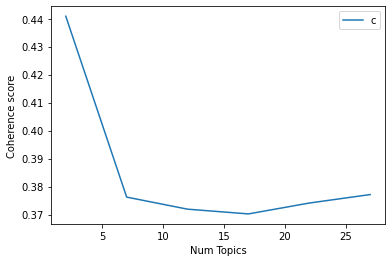

In [34]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.4409
index: 1 | Num Topics = 7  has Coherence Value of 0.3762
index: 2 | Num Topics = 12  has Coherence Value of 0.3719
index: 3 | Num Topics = 17  has Coherence Value of 0.3702
index: 4 | Num Topics = 22  has Coherence Value of 0.3741
index: 5 | Num Topics = 27  has Coherence Value of 0.3772


In [169]:
# Select optimal number of topics
optimal_model_ph = model_list_ph[0]

In [170]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph = pyLDAvis.gensim_models.prepare(optimal_model_ph, corpus_ph, id2word_ph)

In [171]:
print("pyLDAVis for overall ph topics:")
vis_ph

pyLDAVis for overall ph topics:


PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.157649  0.0       1        1  62.52812
0     -0.157649  0.0       2        1  37.47188, topic_info=       Term        Freq       Total Category  logprob  loglift
7      view  546.000000  546.000000  Default  30.0000  30.0000
65   delete  363.000000  363.000000  Default  29.0000  29.0000
38      fix  393.000000  393.000000  Default  28.0000  28.0000
5    update  257.000000  257.000000  Default  27.0000  27.0000
316    hard  116.000000  116.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
22     hope   36.610302  102.044466   Topic2  -5.4101  -0.0435
94    watch   43.582907  402.128560   Topic2  -5.2358  -1.2405
185    love   35.611231   97.195946   Topic2  -5.4378  -0.0225
193    well   33.562823   78.215229   Topic2  -5.4970   0.1355
238     guy   32.977604   52.011682   Topic2  -5.5146   0.5259

[133 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
188       1  0.916380             ad
188       2  0.083918             ad
15        1  0.817379            add
15        2  0.184198            add
513       1  0.038017  advertisement
...     ...       ...            ...
71        2  0.588824           work
1124      1  0.047339            yet
1124      2  0.994122            yet
249       1  0.378411             yt
249       2  0.619219             yt

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [39]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_ph_score1 = youtube_ios_ph_review_YearMonth_score1.review.values.tolist()
review_words_ph_score1 = list(sent_to_words(review_ph_score1))
print(review_words_ph_score1[:1])

[['the', 'thumbnails', 'links', 'that', 'shows', 'few', 'seconds', 'before', 'the', 'video', 'ends', 'are', 'annoying', 'also', 'the', 'suggestions', 'on', 'the', 'upper', 'right', 'whoever', 'thought', 'of', 'these', 'features', 'are', 'such', 'idiots', 'by', 'adding', 'distractions', 'to', 'the', 'videos', 'when', 'theyre', 'not', 'even', 'done', 'hoping', 'that', 'in', 'the', 'future', 'you', 'add', 'the', 'feature', 'where', 'ipad', 'pro', 'users', 'could', 'have', 'the', 'video', 'overlay', 'when', 'they', 'exit', 'the', 'app']]


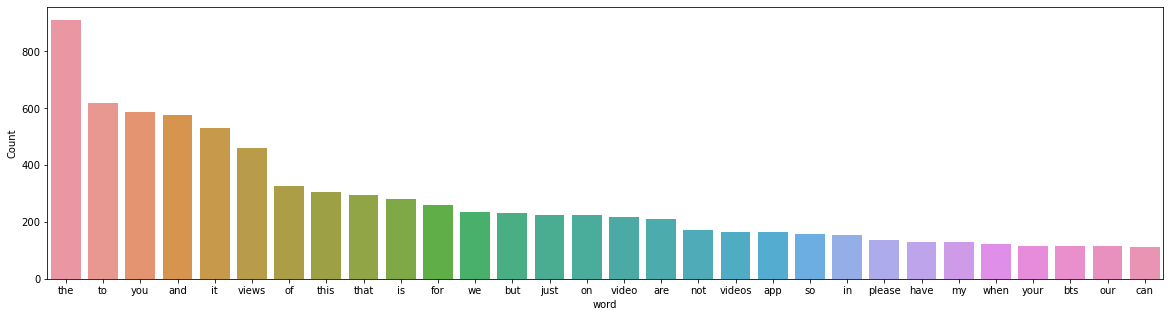

In [40]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score1))

In [41]:
# Clean text
review_ph_ready_score1 = process_words(review_words_ph_score1)  # processed Text Data! - move to each section


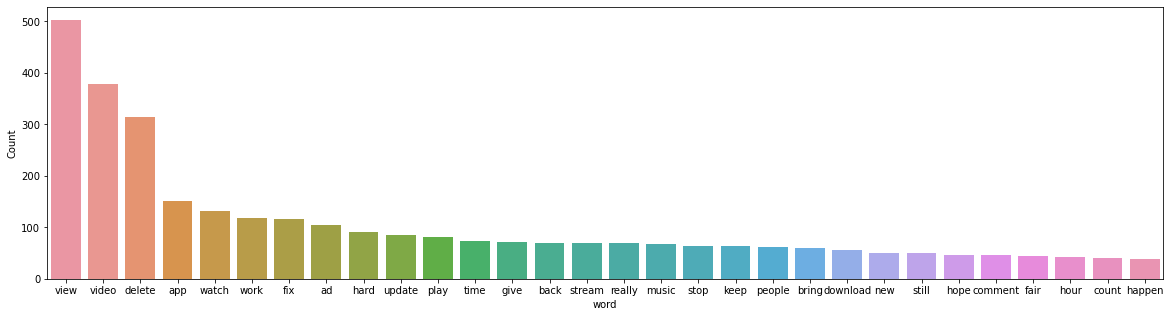

In [42]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score1))


In [43]:
# Create Dictionary
id2word_ph_score1 = corpora.Dictionary(review_ph_ready_score1)

2021-10-16 23:51:52,176 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 23:51:52,203 [INFO] gensim.corpora.dictionary - built Dictionary(1529 unique tokens: ['add', 'annoying', 'app', 'distraction', 'end']...) from 478 documents (total 8558 corpus positions)
2021-10-16 23:51:52,206 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1529 unique tokens: ['add', 'annoying', 'app', 'distraction', 'end']...) from 478 documents (total 8558 corpus positions)", 'datetime': '2021-10-16T23:51:52.206044', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [44]:
# Create Corpus: Term Document Frequency
corpus_ph_score1 = [id2word_ph_score1.doc2bow(text) for text in review_ph_ready_score1]

In [45]:
# Training LDA model
model_list_ph_score1, coherence_values_ph_score1 = compute_coherence_values(dictionary=id2word_ph_score1, corpus=corpus_ph_score1, 
                                                              texts=review_ph_ready_score1, limit=30, start=2, step=5)


2021-10-16 23:51:52,248 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 23:51:52,249 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 23:51:52,253 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:51:52,255 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 478 documents, updating model once every 478 documents, evaluating perplexity every 478 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:51:54,545 [INFO] gensim.models.ldamodel - -7.880 per-word bound, 235.6 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:51:54,546 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #478/478
2021-10-16 23:51:56,191 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.060*"view" + 0.049*"video" + 0.040*"delete" + 0.016*"app" + 0.016*"watch" + 0.013*"ad" + 0.012*"fix" +

2021-10-16 23:52:17,800 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"app" + 0.015*"update" + 0.013*"comment" + 0.010*"back" + 0.010*"video" + 0.010*"work" + 0.010*"change" + 0.009*"give" + 0.009*"view" + 0.008*"fix"
2021-10-16 23:52:17,801 [INFO] gensim.models.ldamodel - topic diff=0.019937, rho=0.301511
2021-10-16 23:52:18,804 [INFO] gensim.models.ldamodel - -6.317 per-word bound, 79.7 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:52:18,806 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #478/478
2021-10-16 23:52:19,568 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.068*"view" + 0.049*"video" + 0.043*"delete" + 0.017*"watch" + 0.014*"app" + 0.013*"ad" + 0.013*"fix" + 0.013*"work" + 0.011*"hard" + 0.011*"play"
2021-10-16 23:52:19,569 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"app" + 0.015*"update" + 0.013*"comment" + 0.010*"video" + 0.010*"back" + 0.010*"change" + 0.010*"work" + 0.009*"give" +

2021-10-16 23:52:36,838 [INFO] gensim.models.ldamodel - topic diff=0.013682, rho=0.218218
2021-10-16 23:52:37,967 [INFO] gensim.models.ldamodel - -6.297 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:52:37,968 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #478/478
2021-10-16 23:52:38,760 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.070*"view" + 0.048*"video" + 0.044*"delete" + 0.016*"watch" + 0.014*"work" + 0.014*"ad" + 0.013*"app" + 0.012*"hard" + 0.012*"fix" + 0.011*"play"
2021-10-16 23:52:38,763 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"update" + 0.019*"app" + 0.014*"comment" + 0.014*"video" + 0.010*"change" + 0.010*"fix" + 0.007*"version" + 0.007*"work" + 0.007*"back" + 0.007*"new"
2021-10-16 23:52:38,764 [INFO] gensim.models.ldamodel - topic diff=0.013581, rho=0.213201
2021-10-16 23:52:39,808 [INFO] gensim.models.ldamodel - -6.296 per-word bound, 78.6 perplexity estimate base

2021-10-16 23:52:56,004 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #478/478
2021-10-16 23:52:56,681 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.072*"view" + 0.045*"video" + 0.045*"delete" + 0.016*"watch" + 0.014*"work" + 0.014*"ad" + 0.013*"hard" + 0.012*"app" + 0.011*"fix" + 0.011*"play"
2021-10-16 23:52:56,682 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.023*"update" + 0.023*"app" + 0.020*"video" + 0.014*"comment" + 0.012*"fix" + 0.010*"change" + 0.008*"new" + 0.007*"download" + 0.007*"version" + 0.007*"still"
2021-10-16 23:52:56,683 [INFO] gensim.models.ldamodel - topic diff=0.012771, rho=0.176777
2021-10-16 23:52:57,688 [INFO] gensim.models.ldamodel - -6.281 per-word bound, 77.8 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:52:57,689 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #478/478
2021-10-16 23:52:58,354 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.073*"view" + 0.045*"d

2021-10-16 23:53:17,697 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"video" + 0.025*"app" + 0.024*"update" + 0.015*"fix" + 0.013*"comment" + 0.010*"download" + 0.009*"change" + 0.008*"watch" + 0.008*"new" + 0.007*"still"
2021-10-16 23:53:17,703 [INFO] gensim.models.ldamodel - topic diff=0.012467, rho=0.154303
2021-10-16 23:53:18,920 [INFO] gensim.models.ldamodel - -6.265 per-word bound, 76.9 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:53:18,954 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #478/478
2021-10-16 23:53:19,664 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.075*"view" + 0.047*"delete" + 0.041*"video" + 0.016*"watch" + 0.014*"work" + 0.014*"hard" + 0.013*"ad" + 0.011*"stream" + 0.010*"music" + 0.010*"app"
2021-10-16 23:53:19,666 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"video" + 0.025*"app" + 0.024*"update" + 0.016*"fix" + 0.013*"comment" + 0.011*"download" + 0.009*"change" + 0.

2021-10-16 23:53:44,067 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 474 virtual documents
2021-10-16 23:53:44,598 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 23:53:44,600 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 23:53:44,603 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 23:53:44,620 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 478 documents, updating model once every 478 documents, evaluating perplexity every 478 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 23:53:46,570 [INFO] gensim.models.ldamodel - -9.159 per-word bound, 571.8 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:53:46,572 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #478/478
2021-10-16 23:53

2021-10-16 23:53:57,690 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #478/478
2021-10-16 23:53:58,646 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"video" + 0.033*"fix" + 0.026*"app" + 0.020*"ad" + 0.019*"update" + 0.019*"download" + 0.013*"bug" + 0.010*"change" + 0.009*"play" + 0.009*"view"
2021-10-16 23:53:58,649 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.013*"delete" + 0.013*"stream" + 0.013*"view" + 0.012*"video" + 0.011*"watch" + 0.011*"million" + 0.009*"record" + 0.008*"comment" + 0.008*"company" + 0.008*"always"
2021-10-16 23:53:58,654 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"video" + 0.035*"app" + 0.027*"view" + 0.023*"fix" + 0.022*"update" + 0.018*"watch" + 0.015*"delete" + 0.014*"crash" + 0.010*"comment" + 0.010*"keep"
2021-10-16 23:53:58,658 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.023*"back" + 0.022*"view" + 0.018*"bring" + 0.014*"update" + 0.012*"give" + 0.012*"work" + 0.010*"hard" + 0.010*"app" + 0.009*"break

2021-10-16 23:54:08,166 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.087*"view" + 0.054*"delete" + 0.040*"video" + 0.021*"music" + 0.013*"hard" + 0.013*"keep" + 0.012*"stop" + 0.012*"fair" + 0.012*"work" + 0.010*"stream"
2021-10-16 23:54:08,169 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.013*"delete" + 0.013*"stream" + 0.011*"million" + 0.010*"view" + 0.010*"record" + 0.009*"advertisement" + 0.009*"comment" + 0.009*"company" + 0.008*"watch" + 0.008*"always"
2021-10-16 23:54:08,171 [INFO] gensim.models.ldamodel - topic diff=0.027935, rho=0.288675
2021-10-16 23:54:09,243 [INFO] gensim.models.ldamodel - -6.521 per-word bound, 91.8 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:54:09,249 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #478/478
2021-10-16 23:54:10,076 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.073*"view" + 0.041*"delete" + 0.030*"hard" + 0.029*"work" + 0.026*"video" + 0.017*"really" + 0.01

2021-10-16 23:54:21,240 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #478/478
2021-10-16 23:54:22,310 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.057*"video" + 0.035*"app" + 0.023*"fix" + 0.022*"update" + 0.022*"watch" + 0.018*"view" + 0.016*"crash" + 0.012*"still" + 0.011*"comment" + 0.011*"time"
2021-10-16 23:54:22,316 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.022*"back" + 0.016*"bring" + 0.015*"update" + 0.012*"give" + 0.011*"view" + 0.009*"way" + 0.009*"break" + 0.008*"hope" + 0.008*"comment" + 0.007*"app"
2021-10-16 23:54:22,319 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.056*"video" + 0.038*"fix" + 0.032*"download" + 0.029*"ad" + 0.027*"app" + 0.024*"play" + 0.021*"update" + 0.011*"bug" + 0.010*"upload" + 0.010*"connection"
2021-10-16 23:54:22,321 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.091*"view" + 0.055*"delete" + 0.039*"video" + 0.022*"music" + 0.013*"hard" + 0.013*"stop" + 0.012*"keep" + 0.012*"fair" + 0.012*"work" + 0.0

2021-10-16 23:54:37,974 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.079*"view" + 0.044*"delete" + 0.034*"hard" + 0.032*"work" + 0.019*"video" + 0.018*"really" + 0.018*"bring" + 0.015*"back" + 0.014*"army" + 0.012*"stream"
2021-10-16 23:54:37,978 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.021*"back" + 0.015*"update" + 0.015*"bring" + 0.011*"give" + 0.010*"view" + 0.009*"way" + 0.009*"hope" + 0.009*"comment" + 0.008*"break" + 0.008*"feature"
2021-10-16 23:54:37,981 [INFO] gensim.models.ldamodel - topic diff=0.012780, rho=0.208514
2021-10-16 23:54:39,240 [INFO] gensim.models.ldamodel - -6.491 per-word bound, 90.0 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:54:39,242 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #478/478
2021-10-16 23:54:39,981 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.079*"view" + 0.045*"delete" + 0.035*"hard" + 0.032*"work" + 0.019*"video" + 0.018*"bring" + 0.018*"really" + 0.01

2021-10-16 23:54:48,741 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #478/478
2021-10-16 23:54:49,731 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.081*"view" + 0.046*"delete" + 0.036*"hard" + 0.033*"work" + 0.019*"bring" + 0.018*"really" + 0.017*"video" + 0.016*"back" + 0.015*"army" + 0.013*"stream"
2021-10-16 23:54:49,733 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.015*"stream" + 0.013*"delete" + 0.011*"advertisement" + 0.011*"million" + 0.009*"company" + 0.009*"comment" + 0.009*"record" + 0.009*"review" + 0.008*"hate" + 0.008*"repeat"
2021-10-16 23:54:49,736 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.072*"view" + 0.051*"delete" + 0.034*"video" + 0.019*"watch" + 0.017*"ad" + 0.014*"hour" + 0.014*"time" + 0.011*"app" + 0.011*"work" + 0.010*"really"
2021-10-16 23:54:49,739 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.094*"view" + 0.055*"delete" + 0.038*"video" + 0.023*"music" + 0.013*"stop" + 0.012*"hard" + 0.012*"keep" + 0.012*"fair" + 0

2021-10-16 23:55:00,047 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.095*"view" + 0.054*"delete" + 0.038*"video" + 0.023*"music" + 0.013*"stop" + 0.012*"keep" + 0.012*"hard" + 0.011*"fair" + 0.011*"give" + 0.011*"work"
2021-10-16 23:55:00,050 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.015*"stream" + 0.013*"delete" + 0.011*"advertisement" + 0.011*"million" + 0.009*"company" + 0.009*"comment" + 0.009*"review" + 0.009*"record" + 0.008*"hate" + 0.008*"repeat"
2021-10-16 23:55:00,052 [INFO] gensim.models.ldamodel - topic diff=0.007113, rho=0.171499
2021-10-16 23:55:01,329 [INFO] gensim.models.ldamodel - -6.477 per-word bound, 89.1 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:55:01,332 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #478/478
2021-10-16 23:55:01,974 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.054*"video" + 0.036*"app" + 0.023*"watch" + 0.022*"update" + 0.021*"fix" + 0.017*"crash" + 0.013*"

2021-10-16 23:55:10,073 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #478/478
2021-10-16 23:55:10,749 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.084*"view" + 0.048*"delete" + 0.040*"hard" + 0.035*"work" + 0.020*"bring" + 0.018*"back" + 0.017*"really" + 0.015*"stream" + 0.015*"army" + 0.014*"video"
2021-10-16 23:55:10,752 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.083*"video" + 0.045*"ad" + 0.041*"play" + 0.040*"fix" + 0.031*"download" + 0.027*"app" + 0.021*"update" + 0.013*"load" + 0.012*"watch" + 0.010*"start"
2021-10-16 23:55:10,756 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.053*"video" + 0.036*"app" + 0.022*"watch" + 0.022*"update" + 0.021*"fix" + 0.017*"crash" + 0.014*"still" + 0.013*"comment" + 0.011*"keep" + 0.011*"time"
2021-10-16 23:55:10,759 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.015*"stream" + 0.013*"delete" + 0.011*"million" + 0.011*"advertisement" + 0.009*"company" + 0.009*"comment" + 0.009*"review" + 0.008*"record" 

2021-10-16 23:55:21,100 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"video" + 0.037*"app" + 0.022*"update" + 0.022*"watch" + 0.021*"fix" + 0.017*"crash" + 0.014*"still" + 0.013*"comment" + 0.011*"keep" + 0.011*"problem"
2021-10-16 23:55:21,102 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.015*"stream" + 0.013*"delete" + 0.012*"million" + 0.011*"advertisement" + 0.009*"company" + 0.009*"comment" + 0.009*"review" + 0.008*"channel" + 0.008*"record" + 0.008*"hate"
2021-10-16 23:55:21,103 [INFO] gensim.models.ldamodel - topic diff=0.004138, rho=0.149071
2021-10-16 23:55:22,203 [INFO] gensim.models.ldamodel - -6.470 per-word bound, 88.6 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:55:22,204 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #478/478
2021-10-16 23:55:22,849 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.019*"back" + 0.016*"update" + 0.012*"bring" + 0.011*"give" + 0.009*"way" + 0.009*"comment" 

2021-10-16 23:55:31,609 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #478/478
2021-10-16 23:55:32,233 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.087*"video" + 0.047*"ad" + 0.043*"play" + 0.040*"fix" + 0.030*"download" + 0.027*"app" + 0.022*"update" + 0.015*"watch" + 0.013*"load" + 0.010*"start"
2021-10-16 23:55:32,236 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.019*"back" + 0.016*"update" + 0.012*"bring" + 0.011*"give" + 0.010*"way" + 0.009*"comment" + 0.009*"hope" + 0.009*"feature" + 0.007*"bottom" + 0.007*"management"
2021-10-16 23:55:32,244 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.097*"view" + 0.053*"delete" + 0.039*"video" + 0.025*"music" + 0.013*"stop" + 0.012*"keep" + 0.011*"give" + 0.011*"fair" + 0.011*"count" + 0.010*"app"
2021-10-16 23:55:32,327 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.015*"stream" + 0.013*"delete" + 0.012*"million" + 0.011*"advertisement" + 0.009*"company" + 0.009*"channel" + 0.009*"comment" + 0.009*"re

2021-10-16 23:55:50,414 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.050*"view" + 0.044*"video" + 0.026*"ad" + 0.020*"delete" + 0.016*"music" + 0.014*"app" + 0.010*"hope" + 0.010*"long" + 0.010*"upload" + 0.010*"watch"
2021-10-16 23:55:50,415 [INFO] gensim.models.ldamodel - topic diff=0.143417, rho=0.447214
2021-10-16 23:55:51,315 [INFO] gensim.models.ldamodel - -6.665 per-word bound, 101.5 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:55:51,321 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #478/478
2021-10-16 23:55:51,923 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.048*"view" + 0.044*"video" + 0.027*"ad" + 0.019*"delete" + 0.016*"music" + 0.013*"app" + 0.011*"hope" + 0.010*"long" + 0.010*"upload" + 0.010*"stop"
2021-10-16 23:55:51,927 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.041*"video" + 0.034*"ad" + 0.029*"play" + 0.027*"start" + 0.022*"fix" + 0.019*"whenever" + 0.018*"click" + 0.016*"audio" 

2021-10-16 23:56:00,533 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.123*"view" + 0.081*"delete" + 0.030*"stop" + 0.025*"video" + 0.023*"work" + 0.021*"hard" + 0.013*"app" + 0.012*"people" + 0.012*"fix" + 0.011*"music"
2021-10-16 23:56:00,538 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.061*"video" + 0.028*"watch" + 0.019*"view" + 0.017*"really" + 0.017*"ad" + 0.012*"count" + 0.011*"show" + 0.011*"everytime" + 0.010*"happen" + 0.010*"platform"
2021-10-16 23:56:00,540 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"video" + 0.039*"view" + 0.029*"ad" + 0.017*"music" + 0.016*"delete" + 0.014*"upload" + 0.012*"app" + 0.011*"long" + 0.011*"hope" + 0.010*"stop"
2021-10-16 23:56:00,546 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.062*"video" + 0.030*"view" + 0.024*"watch" + 0.018*"delete" + 0.015*"fix" + 0.014*"keep" + 0.012*"play" + 0.009*"app" + 0.009*"give" + 0.008*"new"
2021-10-16 23:56:00,548 [INFO] gensim.models.ldamodel - topic diff=0.041614, rho=0.30151

2021-10-16 23:56:12,233 [INFO] gensim.models.ldamodel - topic diff=0.023005, rho=0.250000
2021-10-16 23:56:13,277 [INFO] gensim.models.ldamodel - -6.569 per-word bound, 94.9 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:56:13,280 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #478/478
2021-10-16 23:56:14,059 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.041*"ad" + 0.036*"video" + 0.025*"view" + 0.025*"fix" + 0.017*"watch" + 0.013*"delete" + 0.012*"sure" + 0.011*"annoy" + 0.010*"bug" + 0.010*"read"
2021-10-16 23:56:14,061 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.048*"video" + 0.031*"view" + 0.030*"ad" + 0.018*"music" + 0.018*"upload" + 0.012*"app" + 0.012*"delete" + 0.012*"long" + 0.011*"hope" + 0.011*"stop"
2021-10-16 23:56:14,063 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.023*"update" + 0.019*"give" + 0.015*"back" + 0.014*"app" + 0.012*"comment" + 0.011*"management" + 0.011*"feature" + 0.010*"ho

2021-10-16 23:56:23,125 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.135*"view" + 0.090*"delete" + 0.030*"stop" + 0.021*"work" + 0.021*"video" + 0.021*"hard" + 0.013*"music" + 0.012*"people" + 0.011*"stream" + 0.011*"app"
2021-10-16 23:56:23,138 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"ad" + 0.036*"video" + 0.024*"view" + 0.024*"fix" + 0.017*"watch" + 0.012*"sure" + 0.012*"delete" + 0.012*"annoy" + 0.010*"bug" + 0.010*"read"
2021-10-16 23:56:23,141 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.106*"view" + 0.065*"delete" + 0.028*"work" + 0.027*"hard" + 0.021*"bring" + 0.020*"back" + 0.019*"stream" + 0.018*"really" + 0.014*"people" + 0.014*"video"
2021-10-16 23:56:23,148 [INFO] gensim.models.ldamodel - topic diff=0.014033, rho=0.213201
2021-10-16 23:56:24,037 [INFO] gensim.models.ldamodel - -6.552 per-word bound, 93.9 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:56:24,038 [INFO] gensim.models.ldamodel - PROGR

2021-10-16 23:56:31,763 [INFO] gensim.models.ldamodel - -6.544 per-word bound, 93.3 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:56:31,765 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #478/478
2021-10-16 23:56:32,342 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.065*"video" + 0.036*"watch" + 0.019*"really" + 0.015*"ad" + 0.013*"count" + 0.012*"show" + 0.010*"platform" + 0.010*"everytime" + 0.010*"view" + 0.010*"happen"
2021-10-16 23:56:32,344 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.089*"play" + 0.082*"video" + 0.066*"ad" + 0.034*"fix" + 0.026*"watch" + 0.024*"start" + 0.020*"app" + 0.020*"click" + 0.017*"update" + 0.017*"search"
2021-10-16 23:56:32,346 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.065*"video" + 0.026*"watch" + 0.015*"fix" + 0.015*"keep" + 0.014*"view" + 0.010*"new" + 0.008*"play" + 0.008*"policy" + 0.008*"first" + 0.007*"speed"
2021-10-16 23:56:32,352 [INFO] gensim.models.ldamode

2021-10-16 23:56:42,227 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"video" + 0.020*"delete" + 0.017*"watch" + 0.017*"view" + 0.016*"app" + 0.015*"version" + 0.013*"ad" + 0.013*"time" + 0.012*"download" + 0.010*"annoying"
2021-10-16 23:56:42,230 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.093*"play" + 0.086*"video" + 0.066*"ad" + 0.034*"fix" + 0.027*"watch" + 0.023*"start" + 0.021*"app" + 0.019*"click" + 0.018*"update" + 0.017*"search"
2021-10-16 23:56:42,236 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.052*"video" + 0.032*"ad" + 0.020*"upload" + 0.020*"view" + 0.017*"music" + 0.013*"long" + 0.012*"app" + 0.011*"hope" + 0.011*"platform" + 0.011*"way"
2021-10-16 23:56:42,242 [INFO] gensim.models.ldamodel - topic diff=0.007032, rho=0.174078
2021-10-16 23:56:43,375 [INFO] gensim.models.ldamodel - -6.536 per-word bound, 92.8 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:56:43,378 [INFO] gensim.models.ldamodel - PRO

2021-10-16 23:56:50,977 [INFO] gensim.models.ldamodel - topic diff=0.005451, rho=0.162221
2021-10-16 23:56:51,744 [INFO] gensim.models.ldamodel - -6.532 per-word bound, 92.5 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:56:51,745 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #478/478
2021-10-16 23:56:52,310 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.053*"video" + 0.019*"delete" + 0.018*"watch" + 0.016*"app" + 0.015*"version" + 0.014*"view" + 0.014*"download" + 0.013*"ad" + 0.013*"time" + 0.011*"annoying"
2021-10-16 23:56:52,312 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.023*"update" + 0.019*"give" + 0.015*"back" + 0.012*"comment" + 0.011*"feature" + 0.011*"management" + 0.011*"hope" + 0.009*"yt" + 0.009*"regard" + 0.009*"matter"
2021-10-16 23:56:52,314 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.138*"view" + 0.094*"delete" + 0.031*"stop" + 0.021*"video" + 0.021*"work" + 0.020*"hard" + 0.015*"mus

2021-10-16 23:57:01,440 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.038*"ad" + 0.035*"video" + 0.024*"view" + 0.024*"fix" + 0.016*"watch" + 0.013*"annoy" + 0.013*"sure" + 0.012*"delete" + 0.011*"bug" + 0.011*"read"
2021-10-16 23:57:01,470 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.102*"play" + 0.091*"video" + 0.065*"ad" + 0.036*"fix" + 0.028*"watch" + 0.022*"start" + 0.022*"app" + 0.018*"update" + 0.018*"click" + 0.017*"search"
2021-10-16 23:57:01,473 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.053*"video" + 0.018*"watch" + 0.018*"delete" + 0.016*"app" + 0.016*"download" + 0.016*"version" + 0.013*"ad" + 0.013*"time" + 0.013*"view" + 0.011*"annoying"
2021-10-16 23:57:01,475 [INFO] gensim.models.ldamodel - topic diff=0.004023, rho=0.150756
2021-10-16 23:57:02,223 [INFO] gensim.models.ldamodel - -6.528 per-word bound, 92.3 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:57:02,224 [INFO] gensim.models.ldamodel - PROGRES

2021-10-16 23:57:08,988 [INFO] gensim.models.ldamodel - topic diff=0.003166, rho=0.142857
2021-10-16 23:57:09,782 [INFO] gensim.models.ldamodel - -6.525 per-word bound, 92.1 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:57:09,833 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #478/478
2021-10-16 23:57:10,410 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.016*"company" + 0.015*"give" + 0.013*"record" + 0.012*"stream" + 0.010*"write" + 0.010*"serious" + 0.010*"review" + 0.009*"pay" + 0.009*"sign" + 0.009*"star"
2021-10-16 23:57:10,466 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.052*"video" + 0.032*"ad" + 0.021*"upload" + 0.017*"view" + 0.017*"music" + 0.013*"long" + 0.013*"hope" + 0.013*"way" + 0.012*"app" + 0.011*"platform"
2021-10-16 23:57:10,473 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.111*"view" + 0.066*"delete" + 0.026*"hard" + 0.026*"work" + 0.022*"bring" + 0.021*"back" + 0.018*"stream" + 0.018

2021-10-16 23:57:26,728 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.078*"view" + 0.056*"delete" + 0.051*"video" + 0.018*"ad" + 0.016*"watch" + 0.015*"time" + 0.013*"app" + 0.011*"people" + 0.011*"play" + 0.011*"work"
2021-10-16 23:57:26,733 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.057*"view" + 0.022*"back" + 0.018*"bring" + 0.015*"delete" + 0.014*"give" + 0.010*"video" + 0.010*"new" + 0.010*"option" + 0.010*"job" + 0.010*"guy"
2021-10-16 23:57:26,736 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.031*"fix" + 0.031*"app" + 0.026*"comment" + 0.026*"update" + 0.022*"video" + 0.019*"view" + 0.016*"bug" + 0.015*"phone" + 0.013*"window" + 0.010*"ad"
2021-10-16 23:57:26,744 [INFO] gensim.models.ldamodel - topic diff=0.177423, rho=0.500000
2021-10-16 23:57:27,667 [INFO] gensim.models.ldamodel - -6.833 per-word bound, 114.0 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:57:27,689 [INFO] gensim.models.ldamodel - PROGRESS: pa

2021-10-16 23:57:35,315 [INFO] gensim.models.ldamodel - -6.716 per-word bound, 105.1 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:57:35,322 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #478/478
2021-10-16 23:57:36,003 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.061*"view" + 0.036*"delete" + 0.017*"keep" + 0.017*"give" + 0.016*"app" + 0.015*"hope" + 0.015*"fair" + 0.013*"watch" + 0.010*"time" + 0.009*"really"
2021-10-16 23:57:36,018 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.058*"video" + 0.050*"view" + 0.025*"delete" + 0.016*"count" + 0.015*"watch" + 0.015*"music" + 0.011*"keep" + 0.010*"app" + 0.010*"really" + 0.010*"work"
2021-10-16 23:57:36,030 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.079*"video" + 0.028*"watch" + 0.020*"happen" + 0.017*"view" + 0.013*"cause" + 0.012*"search" + 0.011*"work" + 0.010*"time" + 0.010*"upload" + 0.010*"button"
2021-10-16 23:57:36,033 [INFO] gensim.models.ldamod

2021-10-16 23:57:43,267 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.078*"video" + 0.049*"download" + 0.026*"watch" + 0.018*"offline" + 0.013*"army" + 0.013*"upload" + 0.013*"play" + 0.013*"update" + 0.012*"fix" + 0.011*"hour"
2021-10-16 23:57:43,270 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.037*"app" + 0.028*"back" + 0.027*"update" + 0.021*"second" + 0.018*"put" + 0.018*"video" + 0.016*"work" + 0.015*"comment" + 0.015*"bring" + 0.015*"hate"
2021-10-16 23:57:43,272 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.114*"view" + 0.068*"delete" + 0.042*"hard" + 0.041*"work" + 0.025*"stream" + 0.023*"back" + 0.021*"really" + 0.020*"bring" + 0.018*"people" + 0.016*"fair"
2021-10-16 23:57:43,275 [INFO] gensim.models.ldamodel - topic diff=0.025139, rho=0.258199
2021-10-16 23:57:44,126 [INFO] gensim.models.ldamodel - -6.676 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:57:44,128 [INFO] gensim.models.ldamo

2021-10-16 23:57:50,725 [INFO] gensim.models.ldamodel - -6.655 per-word bound, 100.8 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:57:50,727 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #478/478
2021-10-16 23:57:51,202 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.079*"video" + 0.076*"download" + 0.027*"watch" + 0.018*"offline" + 0.013*"upload" + 0.013*"update" + 0.012*"fix" + 0.011*"army" + 0.010*"app" + 0.010*"play"
2021-10-16 23:57:51,204 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.081*"video" + 0.046*"play" + 0.034*"update" + 0.034*"app" + 0.034*"fix" + 0.025*"watch" + 0.022*"ad" + 0.017*"crash" + 0.017*"still" + 0.016*"keep"
2021-10-16 23:57:51,206 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.028*"video" + 0.024*"view" + 0.020*"channel" + 0.020*"delete" + 0.015*"comment" + 0.015*"well" + 0.014*"ad" + 0.013*"way" + 0.012*"start" + 0.011*"app"
2021-10-16 23:57:51,208 [INFO] gensim.models.ldamode

2021-10-16 23:58:00,259 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.054*"video" + 0.034*"ad" + 0.033*"view" + 0.028*"music" + 0.025*"delete" + 0.017*"skip" + 0.014*"watch" + 0.014*"fix" + 0.012*"stupid" + 0.011*"non"
2021-10-16 23:58:00,261 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.062*"video" + 0.040*"view" + 0.020*"count" + 0.017*"delete" + 0.016*"music" + 0.015*"watch" + 0.011*"keep" + 0.010*"group" + 0.009*"really" + 0.009*"already"
2021-10-16 23:58:00,263 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.044*"ad" + 0.030*"video" + 0.021*"whenever" + 0.019*"click" + 0.015*"crash" + 0.014*"annoying" + 0.013*"work" + 0.012*"app" + 0.011*"watch" + 0.011*"already"
2021-10-16 23:58:00,264 [INFO] gensim.models.ldamodel - topic diff=0.010550, rho=0.196116
2021-10-16 23:58:00,997 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:58:00,999 [INFO] gensim.models.ldamode

2021-10-16 23:58:06,891 [INFO] gensim.models.ldamodel - topic diff=0.007981, rho=0.179605
2021-10-16 23:58:07,691 [INFO] gensim.models.ldamodel - -6.628 per-word bound, 98.9 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:58:07,693 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #478/478
2021-10-16 23:58:08,359 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.059*"change" + 0.021*"video" + 0.019*"back" + 0.019*"resolution" + 0.019*"update" + 0.015*"star" + 0.014*"always" + 0.012*"watch" + 0.012*"app" + 0.012*"iphone"
2021-10-16 23:58:08,360 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.063*"video" + 0.037*"view" + 0.020*"count" + 0.016*"music" + 0.016*"delete" + 0.015*"watch" + 0.011*"keep" + 0.011*"group" + 0.009*"really" + 0.009*"play"
2021-10-16 23:58:08,364 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.043*"ad" + 0.029*"video" + 0.023*"whenever" + 0.020*"click" + 0.015*"crash" + 0.014*"annoying" + 0.012*"a

2021-10-16 23:58:15,302 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.083*"video" + 0.050*"play" + 0.036*"app" + 0.035*"update" + 0.034*"fix" + 0.026*"watch" + 0.023*"ad" + 0.017*"crash" + 0.016*"keep" + 0.016*"still"
2021-10-16 23:58:15,304 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.015*"seriously" + 0.013*"video" + 0.013*"option" + 0.013*"watch" + 0.013*"whole" + 0.013*"job" + 0.013*"earn" + 0.009*"consider" + 0.009*"platform" + 0.008*"view"
2021-10-16 23:58:15,306 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.059*"change" + 0.021*"video" + 0.019*"back" + 0.019*"resolution" + 0.019*"update" + 0.015*"star" + 0.014*"always" + 0.012*"app" + 0.012*"watch" + 0.012*"iphone"
2021-10-16 23:58:15,308 [INFO] gensim.models.ldamodel - topic diff=0.006585, rho=0.164399
2021-10-16 23:58:16,307 [INFO] gensim.models.ldamodel - -6.620 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:58:16,309 [INFO] gensim.models

2021-10-16 23:58:22,836 [INFO] gensim.models.ldamodel - topic diff=0.004924, rho=0.154303
2021-10-16 23:58:23,747 [INFO] gensim.models.ldamodel - -6.615 per-word bound, 98.0 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:58:23,758 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #478/478
2021-10-16 23:58:24,326 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.075*"view" + 0.059*"delete" + 0.038*"video" + 0.016*"time" + 0.015*"watch" + 0.012*"count" + 0.011*"people" + 0.010*"app" + 0.009*"music" + 0.008*"hour"
2021-10-16 23:58:24,328 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.041*"ad" + 0.029*"video" + 0.025*"whenever" + 0.021*"click" + 0.015*"crash" + 0.014*"annoying" + 0.012*"app" + 0.012*"work" + 0.011*"watch" + 0.011*"find"
2021-10-16 23:58:24,330 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.104*"download" + 0.074*"video" + 0.026*"watch" + 0.019*"offline" + 0.014*"upload" + 0.012*"update" + 0.011*"app" 

2021-10-16 23:58:31,989 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.033*"fix" + 0.033*"version" + 0.028*"comment" + 0.027*"update" + 0.026*"app" + 0.023*"video" + 0.020*"phone" + 0.017*"bug" + 0.016*"old" + 0.013*"window"
2021-10-16 23:58:31,999 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.014*"seriously" + 0.014*"video" + 0.014*"option" + 0.014*"watch" + 0.014*"whole" + 0.014*"job" + 0.013*"earn" + 0.011*"secure" + 0.010*"consider" + 0.010*"platform"
2021-10-16 23:58:32,003 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.024*"view" + 0.021*"channel" + 0.020*"video" + 0.019*"delete" + 0.016*"comment" + 0.016*"well" + 0.014*"new" + 0.013*"way" + 0.011*"ad" + 0.011*"start"
2021-10-16 23:58:32,008 [INFO] gensim.models.ldamodel - topic diff=0.004015, rho=0.144338
2021-10-16 23:58:32,776 [INFO] gensim.models.ldamodel - -6.610 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:58:32,780 [INFO] gensim.models.

2021-10-16 23:58:48,489 [INFO] gensim.models.ldamodel - -7.147 per-word bound, 141.7 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:58:48,490 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #478/478
2021-10-16 23:58:49,121 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.064*"view" + 0.040*"delete" + 0.022*"fix" + 0.018*"video" + 0.015*"work" + 0.014*"people" + 0.014*"count" + 0.013*"time" + 0.012*"hard" + 0.012*"app"
2021-10-16 23:58:49,123 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.050*"view" + 0.031*"back" + 0.022*"bring" + 0.018*"give" + 0.016*"comment" + 0.014*"work" + 0.012*"fan" + 0.010*"app" + 0.010*"hard" + 0.010*"business"
2021-10-16 23:58:49,124 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.050*"view" + 0.028*"video" + 0.026*"watch" + 0.021*"delete" + 0.017*"give" + 0.014*"music" + 0.013*"keep" + 0.013*"problem" + 0.012*"back" + 0.011*"movie"
2021-10-16 23:58:49,126 [INFO] gensim.models.ldamodel 

2021-10-16 23:58:57,410 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.062*"quality" + 0.036*"high" + 0.029*"picture" + 0.021*"datum" + 0.018*"ad" + 0.018*"saver" + 0.009*"necessary" + 0.009*"whenever" + 0.009*"dull" + 0.009*"preset"
2021-10-16 23:58:57,417 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.055*"view" + 0.048*"delete" + 0.036*"video" + 0.018*"app" + 0.016*"time" + 0.016*"hour" + 0.015*"work" + 0.014*"watch" + 0.013*"download" + 0.011*"hope"
2021-10-16 23:58:57,420 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.068*"view" + 0.040*"delete" + 0.033*"video" + 0.016*"stream" + 0.014*"ad" + 0.013*"army" + 0.013*"million" + 0.011*"music" + 0.009*"count" + 0.009*"disappointment"
2021-10-16 23:58:57,426 [INFO] gensim.models.ldamodel - topic diff=0.092328, rho=0.353553
2021-10-16 23:58:58,224 [INFO] gensim.models.ldamodel - -6.840 per-word bound, 114.5 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:58:58,226 [INFO] gensi

2021-10-16 23:59:05,377 [INFO] gensim.models.ldamodel - topic diff=0.037258, rho=0.277350
2021-10-16 23:59:06,298 [INFO] gensim.models.ldamodel - -6.796 per-word bound, 111.1 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:59:06,299 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #478/478
2021-10-16 23:59:07,365 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.052*"video" + 0.028*"view" + 0.024*"download" + 0.021*"army" + 0.017*"hour" + 0.014*"update" + 0.014*"today" + 0.014*"disappear" + 0.014*"app" + 0.014*"music"
2021-10-16 23:59:07,368 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.072*"video" + 0.065*"view" + 0.029*"delete" + 0.028*"watch" + 0.025*"count" + 0.021*"music" + 0.013*"give" + 0.010*"already" + 0.009*"really" + 0.009*"still"
2021-10-16 23:59:07,370 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.088*"view" + 0.055*"delete" + 0.031*"app" + 0.013*"star" + 0.012*"video" + 0.012*"back" + 0.011*"bring

2021-10-16 23:59:16,352 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.126*"view" + 0.070*"hard" + 0.065*"work" + 0.056*"delete" + 0.043*"really" + 0.040*"back" + 0.034*"bring" + 0.028*"unfair" + 0.025*"stream" + 0.023*"give"
2021-10-16 23:59:16,360 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.100*"video" + 0.071*"ad" + 0.050*"play" + 0.038*"fix" + 0.034*"watch" + 0.024*"update" + 0.017*"time" + 0.017*"version" + 0.016*"app" + 0.015*"iphone"
2021-10-16 23:59:16,363 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.068*"view" + 0.042*"delete" + 0.032*"video" + 0.017*"stream" + 0.015*"army" + 0.015*"million" + 0.012*"music" + 0.010*"disappointment" + 0.009*"stop" + 0.009*"bot"
2021-10-16 23:59:16,364 [INFO] gensim.models.ldamodel - topic diff=0.019089, rho=0.229416
2021-10-16 23:59:17,214 [INFO] gensim.models.ldamodel - -6.768 per-word bound, 109.0 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:59:17,218 [INFO] gensim.models

2021-10-16 23:59:24,372 [INFO] gensim.models.ldamodel - topic diff=0.013326, rho=0.204124
2021-10-16 23:59:25,513 [INFO] gensim.models.ldamodel - -6.755 per-word bound, 108.0 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:59:25,515 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #478/478
2021-10-16 23:59:26,315 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.050*"view" + 0.048*"video" + 0.039*"delete" + 0.022*"music" + 0.020*"app" + 0.019*"show" + 0.016*"artist" + 0.014*"number" + 0.011*"check" + 0.009*"play"
2021-10-16 23:59:26,318 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.053*"view" + 0.046*"delete" + 0.034*"video" + 0.020*"hour" + 0.016*"app" + 0.016*"download" + 0.016*"time" + 0.015*"work" + 0.012*"watch" + 0.012*"hope"
2021-10-16 23:59:26,322 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.048*"view" + 0.023*"delete" + 0.020*"give" + 0.017*"watch" + 0.016*"video" + 0.015*"keep" + 0.015*"movie" + 0.015

2021-10-16 23:59:35,376 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.138*"view" + 0.071*"hard" + 0.067*"work" + 0.065*"delete" + 0.045*"really" + 0.043*"back" + 0.039*"bring" + 0.028*"stream" + 0.028*"unfair" + 0.022*"give"
2021-10-16 23:59:35,378 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.023*"world" + 0.020*"app" + 0.019*"still" + 0.014*"error" + 0.013*"company" + 0.012*"people" + 0.012*"way" + 0.012*"turn" + 0.012*"write" + 0.011*"big"
2021-10-16 23:59:35,381 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.033*"video" + 0.027*"fix" + 0.020*"window" + 0.020*"black" + 0.017*"update" + 0.013*"comment" + 0.013*"suggest" + 0.013*"space" + 0.013*"center" + 0.011*"app"
2021-10-16 23:59:35,382 [INFO] gensim.models.ldamodel - topic diff=0.009478, rho=0.182574
2021-10-16 23:59:36,534 [INFO] gensim.models.ldamodel - -6.743 per-word bound, 107.1 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:59:36,536 [INFO] gensim.models.ldamo

2021-10-16 23:59:44,540 [INFO] gensim.models.ldamodel - topic diff=0.007540, rho=0.169031
2021-10-16 23:59:45,810 [INFO] gensim.models.ldamodel - -6.735 per-word bound, 106.6 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:59:45,819 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #478/478
2021-10-16 23:59:47,252 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.074*"quality" + 0.064*"high" + 0.052*"picture" + 0.028*"datum" + 0.019*"saver" + 0.010*"impose" + 0.010*"necessary" + 0.010*"eff" + 0.010*"preset" + 0.010*"specify"
2021-10-16 23:59:47,254 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.069*"view" + 0.054*"delete" + 0.028*"hard" + 0.020*"work" + 0.019*"stream" + 0.019*"fair" + 0.018*"fan" + 0.016*"music" + 0.016*"record" + 0.015*"video"
2021-10-16 23:59:47,256 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.023*"world" + 0.021*"still" + 0.019*"app" + 0.014*"error" + 0.013*"company" + 0.012*"people" + 0.012*"w

2021-10-16 23:59:56,841 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.068*"view" + 0.044*"delete" + 0.031*"video" + 0.019*"stream" + 0.015*"army" + 0.013*"million" + 0.012*"music" + 0.010*"disappointment" + 0.010*"stop" + 0.010*"bot"
2021-10-16 23:59:56,845 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.027*"update" + 0.023*"video" + 0.021*"app" + 0.020*"click" + 0.014*"comment" + 0.014*"put" + 0.013*"hope" + 0.013*"crash" + 0.012*"whenever" + 0.011*"issue"
2021-10-16 23:59:56,855 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.036*"video" + 0.027*"delete" + 0.022*"view" + 0.015*"count" + 0.015*"cast" + 0.015*"platform" + 0.015*"job" + 0.011*"money" + 0.010*"million" + 0.010*"watch"
2021-10-16 23:59:56,891 [INFO] gensim.models.ldamodel - topic diff=0.005830, rho=0.156174
2021-10-16 23:59:57,800 [INFO] gensim.models.ldamodel - -6.728 per-word bound, 106.0 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-16 23:59:57,806 [INFO] gensi

2021-10-17 00:00:07,935 [INFO] gensim.models.ldamodel - topic diff=0.004880, rho=0.147442
2021-10-17 00:00:09,128 [INFO] gensim.models.ldamodel - -6.722 per-word bound, 105.6 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-17 00:00:09,129 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #478/478
2021-10-17 00:00:09,873 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.053*"view" + 0.044*"delete" + 0.024*"fix" + 0.016*"video" + 0.015*"change" + 0.014*"count" + 0.012*"people" + 0.012*"fair" + 0.012*"music" + 0.012*"new"
2021-10-17 00:00:09,875 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.036*"video" + 0.027*"delete" + 0.022*"view" + 0.015*"cast" + 0.015*"count" + 0.015*"platform" + 0.015*"job" + 0.011*"money" + 0.010*"million" + 0.010*"watch"
2021-10-17 00:00:09,880 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.052*"video" + 0.042*"app" + 0.024*"watch" + 0.022*"update" + 0.020*"comment" + 0.017*"really" + 0.017*"fix" +

2021-10-17 00:00:24,553 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 477 virtual documents
2021-10-17 00:00:29,429 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-17 00:00:29,432 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-17 00:00:29,438 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:00:29,473 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 478 documents, updating model once every 478 documents, evaluating perplexity every 478 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:00:31,067 [INFO] gensim.models.ldamodel - -17.377 per-word bound, 170187.0 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-17 00:00:31,069 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #478/478
2021-10-1

2021-10-17 00:00:40,555 [INFO] gensim.models.ldamodel - -6.947 per-word bound, 123.4 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-17 00:00:40,557 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #478/478
2021-10-17 00:00:41,289 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.096*"view" + 0.065*"delete" + 0.019*"fix" + 0.016*"stop" + 0.013*"video" + 0.013*"time" + 0.012*"fair" + 0.012*"people" + 0.011*"army" + 0.011*"effort"
2021-10-17 00:00:41,292 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.033*"watch" + 0.030*"find" + 0.026*"search" + 0.023*"episode" + 0.023*"ad" + 0.022*"fix" + 0.022*"app" + 0.015*"time" + 0.015*"back" + 0.015*"open"
2021-10-17 00:00:41,294 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.047*"view" + 0.037*"delete" + 0.026*"fix" + 0.015*"artist" + 0.013*"channel" + 0.013*"hate" + 0.012*"show" + 0.012*"become" + 0.012*"lately" + 0.011*"ad"
2021-10-17 00:00:41,298 [INFO] gensim.models.ldamodel -

2021-10-17 00:00:48,472 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.028*"work" + 0.021*"update" + 0.020*"app" + 0.018*"skip" + 0.017*"hard" + 0.017*"download" + 0.014*"view" + 0.014*"record" + 0.013*"really" + 0.013*"version"
2021-10-17 00:00:48,498 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.078*"view" + 0.056*"delete" + 0.031*"bring" + 0.030*"back" + 0.020*"people" + 0.019*"download" + 0.018*"video" + 0.017*"hard" + 0.015*"fair" + 0.015*"work"
2021-10-17 00:00:48,501 [INFO] gensim.models.ldamodel - topic diff=0.047338, rho=0.288675
2021-10-17 00:00:49,292 [INFO] gensim.models.ldamodel - -6.860 per-word bound, 116.2 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-17 00:00:49,294 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #478/478
2021-10-17 00:00:49,801 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.042*"change" + 0.025*"fix" + 0.023*"screen" + 0.022*"video" + 0.020*"advertisement" + 0.019*"rate" + 0.019*

2021-10-17 00:00:56,382 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #478/478
2021-10-17 00:00:56,842 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.145*"view" + 0.096*"delete" + 0.033*"hard" + 0.033*"work" + 0.027*"video" + 0.027*"stop" + 0.019*"people" + 0.019*"music" + 0.016*"guy" + 0.014*"stream"
2021-10-17 00:00:56,845 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.090*"video" + 0.045*"play" + 0.037*"fix" + 0.030*"ad" + 0.027*"update" + 0.024*"hope" + 0.019*"new" + 0.018*"crash" + 0.017*"app" + 0.017*"bug"
2021-10-17 00:00:56,846 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.100*"video" + 0.033*"download" + 0.028*"watch" + 0.024*"play" + 0.022*"view" + 0.018*"ad" + 0.018*"add" + 0.016*"much" + 0.016*"problem" + 0.015*"army"
2021-10-17 00:00:56,850 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.037*"video" + 0.037*"view" + 0.025*"remove" + 0.024*"watch" + 0.019*"literally" + 0.019*"first" + 0.019*"screen" + 0.018*"home" + 0.016*"stop" + 0.0

2021-10-17 00:01:03,873 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.074*"view" + 0.055*"delete" + 0.025*"bring" + 0.023*"back" + 0.022*"people" + 0.020*"download" + 0.019*"video" + 0.014*"fair" + 0.014*"music" + 0.011*"hard"
2021-10-17 00:01:03,878 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.033*"watch" + 0.030*"find" + 0.027*"search" + 0.026*"app" + 0.023*"episode" + 0.022*"open" + 0.021*"fix" + 0.021*"ad" + 0.015*"time" + 0.015*"back"
2021-10-17 00:01:03,894 [INFO] gensim.models.ldamodel - topic diff=0.013618, rho=0.208514
2021-10-17 00:01:04,777 [INFO] gensim.models.ldamodel - -6.809 per-word bound, 112.1 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-17 00:01:04,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #478/478
2021-10-17 00:01:05,384 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.049*"view" + 0.039*"delete" + 0.027*"fix" + 0.019*"hate" + 0.015*"channel" + 0.014*"artist" + 0.012*"show" + 0.012

2021-10-17 00:01:11,885 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #478/478
2021-10-17 00:01:12,372 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.039*"ad" + 0.035*"video" + 0.021*"quality" + 0.021*"high" + 0.016*"pay" + 0.016*"premium" + 0.015*"fix" + 0.012*"start" + 0.012*"comment" + 0.012*"option"
2021-10-17 00:01:12,376 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.085*"view" + 0.034*"delete" + 0.019*"well" + 0.017*"give" + 0.017*"app" + 0.014*"star" + 0.014*"stop" + 0.012*"unfair" + 0.012*"keep" + 0.012*"much"
2021-10-17 00:01:12,379 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.038*"video" + 0.029*"view" + 0.026*"remove" + 0.024*"watch" + 0.019*"literally" + 0.019*"screen" + 0.019*"first" + 0.019*"home" + 0.016*"stop" + 0.015*"app"
2021-10-17 00:01:12,382 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.022*"record" + 0.020*"still" + 0.017*"suppose" + 0.011*"useless" + 0.011*"comment" + 0.011*"well" + 0.011*"screw" + 0.011*"site" + 0.011*

2021-10-17 00:01:20,447 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.029*"view" + 0.027*"ad" + 0.025*"video" + 0.021*"app" + 0.021*"delete" + 0.019*"problem" + 0.019*"show" + 0.016*"upload" + 0.016*"minute" + 0.013*"sense"
2021-10-17 00:01:20,449 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.040*"video" + 0.028*"ad" + 0.021*"app" + 0.014*"give" + 0.011*"second" + 0.010*"happen" + 0.009*"view" + 0.009*"time" + 0.009*"hope" + 0.008*"play"
2021-10-17 00:01:20,451 [INFO] gensim.models.ldamodel - topic diff=0.007155, rho=0.171499
2021-10-17 00:01:21,229 [INFO] gensim.models.ldamodel - -6.789 per-word bound, 110.6 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-17 00:01:21,230 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #478/478
2021-10-17 00:01:21,765 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.154*"view" + 0.076*"delete" + 0.066*"hard" + 0.063*"work" + 0.047*"stream" + 0.044*"back" + 0.034*"bring" + 0.027*"r

2021-10-17 00:01:28,029 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #478/478
2021-10-17 00:01:28,568 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.081*"video" + 0.045*"watch" + 0.025*"app" + 0.019*"fix" + 0.019*"long" + 0.018*"people" + 0.018*"delete" + 0.018*"ad" + 0.016*"play" + 0.015*"music"
2021-10-17 00:01:28,572 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.046*"video" + 0.033*"view" + 0.028*"app" + 0.023*"problem" + 0.023*"fix" + 0.015*"system" + 0.015*"update" + 0.014*"delete" + 0.013*"watch" + 0.013*"count"
2021-10-17 00:01:28,574 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.156*"view" + 0.077*"delete" + 0.065*"hard" + 0.062*"work" + 0.047*"stream" + 0.045*"back" + 0.034*"bring" + 0.028*"really" + 0.028*"give" + 0.015*"fair"
2021-10-17 00:01:28,576 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.029*"fix" + 0.029*"video" + 0.028*"window" + 0.019*"comment" + 0.019*"suggest" + 0.019*"space" + 0.019*"center" + 0.016*"app" + 0.015*"late"

2021-10-17 00:01:37,211 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.044*"change" + 0.023*"screen" + 0.022*"fix" + 0.020*"advertisement" + 0.020*"rate" + 0.020*"video" + 0.018*"star" + 0.016*"app" + 0.015*"black" + 0.015*"cast"
2021-10-17 00:01:37,213 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.080*"video" + 0.031*"view" + 0.026*"keep" + 0.024*"delete" + 0.016*"watch" + 0.016*"speed" + 0.014*"music" + 0.013*"size" + 0.013*"post" + 0.011*"count"
2021-10-17 00:01:37,215 [INFO] gensim.models.ldamodel - topic diff=0.004580, rho=0.149071
2021-10-17 00:01:38,206 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 478 documents with 8558 words
2021-10-17 00:01:38,207 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #478/478
2021-10-17 00:01:38,958 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.087*"view" + 0.032*"delete" + 0.019*"well" + 0.017*"stop" + 0.017*"app" + 0.017*"give" + 0.014*"star" + 0.01

2021-10-17 00:01:46,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #478/478
2021-10-17 00:01:47,662 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.030*"ad" + 0.028*"view" + 0.025*"video" + 0.021*"app" + 0.020*"delete" + 0.019*"problem" + 0.019*"show" + 0.016*"upload" + 0.016*"minute" + 0.015*"sense"
2021-10-17 00:01:47,675 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.020*"still" + 0.020*"record" + 0.017*"suppose" + 0.011*"useless" + 0.011*"comment" + 0.011*"well" + 0.011*"screw" + 0.011*"site" + 0.011*"streaming" + 0.011*"serious"
2021-10-17 00:01:47,697 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.080*"video" + 0.046*"watch" + 0.025*"app" + 0.019*"fix" + 0.019*"long" + 0.018*"ad" + 0.018*"people" + 0.017*"delete" + 0.016*"play" + 0.015*"music"
2021-10-17 00:01:47,700 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.048*"view" + 0.035*"delete" + 0.027*"fix" + 0.023*"hate" + 0.016*"channel" + 0.015*"artist" + 0.013*"show" + 0.013*"become" + 0

In [46]:
%store model_list_ph_score1
%store coherence_values_ph_score1

Stored 'model_list_ph_score1' (list)
Stored 'coherence_values_ph_score1' (list)


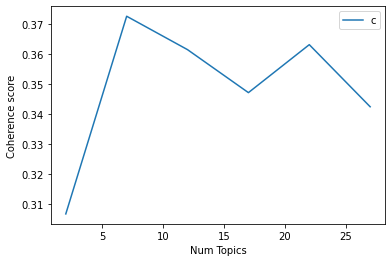

In [47]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3067
index: 1 | Num Topics = 7  has Coherence Value of 0.3725
index: 2 | Num Topics = 12  has Coherence Value of 0.3614
index: 3 | Num Topics = 17  has Coherence Value of 0.3471
index: 4 | Num Topics = 22  has Coherence Value of 0.3631
index: 5 | Num Topics = 27  has Coherence Value of 0.3424


In [172]:
# Select optimal number of topics
optimal_model_ph_score1 = model_list_ph_score1[1]

In [173]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score1 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score1, corpus_ph_score1, id2word_ph_score1)

In [174]:
print("pyLDAVis for ph topics for score=1:")
vis_ph_score1

pyLDAVis for ph topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.093603  0.077866       1        1  21.734987
0      0.077811  0.072721       2        1  21.620048
3     -0.228204  0.073298       3        1  15.666409
2     -0.123480  0.015321       4        1  15.355362
4      0.153303  0.066375       5        1  15.280380
1     -0.018432 -0.146784       6        1   6.068059
5      0.045399 -0.158797       7        1   4.274754, topic_info=       Term        Freq       Total Category  logprob  loglift
70     view  441.000000  441.000000  Default  30.0000  30.0000
20    video  327.000000  327.000000  Default  29.0000  29.0000
88       ad   89.000000   89.000000  Default  28.0000  28.0000
233  delete  274.000000  274.000000  Default  27.0000  27.0000
39     play   70.000000   70.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
484     bot    2.412980   24.517560   Topic7  -5.0213   0.8339
40    still    2.531913   42.739764   Topic7  -4.9732   0.3263
15     show    2.147365   29.998659   Topic7  -5.1379   0.5155
92     work    2.425879  103.485079   Topic7  -5.0160  -0.6008
70     view    2.186501  441.121432   Topic7  -5.1199  -2.1546

[459 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
439       1  0.946435  achieve
320       2  0.803852   action
320       7  0.200963   action
88        1  0.011116       ad
88        2  0.266787       ad
...     ...       ...      ...
121       1  0.204860       yt
121       3  0.102430       yt
121       5  0.460935       yt
121       6  0.153645       yt
812       5  0.781458    ytbre

[795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 4, 3, 5, 2, 6])

## LDA Topic Modelling (Rating = 2)

In [52]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_ph_score2 = youtube_ios_ph_review_YearMonth_score2.review.values.tolist()
review_words_ph_score2 = list(sent_to_words(review_ph_score2))
print(review_words_ph_score2[:1])

[['please', 'just', 'please', 'bring', 'back', 'fps', 'video', 'option', 'ive', 'been', 'using', 'this', 'app', 'all', 'the', 'time', 'and', 'its', 'still', 'really', 'good', 'except', 'for', 'the', 'fps', 'option', 'on', 'iphone', 'devs', 'please', 'bring', 'the', 'option']]


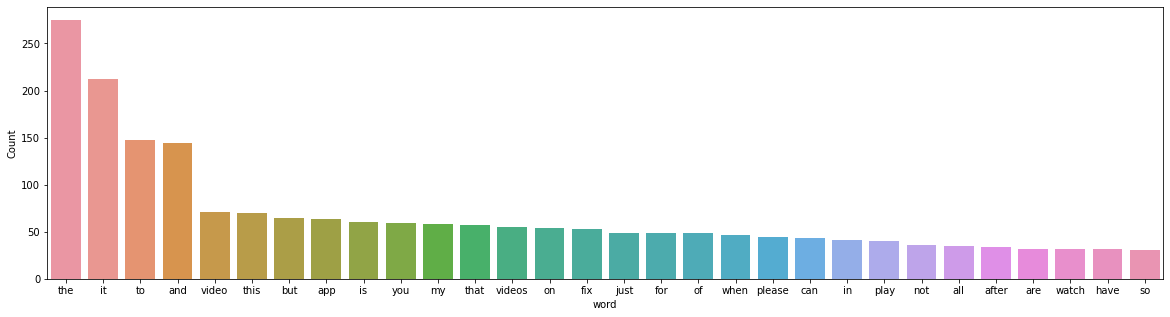

In [53]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score2))

In [54]:
# Clean text
review_ph_ready_score2 = process_words(review_words_ph_score2)  # processed Text Data! - move to each section


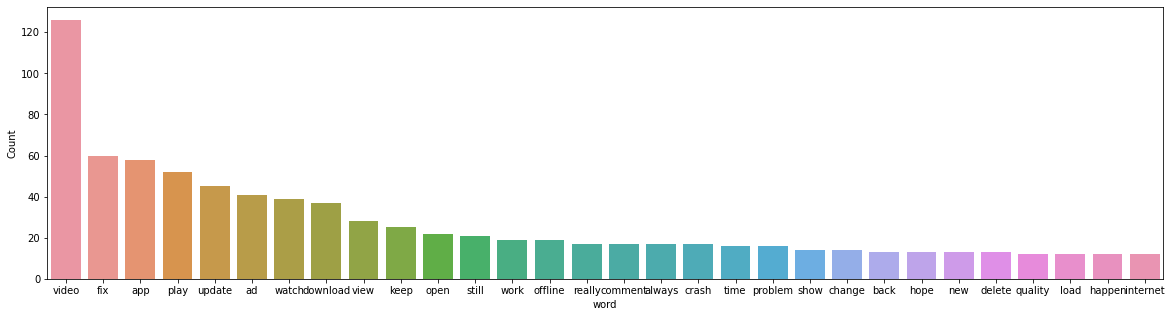

In [55]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score2))


In [56]:
# Create Dictionary
id2word_ph_score2 = corpora.Dictionary(review_ph_ready_score2)

2021-10-17 00:02:21,620 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:02:21,636 [INFO] gensim.corpora.dictionary - built Dictionary(674 unique tokens: ['app', 'back', 'bring', 'devs', 'fps']...) from 162 documents (total 2160 corpus positions)
2021-10-17 00:02:21,644 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(674 unique tokens: ['app', 'back', 'bring', 'devs', 'fps']...) from 162 documents (total 2160 corpus positions)", 'datetime': '2021-10-17T00:02:21.644534', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [57]:
# Create Corpus: Term Document Frequency
corpus_ph_score2 = [id2word_ph_score2.doc2bow(text) for text in review_ph_ready_score2]

In [58]:
# Training LDA model
model_list_ph_score2, coherence_values_ph_score2 = compute_coherence_values(dictionary=id2word_ph_score2, corpus=corpus_ph_score2, 
                                                              texts=review_ph_ready_score2, limit=30, start=2, step=5)


2021-10-17 00:02:21,734 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:02:21,737 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:02:21,742 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:02:21,745 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 162 documents, updating model once every 162 documents, evaluating perplexity every 162 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:02:22,709 [INFO] gensim.models.ldamodel - -7.143 per-word bound, 141.3 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:02:22,716 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #162/162
2021-10-17 00:02:23,521 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"video" + 0.028*"fix" + 0.024*"play" + 0.019*"watch" + 0.016*"update" + 0.015*"ad" + 0.015*"downlo

2021-10-17 00:02:30,795 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"video" + 0.033*"app" + 0.017*"fix" + 0.017*"download" + 0.016*"update" + 0.015*"view" + 0.012*"play" + 0.012*"open" + 0.011*"offline" + 0.011*"keep"
2021-10-17 00:02:30,798 [INFO] gensim.models.ldamodel - topic diff=0.008598, rho=0.301511
2021-10-17 00:02:31,331 [INFO] gensim.models.ldamodel - -6.109 per-word bound, 69.0 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:02:31,335 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #162/162
2021-10-17 00:02:31,659 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.047*"video" + 0.028*"play" + 0.028*"fix" + 0.026*"ad" + 0.023*"watch" + 0.016*"update" + 0.009*"work" + 0.009*"download" + 0.008*"remove" + 0.008*"quality"
2021-10-17 00:02:31,661 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"video" + 0.033*"app" + 0.017*"fix" + 0.017*"download" + 0.016*"update" + 0.015*"view" + 0.012*"play" + 0.01

2021-10-17 00:02:37,830 [INFO] gensim.models.ldamodel - topic diff=0.004570, rho=0.218218
2021-10-17 00:02:38,145 [INFO] gensim.models.ldamodel - -6.103 per-word bound, 68.7 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:02:38,146 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #162/162
2021-10-17 00:02:38,341 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.047*"video" + 0.030*"ad" + 0.028*"play" + 0.026*"fix" + 0.023*"watch" + 0.016*"update" + 0.009*"work" + 0.008*"remove" + 0.008*"annoying" + 0.007*"quality"
2021-10-17 00:02:38,345 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"video" + 0.033*"app" + 0.020*"download" + 0.018*"fix" + 0.017*"update" + 0.015*"view" + 0.012*"open" + 0.012*"offline" + 0.012*"play" + 0.011*"keep"
2021-10-17 00:02:38,349 [INFO] gensim.models.ldamodel - topic diff=0.004420, rho=0.213201
2021-10-17 00:02:38,647 [INFO] gensim.models.ldamodel - -6.102 per-word bound, 68.7 perplexity est

2021-10-17 00:02:43,045 [INFO] gensim.models.ldamodel - -6.098 per-word bound, 68.5 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:02:43,047 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #162/162
2021-10-17 00:02:43,256 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.047*"video" + 0.032*"ad" + 0.028*"play" + 0.026*"fix" + 0.022*"watch" + 0.015*"update" + 0.008*"work" + 0.008*"remove" + 0.008*"annoying" + 0.007*"quality"
2021-10-17 00:02:43,258 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"video" + 0.033*"app" + 0.021*"download" + 0.019*"fix" + 0.017*"update" + 0.015*"view" + 0.012*"open" + 0.012*"offline" + 0.012*"play" + 0.011*"keep"
2021-10-17 00:02:43,260 [INFO] gensim.models.ldamodel - topic diff=0.003175, rho=0.176777
2021-10-17 00:02:43,549 [INFO] gensim.models.ldamodel - -6.097 per-word bound, 68.5 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:02:43,551 

2021-10-17 00:02:48,412 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #162/162
2021-10-17 00:02:48,592 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"video" + 0.033*"ad" + 0.028*"play" + 0.025*"fix" + 0.022*"watch" + 0.015*"update" + 0.008*"remove" + 0.008*"annoying" + 0.008*"work" + 0.007*"quality"
2021-10-17 00:02:48,596 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"video" + 0.033*"app" + 0.022*"download" + 0.019*"fix" + 0.017*"update" + 0.015*"view" + 0.012*"open" + 0.012*"play" + 0.012*"offline" + 0.011*"keep"
2021-10-17 00:02:48,598 [INFO] gensim.models.ldamodel - topic diff=0.002249, rho=0.154303
2021-10-17 00:02:48,902 [INFO] gensim.models.ldamodel - -6.095 per-word bound, 68.4 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:02:48,904 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #162/162
2021-10-17 00:02:49,155 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"video" + 0.

2021-10-17 00:02:53,053 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:02:58,292 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:02:58,324 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 157 virtual documents
2021-10-17 00:02:58,831 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:02:58,836 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:02:58,847 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:02:58,853 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 162 documents, updating model once every 162 documents, evaluating perplexity every 162 documents, iterating 50x with a con

2021-10-17 00:03:02,210 [INFO] gensim.models.ldamodel - topic diff=0.049995, rho=0.408248
2021-10-17 00:03:02,525 [INFO] gensim.models.ldamodel - -6.371 per-word bound, 82.8 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:02,528 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #162/162
2021-10-17 00:03:02,682 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.033*"app" + 0.025*"update" + 0.017*"new" + 0.014*"video" + 0.013*"keep" + 0.013*"premium" + 0.013*"crash" + 0.013*"issue" + 0.012*"second" + 0.010*"io"
2021-10-17 00:03:02,685 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.051*"view" + 0.025*"watch" + 0.022*"video" + 0.020*"delete" + 0.019*"time" + 0.018*"always" + 0.016*"update" + 0.013*"day" + 0.013*"open" + 0.012*"fix"
2021-10-17 00:03:02,690 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.098*"video" + 0.052*"download" + 0.040*"fix" + 0.022*"watch" + 0.020*"ad" + 0.020*"offline" + 0.018*"play" + 0.014*"cap

2021-10-17 00:03:04,831 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.074*"video" + 0.048*"play" + 0.024*"ad" + 0.021*"show" + 0.019*"fix" + 0.017*"still" + 0.014*"comment" + 0.012*"thing" + 0.010*"update" + 0.010*"view"
2021-10-17 00:03:04,833 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.101*"video" + 0.055*"download" + 0.040*"fix" + 0.023*"watch" + 0.020*"ad" + 0.020*"offline" + 0.018*"play" + 0.014*"caption" + 0.014*"problem" + 0.013*"error"
2021-10-17 00:03:04,836 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.051*"view" + 0.025*"watch" + 0.022*"video" + 0.021*"delete" + 0.019*"time" + 0.017*"always" + 0.016*"update" + 0.013*"day" + 0.013*"open" + 0.012*"fix"
2021-10-17 00:03:04,837 [INFO] gensim.models.ldamodel - topic diff=0.008655, rho=0.288675
2021-10-17 00:03:05,159 [INFO] gensim.models.ldamodel - -6.355 per-word bound, 81.8 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:05,164 [INFO] gensim.models.ldamodel - 

2021-10-17 00:03:07,416 [INFO] gensim.models.ldamodel - -6.351 per-word bound, 81.6 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:07,419 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #162/162
2021-10-17 00:03:07,548 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"watch" + 0.026*"history" + 0.019*"change" + 0.019*"ad" + 0.013*"reload" + 0.013*"post" + 0.013*"name" + 0.013*"hour" + 0.013*"keep" + 0.013*"video"
2021-10-17 00:03:07,550 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"fix" + 0.027*"video" + 0.021*"play" + 0.018*"work" + 0.016*"quality" + 0.014*"update" + 0.014*"remove" + 0.013*"content" + 0.012*"ad" + 0.012*"really"
2021-10-17 00:03:07,552 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.074*"video" + 0.047*"play" + 0.022*"show" + 0.019*"ad" + 0.019*"fix" + 0.017*"still" + 0.014*"comment" + 0.012*"thing" + 0.010*"download" + 0.010*"view"
2021-10-17 00:03:07,553 [INFO] gensim.models.ldamo

2021-10-17 00:03:09,695 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.104*"video" + 0.058*"download" + 0.039*"fix" + 0.025*"watch" + 0.021*"offline" + 0.021*"ad" + 0.018*"play" + 0.015*"caption" + 0.014*"problem" + 0.013*"error"
2021-10-17 00:03:09,707 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"app" + 0.026*"update" + 0.018*"new" + 0.013*"video" + 0.013*"premium" + 0.013*"issue" + 0.013*"crash" + 0.013*"keep" + 0.011*"already" + 0.010*"show"
2021-10-17 00:03:09,721 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"fix" + 0.027*"video" + 0.021*"play" + 0.018*"work" + 0.016*"quality" + 0.014*"update" + 0.014*"remove" + 0.013*"content" + 0.012*"annoying" + 0.012*"really"
2021-10-17 00:03:09,723 [INFO] gensim.models.ldamodel - topic diff=0.002151, rho=0.208514
2021-10-17 00:03:09,896 [INFO] gensim.models.ldamodel - -6.348 per-word bound, 81.5 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:09,901 [INFO] gensim.mode

2021-10-17 00:03:11,932 [INFO] gensim.models.ldamodel - topic diff=0.001392, rho=0.188982
2021-10-17 00:03:12,101 [INFO] gensim.models.ldamodel - -6.347 per-word bound, 81.4 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:12,103 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #162/162
2021-10-17 00:03:12,278 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"fix" + 0.027*"video" + 0.021*"play" + 0.018*"work" + 0.016*"quality" + 0.014*"update" + 0.014*"remove" + 0.013*"content" + 0.012*"annoying" + 0.012*"really"
2021-10-17 00:03:12,291 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.105*"video" + 0.058*"download" + 0.039*"fix" + 0.025*"watch" + 0.022*"ad" + 0.022*"offline" + 0.018*"play" + 0.015*"caption" + 0.014*"problem" + 0.013*"error"
2021-10-17 00:03:12,311 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.037*"app" + 0.027*"update" + 0.018*"new" + 0.014*"video" + 0.014*"premium" + 0.014*"issue" + 0.012*"a

2021-10-17 00:03:14,313 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.053*"app" + 0.041*"video" + 0.027*"update" + 0.023*"ad" + 0.022*"fix" + 0.019*"crash" + 0.018*"play" + 0.018*"open" + 0.013*"keep" + 0.012*"download"
2021-10-17 00:03:14,315 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.051*"view" + 0.026*"watch" + 0.022*"video" + 0.021*"delete" + 0.019*"time" + 0.016*"update" + 0.015*"always" + 0.013*"day" + 0.013*"offline" + 0.013*"hope"
2021-10-17 00:03:14,317 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.074*"video" + 0.047*"play" + 0.022*"show" + 0.019*"fix" + 0.017*"ad" + 0.017*"still" + 0.014*"comment" + 0.012*"thing" + 0.010*"back" + 0.010*"thumbnail"
2021-10-17 00:03:14,319 [INFO] gensim.models.ldamodel - topic diff=0.000731, rho=0.171499
2021-10-17 00:03:14,575 [INFO] gensim.models.ldamodel - -6.346 per-word bound, 81.3 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:14,578 [INFO] gensim.models.ldamodel - PR

2021-10-17 00:03:16,719 [INFO] gensim.models.ldamodel - topic diff=0.000489, rho=0.160128
2021-10-17 00:03:16,992 [INFO] gensim.models.ldamodel - -6.345 per-word bound, 81.3 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:16,993 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #162/162
2021-10-17 00:03:17,171 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.051*"view" + 0.026*"watch" + 0.022*"video" + 0.021*"delete" + 0.019*"time" + 0.016*"update" + 0.015*"always" + 0.013*"day" + 0.013*"offline" + 0.013*"hope"
2021-10-17 00:03:17,173 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.074*"video" + 0.047*"play" + 0.022*"show" + 0.019*"fix" + 0.017*"ad" + 0.017*"still" + 0.014*"comment" + 0.012*"thing" + 0.010*"back" + 0.010*"thumbnail"
2021-10-17 00:03:17,176 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.030*"watch" + 0.026*"history" + 0.020*"change" + 0.014*"post" + 0.013*"hour" + 0.013*"reload" + 0.013*"name" + 0

2021-10-17 00:03:19,194 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.074*"video" + 0.047*"play" + 0.022*"show" + 0.019*"fix" + 0.017*"ad" + 0.017*"still" + 0.014*"comment" + 0.012*"thing" + 0.010*"back" + 0.010*"thumbnail"
2021-10-17 00:03:19,196 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.051*"view" + 0.026*"watch" + 0.022*"video" + 0.021*"delete" + 0.019*"time" + 0.016*"update" + 0.015*"always" + 0.013*"day" + 0.013*"offline" + 0.013*"hope"
2021-10-17 00:03:19,199 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.053*"app" + 0.041*"video" + 0.027*"update" + 0.023*"ad" + 0.022*"fix" + 0.019*"crash" + 0.018*"play" + 0.017*"open" + 0.013*"keep" + 0.012*"download"
2021-10-17 00:03:19,200 [INFO] gensim.models.ldamodel - topic diff=0.000242, rho=0.149071
2021-10-17 00:03:19,420 [INFO] gensim.models.ldamodel - -6.345 per-word bound, 81.3 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:19,422 [INFO] gensim.models.ldamodel - PR

2021-10-17 00:03:21,454 [INFO] gensim.models.ldamodel - topic diff=0.000182, rho=0.141421
2021-10-17 00:03:21,744 [INFO] gensim.models.ldamodel - -6.345 per-word bound, 81.3 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:21,761 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #162/162
2021-10-17 00:03:21,916 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.030*"watch" + 0.026*"history" + 0.020*"change" + 0.014*"post" + 0.014*"hour" + 0.014*"reload" + 0.014*"name" + 0.013*"keep" + 0.012*"ad" + 0.008*"video"
2021-10-17 00:03:21,918 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"app" + 0.027*"update" + 0.018*"new" + 0.014*"premium" + 0.014*"issue" + 0.014*"video" + 0.012*"already" + 0.012*"show" + 0.010*"crash" + 0.009*"keep"
2021-10-17 00:03:21,920 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.053*"app" + 0.041*"video" + 0.027*"update" + 0.023*"ad" + 0.022*"fix" + 0.019*"crash" + 0.018*"play" + 0.017*"open

2021-10-17 00:03:33,025 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.089*"video" + 0.053*"play" + 0.025*"show" + 0.021*"ad" + 0.020*"fix" + 0.015*"update" + 0.014*"still" + 0.013*"app" + 0.012*"stop" + 0.012*"thumbnail"
2021-10-17 00:03:33,027 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.041*"content" + 0.020*"instead" + 0.019*"app" + 0.014*"update" + 0.014*"comment" + 0.014*"reply" + 0.014*"help" + 0.014*"view" + 0.013*"recommend" + 0.008*"fix"
2021-10-17 00:03:33,029 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.039*"video" + 0.028*"update" + 0.019*"io" + 0.019*"play" + 0.019*"fix" + 0.019*"problem" + 0.019*"memory" + 0.010*"new" + 0.010*"issue" + 0.010*"frequently"
2021-10-17 00:03:33,030 [INFO] gensim.models.ldamodel - topic diff=0.110543, rho=0.447214
2021-10-17 00:03:33,302 [INFO] gensim.models.ldamodel - -6.530 per-word bound, 92.4 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:33,303 [INFO] gensim.models.lda

2021-10-17 00:03:35,053 [INFO] gensim.models.ldamodel - topic diff=0.026112, rho=0.316228
2021-10-17 00:03:35,236 [INFO] gensim.models.ldamodel - -6.482 per-word bound, 89.4 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:35,240 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #162/162
2021-10-17 00:03:35,402 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"ad" + 0.036*"video" + 0.016*"sometimes" + 0.016*"load" + 0.016*"comment" + 0.016*"open" + 0.016*"annoying" + 0.016*"view" + 0.014*"remove" + 0.012*"new"
2021-10-17 00:03:35,404 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.093*"video" + 0.053*"play" + 0.026*"ad" + 0.026*"show" + 0.019*"fix" + 0.017*"update" + 0.013*"thing" + 0.013*"change" + 0.013*"thumbnail" + 0.013*"app"
2021-10-17 00:03:35,409 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.036*"history" + 0.033*"watch" + 0.026*"change" + 0.018*"keep" + 0.018*"post" + 0.018*"name" + 0.018*"hour" + 0.0

2021-10-17 00:03:37,410 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.036*"history" + 0.033*"watch" + 0.026*"change" + 0.018*"keep" + 0.018*"post" + 0.018*"name" + 0.018*"hour" + 0.018*"reload" + 0.017*"play" + 0.010*"full"
2021-10-17 00:03:37,412 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.051*"app" + 0.035*"update" + 0.027*"video" + 0.023*"open" + 0.022*"fix" + 0.014*"work" + 0.013*"setting" + 0.013*"anymore" + 0.012*"bug" + 0.012*"play"
2021-10-17 00:03:37,415 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.055*"ad" + 0.034*"video" + 0.027*"crash" + 0.027*"app" + 0.026*"keep" + 0.023*"fix" + 0.022*"watch" + 0.022*"play" + 0.020*"quality" + 0.016*"update"
2021-10-17 00:03:37,417 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"video" + 0.049*"fix" + 0.028*"work" + 0.026*"play" + 0.022*"download" + 0.022*"update" + 0.017*"keep" + 0.017*"time" + 0.017*"quality" + 0.016*"really"
2021-10-17 00:03:37,419 [INFO] gensim.models.ldamodel - topic diff=0.007439, rho=0.

2021-10-17 00:03:39,630 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.051*"app" + 0.034*"update" + 0.027*"video" + 0.023*"open" + 0.022*"fix" + 0.014*"work" + 0.013*"setting" + 0.013*"anymore" + 0.012*"bug" + 0.012*"play"
2021-10-17 00:03:39,634 [INFO] gensim.models.ldamodel - topic diff=0.003894, rho=0.218218
2021-10-17 00:03:39,831 [INFO] gensim.models.ldamodel - -6.463 per-word bound, 88.2 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:39,832 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #162/162
2021-10-17 00:03:40,032 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"ad" + 0.032*"video" + 0.017*"sometimes" + 0.017*"load" + 0.017*"comment" + 0.017*"open" + 0.017*"annoying" + 0.017*"view" + 0.017*"remove" + 0.012*"new"
2021-10-17 00:03:40,033 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.055*"ad" + 0.034*"video" + 0.027*"crash" + 0.026*"app" + 0.026*"keep" + 0.024*"play" + 0.023*"fix" + 0.022*"watc

2021-10-17 00:03:42,041 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.087*"view" + 0.034*"delete" + 0.027*"video" + 0.024*"music" + 0.024*"time" + 0.017*"watch" + 0.016*"stream" + 0.013*"update" + 0.012*"regard" + 0.012*"disappear"
2021-10-17 00:03:42,044 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.052*"video" + 0.049*"fix" + 0.029*"work" + 0.026*"play" + 0.021*"download" + 0.021*"update" + 0.017*"keep" + 0.017*"time" + 0.017*"quality" + 0.017*"really"
2021-10-17 00:03:42,045 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"ad" + 0.030*"video" + 0.017*"sometimes" + 0.017*"comment" + 0.017*"load" + 0.017*"open" + 0.017*"annoying" + 0.017*"view" + 0.017*"remove" + 0.012*"new"
2021-10-17 00:03:42,047 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.055*"ad" + 0.035*"video" + 0.026*"crash" + 0.026*"app" + 0.025*"keep" + 0.024*"play" + 0.023*"fix" + 0.022*"watch" + 0.020*"quality" + 0.016*"change"
2021-10-17 00:03:42,049 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-17 00:03:44,021 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.047*"ad" + 0.029*"video" + 0.017*"comment" + 0.017*"load" + 0.017*"open" + 0.017*"sometimes" + 0.017*"annoying" + 0.017*"view" + 0.017*"remove" + 0.012*"new"
2021-10-17 00:03:44,023 [INFO] gensim.models.ldamodel - topic diff=0.001646, rho=0.176777
2021-10-17 00:03:44,228 [INFO] gensim.models.ldamodel - -6.455 per-word bound, 87.7 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:44,232 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #162/162
2021-10-17 00:03:44,387 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.038*"video" + 0.029*"update" + 0.019*"io" + 0.019*"play" + 0.019*"problem" + 0.019*"fix" + 0.019*"memory" + 0.010*"new" + 0.010*"issue" + 0.010*"frequently"
2021-10-17 00:03:44,393 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.049*"app" + 0.032*"update" + 0.027*"video" + 0.023*"open" + 0.022*"fix" + 0.014*"work" + 0.013*"setting" + 

2021-10-17 00:03:46,403 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.049*"app" + 0.032*"update" + 0.027*"video" + 0.023*"open" + 0.022*"fix" + 0.014*"work" + 0.013*"setting" + 0.013*"anymore" + 0.012*"bug" + 0.012*"play"
2021-10-17 00:03:46,404 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.052*"video" + 0.049*"fix" + 0.029*"work" + 0.026*"play" + 0.021*"download" + 0.021*"update" + 0.017*"keep" + 0.017*"quality" + 0.017*"time" + 0.017*"really"
2021-10-17 00:03:46,406 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.038*"video" + 0.029*"update" + 0.019*"problem" + 0.019*"play" + 0.019*"io" + 0.019*"fix" + 0.019*"memory" + 0.010*"new" + 0.010*"space" + 0.010*"issue"
2021-10-17 00:03:46,409 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.094*"video" + 0.051*"play" + 0.028*"ad" + 0.021*"show" + 0.018*"fix" + 0.015*"change" + 0.015*"thing" + 0.015*"thumbnail" + 0.013*"app" + 0.012*"stop"
2021-10-17 00:03:46,410 [INFO] gensim.models.ldamodel - topic diff=0.001141, rho=0.1

2021-10-17 00:03:48,658 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.057*"app" + 0.037*"video" + 0.027*"update" + 0.025*"fix" + 0.022*"crash" + 0.019*"play" + 0.018*"open" + 0.017*"download" + 0.016*"still" + 0.015*"problem"
2021-10-17 00:03:48,659 [INFO] gensim.models.ldamodel - topic diff=0.000917, rho=0.152499
2021-10-17 00:03:48,889 [INFO] gensim.models.ldamodel - -6.452 per-word bound, 87.6 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:03:48,891 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #162/162
2021-10-17 00:03:49,116 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.087*"view" + 0.034*"delete" + 0.027*"video" + 0.024*"music" + 0.024*"time" + 0.017*"watch" + 0.016*"stream" + 0.013*"update" + 0.013*"hope" + 0.012*"regard"
2021-10-17 00:03:49,122 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"content" + 0.020*"instead" + 0.020*"app" + 0.016*"comment" + 0.015*"view" + 0.015*"update" + 0.014*"hel

2021-10-17 00:03:51,512 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.038*"video" + 0.029*"update" + 0.019*"problem" + 0.019*"play" + 0.019*"fix" + 0.019*"io" + 0.019*"memory" + 0.010*"space" + 0.010*"upload" + 0.010*"late"
2021-10-17 00:03:51,515 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.047*"content" + 0.020*"instead" + 0.020*"app" + 0.016*"comment" + 0.015*"view" + 0.015*"update" + 0.014*"help" + 0.014*"reply" + 0.014*"recommend" + 0.014*"tube"
2021-10-17 00:03:51,518 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.085*"video" + 0.066*"download" + 0.048*"offline" + 0.034*"fix" + 0.023*"ad" + 0.022*"internet" + 0.020*"watch" + 0.020*"error" + 0.016*"always" + 0.015*"caption"
2021-10-17 00:03:51,520 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.052*"video" + 0.049*"fix" + 0.029*"work" + 0.027*"play" + 0.021*"download" + 0.021*"update" + 0.017*"keep" + 0.017*"quality" + 0.017*"time" + 0.017*"really"
2021-10-17 00:03:51,522 [INFO] gensim.models.ldamodel - topi

2021-10-17 00:04:02,317 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.036*"video" + 0.027*"thing" + 0.027*"change" + 0.019*"update" + 0.019*"io" + 0.019*"stop" + 0.018*"thumbnail" + 0.018*"back" + 0.012*"one" + 0.011*"refresh"
2021-10-17 00:04:02,319 [INFO] gensim.models.ldamodel - topic diff=0.121178, rho=0.577350
2021-10-17 00:04:02,586 [INFO] gensim.models.ldamodel - -6.636 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:02,588 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #162/162
2021-10-17 00:04:02,759 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.043*"load" + 0.033*"sometimes" + 0.033*"video" + 0.022*"error" + 0.022*"problem" + 0.022*"fix" + 0.022*"download" + 0.021*"count" + 0.021*"fan" + 0.020*"view"
2021-10-17 00:04:02,760 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.039*"comment" + 0.026*"click" + 0.026*"premium" + 0.026*"fix" + 0.026*"reply" + 0.026*"user" + 0.026*"pic

2021-10-17 00:04:05,165 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.070*"video" + 0.032*"play" + 0.032*"still" + 0.027*"download" + 0.026*"update" + 0.022*"show" + 0.018*"app" + 0.016*"work" + 0.016*"menu" + 0.011*"give"
2021-10-17 00:04:05,167 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.066*"view" + 0.043*"delete" + 0.018*"video" + 0.016*"yt" + 0.015*"error" + 0.014*"regard" + 0.014*"music" + 0.014*"stream" + 0.014*"fan" + 0.012*"watch"
2021-10-17 00:04:05,170 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.092*"video" + 0.059*"ad" + 0.055*"play" + 0.035*"app" + 0.035*"fix" + 0.027*"update" + 0.027*"watch" + 0.016*"keep" + 0.012*"crash" + 0.011*"still"
2021-10-17 00:04:05,172 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.046*"video" + 0.044*"fix" + 0.026*"download" + 0.024*"remove" + 0.024*"really" + 0.019*"work" + 0.015*"play" + 0.015*"bug" + 0.015*"understand" + 0.015*"update"
2021-10-17 00:04:05,173 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.039

2021-10-17 00:04:07,074 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.048*"fix" + 0.030*"play" + 0.024*"update" + 0.024*"version" + 0.018*"still" + 0.018*"work" + 0.018*"keep" + 0.018*"io" + 0.018*"bug" + 0.012*"phone"
2021-10-17 00:04:07,076 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.045*"video" + 0.043*"fix" + 0.024*"remove" + 0.024*"really" + 0.022*"download" + 0.019*"work" + 0.015*"play" + 0.015*"bug" + 0.015*"understand" + 0.015*"update"
2021-10-17 00:04:07,078 [INFO] gensim.models.ldamodel - topic diff=0.007546, rho=0.267261
2021-10-17 00:04:07,320 [INFO] gensim.models.ldamodel - -6.535 per-word bound, 92.7 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:07,323 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #162/162
2021-10-17 00:04:07,493 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.045*"video" + 0.043*"fix" + 0.024*"remove" + 0.024*"really" + 0.021*"download" + 0.019*"work" + 0.015*"play" + 

2021-10-17 00:04:09,460 [INFO] gensim.models.ldamodel - -6.530 per-word bound, 92.4 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:09,531 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #162/162
2021-10-17 00:04:09,666 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.044*"video" + 0.043*"fix" + 0.024*"remove" + 0.024*"really" + 0.020*"work" + 0.019*"download" + 0.015*"play" + 0.015*"bug" + 0.015*"understand" + 0.015*"update"
2021-10-17 00:04:09,669 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.057*"app" + 0.023*"issue" + 0.023*"refresh" + 0.023*"update" + 0.023*"button" + 0.023*"video" + 0.012*"play" + 0.012*"show" + 0.012*"stop" + 0.012*"plz"
2021-10-17 00:04:09,670 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.053*"view" + 0.027*"video" + 0.027*"inappropriate" + 0.027*"minuse" + 0.027*"music" + 0.014*"button" + 0.014*"watch" + 0.014*"download" + 0.014*"keep" + 0.014*"abuse"
2021-10-17 00:04:09,673 [INFO]

2021-10-17 00:04:11,810 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.079*"view" + 0.044*"delete" + 0.019*"music" + 0.019*"stream" + 0.018*"yt" + 0.016*"video" + 0.015*"regard" + 0.015*"fan" + 0.012*"people" + 0.012*"time"
2021-10-17 00:04:11,811 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.048*"fix" + 0.030*"play" + 0.025*"update" + 0.024*"version" + 0.018*"still" + 0.018*"work" + 0.018*"keep" + 0.018*"io" + 0.018*"bug" + 0.014*"last"
2021-10-17 00:04:11,813 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.092*"video" + 0.059*"ad" + 0.055*"play" + 0.035*"app" + 0.034*"fix" + 0.027*"watch" + 0.027*"update" + 0.016*"keep" + 0.012*"crash" + 0.011*"still"
2021-10-17 00:04:11,814 [INFO] gensim.models.ldamodel - topic diff=0.001788, rho=0.200000
2021-10-17 00:04:12,163 [INFO] gensim.models.ldamodel - -6.526 per-word bound, 92.2 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:12,164 [INFO] gensim.models.ldamodel - PROGRESS: p

2021-10-17 00:04:14,293 [INFO] gensim.models.ldamodel - topic diff=0.001120, rho=0.182574
2021-10-17 00:04:14,625 [INFO] gensim.models.ldamodel - -6.523 per-word bound, 92.0 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:14,627 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #162/162
2021-10-17 00:04:14,822 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.048*"load" + 0.036*"sometimes" + 0.024*"fix" + 0.024*"count" + 0.024*"fan" + 0.024*"view" + 0.015*"problem" + 0.013*"video" + 0.012*"click" + 0.012*"online"
2021-10-17 00:04:14,825 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.092*"video" + 0.059*"ad" + 0.055*"play" + 0.035*"app" + 0.034*"fix" + 0.027*"watch" + 0.027*"update" + 0.016*"keep" + 0.012*"crash" + 0.011*"still"
2021-10-17 00:04:14,827 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.044*"quality" + 0.044*"disappear" + 0.039*"internet" + 0.029*"playlist" + 0.029*"crash" + 0.029*"app" + 0.024*"keep"

2021-10-17 00:04:18,256 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.104*"video" + 0.090*"download" + 0.060*"offline" + 0.036*"fix" + 0.033*"watch" + 0.026*"error" + 0.023*"always" + 0.019*"caption" + 0.015*"open" + 0.015*"already"
2021-10-17 00:04:18,288 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.035*"break" + 0.035*"shuffle" + 0.018*"crash" + 0.018*"randomly" + 0.018*"keep" + 0.018*"disappear" + 0.018*"bright" + 0.018*"side" + 0.018*"watch" + 0.018*"storage"
2021-10-17 00:04:18,297 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.057*"app" + 0.026*"refresh" + 0.023*"update" + 0.023*"issue" + 0.023*"button" + 0.023*"video" + 0.015*"asap" + 0.013*"fix" + 0.012*"plz" + 0.012*"show"
2021-10-17 00:04:18,299 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.071*"video" + 0.033*"play" + 0.033*"still" + 0.027*"download" + 0.027*"show" + 0.022*"update" + 0.017*"app" + 0.016*"work" + 0.016*"menu" + 0.011*"offline"
2021-10-17 00:04:18,301 [INFO] gensim.models.ldamodel - to

2021-10-17 00:04:21,202 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.052*"setting" + 0.035*"default" + 0.018*"back" + 0.018*"always" + 0.018*"everytime" + 0.018*"set" + 0.018*"white" + 0.018*"turn" + 0.018*"reset" + 0.018*"background"
2021-10-17 00:04:21,202 [INFO] gensim.models.ldamodel - topic diff=0.000971, rho=0.156174
2021-10-17 00:04:21,440 [INFO] gensim.models.ldamodel - -6.520 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:21,442 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #162/162
2021-10-17 00:04:21,590 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.080*"view" + 0.043*"delete" + 0.019*"music" + 0.019*"stream" + 0.019*"yt" + 0.016*"video" + 0.015*"regard" + 0.015*"fan" + 0.013*"hour" + 0.013*"people"
2021-10-17 00:04:21,591 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.042*"video" + 0.042*"fix" + 0.025*"really" + 0.025*"remove" + 0.020*"work" + 0.015*"play" + 0.015*"und

2021-10-17 00:04:23,687 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.039*"comment" + 0.027*"user" + 0.027*"picture" + 0.027*"premium" + 0.027*"reply" + 0.027*"fix" + 0.027*"click" + 0.014*"app" + 0.014*"available" + 0.014*"add"
2021-10-17 00:04:23,689 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"app" + 0.035*"open" + 0.025*"video" + 0.025*"really" + 0.022*"comment" + 0.018*"vid" + 0.016*"recommend" + 0.016*"crash" + 0.013*"fix" + 0.013*"iphone"
2021-10-17 00:04:23,691 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.043*"fix" + 0.030*"play" + 0.028*"update" + 0.024*"version" + 0.018*"still" + 0.018*"work" + 0.018*"keep" + 0.018*"io" + 0.018*"bug" + 0.018*"last"
2021-10-17 00:04:23,694 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.080*"view" + 0.043*"delete" + 0.019*"music" + 0.019*"stream" + 0.019*"yt" + 0.016*"video" + 0.015*"regard" + 0.015*"fan" + 0.014*"hour" + 0.013*"people"
2021-10-17 00:04:23,695 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.0

2021-10-17 00:04:35,188 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-17 00:04:35,192 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:04:35,198 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 162 documents, updating model once every 162 documents, evaluating perplexity every 162 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:04:35,764 [INFO] gensim.models.ldamodel - -19.259 per-word bound, 627539.4 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:35,766 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #162/162
2021-10-17 00:04:36,176 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.070*"video" + 0.027*"play" + 0.020*"today" + 0.020*"still" + 0.019*"update" + 0.016*"show" + 0.016*"app" + 0.015*"menu" + 0.015*"fix" + 0.014*"bug"
2021-10-17 00:04:

2021-10-17 00:04:38,067 [INFO] gensim.models.ldamodel - -6.645 per-word bound, 100.1 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:38,069 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #162/162
2021-10-17 00:04:38,205 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.048*"fix" + 0.047*"video" + 0.047*"play" + 0.025*"keep" + 0.024*"work" + 0.024*"internet" + 0.024*"load" + 0.024*"version" + 0.013*"update" + 0.013*"app"
2021-10-17 00:04:38,206 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.067*"history" + 0.066*"watch" + 0.034*"change" + 0.034*"reload" + 0.017*"pause" + 0.017*"broken" + 0.017*"anymore" + 0.017*"still" + 0.017*"account" + 0.017*"well"
2021-10-17 00:04:38,208 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.074*"download" + 0.070*"video" + 0.055*"offline" + 0.046*"fix" + 0.026*"watch" + 0.018*"button" + 0.018*"view" + 0.018*"play" + 0.018*"still" + 0.017*"internet"
2021-10-17 00:04:38,209 [INFO] ge

2021-10-17 00:04:40,048 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.034*"keep" + 0.017*"background" + 0.017*"storage" + 0.017*"break" + 0.017*"advertisement" + 0.017*"hope" + 0.017*"crash" + 0.017*"disappear" + 0.017*"watch" + 0.017*"play"
2021-10-17 00:04:40,049 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.065*"view" + 0.064*"ad" + 0.032*"annoying" + 0.022*"video" + 0.022*"regard" + 0.011*"fan" + 0.011*"unfair" + 0.011*"delete" + 0.011*"boy" + 0.011*"error"
2021-10-17 00:04:40,050 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.030*"download" + 0.030*"recommend" + 0.029*"video" + 0.016*"full" + 0.016*"storage" + 0.015*"absolutely" + 0.015*"freakin" + 0.015*"functional" + 0.015*"layout" + 0.015*"pad"
2021-10-17 00:04:40,051 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.045*"view" + 0.031*"video" + 0.023*"time" + 0.023*"comment" + 0.023*"delete" + 0.015*"watch" + 0.015*"internet" + 0.015*"problem" + 0.015*"button" + 0.015*"help"
2021-10-17 00:04:40,052 [INFO]

2021-10-17 00:04:41,695 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.039*"thing" + 0.039*"video" + 0.039*"change" + 0.026*"back" + 0.026*"thumbnail" + 0.013*"minute" + 0.013*"long" + 0.013*"advertisement" + 0.013*"almost" + 0.013*"stop"
2021-10-17 00:04:41,696 [INFO] gensim.models.ldamodel - topic diff=0.005268, rho=0.242536
2021-10-17 00:04:41,959 [INFO] gensim.models.ldamodel - -6.605 per-word bound, 97.3 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:41,961 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #162/162
2021-10-17 00:04:42,086 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.023*"work" + 0.023*"fix" + 0.018*"quality" + 0.018*"manage" + 0.018*"banner" + 0.018*"profile" + 0.018*"io" + 0.018*"bug" + 0.018*"last" + 0.012*"update"
2021-10-17 00:04:42,088 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.046*"view" + 0.031*"video" + 0.023*"time" + 0.023*"comment" + 0.023*"delete" + 0.015*"watch" + 0.0

2021-10-17 00:04:43,921 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.079*"app" + 0.039*"download" + 0.035*"open" + 0.029*"update" + 0.023*"fix" + 0.023*"still" + 0.020*"work" + 0.018*"close" + 0.017*"vid" + 0.017*"delete"
2021-10-17 00:04:43,923 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.049*"caption" + 0.045*"error" + 0.044*"video" + 0.039*"loading" + 0.033*"download" + 0.029*"view" + 0.020*"fan" + 0.020*"watch" + 0.020*"content" + 0.012*"fix"
2021-10-17 00:04:43,925 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.046*"view" + 0.031*"video" + 0.023*"time" + 0.023*"comment" + 0.023*"delete" + 0.015*"watch" + 0.015*"internet" + 0.015*"problem" + 0.015*"button" + 0.015*"help"
2021-10-17 00:04:43,927 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.051*"load" + 0.051*"keep" + 0.040*"video" + 0.039*"open" + 0.026*"name" + 0.026*"fix" + 0.026*"sometimes" + 0.026*"post" + 0.026*"change" + 0.026*"playlist"
2021-10-17 00:04:43,929 [INFO] gensim.models.ldamodel - topic #

2021-10-17 00:04:46,557 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.023*"work" + 0.023*"fix" + 0.018*"quality" + 0.018*"manage" + 0.018*"banner" + 0.018*"profile" + 0.018*"io" + 0.018*"bug" + 0.018*"last" + 0.012*"update"
2021-10-17 00:04:46,560 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.034*"keep" + 0.017*"crash" + 0.017*"full" + 0.017*"break" + 0.017*"disappear" + 0.017*"play" + 0.017*"feature" + 0.017*"download" + 0.017*"much" + 0.017*"side"
2021-10-17 00:04:46,561 [INFO] gensim.models.ldamodel - topic diff=0.001410, rho=0.188982
2021-10-17 00:04:46,849 [INFO] gensim.models.ldamodel - -6.599 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:46,851 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #162/162
2021-10-17 00:04:47,049 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.044*"update" + 0.029*"memory" + 0.029*"io" + 0.029*"available" + 0.029*"premium" + 0.029*"user" + 0.029*"p

2021-10-17 00:04:49,697 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #162/162
2021-10-17 00:04:49,920 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.073*"setting" + 0.047*"video" + 0.032*"recommend" + 0.032*"vid" + 0.032*"quality" + 0.021*"fix" + 0.021*"app" + 0.021*"change" + 0.021*"guy" + 0.021*"auto"
2021-10-17 00:04:49,926 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.023*"work" + 0.023*"fix" + 0.018*"quality" + 0.018*"manage" + 0.018*"banner" + 0.018*"profile" + 0.018*"io" + 0.018*"bug" + 0.018*"last" + 0.012*"update"
2021-10-17 00:04:49,928 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.044*"update" + 0.029*"memory" + 0.029*"io" + 0.029*"available" + 0.029*"premium" + 0.029*"user" + 0.029*"picture" + 0.015*"frequently" + 0.015*"upload" + 0.015*"late"
2021-10-17 00:04:49,929 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.046*"view" + 0.031*"video" + 0.023*"time" + 0.023*"comment" + 0.023*"delete" + 0.015*"watch" + 0.015*"internet" + 0.015*"p

2021-10-17 00:04:52,170 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.065*"view" + 0.065*"ad" + 0.033*"annoying" + 0.022*"video" + 0.022*"regard" + 0.011*"fan" + 0.011*"unfair" + 0.011*"delete" + 0.011*"boy" + 0.011*"error"
2021-10-17 00:04:52,172 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.045*"always" + 0.038*"video" + 0.036*"really" + 0.036*"ad" + 0.024*"app" + 0.018*"watch" + 0.018*"play" + 0.018*"back" + 0.018*"comment" + 0.018*"way"
2021-10-17 00:04:52,173 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.023*"work" + 0.023*"fix" + 0.018*"quality" + 0.018*"manage" + 0.018*"banner" + 0.018*"profile" + 0.018*"io" + 0.018*"bug" + 0.018*"last" + 0.012*"update"
2021-10-17 00:04:52,175 [INFO] gensim.models.ldamodel - topic diff=0.000824, rho=0.160128
2021-10-17 00:04:52,332 [INFO] gensim.models.ldamodel - -6.596 per-word bound, 96.7 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:52,337 [INFO] gensim.models.ldamodel - 

2021-10-17 00:04:54,154 [INFO] gensim.models.ldamodel - topic diff=0.000494, rho=0.150756
2021-10-17 00:04:54,420 [INFO] gensim.models.ldamodel - -6.594 per-word bound, 96.6 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:04:54,421 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #162/162
2021-10-17 00:04:54,599 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.036*"video" + 0.036*"app" + 0.024*"sometimes" + 0.024*"become" + 0.024*"sync" + 0.024*"shuffle" + 0.024*"update" + 0.012*"freeze" + 0.012*"download" + 0.012*"soon"
2021-10-17 00:04:54,604 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.039*"thing" + 0.039*"change" + 0.039*"video" + 0.026*"back" + 0.026*"thumbnail" + 0.013*"tolerate" + 0.013*"eye" + 0.013*"different" + 0.013*"arrange" + 0.013*"new"
2021-10-17 00:04:54,608 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.040*"delete" + 0.021*"disappointing" + 0.021*"mere" + 0.021*"view" + 0.021*"help" + 0.021*"

2021-10-17 00:04:56,428 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.032*"recommend" + 0.032*"video" + 0.016*"absolutely" + 0.016*"freakin" + 0.016*"layout" + 0.016*"functional" + 0.016*"coccyx" + 0.016*"pad" + 0.016*"browser" + 0.016*"pain"
2021-10-17 00:04:56,429 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.040*"delete" + 0.021*"disappointing" + 0.021*"mere" + 0.021*"view" + 0.021*"help" + 0.021*"stream" + 0.021*"group" + 0.021*"people" + 0.021*"late" + 0.021*"sleep"
2021-10-17 00:04:56,430 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.044*"update" + 0.029*"memory" + 0.029*"io" + 0.029*"available" + 0.029*"premium" + 0.029*"user" + 0.029*"picture" + 0.015*"hardware" + 0.015*"frequently" + 0.015*"remain"
2021-10-17 00:04:56,432 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.046*"always" + 0.038*"video" + 0.036*"really" + 0.036*"ad" + 0.024*"app" + 0.018*"play" + 0.018*"watch" + 0.018*"comment" + 0.018*"back" + 0.018*"way"
2021-10-17 00:04:56,433 [INFO] gens

2021-10-17 00:05:09,732 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.089*"view" + 0.035*"video" + 0.024*"delete" + 0.024*"fan" + 0.017*"regard" + 0.017*"version" + 0.017*"new" + 0.016*"unfair" + 0.016*"comment" + 0.016*"boy"
2021-10-17 00:05:09,733 [INFO] gensim.models.ldamodel - topic diff=0.089998, rho=0.500000
2021-10-17 00:05:09,952 [INFO] gensim.models.ldamodel - -6.776 per-word bound, 109.6 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:05:09,961 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #162/162
2021-10-17 00:05:10,082 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.047*"fix" + 0.042*"video" + 0.036*"really" + 0.027*"ad" + 0.026*"update" + 0.021*"way" + 0.021*"selection" + 0.020*"time" + 0.020*"yt" + 0.019*"download"
2021-10-17 00:05:10,083 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.038*"remove" + 0.028*"app" + 0.028*"spend" + 0.028*"understand" + 0.015*"video" + 0.015*"reinstall" + 0.015*"al

2021-10-17 00:05:11,691 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.086*"video" + 0.061*"download" + 0.041*"offline" + 0.033*"watch" + 0.025*"view" + 0.025*"vid" + 0.024*"whenever" + 0.019*"button" + 0.017*"somewhere" + 0.017*"library"
2021-10-17 00:05:11,693 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.038*"offline" + 0.032*"shuffle" + 0.032*"always" + 0.032*"watch" + 0.032*"library" + 0.032*"work" + 0.020*"error" + 0.017*"download" + 0.017*"fix" + 0.017*"video"
2021-10-17 00:05:11,697 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.040*"premium" + 0.040*"user" + 0.040*"picture" + 0.020*"experience" + 0.020*"least" + 0.020*"app" + 0.020*"feature" + 0.020*"give" + 0.020*"star" + 0.020*"pay"
2021-10-17 00:05:11,699 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.051*"keep" + 0.051*"update" + 0.031*"memory" + 0.031*"show" + 0.031*"caption" + 0.031*"hope" + 0.018*"crash" + 0.017*"app" + 0.016*"check" + 0.016*"video"
2021-10-17 00:05:11,701 [INFO] gensim.models.ld

2021-10-17 00:05:13,388 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.093*"view" + 0.034*"video" + 0.025*"delete" + 0.025*"fan" + 0.017*"regard" + 0.017*"new" + 0.017*"version" + 0.017*"unfair" + 0.017*"comment" + 0.017*"boy"
2021-10-17 00:05:13,390 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.053*"fix" + 0.043*"video" + 0.040*"really" + 0.033*"update" + 0.027*"ad" + 0.022*"time" + 0.020*"selection" + 0.020*"way" + 0.020*"yt" + 0.020*"fun"
2021-10-17 00:05:13,392 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.027*"video" + 0.027*"premium" + 0.027*"whyyyyy" + 0.027*"quality" + 0.027*"high" + 0.027*"available" + 0.027*"edition" + 0.027*"community" + 0.027*"download" + 0.027*"anymore"
2021-10-17 00:05:13,393 [INFO] gensim.models.ldamodel - topic diff=0.006987, rho=0.258199
2021-10-17 00:05:13,576 [INFO] gensim.models.ldamodel - -6.675 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:05:13,577 [INFO] gen

2021-10-17 00:05:15,309 [INFO] gensim.models.ldamodel - topic diff=0.003003, rho=0.223607
2021-10-17 00:05:15,548 [INFO] gensim.models.ldamodel - -6.672 per-word bound, 101.9 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:05:15,549 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #162/162
2021-10-17 00:05:15,700 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.027*"whyyyyy" + 0.027*"premium" + 0.027*"video" + 0.027*"post" + 0.027*"quality" + 0.027*"ipad" + 0.027*"edition" + 0.027*"high" + 0.027*"download" + 0.027*"available"
2021-10-17 00:05:15,702 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.063*"video" + 0.052*"fix" + 0.042*"download" + 0.032*"notification" + 0.021*"playlist" + 0.021*"caption" + 0.021*"loading" + 0.020*"error" + 0.018*"offline" + 0.011*"extremely"
2021-10-17 00:05:15,704 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.086*"video" + 0.064*"download" + 0.041*"offline" + 0.033*"watch" + 0.025*"

2021-10-17 00:05:17,721 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.037*"offline" + 0.032*"shuffle" + 0.032*"always" + 0.032*"watch" + 0.032*"library" + 0.032*"work" + 0.018*"error" + 0.017*"download" + 0.017*"fix" + 0.017*"video"
2021-10-17 00:05:17,743 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.019*"laptop" + 0.019*"open" + 0.019*"tab" + 0.019*"inconvenient" + 0.019*"community" + 0.019*"past" + 0.019*"day" + 0.019*"hope" + 0.019*"attention" + 0.019*"exos"
2021-10-17 00:05:17,747 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.024*"io" + 0.024*"fix" + 0.024*"bug" + 0.024*"last" + 0.024*"option" + 0.022*"time" + 0.016*"update" + 0.016*"problem" + 0.016*"watch" + 0.016*"phone"
2021-10-17 00:05:17,750 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.057*"play" + 0.057*"full" + 0.038*"video" + 0.038*"problem" + 0.038*"download" + 0.020*"order" + 0.020*"fix" + 0.020*"add" + 0.020*"randomly" + 0.020*"watch"
2021-10-17 00:05:17,752 [INFO] gensim.models.ldamodel - t

2021-10-17 00:05:19,580 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.027*"high" + 0.027*"download" + 0.027*"premium" + 0.027*"anymore" + 0.027*"quality" + 0.027*"video" + 0.027*"whyyyyy" + 0.027*"ipad" + 0.027*"edition" + 0.027*"post"
2021-10-17 00:05:19,582 [INFO] gensim.models.ldamodel - topic diff=0.000808, rho=0.179605
2021-10-17 00:05:19,798 [INFO] gensim.models.ldamodel - -6.667 per-word bound, 101.6 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:05:19,799 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #162/162
2021-10-17 00:05:19,939 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.044*"app" + 0.035*"video" + 0.022*"offline" + 0.017*"update" + 0.017*"comment" + 0.017*"sometimes" + 0.017*"really" + 0.016*"hate" + 0.016*"open" + 0.011*"work"
2021-10-17 00:05:19,940 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.069*"open" + 0.052*"always" + 0.051*"crash" + 0.035*"video" + 0.035*"thumbnail" + 0.034*"ad"

2021-10-17 00:05:22,310 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.040*"user" + 0.040*"picture" + 0.040*"premium" + 0.020*"star" + 0.020*"available" + 0.020*"give" + 0.020*"least" + 0.020*"add" + 0.020*"pay" + 0.020*"feature"
2021-10-17 00:05:22,311 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.050*"video" + 0.050*"ad" + 0.025*"left" + 0.025*"hope" + 0.025*"fix" + 0.025*"corner" + 0.025*"really" + 0.025*"keep" + 0.025*"mad" + 0.025*"play"
2021-10-17 00:05:22,313 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.030*"profile" + 0.030*"manage" + 0.030*"banner" + 0.030*"video" + 0.030*"recommend" + 0.030*"vid" + 0.020*"fix" + 0.020*"work" + 0.020*"feature" + 0.020*"tube"
2021-10-17 00:05:22,314 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.038*"video" + 0.038*"delete" + 0.026*"view" + 0.026*"io" + 0.026*"stream" + 0.026*"people" + 0.026*"automatically" + 0.014*"app" + 0.013*"time" + 0.013*"watch"
2021-10-17 00:05:22,317 [INFO] gensim.models.ldamodel - topic #25 (0.

2021-10-17 00:05:24,841 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.027*"premium" + 0.027*"whyyyyy" + 0.027*"quality" + 0.027*"download" + 0.027*"video" + 0.027*"high" + 0.027*"anymore" + 0.027*"edition" + 0.027*"available" + 0.027*"post"
2021-10-17 00:05:24,843 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.087*"video" + 0.065*"download" + 0.041*"offline" + 0.033*"watch" + 0.024*"vid" + 0.024*"view" + 0.024*"whenever" + 0.018*"button" + 0.016*"fix" + 0.016*"library"
2021-10-17 00:05:24,844 [INFO] gensim.models.ldamodel - topic diff=0.000346, rho=0.154303
2021-10-17 00:05:25,176 [INFO] gensim.models.ldamodel - -6.666 per-word bound, 101.5 perplexity estimate based on a held-out corpus of 162 documents with 2160 words
2021-10-17 00:05:25,180 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #162/162
2021-10-17 00:05:25,293 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.056*"watch" + 0.041*"video" + 0.037*"history" + 0.037*"show" + 0.035*"button" + 0.028*

2021-10-17 00:05:27,000 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #162/162
2021-10-17 00:05:27,100 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.050*"video" + 0.050*"ad" + 0.025*"left" + 0.025*"hope" + 0.025*"fix" + 0.025*"corner" + 0.025*"really" + 0.025*"keep" + 0.025*"mad" + 0.025*"play"
2021-10-17 00:05:27,102 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.024*"io" + 0.024*"fix" + 0.024*"bug" + 0.024*"option" + 0.024*"last" + 0.021*"time" + 0.016*"update" + 0.016*"phone" + 0.016*"watch" + 0.016*"problem"
2021-10-17 00:05:27,105 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.051*"keep" + 0.050*"update" + 0.033*"show" + 0.031*"memory" + 0.031*"caption" + 0.031*"hope" + 0.018*"crash" + 0.017*"app" + 0.016*"upload" + 0.016*"late"
2021-10-17 00:05:27,107 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.094*"view" + 0.035*"video" + 0.026*"fan" + 0.026*"delete" + 0.017*"regard" + 0.017*"unfair" + 0.017*"time" + 0.017*"boy" + 0.017*"music" + 0.017

In [59]:
%store model_list_ph_score2
%store coherence_values_ph_score2

Stored 'model_list_ph_score2' (list)
Stored 'coherence_values_ph_score2' (list)


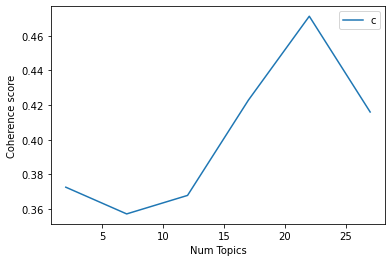

In [60]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3726
index: 1 | Num Topics = 7  has Coherence Value of 0.3572
index: 2 | Num Topics = 12  has Coherence Value of 0.3679
index: 3 | Num Topics = 17  has Coherence Value of 0.4229
index: 4 | Num Topics = 22  has Coherence Value of 0.4712
index: 5 | Num Topics = 27  has Coherence Value of 0.416


In [175]:
# Select optimal number of topics
optimal_model_ph_score2 = model_list_ph_score2[4]

In [176]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score2 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score2, corpus_ph_score2, id2word_ph_score2)

In [177]:
print("pyLDAVis for ph topics for score=2:")
vis_ph_score2

pyLDAVis for ph topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.173917  0.025781       1        1  20.794959
6     -0.185538 -0.105029       2        1   9.842491
1     -0.156702  0.060790       3        1   8.720616
12    -0.064165  0.089820       4        1   6.581776
17    -0.072211 -0.035036       5        1   6.347594
3     -0.061668  0.054861       6        1   6.117339
4      0.034283 -0.167770       7        1   4.731252
19    -0.019772 -0.083637       8        1   4.683647
8     -0.020691 -0.104203       9        1   3.353045
7      0.020947  0.075997      10        1   3.084303
20     0.069446 -0.142099      11        1   2.950312
11     0.114829 -0.007191      12        1   2.680702
9     -0.028859  0.077033      13        1   2.637523
0     -0.065177  0.025945      14        1   2.460158
14     0.099228  0.014007      15        1   2.445573
18     0.038179  0.045328      16        1   2.303000
10     0.097519  0.001510      17        1   2.042954
2      0.078869  0.109345      18        1   1.982761
21     0.117385  0.035221      19        1   1.787357
15     0.056072  0.030412      20        1   1.655201
5      0.019105  0.018179      21        1   1.649742
13     0.102837 -0.019265      22        1   1.147694, topic_info=         Term        Freq       Total Category  logprob  loglift
144  download   30.000000   30.000000  Default  30.0000  30.0000
43         ad   34.000000   34.000000  Default  29.0000  29.0000
10      video  102.000000  102.000000  Default  28.0000  28.0000
357      view   21.000000   21.000000  Default  27.0000  27.0000
0         app   47.000000   47.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
6      option    0.022253    5.074971  Topic22  -7.0157  -0.9622
7      really    0.022253   14.843416  Topic22  -7.0157  -2.0354
8       still    0.022253   17.786204  Topic22  -7.0157  -2.2163
9        time    0.022253   13.624799  Topic22  -7.0157  -1.9497
11      audio    0.022253    5.757521  Topic22  -7.0157  -1.0884

[999 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
231       8  0.680529         abc
505       6  0.863591        able
369       4  0.656204    absolute
537      19  0.765537  absolutely
442       8  0.680529       abuse
...     ...       ...         ...
598      16  0.449735     youtube
495       1  0.620680          yt
495       8  0.206893          yt
495      10  0.206893          yt
481       7  0.679622        zone

[1205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 7, 2, 13, 18, 4, 5, 20, 9, 8, 21, 12, 10, 1, 15, 19, 11, 3, 22, 16, 6, 14])

## LDA Topic Modelling (Rating = 3)

In [65]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_ph_score3 = youtube_ios_ph_review_YearMonth_score3.review.values.tolist()
review_words_ph_score3 = list(sent_to_words(review_ph_score3))
print(review_words_ph_score3[:1])

[['cant', 'download', 'videos', 'for', 'offline', 'viewing', 'anymore', 'is', 'it', 'not', 'available', 'anymore', 'don', 'think', 'there', 'was', 'an', 'update', 'removing', 'it']]


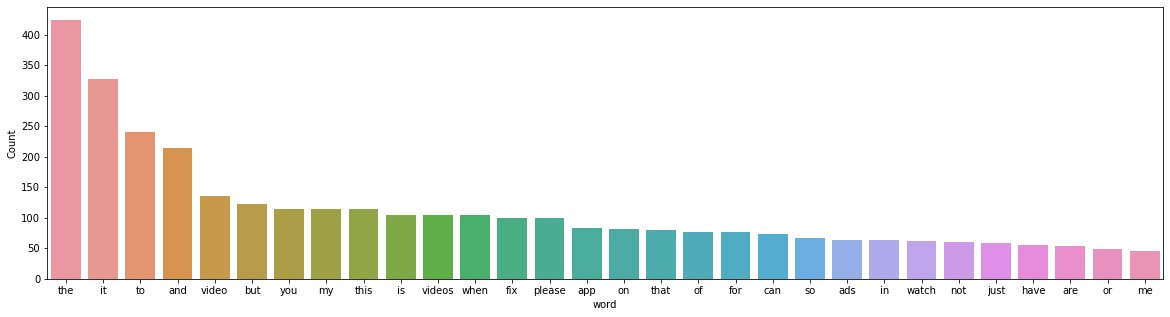

In [66]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score3))

In [67]:
# Clean text
review_ph_ready_score3 = process_words(review_words_ph_score3)  # processed Text Data! - move to each section


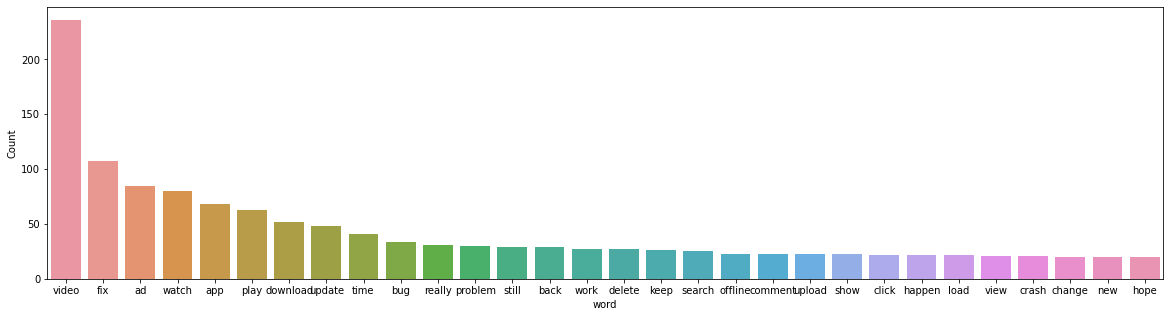

In [68]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score3))


In [69]:
# Create Dictionary
id2word_ph_score3 = corpora.Dictionary(review_ph_ready_score3)

2021-10-17 00:05:50,064 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:05:50,076 [INFO] gensim.corpora.dictionary - built Dictionary(817 unique tokens: ['anymore', 'available', 'download', 'offline', 'remove']...) from 281 documents (total 3415 corpus positions)
2021-10-17 00:05:50,077 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(817 unique tokens: ['anymore', 'available', 'download', 'offline', 'remove']...) from 281 documents (total 3415 corpus positions)", 'datetime': '2021-10-17T00:05:50.077428', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [70]:
# Create Corpus: Term Document Frequency
corpus_ph_score3 = [id2word_ph_score3.doc2bow(text) for text in review_ph_ready_score3]

In [71]:
# Training LDA model
model_list_ph_score3, coherence_values_ph_score3 = compute_coherence_values(dictionary=id2word_ph_score3, corpus=corpus_ph_score3, 
                                                              texts=review_ph_ready_score3, limit=30, start=2, step=5)


2021-10-17 00:05:50,477 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:05:50,478 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:05:50,481 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:05:50,482 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 281 documents, updating model once every 281 documents, evaluating perplexity every 281 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:05:51,434 [INFO] gensim.models.ldamodel - -7.312 per-word bound, 158.9 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:05:51,435 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #281/281
2021-10-17 00:05:52,436 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"video" + 0.018*"play" + 0.018*"fix" + 0.015*"ad" + 0.012*"watch" + 0.011*"app" + 0.010*"download"

2021-10-17 00:06:00,924 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.064*"video" + 0.033*"fix" + 0.024*"watch" + 0.024*"ad" + 0.022*"app" + 0.017*"play" + 0.017*"download" + 0.017*"update" + 0.014*"time" + 0.013*"bug"
2021-10-17 00:06:00,925 [INFO] gensim.models.ldamodel - topic diff=0.011840, rho=0.301511
2021-10-17 00:06:01,349 [INFO] gensim.models.ldamodel - -6.085 per-word bound, 67.9 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:06:01,350 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #281/281
2021-10-17 00:06:01,653 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.041*"video" + 0.013*"view" + 0.013*"ad" + 0.012*"fix" + 0.011*"delete" + 0.011*"back" + 0.011*"play" + 0.010*"really" + 0.010*"watch" + 0.009*"add"
2021-10-17 00:06:01,656 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.064*"video" + 0.033*"fix" + 0.024*"watch" + 0.024*"ad" + 0.022*"app" + 0.018*"play" + 0.017*"download" + 0.017*"update" + 0.0

2021-10-17 00:06:10,624 [INFO] gensim.models.ldamodel - topic diff=0.004224, rho=0.218218
2021-10-17 00:06:11,196 [INFO] gensim.models.ldamodel - -6.081 per-word bound, 67.7 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:06:11,197 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #281/281
2021-10-17 00:06:11,558 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.038*"video" + 0.014*"view" + 0.012*"ad" + 0.012*"fix" + 0.012*"delete" + 0.011*"back" + 0.010*"really" + 0.009*"add" + 0.009*"playlist" + 0.009*"watch"
2021-10-17 00:06:11,560 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"video" + 0.033*"fix" + 0.025*"ad" + 0.025*"watch" + 0.022*"app" + 0.019*"play" + 0.018*"download" + 0.017*"update" + 0.014*"time" + 0.013*"bug"
2021-10-17 00:06:11,562 [INFO] gensim.models.ldamodel - topic diff=0.004114, rho=0.213201
2021-10-17 00:06:12,059 [INFO] gensim.models.ldamodel - -6.080 per-word bound, 67.7 perplexity estimate bas

2021-10-17 00:06:20,487 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #281/281
2021-10-17 00:06:20,869 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"video" + 0.014*"view" + 0.012*"delete" + 0.012*"fix" + 0.011*"back" + 0.011*"ad" + 0.009*"add" + 0.009*"playlist" + 0.009*"really" + 0.008*"search"
2021-10-17 00:06:20,871 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"video" + 0.033*"fix" + 0.025*"ad" + 0.025*"watch" + 0.022*"app" + 0.020*"play" + 0.018*"download" + 0.017*"update" + 0.014*"time" + 0.012*"bug"
2021-10-17 00:06:20,872 [INFO] gensim.models.ldamodel - topic diff=0.004371, rho=0.176777
2021-10-17 00:06:21,385 [INFO] gensim.models.ldamodel - -6.077 per-word bound, 67.5 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:06:21,389 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #281/281
2021-10-17 00:06:21,741 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"video" + 0.014*"vie

2021-10-17 00:06:30,072 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.067*"video" + 0.033*"fix" + 0.026*"ad" + 0.025*"watch" + 0.022*"app" + 0.021*"play" + 0.018*"download" + 0.017*"update" + 0.014*"time" + 0.012*"bug"
2021-10-17 00:06:30,074 [INFO] gensim.models.ldamodel - topic diff=0.002766, rho=0.154303
2021-10-17 00:06:30,718 [INFO] gensim.models.ldamodel - -6.074 per-word bound, 67.4 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:06:30,722 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #281/281
2021-10-17 00:06:31,107 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"video" + 0.015*"view" + 0.012*"delete" + 0.012*"back" + 0.012*"fix" + 0.010*"ad" + 0.009*"playlist" + 0.009*"add" + 0.009*"really" + 0.009*"search"
2021-10-17 00:06:31,108 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.067*"video" + 0.033*"fix" + 0.026*"ad" + 0.025*"watch" + 0.022*"app" + 0.021*"play" + 0.018*"download" + 0.017*"update" 

2021-10-17 00:06:43,398 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 265 virtual documents
2021-10-17 00:06:43,716 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:06:43,717 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:06:43,720 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:06:43,724 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 281 documents, updating model once every 281 documents, evaluating perplexity every 281 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:06:44,565 [INFO] gensim.models.ldamodel - -8.959 per-word bound, 497.5 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:06:44,567 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #281/281
2021-10-17 00:06

2021-10-17 00:06:49,683 [INFO] gensim.models.ldamodel - -6.353 per-word bound, 81.8 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:06:49,685 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #281/281
2021-10-17 00:06:49,826 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.075*"video" + 0.033*"fix" + 0.027*"watch" + 0.019*"ad" + 0.014*"update" + 0.014*"time" + 0.011*"show" + 0.010*"problem" + 0.009*"search" + 0.009*"swipe"
2021-10-17 00:06:49,828 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"video" + 0.019*"guy" + 0.019*"time" + 0.018*"fix" + 0.017*"quality" + 0.013*"work" + 0.013*"really" + 0.013*"membership" + 0.010*"sometimes" + 0.010*"voice"
2021-10-17 00:06:49,830 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"video" + 0.024*"fix" + 0.017*"happen" + 0.017*"watch" + 0.016*"time" + 0.015*"back" + 0.014*"download" + 0.013*"app" + 0.012*"work" + 0.012*"quality"
2021-10-17 00:06:49,832 [INFO] gensim.model

2021-10-17 00:06:53,974 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"video" + 0.037*"fix" + 0.032*"app" + 0.032*"update" + 0.023*"crash" + 0.021*"download" + 0.020*"upload" + 0.017*"keep" + 0.014*"delete" + 0.013*"watch"
2021-10-17 00:06:53,977 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"search" + 0.021*"change" + 0.017*"fix" + 0.016*"video" + 0.016*"delete" + 0.013*"result" + 0.013*"profile" + 0.013*"gon" + 0.013*"app" + 0.013*"view"
2021-10-17 00:06:53,978 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"video" + 0.036*"download" + 0.034*"offline" + 0.026*"caption" + 0.022*"fix" + 0.022*"app" + 0.019*"view" + 0.018*"watch" + 0.017*"loading" + 0.016*"problem"
2021-10-17 00:06:53,979 [INFO] gensim.models.ldamodel - topic diff=0.012729, rho=0.288675
2021-10-17 00:06:54,457 [INFO] gensim.models.ldamodel - -6.330 per-word bound, 80.4 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:06:54,458 [INFO] gensim.models

2021-10-17 00:06:57,958 [INFO] gensim.models.ldamodel - topic diff=0.005749, rho=0.242536
2021-10-17 00:06:58,379 [INFO] gensim.models.ldamodel - -6.326 per-word bound, 80.2 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:06:58,381 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #281/281
2021-10-17 00:06:58,716 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"video" + 0.037*"fix" + 0.033*"update" + 0.032*"app" + 0.023*"crash" + 0.021*"download" + 0.020*"upload" + 0.017*"keep" + 0.015*"delete" + 0.013*"watch"
2021-10-17 00:06:58,718 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"video" + 0.037*"download" + 0.035*"offline" + 0.027*"caption" + 0.023*"fix" + 0.022*"app" + 0.019*"view" + 0.019*"watch" + 0.017*"loading" + 0.017*"picture"
2021-10-17 00:06:58,720 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.088*"video" + 0.082*"ad" + 0.065*"play" + 0.034*"watch" + 0.023*"fix" + 0.014*"app" + 0.012*"much" + 0.

2021-10-17 00:07:03,189 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"video" + 0.019*"guy" + 0.019*"time" + 0.018*"quality" + 0.018*"fix" + 0.013*"work" + 0.013*"really" + 0.013*"membership" + 0.010*"day" + 0.010*"premium"
2021-10-17 00:07:03,191 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.073*"video" + 0.029*"fix" + 0.025*"watch" + 0.015*"update" + 0.014*"time" + 0.011*"show" + 0.010*"screen" + 0.010*"search" + 0.010*"swipe" + 0.010*"click"
2021-10-17 00:07:03,196 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"video" + 0.037*"download" + 0.035*"offline" + 0.027*"caption" + 0.023*"fix" + 0.022*"app" + 0.019*"view" + 0.019*"watch" + 0.018*"loading" + 0.017*"picture"
2021-10-17 00:07:03,198 [INFO] gensim.models.ldamodel - topic diff=0.003020, rho=0.208514
2021-10-17 00:07:03,617 [INFO] gensim.models.ldamodel - -6.323 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:03,619 [INFO] gensim.model

2021-10-17 00:07:07,440 [INFO] gensim.models.ldamodel - topic diff=0.002454, rho=0.188982
2021-10-17 00:07:07,962 [INFO] gensim.models.ldamodel - -6.321 per-word bound, 79.9 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:07,967 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #281/281
2021-10-17 00:07:08,223 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.089*"video" + 0.088*"ad" + 0.063*"play" + 0.035*"watch" + 0.023*"fix" + 0.014*"app" + 0.012*"much" + 0.011*"annoying" + 0.010*"bug" + 0.010*"put"
2021-10-17 00:07:08,228 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"video" + 0.037*"download" + 0.035*"offline" + 0.027*"caption" + 0.023*"fix" + 0.022*"app" + 0.019*"view" + 0.019*"watch" + 0.018*"loading" + 0.018*"picture"
2021-10-17 00:07:08,231 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"video" + 0.037*"fix" + 0.033*"update" + 0.032*"app" + 0.023*"crash" + 0.021*"download" + 0.020*"upload" + 0.0

2021-10-17 00:07:12,705 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"video" + 0.038*"fix" + 0.033*"update" + 0.032*"app" + 0.023*"crash" + 0.021*"download" + 0.020*"upload" + 0.017*"keep" + 0.015*"delete" + 0.013*"watch"
2021-10-17 00:07:12,712 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"video" + 0.037*"download" + 0.035*"offline" + 0.027*"caption" + 0.023*"fix" + 0.022*"app" + 0.019*"view" + 0.019*"watch" + 0.018*"picture" + 0.018*"loading"
2021-10-17 00:07:12,716 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.071*"video" + 0.028*"fix" + 0.023*"watch" + 0.015*"update" + 0.014*"time" + 0.011*"show" + 0.010*"screen" + 0.010*"search" + 0.010*"swipe" + 0.010*"click"
2021-10-17 00:07:12,718 [INFO] gensim.models.ldamodel - topic diff=0.001622, rho=0.171499
2021-10-17 00:07:13,171 [INFO] gensim.models.ldamodel - -6.318 per-word bound, 79.8 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:13,174 [INFO] gensim.models

2021-10-17 00:07:16,707 [INFO] gensim.models.ldamodel - topic diff=0.001422, rho=0.160128
2021-10-17 00:07:17,231 [INFO] gensim.models.ldamodel - -6.317 per-word bound, 79.7 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:17,232 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #281/281
2021-10-17 00:07:17,539 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.090*"ad" + 0.090*"video" + 0.063*"play" + 0.035*"watch" + 0.024*"fix" + 0.014*"app" + 0.012*"much" + 0.011*"annoying" + 0.010*"bug" + 0.010*"put"
2021-10-17 00:07:17,542 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"search" + 0.021*"change" + 0.017*"fix" + 0.016*"delete" + 0.016*"video" + 0.014*"app" + 0.013*"profile" + 0.013*"gon" + 0.013*"result" + 0.013*"view"
2021-10-17 00:07:17,545 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"video" + 0.019*"guy" + 0.019*"time" + 0.018*"quality" + 0.018*"fix" + 0.013*"work" + 0.013*"really" + 0.013*"members

2021-10-17 00:07:20,851 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"search" + 0.021*"change" + 0.017*"fix" + 0.016*"delete" + 0.016*"video" + 0.014*"app" + 0.013*"profile" + 0.013*"gon" + 0.013*"result" + 0.013*"view"
2021-10-17 00:07:20,854 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"video" + 0.019*"guy" + 0.019*"time" + 0.018*"quality" + 0.018*"fix" + 0.013*"work" + 0.013*"really" + 0.013*"membership" + 0.010*"day" + 0.010*"premium"
2021-10-17 00:07:20,856 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"video" + 0.038*"fix" + 0.033*"update" + 0.032*"app" + 0.023*"crash" + 0.021*"download" + 0.019*"upload" + 0.017*"keep" + 0.015*"delete" + 0.013*"watch"
2021-10-17 00:07:20,858 [INFO] gensim.models.ldamodel - topic diff=0.000978, rho=0.149071
2021-10-17 00:07:21,321 [INFO] gensim.models.ldamodel - -6.316 per-word bound, 79.7 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:21,323 [INFO] gensim.models.lda

2021-10-17 00:07:24,216 [INFO] gensim.models.ldamodel - topic diff=0.000684, rho=0.141421
2021-10-17 00:07:24,569 [INFO] gensim.models.ldamodel - -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:24,571 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #281/281
2021-10-17 00:07:24,840 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.058*"video" + 0.024*"fix" + 0.018*"happen" + 0.016*"back" + 0.016*"watch" + 0.016*"time" + 0.014*"button" + 0.014*"work" + 0.013*"app" + 0.013*"download"
2021-10-17 00:07:24,842 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"search" + 0.021*"change" + 0.017*"fix" + 0.016*"delete" + 0.016*"video" + 0.014*"app" + 0.013*"profile" + 0.013*"gon" + 0.013*"result" + 0.013*"view"
2021-10-17 00:07:24,845 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"video" + 0.038*"fix" + 0.033*"update" + 0.032*"app" + 0.023*"crash" + 0.021*"download" + 0.019*"upload" + 0.

2021-10-17 00:07:35,282 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.090*"ad" + 0.081*"video" + 0.071*"play" + 0.029*"watch" + 0.025*"fix" + 0.016*"time" + 0.015*"much" + 0.014*"audio" + 0.013*"hope" + 0.012*"really"
2021-10-17 00:07:35,285 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.018*"really" + 0.018*"change" + 0.018*"vid" + 0.018*"subscriber" + 0.018*"voice" + 0.018*"still" + 0.015*"video" + 0.012*"sometimes" + 0.012*"delete" + 0.012*"reason"
2021-10-17 00:07:35,287 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.054*"video" + 0.051*"app" + 0.034*"update" + 0.029*"watch" + 0.025*"crash" + 0.023*"search" + 0.021*"fix" + 0.019*"keep" + 0.017*"ad" + 0.016*"load"
2021-10-17 00:07:35,288 [INFO] gensim.models.ldamodel - topic diff=0.079435, rho=0.447214
2021-10-17 00:07:35,603 [INFO] gensim.models.ldamodel - -6.522 per-word bound, 91.9 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:35,605 [INFO] gensim.models.ldamodel 

2021-10-17 00:07:38,800 [INFO] gensim.models.ldamodel - topic diff=0.026105, rho=0.316228
2021-10-17 00:07:39,207 [INFO] gensim.models.ldamodel - -6.480 per-word bound, 89.3 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:39,209 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #281/281
2021-10-17 00:07:39,490 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.018*"really" + 0.018*"change" + 0.018*"still" + 0.018*"vid" + 0.018*"voice" + 0.018*"subscriber" + 0.013*"video" + 0.012*"new" + 0.012*"sometimes" + 0.012*"reason"
2021-10-17 00:07:39,495 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.047*"video" + 0.038*"fix" + 0.034*"download" + 0.029*"upload" + 0.024*"time" + 0.019*"star" + 0.016*"update" + 0.015*"offline" + 0.014*"back" + 0.012*"caption"
2021-10-17 00:07:39,497 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"video" + 0.031*"fix" + 0.023*"comment" + 0.021*"caption" + 0.018*"view" + 0.018*"download" + 0

2021-10-17 00:07:42,699 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.055*"app" + 0.053*"video" + 0.040*"update" + 0.029*"crash" + 0.028*"watch" + 0.023*"fix" + 0.021*"search" + 0.019*"keep" + 0.018*"load" + 0.015*"whenever"
2021-10-17 00:07:42,701 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.031*"fix" + 0.025*"video" + 0.024*"work" + 0.017*"account" + 0.017*"update" + 0.016*"remove" + 0.014*"app" + 0.013*"add" + 0.013*"iphone" + 0.013*"playlist"
2021-10-17 00:07:42,705 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"video" + 0.032*"search" + 0.029*"quality" + 0.023*"update" + 0.021*"result" + 0.020*"click" + 0.017*"view" + 0.017*"new" + 0.014*"back" + 0.013*"download"
2021-10-17 00:07:42,706 [INFO] gensim.models.ldamodel - topic diff=0.008125, rho=0.250000
2021-10-17 00:07:43,015 [INFO] gensim.models.ldamodel - -6.470 per-word bound, 88.7 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:43,017 [INFO] gensim.models.

2021-10-17 00:07:45,902 [INFO] gensim.models.ldamodel - topic diff=0.004807, rho=0.218218
2021-10-17 00:07:46,282 [INFO] gensim.models.ldamodel - -6.468 per-word bound, 88.5 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:46,284 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #281/281
2021-10-17 00:07:46,652 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.019*"still" + 0.019*"change" + 0.019*"really" + 0.019*"vid" + 0.019*"voice" + 0.019*"subscriber" + 0.013*"video" + 0.013*"new" + 0.013*"sometimes" + 0.013*"reason"
2021-10-17 00:07:46,655 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.069*"video" + 0.026*"watch" + 0.025*"download" + 0.025*"fix" + 0.023*"help" + 0.020*"happen" + 0.018*"bug" + 0.015*"let" + 0.015*"time" + 0.014*"back"
2021-10-17 00:07:46,658 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"video" + 0.032*"search" + 0.029*"quality" + 0.023*"update" + 0.021*"result" + 0.020*"click" + 0.017*"n

2021-10-17 00:07:50,447 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.019*"really" + 0.019*"still" + 0.019*"change" + 0.019*"vid" + 0.019*"voice" + 0.019*"subscriber" + 0.013*"video" + 0.013*"new" + 0.013*"sometimes" + 0.013*"reason"
2021-10-17 00:07:50,449 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.056*"app" + 0.051*"video" + 0.041*"update" + 0.030*"crash" + 0.029*"watch" + 0.024*"fix" + 0.021*"search" + 0.019*"load" + 0.019*"keep" + 0.015*"whenever"
2021-10-17 00:07:50,451 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.069*"video" + 0.026*"watch" + 0.025*"download" + 0.025*"fix" + 0.023*"help" + 0.020*"happen" + 0.018*"bug" + 0.015*"let" + 0.015*"time" + 0.014*"back"
2021-10-17 00:07:50,452 [INFO] gensim.models.ldamodel - topic diff=0.003119, rho=0.192450
2021-10-17 00:07:50,830 [INFO] gensim.models.ldamodel - -6.464 per-word bound, 88.3 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:50,831 [INFO] gensim.models.lda

2021-10-17 00:07:54,132 [INFO] gensim.models.ldamodel - topic diff=0.002703, rho=0.176777
2021-10-17 00:07:54,514 [INFO] gensim.models.ldamodel - -6.461 per-word bound, 88.1 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:54,515 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #281/281
2021-10-17 00:07:54,767 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.074*"video" + 0.038*"download" + 0.038*"offline" + 0.032*"fix" + 0.026*"caption" + 0.025*"bug" + 0.020*"delete" + 0.020*"view" + 0.019*"problem" + 0.017*"app"
2021-10-17 00:07:54,776 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.070*"video" + 0.026*"watch" + 0.025*"download" + 0.025*"fix" + 0.023*"help" + 0.020*"happen" + 0.018*"bug" + 0.015*"time" + 0.015*"let" + 0.014*"back"
2021-10-17 00:07:54,781 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.047*"video" + 0.039*"fix" + 0.031*"download" + 0.030*"upload" + 0.025*"time" + 0.020*"star" + 0.015*"update" + 

2021-10-17 00:07:58,563 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.070*"video" + 0.027*"watch" + 0.027*"download" + 0.026*"fix" + 0.022*"help" + 0.020*"happen" + 0.018*"bug" + 0.015*"time" + 0.015*"let" + 0.014*"back"
2021-10-17 00:07:58,565 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.075*"video" + 0.040*"download" + 0.039*"offline" + 0.033*"fix" + 0.028*"caption" + 0.024*"bug" + 0.020*"delete" + 0.019*"view" + 0.019*"problem" + 0.017*"app"
2021-10-17 00:07:58,566 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.019*"really" + 0.019*"change" + 0.019*"still" + 0.019*"vid" + 0.019*"voice" + 0.019*"subscriber" + 0.013*"video" + 0.013*"new" + 0.013*"sometimes" + 0.013*"reason"
2021-10-17 00:07:58,568 [INFO] gensim.models.ldamodel - topic diff=0.002764, rho=0.162221
2021-10-17 00:07:58,995 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:07:58,997 [INFO] gensim.model

2021-10-17 00:08:01,963 [INFO] gensim.models.ldamodel - topic diff=0.002107, rho=0.152499
2021-10-17 00:08:02,461 [INFO] gensim.models.ldamodel - -6.454 per-word bound, 87.7 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:02,462 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #281/281
2021-10-17 00:08:02,735 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.071*"video" + 0.028*"download" + 0.028*"watch" + 0.026*"fix" + 0.022*"help" + 0.020*"happen" + 0.018*"bug" + 0.015*"time" + 0.015*"let" + 0.014*"back"
2021-10-17 00:08:02,737 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.031*"fix" + 0.024*"work" + 0.022*"video" + 0.017*"account" + 0.017*"update" + 0.017*"remove" + 0.015*"app" + 0.013*"add" + 0.013*"iphone" + 0.013*"full"
2021-10-17 00:08:02,739 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.033*"video" + 0.032*"search" + 0.029*"quality" + 0.023*"update" + 0.021*"result" + 0.020*"click" + 0.017*"new" + 0.01

2021-10-17 00:08:05,715 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.033*"search" + 0.032*"video" + 0.029*"quality" + 0.022*"update" + 0.021*"result" + 0.020*"click" + 0.017*"view" + 0.017*"new" + 0.014*"back" + 0.013*"similar"
2021-10-17 00:08:05,718 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.071*"video" + 0.030*"download" + 0.028*"watch" + 0.027*"fix" + 0.022*"help" + 0.020*"happen" + 0.017*"bug" + 0.015*"time" + 0.015*"let" + 0.014*"back"
2021-10-17 00:08:05,723 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.052*"video" + 0.029*"quality" + 0.025*"watch" + 0.025*"option" + 0.023*"guy" + 0.020*"setting" + 0.016*"show" + 0.015*"turn" + 0.013*"time" + 0.011*"new"
2021-10-17 00:08:05,725 [INFO] gensim.models.ldamodel - topic diff=0.001936, rho=0.142857
2021-10-17 00:08:06,171 [INFO] gensim.models.ldamodel - -6.451 per-word bound, 87.5 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:06,172 [INFO] gensim.models.ldamodel 

2021-10-17 00:08:18,167 [INFO] gensim.models.ldamodel - -6.721 per-word bound, 105.5 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:18,173 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #281/281
2021-10-17 00:08:18,417 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.056*"app" + 0.042*"video" + 0.041*"crash" + 0.033*"fix" + 0.025*"update" + 0.023*"watch" + 0.018*"whenever" + 0.018*"open" + 0.016*"keep" + 0.013*"search"
2021-10-17 00:08:18,420 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.046*"ad" + 0.038*"update" + 0.032*"much" + 0.029*"picture" + 0.028*"quality" + 0.021*"video" + 0.021*"anymore" + 0.019*"low" + 0.019*"click" + 0.018*"long"
2021-10-17 00:08:18,423 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.039*"work" + 0.036*"fix" + 0.028*"update" + 0.026*"still" + 0.026*"iphone" + 0.019*"new" + 0.018*"hope" + 0.016*"feature" + 0.016*"available" + 0.010*"recent"
2021-10-17 00:08:18,426 [INFO] gensim.mo

2021-10-17 00:08:21,324 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.046*"ad" + 0.038*"picture" + 0.033*"update" + 0.033*"much" + 0.031*"quality" + 0.021*"video" + 0.021*"app" + 0.020*"long" + 0.020*"low" + 0.020*"click"
2021-10-17 00:08:21,325 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.085*"video" + 0.048*"problem" + 0.043*"watch" + 0.030*"ad" + 0.029*"fix" + 0.014*"play" + 0.014*"download" + 0.013*"time" + 0.013*"next" + 0.013*"app"
2021-10-17 00:08:21,327 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.079*"video" + 0.022*"download" + 0.021*"happen" + 0.019*"fix" + 0.019*"time" + 0.018*"option" + 0.017*"back" + 0.014*"work" + 0.014*"problem" + 0.014*"like"
2021-10-17 00:08:21,327 [INFO] gensim.models.ldamodel - topic diff=0.035573, rho=0.333333
2021-10-17 00:08:21,669 [INFO] gensim.models.ldamodel - -6.595 per-word bound, 96.7 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:21,674 [INFO] gensim.models.ldamodel - 

2021-10-17 00:08:24,606 [INFO] gensim.models.ldamodel - topic diff=0.013408, rho=0.267261
2021-10-17 00:08:25,067 [INFO] gensim.models.ldamodel - -6.578 per-word bound, 95.5 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:25,068 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #281/281
2021-10-17 00:08:25,249 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.038*"loading" + 0.031*"ad" + 0.031*"fix" + 0.023*"voice" + 0.016*"button" + 0.016*"really" + 0.016*"sometimes" + 0.016*"device" + 0.016*"dif" + 0.016*"change"
2021-10-17 00:08:25,251 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.085*"ad" + 0.084*"play" + 0.082*"video" + 0.027*"watch" + 0.020*"fix" + 0.016*"bug" + 0.015*"time" + 0.011*"much" + 0.011*"really" + 0.010*"hope"
2021-10-17 00:08:25,257 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.072*"comment" + 0.048*"section" + 0.041*"fix" + 0.019*"video" + 0.018*"everytime" + 0.012*"click" + 0.012*"profile" +

2021-10-17 00:08:28,464 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.058*"video" + 0.055*"caption" + 0.038*"download" + 0.036*"fix" + 0.021*"loading" + 0.021*"error" + 0.018*"offline" + 0.017*"section" + 0.016*"everytime" + 0.013*"really"
2021-10-17 00:08:28,466 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.046*"ad" + 0.039*"picture" + 0.033*"update" + 0.032*"much" + 0.031*"quality" + 0.025*"click" + 0.022*"app" + 0.021*"video" + 0.020*"long" + 0.020*"io"
2021-10-17 00:08:28,468 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.086*"video" + 0.049*"problem" + 0.044*"watch" + 0.031*"ad" + 0.029*"fix" + 0.014*"play" + 0.014*"download" + 0.013*"time" + 0.013*"next" + 0.013*"app"
2021-10-17 00:08:28,469 [INFO] gensim.models.ldamodel - topic diff=0.004921, rho=0.223607
2021-10-17 00:08:28,772 [INFO] gensim.models.ldamodel - -6.571 per-word bound, 95.1 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:28,773 [INFO] gensim.models

2021-10-17 00:08:31,691 [INFO] gensim.models.ldamodel - topic diff=0.002829, rho=0.200000
2021-10-17 00:08:32,109 [INFO] gensim.models.ldamodel - -6.568 per-word bound, 94.9 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:32,116 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #281/281
2021-10-17 00:08:32,367 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.047*"delete" + 0.046*"video" + 0.041*"view" + 0.033*"watch" + 0.028*"really" + 0.019*"premium" + 0.019*"guy" + 0.018*"app" + 0.015*"membership" + 0.015*"notification"
2021-10-17 00:08:32,379 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.038*"work" + 0.034*"fix" + 0.026*"update" + 0.026*"still" + 0.026*"iphone" + 0.026*"available" + 0.025*"post" + 0.025*"community" + 0.025*"ipad" + 0.017*"new"
2021-10-17 00:08:32,382 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.038*"video" + 0.035*"fix" + 0.026*"bug" + 0.019*"revert" + 0.019*"kindly" + 0.013*"channel" + 

2021-10-17 00:08:35,714 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.065*"video" + 0.030*"ad" + 0.019*"account" + 0.019*"watch" + 0.018*"back" + 0.014*"put" + 0.014*"view" + 0.014*"screen" + 0.014*"search" + 0.014*"premium"
2021-10-17 00:08:35,716 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.086*"video" + 0.048*"problem" + 0.044*"watch" + 0.031*"ad" + 0.029*"fix" + 0.014*"play" + 0.014*"download" + 0.013*"time" + 0.013*"next" + 0.013*"app"
2021-10-17 00:08:35,718 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"video" + 0.027*"ad" + 0.027*"search" + 0.023*"app" + 0.023*"load" + 0.023*"update" + 0.019*"watch" + 0.016*"play" + 0.015*"download" + 0.014*"internet"
2021-10-17 00:08:35,719 [INFO] gensim.models.ldamodel - topic diff=0.001891, rho=0.179605
2021-10-17 00:08:36,187 [INFO] gensim.models.ldamodel - -6.566 per-word bound, 94.7 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:36,189 [INFO] gensim.models.ldamodel

2021-10-17 00:08:38,852 [INFO] gensim.models.ldamodel - topic diff=0.001294, rho=0.166667
2021-10-17 00:08:39,159 [INFO] gensim.models.ldamodel - -6.564 per-word bound, 94.6 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:39,160 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #281/281
2021-10-17 00:08:39,450 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.097*"video" + 0.046*"watch" + 0.043*"fix" + 0.040*"download" + 0.029*"offline" + 0.029*"upload" + 0.027*"load" + 0.018*"update" + 0.013*"delete" + 0.012*"bug"
2021-10-17 00:08:39,452 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.060*"video" + 0.057*"caption" + 0.041*"download" + 0.034*"fix" + 0.026*"loading" + 0.025*"error" + 0.022*"offline" + 0.017*"section" + 0.016*"everytime" + 0.016*"really"
2021-10-17 00:08:39,454 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.060*"video" + 0.031*"fix" + 0.030*"bug" + 0.027*"time" + 0.021*"still" + 0.020*"update" + 0

2021-10-17 00:08:42,448 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.081*"video" + 0.022*"download" + 0.021*"happen" + 0.019*"time" + 0.019*"option" + 0.019*"fix" + 0.017*"work" + 0.017*"back" + 0.015*"problem" + 0.014*"like"
2021-10-17 00:08:42,451 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.038*"video" + 0.035*"fix" + 0.026*"bug" + 0.019*"revert" + 0.019*"kindly" + 0.013*"channel" + 0.013*"vid" + 0.013*"tho" + 0.013*"public" + 0.013*"upload"
2021-10-17 00:08:42,455 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.067*"app" + 0.062*"crash" + 0.042*"fix" + 0.033*"video" + 0.024*"update" + 0.023*"keep" + 0.020*"whenever" + 0.020*"open" + 0.019*"watch" + 0.016*"search"
2021-10-17 00:08:42,456 [INFO] gensim.models.ldamodel - topic diff=0.000955, rho=0.154303
2021-10-17 00:08:42,812 [INFO] gensim.models.ldamodel - -6.563 per-word bound, 94.5 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:42,820 [INFO] gensim.models.ldamode

2021-10-17 00:08:45,451 [INFO] gensim.models.ldamodel - topic diff=0.000817, rho=0.145865
2021-10-17 00:08:45,768 [INFO] gensim.models.ldamodel - -6.562 per-word bound, 94.5 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:45,770 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #281/281
2021-10-17 00:08:45,982 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.097*"video" + 0.046*"watch" + 0.043*"fix" + 0.040*"download" + 0.029*"offline" + 0.029*"upload" + 0.027*"load" + 0.018*"update" + 0.013*"delete" + 0.012*"bug"
2021-10-17 00:08:45,983 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"video" + 0.027*"ad" + 0.027*"search" + 0.023*"load" + 0.023*"update" + 0.023*"app" + 0.019*"watch" + 0.016*"play" + 0.015*"download" + 0.014*"back"
2021-10-17 00:08:45,985 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.039*"loading" + 0.031*"ad" + 0.031*"fix" + 0.023*"voice" + 0.016*"sometimes" + 0.016*"really" + 0.016*"dif" 

2021-10-17 00:08:58,085 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.062*"video" + 0.031*"update" + 0.030*"ad" + 0.030*"watch" + 0.028*"fix" + 0.023*"app" + 0.020*"crash" + 0.020*"keep" + 0.019*"much" + 0.017*"happen"
2021-10-17 00:08:58,088 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.086*"video" + 0.044*"watch" + 0.037*"fix" + 0.030*"problem" + 0.016*"search" + 0.015*"add" + 0.015*"ad" + 0.012*"audio" + 0.012*"time" + 0.012*"change"
2021-10-17 00:08:58,093 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.044*"video" + 0.030*"view" + 0.026*"delete" + 0.022*"play" + 0.022*"fix" + 0.018*"app" + 0.017*"guy" + 0.017*"membership" + 0.017*"picture" + 0.013*"already"
2021-10-17 00:08:58,095 [INFO] gensim.models.ldamodel - topic diff=17.776136, rho=1.000000
2021-10-17 00:08:58,579 [INFO] gensim.models.ldamodel - -6.909 per-word bound, 120.1 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:08:58,582 [INFO] gensim.models.ldamodel -

2021-10-17 00:09:02,102 [INFO] gensim.models.ldamodel - topic diff=0.061481, rho=0.377964
2021-10-17 00:09:02,613 [INFO] gensim.models.ldamodel - -6.676 per-word bound, 102.3 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:09:02,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #281/281
2021-10-17 00:09:02,905 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.061*"bug" + 0.050*"fix" + 0.039*"video" + 0.021*"show" + 0.021*"comment" + 0.018*"notification" + 0.017*"still" + 0.015*"download" + 0.014*"stick" + 0.014*"problem"
2021-10-17 00:09:02,909 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.080*"video" + 0.050*"update" + 0.037*"app" + 0.024*"fix" + 0.018*"save" + 0.014*"help" + 0.014*"anymore" + 0.014*"new" + 0.014*"day" + 0.014*"find"
2021-10-17 00:09:02,912 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.048*"view" + 0.042*"delete" + 0.035*"video" + 0.030*"picture" + 0.021*"fix" + 0.020*"guy" + 0.020*"members

2021-10-17 00:09:06,489 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.071*"fix" + 0.055*"video" + 0.053*"upload" + 0.026*"app" + 0.020*"time" + 0.020*"ad" + 0.017*"work" + 0.017*"click" + 0.013*"crash" + 0.013*"update"
2021-10-17 00:09:06,491 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.040*"video" + 0.032*"playlist" + 0.030*"back" + 0.028*"time" + 0.025*"channel" + 0.020*"comment" + 0.020*"swipe" + 0.020*"thumbnail" + 0.020*"section" + 0.018*"show"
2021-10-17 00:09:06,492 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.051*"view" + 0.046*"delete" + 0.035*"video" + 0.031*"picture" + 0.021*"guy" + 0.021*"membership" + 0.019*"fix" + 0.019*"work" + 0.017*"keep" + 0.016*"really"
2021-10-17 00:09:06,493 [INFO] gensim.models.ldamodel - topic diff=0.019803, rho=0.277350
2021-10-17 00:09:06,946 [INFO] gensim.models.ldamodel - -6.630 per-word bound, 99.1 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:09:06,947 [INFO] gensim.models

2021-10-17 00:09:10,459 [INFO] gensim.models.ldamodel - topic diff=0.008594, rho=0.235702
2021-10-17 00:09:10,859 [INFO] gensim.models.ldamodel - -6.620 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:09:10,860 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #281/281
2021-10-17 00:09:11,117 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.106*"ad" + 0.027*"much" + 0.021*"loading" + 0.018*"app" + 0.014*"cookie" + 0.014*"minimize" + 0.014*"listen" + 0.014*"chat" + 0.014*"online" + 0.014*"update"
2021-10-17 00:09:11,119 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.105*"video" + 0.096*"play" + 0.056*"ad" + 0.041*"watch" + 0.033*"fix" + 0.019*"bug" + 0.016*"thing" + 0.016*"hope" + 0.013*"really" + 0.012*"app"
2021-10-17 00:09:11,120 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.051*"video" + 0.047*"caption" + 0.043*"download" + 0.034*"fix" + 0.034*"app" + 0.032*"loading" + 0.032*"error" + 0.02

2021-10-17 00:09:14,717 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.094*"video" + 0.047*"watch" + 0.039*"problem" + 0.034*"fix" + 0.018*"search" + 0.018*"appear" + 0.017*"add" + 0.013*"time" + 0.013*"change" + 0.013*"audio"
2021-10-17 00:09:14,719 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.060*"quality" + 0.053*"video" + 0.049*"option" + 0.020*"new" + 0.020*"give" + 0.020*"date" + 0.020*"low" + 0.020*"datum" + 0.020*"guy" + 0.020*"choose"
2021-10-17 00:09:14,721 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.077*"video" + 0.023*"watch" + 0.022*"option" + 0.021*"download" + 0.019*"time" + 0.016*"next" + 0.016*"fix" + 0.016*"app" + 0.013*"turn" + 0.013*"button"
2021-10-17 00:09:14,735 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.050*"search" + 0.042*"video" + 0.025*"quality" + 0.025*"ad" + 0.020*"click" + 0.020*"result" + 0.016*"update" + 0.015*"put" + 0.015*"keep" + 0.015*"annoy"
2021-10-17 00:09:14,737 [INFO] gensim.models.ldamodel - topic diff=0.003527, r

2021-10-17 00:09:18,640 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.051*"video" + 0.047*"caption" + 0.042*"download" + 0.034*"fix" + 0.034*"app" + 0.032*"loading" + 0.032*"error" + 0.029*"watch" + 0.020*"always" + 0.018*"offline"
2021-10-17 00:09:18,641 [INFO] gensim.models.ldamodel - topic diff=0.001772, rho=0.185695
2021-10-17 00:09:19,070 [INFO] gensim.models.ldamodel - -6.614 per-word bound, 98.0 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:09:19,072 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #281/281
2021-10-17 00:09:19,287 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.098*"video" + 0.062*"download" + 0.057*"offline" + 0.048*"watch" + 0.033*"load" + 0.027*"fix" + 0.018*"vid" + 0.018*"problem" + 0.017*"delete" + 0.016*"play"
2021-10-17 00:09:19,294 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.105*"ad" + 0.028*"much" + 0.021*"loading" + 0.016*"app" + 0.014*"cookie" + 0.014*"minimize" + 0.014*

2021-10-17 00:09:22,827 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.042*"video" + 0.034*"playlist" + 0.032*"back" + 0.029*"time" + 0.025*"channel" + 0.020*"comment" + 0.020*"swipe" + 0.020*"section" + 0.020*"thumbnail" + 0.017*"show"
2021-10-17 00:09:22,830 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.105*"ad" + 0.028*"much" + 0.021*"loading" + 0.016*"app" + 0.014*"cookie" + 0.014*"minimize" + 0.014*"listen" + 0.014*"update" + 0.014*"chat" + 0.014*"especially"
2021-10-17 00:09:22,831 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.081*"fix" + 0.036*"issue" + 0.033*"app" + 0.026*"video" + 0.024*"ad" + 0.024*"crash" + 0.022*"look" + 0.022*"annoying" + 0.016*"section" + 0.016*"comment"
2021-10-17 00:09:22,835 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.098*"video" + 0.063*"download" + 0.057*"offline" + 0.048*"watch" + 0.033*"load" + 0.026*"fix" + 0.018*"vid" + 0.018*"problem" + 0.017*"delete" + 0.016*"play"
2021-10-17 00:09:22,836 [INFO] gensim.models.ldamodel

2021-10-17 00:09:26,839 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.071*"fix" + 0.057*"upload" + 0.049*"video" + 0.028*"app" + 0.018*"time" + 0.018*"work" + 0.018*"click" + 0.014*"crash" + 0.013*"update" + 0.013*"change"
2021-10-17 00:09:26,840 [INFO] gensim.models.ldamodel - topic diff=0.000466, rho=0.158114
2021-10-17 00:09:27,381 [INFO] gensim.models.ldamodel - -6.613 per-word bound, 97.9 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:09:27,383 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #281/281
2021-10-17 00:09:27,796 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.050*"search" + 0.042*"video" + 0.025*"quality" + 0.025*"ad" + 0.020*"click" + 0.020*"result" + 0.016*"update" + 0.015*"put" + 0.015*"keep" + 0.015*"annoy"
2021-10-17 00:09:27,818 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.105*"ad" + 0.028*"much" + 0.021*"loading" + 0.016*"app" + 0.014*"cookie" + 0.014*"minimize" + 0.014*"listen" + 0.

2021-10-17 00:09:31,380 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.098*"comment" + 0.068*"section" + 0.035*"view" + 0.024*"quality" + 0.024*"phone" + 0.024*"keep" + 0.024*"reply" + 0.023*"everytime" + 0.012*"set" + 0.012*"internet"
2021-10-17 00:09:31,382 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.078*"video" + 0.052*"update" + 0.038*"app" + 0.025*"fix" + 0.019*"save" + 0.016*"help" + 0.014*"anymore" + 0.014*"day" + 0.014*"find" + 0.014*"way"
2021-10-17 00:09:31,383 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.071*"fix" + 0.057*"upload" + 0.048*"video" + 0.028*"app" + 0.018*"time" + 0.018*"work" + 0.018*"click" + 0.014*"crash" + 0.013*"update" + 0.013*"change"
2021-10-17 00:09:31,385 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.050*"search" + 0.042*"video" + 0.025*"quality" + 0.025*"ad" + 0.020*"click" + 0.020*"result" + 0.016*"update" + 0.015*"put" + 0.015*"similar" + 0.015*"annoy"
2021-10-17 00:09:31,387 [INFO] gensim.models.ldamodel - topic #19 (0.0

2021-10-17 00:09:36,277 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.038*"app" + 0.027*"download" + 0.023*"ad" + 0.022*"crash" + 0.022*"happen" + 0.022*"let" + 0.021*"reinstall" + 0.016*"update" + 0.016*"search" + 0.016*"delete"
2021-10-17 00:09:36,279 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.041*"work" + 0.032*"ad" + 0.032*"iphone" + 0.016*"update" + 0.016*"time" + 0.016*"fix" + 0.016*"new" + 0.016*"small" + 0.016*"edit" + 0.016*"still"
2021-10-17 00:09:36,280 [INFO] gensim.models.ldamodel - topic diff=0.000213, rho=0.140028
2021-10-17 00:09:36,282 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=817, num_topics=22, decay=0.5, chunksize=1000) in 39.82s', 'datetime': '2021-10-17T00:09:36.282137', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 00:09:36,290 [INFO] gensim.topic_coherence.probability_estimation - using P

2021-10-17 00:10:00,883 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #281/281
2021-10-17 00:10:01,272 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.056*"video" + 0.036*"offline" + 0.032*"fix" + 0.031*"picture" + 0.030*"app" + 0.030*"download" + 0.028*"watch" + 0.022*"subtitle" + 0.018*"still" + 0.017*"play"
2021-10-17 00:10:01,275 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.057*"app" + 0.026*"find" + 0.025*"several" + 0.022*"video" + 0.021*"watch" + 0.019*"problem" + 0.018*"cookie" + 0.018*"screen" + 0.018*"navigation" + 0.017*"bar"
2021-10-17 00:10:01,277 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.053*"video" + 0.041*"show" + 0.021*"minute" + 0.021*"online" + 0.021*"chat" + 0.021*"ad" + 0.021*"advertisment" + 0.021*"base" + 0.021*"profile" + 0.021*"suggestion"
2021-10-17 00:10:01,286 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.072*"video" + 0.044*"load" + 0.035*"download" + 0.028*"play" + 0.028*"crash" + 0.019*"delete" + 0.019*"app" +

2021-10-17 00:10:04,825 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.035*"video" + 0.032*"search" + 0.025*"fix" + 0.021*"open" + 0.021*"ad" + 0.021*"app" + 0.016*"back" + 0.016*"happen" + 0.016*"skipable" + 0.016*"delete"
2021-10-17 00:10:04,828 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.061*"issue" + 0.043*"fix" + 0.033*"sound" + 0.032*"comment" + 0.018*"crash" + 0.016*"bring" + 0.016*"rate" + 0.016*"section" + 0.016*"fair" + 0.016*"gmail"
2021-10-17 00:10:04,846 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.052*"video" + 0.040*"keep" + 0.034*"view" + 0.031*"watch" + 0.030*"premium" + 0.028*"delete" + 0.026*"really" + 0.024*"fix" + 0.020*"membership" + 0.020*"way"
2021-10-17 00:10:04,850 [INFO] gensim.models.ldamodel - topic diff=0.027742, rho=0.301511
2021-10-17 00:10:05,223 [INFO] gensim.models.ldamodel - -6.733 per-word bound, 106.4 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:10:05,225 [INFO] gensim.models.lda

2021-10-17 00:10:08,366 [INFO] gensim.models.ldamodel - topic diff=0.012670, rho=0.250000
2021-10-17 00:10:08,820 [INFO] gensim.models.ldamodel - -6.714 per-word bound, 105.0 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:10:08,825 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #281/281
2021-10-17 00:10:09,084 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.057*"ipad" + 0.057*"post" + 0.057*"community" + 0.056*"available" + 0.038*"view" + 0.020*"bug" + 0.020*"comment" + 0.020*"purchase" + 0.020*"instead" + 0.020*"keep"
2021-10-17 00:10:09,089 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.091*"video" + 0.089*"play" + 0.041*"ad" + 0.029*"watch" + 0.027*"fix" + 0.019*"app" + 0.018*"bug" + 0.017*"happen" + 0.016*"download" + 0.016*"hope"
2021-10-17 00:10:09,091 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.054*"ad" + 0.045*"fix" + 0.045*"remove" + 0.034*"account" + 0.023*"copyright" + 0.023*"yt" + 0.023*"let" 

2021-10-17 00:10:12,434 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.099*"ad" + 0.094*"video" + 0.048*"watch" + 0.026*"fix" + 0.023*"update" + 0.019*"still" + 0.016*"app" + 0.015*"appear" + 0.015*"click" + 0.015*"play"
2021-10-17 00:10:12,437 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.091*"video" + 0.089*"play" + 0.041*"ad" + 0.029*"watch" + 0.027*"fix" + 0.019*"app" + 0.018*"bug" + 0.018*"happen" + 0.016*"download" + 0.016*"hope"
2021-10-17 00:10:12,441 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.075*"app" + 0.057*"fix" + 0.052*"video" + 0.050*"crash" + 0.030*"update" + 0.023*"watch" + 0.023*"whenever" + 0.019*"ad" + 0.019*"open" + 0.014*"search"
2021-10-17 00:10:12,445 [INFO] gensim.models.ldamodel - topic diff=0.006110, rho=0.213201
2021-10-17 00:10:12,958 [INFO] gensim.models.ldamodel - -6.704 per-word bound, 104.3 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:10:12,960 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-17 00:10:16,047 [INFO] gensim.models.ldamodel - topic diff=0.003421, rho=0.192450
2021-10-17 00:10:16,388 [INFO] gensim.models.ldamodel - -6.700 per-word bound, 104.0 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:10:16,390 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #281/281
2021-10-17 00:10:16,710 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.049*"annoy" + 0.049*"ad" + 0.025*"video" + 0.025*"interrupt" + 0.025*"cut" + 0.025*"usually" + 0.025*"middle" + 0.025*"interval" + 0.025*"wrong" + 0.001*"really"
2021-10-17 00:10:16,712 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.100*"ad" + 0.095*"video" + 0.049*"watch" + 0.025*"fix" + 0.023*"update" + 0.019*"still" + 0.016*"app" + 0.015*"appear" + 0.015*"click" + 0.015*"play"
2021-10-17 00:10:16,714 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.074*"video" + 0.044*"bug" + 0.026*"fix" + 0.022*"app" + 0.022*"play" + 0.022*"great" + 0.017*"audio" + 0.0

2021-10-17 00:10:20,095 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.047*"video" + 0.041*"keep" + 0.036*"view" + 0.031*"premium" + 0.030*"delete" + 0.029*"watch" + 0.027*"really" + 0.023*"fix" + 0.021*"membership" + 0.021*"way"
2021-10-17 00:10:20,097 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.061*"search" + 0.033*"loading" + 0.027*"result" + 0.027*"playlist" + 0.027*"profile" + 0.026*"change" + 0.026*"video" + 0.021*"ad" + 0.021*"click" + 0.021*"show"
2021-10-17 00:10:20,099 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.063*"playlist" + 0.049*"video" + 0.039*"put" + 0.031*"add" + 0.030*"back" + 0.024*"fix" + 0.024*"comment" + 0.023*"play" + 0.016*"number" + 0.016*"shuffle"
2021-10-17 00:10:20,101 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.057*"app" + 0.027*"find" + 0.026*"several" + 0.021*"watch" + 0.020*"video" + 0.018*"problem" + 0.018*"cookie" + 0.018*"screen" + 0.018*"navigation" + 0.018*"bar"
2021-10-17 00:10:20,103 [INFO] gensim.models.ldamodel - 

2021-10-17 00:10:23,105 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.073*"update" + 0.043*"fix" + 0.042*"time" + 0.040*"next" + 0.034*"work" + 0.034*"day" + 0.023*"last" + 0.023*"hope" + 0.012*"wait" + 0.012*"really"
2021-10-17 00:10:23,106 [INFO] gensim.models.ldamodel - topic diff=0.001144, rho=0.162221
2021-10-17 00:10:23,459 [INFO] gensim.models.ldamodel - -6.697 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:10:23,463 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #281/281
2021-10-17 00:10:23,675 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.091*"video" + 0.089*"play" + 0.041*"ad" + 0.028*"watch" + 0.027*"fix" + 0.019*"app" + 0.018*"bug" + 0.018*"happen" + 0.017*"work" + 0.016*"download"
2021-10-17 00:10:23,679 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.074*"video" + 0.044*"bug" + 0.026*"fix" + 0.022*"app" + 0.022*"play" + 0.022*"great" + 0.017*"audio" + 0.017*"time" + 0.01

2021-10-17 00:10:26,479 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.071*"ad" + 0.043*"fix" + 0.040*"much" + 0.034*"bug" + 0.027*"iphone" + 0.027*"help" + 0.022*"update" + 0.020*"hope" + 0.020*"time" + 0.020*"annoying"
2021-10-17 00:10:26,480 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.090*"video" + 0.089*"play" + 0.041*"ad" + 0.028*"watch" + 0.027*"fix" + 0.019*"app" + 0.018*"bug" + 0.018*"happen" + 0.017*"work" + 0.016*"download"
2021-10-17 00:10:26,482 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.063*"playlist" + 0.049*"video" + 0.039*"put" + 0.031*"add" + 0.030*"back" + 0.024*"fix" + 0.024*"comment" + 0.023*"play" + 0.016*"number" + 0.016*"section"
2021-10-17 00:10:26,484 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.111*"video" + 0.054*"watch" + 0.033*"fix" + 0.022*"problem" + 0.019*"upload" + 0.019*"like" + 0.014*"audio" + 0.014*"well" + 0.014*"advertisement" + 0.011*"download"
2021-10-17 00:10:26,486 [INFO] gensim.models.ldamodel - topic #11 (0.037)

2021-10-17 00:10:29,579 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.093*"video" + 0.066*"download" + 0.051*"offline" + 0.027*"caption" + 0.027*"problem" + 0.027*"internet" + 0.025*"load" + 0.024*"update" + 0.023*"connection" + 0.021*"time"
2021-10-17 00:10:29,580 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.079*"video" + 0.066*"quality" + 0.039*"new" + 0.030*"download" + 0.026*"update" + 0.022*"high" + 0.020*"low" + 0.017*"click" + 0.017*"option" + 0.017*"premium"
2021-10-17 00:10:29,581 [INFO] gensim.models.ldamodel - topic diff=0.000519, rho=0.142857
2021-10-17 00:10:29,828 [INFO] gensim.models.ldamodel - -6.696 per-word bound, 103.6 perplexity estimate based on a held-out corpus of 281 documents with 3415 words
2021-10-17 00:10:29,859 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #281/281
2021-10-17 00:10:30,117 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.079*"video" + 0.066*"quality" + 0.039*"new" + 0.030*"download" + 0.026*"update" + 0.022*

In [72]:
%store model_list_ph_score3
%store coherence_values_ph_score3

Stored 'model_list_ph_score3' (list)
Stored 'coherence_values_ph_score3' (list)


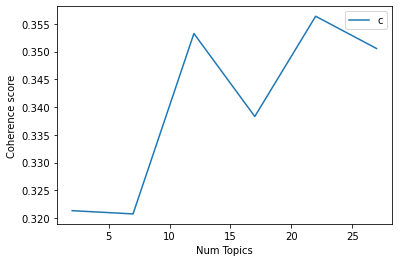

In [73]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [74]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3213
index: 1 | Num Topics = 7  has Coherence Value of 0.3208
index: 2 | Num Topics = 12  has Coherence Value of 0.3533
index: 3 | Num Topics = 17  has Coherence Value of 0.3383
index: 4 | Num Topics = 22  has Coherence Value of 0.3564
index: 5 | Num Topics = 27  has Coherence Value of 0.3506


In [178]:
# Select optimal number of topics
optimal_model_ph_score3 = model_list_ph_score3[4]

In [179]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score3, corpus_ph_score3, id2word_ph_score3)

In [180]:
print("pyLDAVis for ph topics for score=3:")
vis_ph_score3

pyLDAVis for ph topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.142394 -0.123821       1        1  13.877791
2      0.093528 -0.026562       2        1   7.914706
16     0.180262  0.049613       3        1   6.716964
8      0.031953 -0.144264       4        1   6.336379
5      0.102894  0.105693       5        1   6.133740
14     0.105573 -0.075663       6        1   5.520477
1      0.049934  0.021193       7        1   5.468985
11     0.053243  0.122116       8        1   5.417220
21     0.073677 -0.011021       9        1   4.958126
6     -0.009847 -0.012203      10        1   4.843221
9     -0.086626 -0.070532      11        1   4.716357
15    -0.017632  0.159503      12        1   4.580067
12    -0.034717 -0.003056      13        1   4.365828
20    -0.158143 -0.070625      14        1   3.151635
7     -0.026770  0.008495      15        1   3.089446
0     -0.036502  0.076737      16        1   2.627032
19    -0.044292 -0.035876      17        1   2.063174
3     -0.057920 -0.024751      18        1   2.040987
10    -0.064754 -0.028062      19        1   1.896613
13    -0.026535  0.023186      20        1   1.677591
18    -0.150662  0.082599      21        1   1.578027
17    -0.119058 -0.022701      22        1   1.025635, topic_info=         Term       Freq      Total Category  logprob  loglift
46         ad  70.000000  70.000000  Default  30.0000  30.0000
45       play  56.000000  56.000000  Default  29.0000  29.0000
2    download  43.000000  43.000000  Default  28.0000  28.0000
33    comment  18.000000  18.000000  Default  27.0000  27.0000
10        fix  88.000000  88.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
268       day   0.024989   7.303865  Topic22  -7.2454  -1.0979
265   version   0.024989   9.819268  Topic22  -7.2454  -1.3938
64       wait   0.024989   4.826160  Topic22  -7.2454  -0.6835
36       next   0.024989  10.915575  Topic22  -7.2454  -1.4997
0     anymore   0.024989  12.062129  Topic22  -7.2454  -1.5995

[1136 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
69        1  0.603961  able
69        5  0.150990  able
69       14  0.150990  able
69       19  0.150990  able
681       3  0.620951   acc
...     ...       ...   ...
446      13  0.182680    yt
446      14  0.182680    yt
446      15  0.365360    yt
465      20  0.699874  zoom
469       4  0.620851    ςζ

[1648 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 17, 9, 6, 15, 2, 12, 22, 7, 10, 16, 13, 21, 8, 1, 20, 4, 11, 14, 19, 18])

## LDA Topic Modelling (Rating = 4)

In [78]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_ph_score4 = youtube_ios_ph_review_YearMonth_score4.review.values.tolist()
review_words_ph_score4 = list(sent_to_words(review_ph_score4))
print(review_words_ph_score4[2:3])

[['ve', 'had', 'problems', 'with', 'the', 'audio', 'speed', 'since', 'the', 'last', 'updates', 'what', 'wrong', 'with', 'it', 'sometimes', 'the', 'video', 'would', 'look', 'normal', 'but', 'the', 'audio', 'sounds', 'like', 'on', 'slower', 'speed', 'or', 'the', 'video', 'itself', 'would', 'suddenly', 'speed', 'off', 'have', 'never', 'even', 'tampered', 'with', 'the', 'speed', 'setting', 'before']]


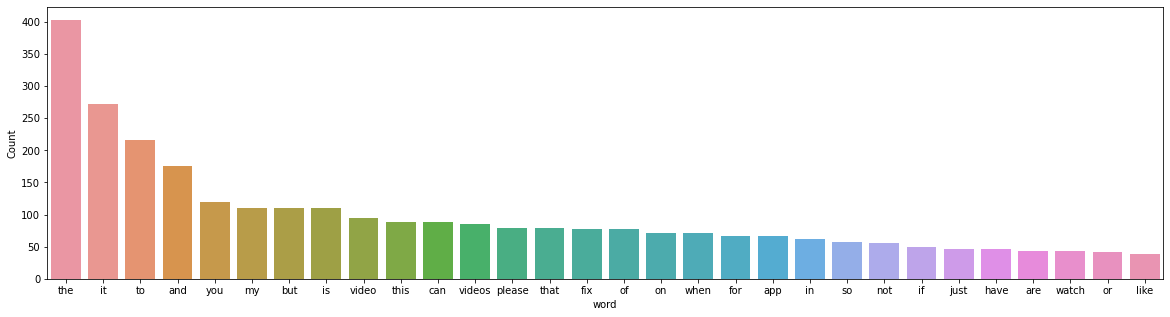

In [79]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score4))

In [80]:
# Clean text
review_ph_ready_score4 = process_words(review_words_ph_score4)  # processed Text Data! - move to each section

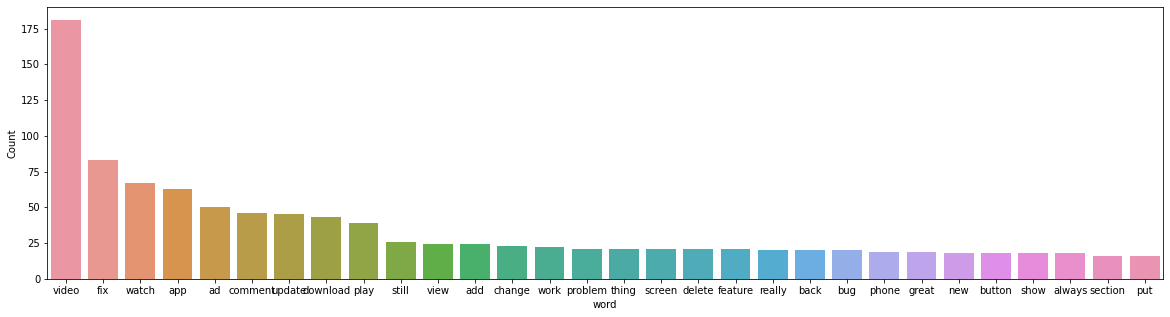

In [81]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score4))


In [82]:
# Create Dictionary
id2word_ph_score4 = corpora.Dictionary(review_ph_ready_score4)

2021-10-17 00:11:03,721 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:11:03,731 [INFO] gensim.corpora.dictionary - built Dictionary(792 unique tokens: ['allow', 'mobile', 'mode', 'night', 'phone']...) from 274 documents (total 2960 corpus positions)
2021-10-17 00:11:03,732 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(792 unique tokens: ['allow', 'mobile', 'mode', 'night', 'phone']...) from 274 documents (total 2960 corpus positions)", 'datetime': '2021-10-17T00:11:03.732676', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [83]:
# Create Corpus: Term Document Frequency
corpus_ph_score4 = [id2word_ph_score4.doc2bow(text) for text in review_ph_ready_score4]

In [84]:
# Training LDA model
model_list_ph_score4, coherence_values_ph_score4 = compute_coherence_values(dictionary=id2word_ph_score4, corpus=corpus_ph_score4, 
                                                              texts=review_ph_ready_score4, limit=30, start=2, step=5)


2021-10-17 00:11:03,757 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:11:03,760 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:11:03,763 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:11:03,765 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 274 documents, updating model once every 274 documents, evaluating perplexity every 274 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:11:04,767 [INFO] gensim.models.ldamodel - -7.303 per-word bound, 157.9 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:11:04,774 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #274/274
2021-10-17 00:11:05,527 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"video" + 0.022*"fix" + 0.018*"app" + 0.016*"comment" + 0.015*"download" + 0.014*"play" + 0.013*"a

2021-10-17 00:11:15,271 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.052*"video" + 0.027*"fix" + 0.026*"watch" + 0.020*"update" + 0.019*"ad" + 0.017*"app" + 0.011*"change" + 0.009*"add" + 0.008*"show" + 0.007*"channel"
2021-10-17 00:11:15,272 [INFO] gensim.models.ldamodel - topic diff=0.013595, rho=0.301511
2021-10-17 00:11:15,727 [INFO] gensim.models.ldamodel - -6.207 per-word bound, 73.9 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:11:15,729 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #274/274
2021-10-17 00:11:16,217 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"video" + 0.020*"download" + 0.020*"comment" + 0.018*"fix" + 0.017*"app" + 0.015*"play" + 0.013*"view" + 0.011*"delete" + 0.011*"still" + 0.011*"watch"
2021-10-17 00:11:16,219 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.052*"video" + 0.027*"fix" + 0.026*"watch" + 0.020*"update" + 0.019*"ad" + 0.017*"app" + 0.011*"change" + 0.009*"add"

2021-10-17 00:11:23,425 [INFO] gensim.models.ldamodel - topic diff=0.007291, rho=0.218218
2021-10-17 00:11:23,807 [INFO] gensim.models.ldamodel - -6.197 per-word bound, 73.4 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:11:23,810 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #274/274
2021-10-17 00:11:24,222 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"video" + 0.022*"comment" + 0.022*"download" + 0.018*"fix" + 0.017*"app" + 0.015*"play" + 0.013*"view" + 0.011*"delete" + 0.011*"still" + 0.010*"watch"
2021-10-17 00:11:24,224 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"video" + 0.027*"fix" + 0.027*"watch" + 0.021*"ad" + 0.019*"update" + 0.017*"app" + 0.012*"change" + 0.009*"add" + 0.008*"show" + 0.007*"channel"
2021-10-17 00:11:24,227 [INFO] gensim.models.ldamodel - topic diff=0.006930, rho=0.213201
2021-10-17 00:11:24,660 [INFO] gensim.models.ldamodel - -6.197 per-word bound, 73.3 perplexity estimat

2021-10-17 00:11:31,607 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #274/274
2021-10-17 00:11:31,983 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"video" + 0.023*"comment" + 0.022*"download" + 0.018*"fix" + 0.017*"app" + 0.015*"play" + 0.013*"view" + 0.011*"delete" + 0.011*"still" + 0.010*"watch"
2021-10-17 00:11:31,984 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"video" + 0.027*"watch" + 0.027*"fix" + 0.021*"ad" + 0.019*"update" + 0.018*"app" + 0.013*"change" + 0.009*"add" + 0.007*"show" + 0.007*"channel"
2021-10-17 00:11:31,986 [INFO] gensim.models.ldamodel - topic diff=0.003879, rho=0.176777
2021-10-17 00:11:32,394 [INFO] gensim.models.ldamodel - -6.192 per-word bound, 73.1 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:11:32,396 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #274/274
2021-10-17 00:11:32,691 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"video" + 0.023*

2021-10-17 00:11:39,399 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"video" + 0.027*"watch" + 0.027*"fix" + 0.022*"ad" + 0.019*"update" + 0.018*"app" + 0.013*"change" + 0.009*"add" + 0.007*"channel" + 0.007*"show"
2021-10-17 00:11:39,400 [INFO] gensim.models.ldamodel - topic diff=0.003707, rho=0.154303
2021-10-17 00:11:39,903 [INFO] gensim.models.ldamodel - -6.189 per-word bound, 73.0 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:11:39,907 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #274/274
2021-10-17 00:11:40,305 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"video" + 0.023*"comment" + 0.022*"download" + 0.018*"fix" + 0.016*"app" + 0.015*"play" + 0.013*"view" + 0.011*"delete" + 0.011*"still" + 0.010*"watch"
2021-10-17 00:11:40,341 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.051*"video" + 0.027*"watch" + 0.027*"fix" + 0.022*"ad" + 0.019*"update" + 0.018*"app" + 0.013*"change" + 0.009*"add"

2021-10-17 00:11:51,585 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 255 virtual documents
2021-10-17 00:11:52,012 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:11:52,013 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:11:52,023 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:11:52,030 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 274 documents, updating model once every 274 documents, evaluating perplexity every 274 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:11:52,776 [INFO] gensim.models.ldamodel - -9.132 per-word bound, 561.0 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:11:52,789 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #274/274
2021-10-17 00:11

2021-10-17 00:11:56,114 [INFO] gensim.models.ldamodel - topic diff=0.060468, rho=0.408248
2021-10-17 00:11:56,414 [INFO] gensim.models.ldamodel - -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:11:56,416 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #274/274
2021-10-17 00:11:56,650 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"video" + 0.046*"watch" + 0.037*"fix" + 0.017*"app" + 0.013*"comment" + 0.012*"show" + 0.012*"reply" + 0.011*"problem" + 0.011*"well" + 0.011*"scroll"
2021-10-17 00:11:56,652 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"change" + 0.026*"section" + 0.024*"comment" + 0.023*"update" + 0.017*"video" + 0.016*"add" + 0.016*"profile" + 0.016*"download" + 0.016*"banner" + 0.013*"fix"
2021-10-17 00:11:56,654 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.025*"comment" + 0.024*"button" + 0.021*"update" + 0.020*"fix" + 0.015*"new" + 0.012*"quality" + 0.012*"r

2021-10-17 00:12:00,119 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"change" + 0.026*"section" + 0.024*"update" + 0.024*"comment" + 0.020*"profile" + 0.017*"banner" + 0.016*"download" + 0.015*"video" + 0.015*"add" + 0.014*"back"
2021-10-17 00:12:00,122 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.050*"video" + 0.031*"app" + 0.025*"download" + 0.022*"delete" + 0.022*"view" + 0.020*"comment" + 0.019*"still" + 0.016*"fix" + 0.015*"play" + 0.014*"work"
2021-10-17 00:12:00,124 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.056*"video" + 0.026*"fix" + 0.025*"app" + 0.024*"update" + 0.022*"play" + 0.020*"watch" + 0.015*"button" + 0.014*"bug" + 0.013*"show" + 0.012*"really"
2021-10-17 00:12:00,126 [INFO] gensim.models.ldamodel - topic diff=0.015014, rho=0.288675
2021-10-17 00:12:00,568 [INFO] gensim.models.ldamodel - -6.474 per-word bound, 88.9 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:00,569 [INFO] gensim.models.ld

2021-10-17 00:12:03,608 [INFO] gensim.models.ldamodel - topic diff=0.007195, rho=0.242536
2021-10-17 00:12:03,976 [INFO] gensim.models.ldamodel - -6.465 per-word bound, 88.4 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:03,977 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #274/274
2021-10-17 00:12:04,220 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.050*"video" + 0.030*"app" + 0.024*"view" + 0.023*"download" + 0.023*"delete" + 0.020*"comment" + 0.019*"still" + 0.016*"fix" + 0.015*"play" + 0.014*"work"
2021-10-17 00:12:04,221 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.074*"video" + 0.050*"watch" + 0.038*"fix" + 0.017*"app" + 0.014*"comment" + 0.014*"problem" + 0.012*"show" + 0.012*"reply" + 0.012*"well" + 0.011*"scroll"
2021-10-17 00:12:04,224 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"change" + 0.026*"section" + 0.025*"update" + 0.024*"comment" + 0.021*"profile" + 0.017*"download" + 0.017*"

2021-10-17 00:12:08,118 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"video" + 0.030*"fix" + 0.022*"caption" + 0.021*"update" + 0.021*"watch" + 0.018*"offline" + 0.017*"thing" + 0.013*"great" + 0.012*"always" + 0.011*"problem"
2021-10-17 00:12:08,122 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"video" + 0.027*"app" + 0.027*"fix" + 0.025*"play" + 0.024*"update" + 0.020*"watch" + 0.015*"bug" + 0.015*"button" + 0.013*"show" + 0.012*"really"
2021-10-17 00:12:08,124 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.049*"video" + 0.030*"app" + 0.026*"view" + 0.023*"delete" + 0.022*"download" + 0.020*"comment" + 0.019*"still" + 0.017*"fix" + 0.014*"play" + 0.014*"work"
2021-10-17 00:12:08,126 [INFO] gensim.models.ldamodel - topic diff=0.003949, rho=0.208514
2021-10-17 00:12:08,617 [INFO] gensim.models.ldamodel - -6.460 per-word bound, 88.0 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:08,626 [INFO] gensim.models.ldamo

2021-10-17 00:12:11,610 [INFO] gensim.models.ldamodel - topic diff=0.002573, rho=0.188982
2021-10-17 00:12:11,921 [INFO] gensim.models.ldamodel - -6.458 per-word bound, 87.9 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:11,922 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #274/274
2021-10-17 00:12:12,216 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"video" + 0.027*"app" + 0.027*"fix" + 0.025*"play" + 0.024*"update" + 0.020*"watch" + 0.015*"bug" + 0.015*"button" + 0.013*"show" + 0.012*"really"
2021-10-17 00:12:12,218 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.062*"ad" + 0.058*"video" + 0.024*"play" + 0.018*"post" + 0.016*"device" + 0.014*"community" + 0.013*"fix" + 0.013*"sometimes" + 0.012*"app" + 0.011*"feature"
2021-10-17 00:12:12,220 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.049*"video" + 0.030*"app" + 0.027*"view" + 0.023*"delete" + 0.022*"download" + 0.020*"comment" + 0.018*"still" + 

2021-10-17 00:12:15,013 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.025*"button" + 0.024*"comment" + 0.022*"update" + 0.018*"new" + 0.018*"quality" + 0.018*"fix" + 0.016*"really" + 0.013*"channel" + 0.012*"star" + 0.010*"option"
2021-10-17 00:12:15,014 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.076*"video" + 0.052*"watch" + 0.037*"fix" + 0.017*"app" + 0.015*"comment" + 0.015*"problem" + 0.012*"show" + 0.012*"reply" + 0.012*"well" + 0.011*"scroll"
2021-10-17 00:12:15,015 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"video" + 0.027*"app" + 0.027*"fix" + 0.025*"play" + 0.024*"update" + 0.020*"watch" + 0.015*"bug" + 0.015*"button" + 0.013*"show" + 0.012*"really"
2021-10-17 00:12:15,016 [INFO] gensim.models.ldamodel - topic diff=0.001911, rho=0.171499
2021-10-17 00:12:15,345 [INFO] gensim.models.ldamodel - -6.455 per-word bound, 87.7 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:15,349 [INFO] gensim.models.ldamod

2021-10-17 00:12:18,029 [INFO] gensim.models.ldamodel - topic diff=0.001363, rho=0.160128
2021-10-17 00:12:18,353 [INFO] gensim.models.ldamodel - -6.453 per-word bound, 87.6 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:18,354 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #274/274
2021-10-17 00:12:18,606 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.064*"ad" + 0.058*"video" + 0.024*"play" + 0.018*"post" + 0.016*"device" + 0.014*"community" + 0.013*"fix" + 0.012*"sometimes" + 0.012*"app" + 0.011*"feature"
2021-10-17 00:12:18,608 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.025*"button" + 0.024*"comment" + 0.022*"update" + 0.018*"new" + 0.018*"quality" + 0.017*"fix" + 0.016*"really" + 0.013*"channel" + 0.013*"star" + 0.010*"option"
2021-10-17 00:12:18,611 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"video" + 0.027*"app" + 0.027*"fix" + 0.025*"play" + 0.024*"update" + 0.020*"watch" + 0.015*"bug" +

2021-10-17 00:12:21,560 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.025*"button" + 0.024*"comment" + 0.022*"update" + 0.019*"new" + 0.019*"quality" + 0.017*"fix" + 0.016*"really" + 0.013*"channel" + 0.013*"star" + 0.010*"option"
2021-10-17 00:12:21,564 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.076*"video" + 0.052*"watch" + 0.036*"fix" + 0.017*"app" + 0.015*"comment" + 0.015*"problem" + 0.012*"show" + 0.012*"reply" + 0.012*"well" + 0.011*"scroll"
2021-10-17 00:12:21,570 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"change" + 0.026*"update" + 0.025*"section" + 0.023*"comment" + 0.021*"profile" + 0.020*"back" + 0.017*"download" + 0.016*"banner" + 0.015*"much" + 0.015*"put"
2021-10-17 00:12:21,573 [INFO] gensim.models.ldamodel - topic diff=0.000743, rho=0.149071
2021-10-17 00:12:21,836 [INFO] gensim.models.ldamodel - -6.453 per-word bound, 87.6 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:21,839 [INFO] gensim.

2021-10-17 00:12:24,761 [INFO] gensim.models.ldamodel - topic diff=0.000443, rho=0.141421
2021-10-17 00:12:25,128 [INFO] gensim.models.ldamodel - -6.453 per-word bound, 87.6 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:25,129 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #274/274
2021-10-17 00:12:25,423 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"video" + 0.027*"app" + 0.027*"fix" + 0.025*"play" + 0.024*"update" + 0.020*"watch" + 0.015*"bug" + 0.015*"button" + 0.013*"show" + 0.012*"really"
2021-10-17 00:12:25,425 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.076*"video" + 0.052*"watch" + 0.036*"fix" + 0.017*"app" + 0.015*"comment" + 0.015*"problem" + 0.012*"show" + 0.012*"reply" + 0.012*"well" + 0.011*"scroll"
2021-10-17 00:12:25,427 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.065*"ad" + 0.058*"video" + 0.024*"play" + 0.018*"post" + 0.016*"device" + 0.014*"community" + 0.013*"fix" + 0.012*"s

2021-10-17 00:12:34,137 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.041*"change" + 0.038*"comment" + 0.036*"section" + 0.026*"add" + 0.024*"profile" + 0.023*"back" + 0.022*"update" + 0.018*"put" + 0.018*"account" + 0.018*"pic"
2021-10-17 00:12:34,139 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.056*"ad" + 0.050*"video" + 0.038*"view" + 0.023*"play" + 0.017*"fix" + 0.016*"sometimes" + 0.015*"always" + 0.015*"music" + 0.014*"delete" + 0.012*"however"
2021-10-17 00:12:34,141 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.034*"fix" + 0.032*"video" + 0.032*"app" + 0.019*"problem" + 0.018*"still" + 0.017*"work" + 0.016*"play" + 0.015*"ad" + 0.015*"time" + 0.014*"love"
2021-10-17 00:12:34,144 [INFO] gensim.models.ldamodel - topic diff=0.074869, rho=0.447214
2021-10-17 00:12:34,469 [INFO] gensim.models.ldamodel - -6.677 per-word bound, 102.3 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:34,471 [INFO] gensim.models.ldamodel 

2021-10-17 00:12:37,631 [INFO] gensim.models.ldamodel - topic diff=0.026443, rho=0.316228
2021-10-17 00:12:37,901 [INFO] gensim.models.ldamodel - -6.628 per-word bound, 98.9 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:37,905 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #274/274
2021-10-17 00:12:38,135 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"button" + 0.023*"app" + 0.020*"download" + 0.018*"comment" + 0.017*"channel" + 0.014*"update" + 0.013*"quality" + 0.013*"new" + 0.013*"compatible" + 0.012*"version"
2021-10-17 00:12:38,137 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.051*"fix" + 0.040*"video" + 0.029*"watch" + 0.019*"thing" + 0.019*"phone" + 0.014*"update" + 0.014*"comment" + 0.014*"people" + 0.014*"upload" + 0.013*"still"
2021-10-17 00:12:38,139 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"video" + 0.033*"app" + 0.029*"stop" + 0.023*"download" + 0.021*"change" + 0.021*"hope" + 

2021-10-17 00:12:40,845 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.062*"video" + 0.033*"download" + 0.029*"scroll" + 0.025*"app" + 0.023*"watch" + 0.023*"fix" + 0.022*"update" + 0.020*"still" + 0.015*"reason" + 0.015*"press"
2021-10-17 00:12:40,848 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.074*"video" + 0.042*"delete" + 0.039*"play" + 0.034*"watch" + 0.032*"add" + 0.028*"fix" + 0.026*"ad" + 0.024*"view" + 0.021*"star" + 0.018*"give"
2021-10-17 00:12:40,850 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.070*"ad" + 0.052*"video" + 0.045*"view" + 0.024*"play" + 0.017*"fix" + 0.016*"always" + 0.016*"music" + 0.016*"delete" + 0.015*"sometimes" + 0.013*"however"
2021-10-17 00:12:40,851 [INFO] gensim.models.ldamodel - topic diff=0.009932, rho=0.250000
2021-10-17 00:12:41,135 [INFO] gensim.models.ldamodel - -6.608 per-word bound, 97.6 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:41,136 [INFO] gensim.models.ldamodel - 

2021-10-17 00:12:43,479 [INFO] gensim.models.ldamodel - topic diff=0.004639, rho=0.218218
2021-10-17 00:12:43,808 [INFO] gensim.models.ldamodel - -6.603 per-word bound, 97.2 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:43,811 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #274/274
2021-10-17 00:12:43,983 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"comment" + 0.047*"section" + 0.044*"change" + 0.027*"profile" + 0.027*"back" + 0.026*"update" + 0.023*"add" + 0.021*"new" + 0.019*"put" + 0.017*"pic"
2021-10-17 00:12:43,986 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.039*"video" + 0.028*"watch" + 0.020*"people" + 0.018*"app" + 0.017*"comment" + 0.017*"annoying" + 0.016*"add" + 0.015*"fix" + 0.014*"channel" + 0.014*"crash"
2021-10-17 00:12:43,988 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.071*"ad" + 0.053*"video" + 0.045*"view" + 0.024*"play" + 0.017*"fix" + 0.017*"always" + 0.017*"music" + 0.016

2021-10-17 00:12:46,797 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"video" + 0.029*"watch" + 0.024*"fix" + 0.020*"offline" + 0.018*"download" + 0.016*"comment" + 0.015*"option" + 0.014*"play" + 0.013*"device" + 0.012*"update"
2021-10-17 00:12:46,814 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.047*"post" + 0.037*"video" + 0.034*"community" + 0.026*"ad" + 0.023*"download" + 0.022*"fix" + 0.021*"ipad" + 0.017*"people" + 0.017*"much" + 0.017*"device"
2021-10-17 00:12:46,821 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.075*"video" + 0.042*"delete" + 0.040*"play" + 0.034*"watch" + 0.032*"add" + 0.028*"fix" + 0.026*"ad" + 0.025*"view" + 0.021*"star" + 0.018*"give"
2021-10-17 00:12:46,837 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.068*"video" + 0.035*"caption" + 0.027*"watch" + 0.023*"update" + 0.023*"always" + 0.019*"fix" + 0.017*"app" + 0.017*"whenever" + 0.014*"speed" + 0.014*"copyright"
2021-10-17 00:12:46,846 [INFO] gensim.models.ldamodel - topic diff

2021-10-17 00:12:49,668 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.040*"fix" + 0.038*"app" + 0.032*"video" + 0.019*"play" + 0.019*"problem" + 0.018*"still" + 0.017*"work" + 0.017*"screen" + 0.015*"time" + 0.014*"ad"
2021-10-17 00:12:49,671 [INFO] gensim.models.ldamodel - topic diff=0.001148, rho=0.176777
2021-10-17 00:12:50,009 [INFO] gensim.models.ldamodel - -6.600 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:50,011 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #274/274
2021-10-17 00:12:50,243 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.075*"video" + 0.042*"delete" + 0.040*"play" + 0.034*"watch" + 0.032*"add" + 0.028*"fix" + 0.026*"ad" + 0.025*"view" + 0.021*"star" + 0.018*"give"
2021-10-17 00:12:50,245 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"video" + 0.033*"app" + 0.030*"stop" + 0.024*"download" + 0.021*"hope" + 0.021*"change" + 0.017*"update" + 0.017*"descripti

2021-10-17 00:12:52,983 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.044*"fix" + 0.040*"video" + 0.019*"thing" + 0.019*"phone" + 0.019*"watch" + 0.015*"update" + 0.015*"comment" + 0.015*"people" + 0.015*"upload" + 0.014*"still"
2021-10-17 00:12:52,984 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.047*"post" + 0.037*"video" + 0.034*"community" + 0.026*"ad" + 0.023*"download" + 0.022*"fix" + 0.021*"ipad" + 0.017*"people" + 0.017*"much" + 0.017*"device"
2021-10-17 00:12:52,986 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.075*"video" + 0.042*"delete" + 0.040*"play" + 0.034*"watch" + 0.032*"add" + 0.028*"fix" + 0.026*"ad" + 0.025*"view" + 0.021*"star" + 0.018*"give"
2021-10-17 00:12:52,988 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"button" + 0.021*"download" + 0.019*"app" + 0.019*"comment" + 0.017*"channel" + 0.014*"update" + 0.013*"quality" + 0.013*"new" + 0.013*"compatible" + 0.013*"version"
2021-10-17 00:12:52,989 [INFO] gensim.models.ldamodel - topic d

2021-10-17 00:12:55,853 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.044*"fix" + 0.040*"video" + 0.019*"thing" + 0.019*"phone" + 0.019*"watch" + 0.015*"update" + 0.015*"comment" + 0.015*"upload" + 0.015*"people" + 0.014*"still"
2021-10-17 00:12:55,854 [INFO] gensim.models.ldamodel - topic diff=0.000439, rho=0.152499
2021-10-17 00:12:56,144 [INFO] gensim.models.ldamodel - -6.599 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:12:56,146 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #274/274
2021-10-17 00:12:56,362 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"button" + 0.021*"download" + 0.019*"app" + 0.018*"comment" + 0.017*"channel" + 0.014*"update" + 0.013*"quality" + 0.013*"new" + 0.013*"compatible" + 0.013*"version"
2021-10-17 00:12:56,364 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"video" + 0.033*"app" + 0.030*"stop" + 0.024*"download" + 0.021*"hope" + 0.021*"change" +

2021-10-17 00:12:59,241 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"video" + 0.033*"app" + 0.030*"stop" + 0.024*"download" + 0.021*"hope" + 0.021*"change" + 0.017*"update" + 0.017*"description" + 0.015*"ad" + 0.014*"fix"
2021-10-17 00:12:59,243 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.027*"button" + 0.021*"download" + 0.019*"app" + 0.018*"comment" + 0.017*"channel" + 0.014*"update" + 0.013*"quality" + 0.013*"new" + 0.013*"compatible" + 0.013*"version"
2021-10-17 00:12:59,244 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.040*"video" + 0.028*"watch" + 0.020*"people" + 0.018*"app" + 0.017*"annoying" + 0.015*"fix" + 0.015*"channel" + 0.015*"crash" + 0.014*"add" + 0.012*"back"
2021-10-17 00:12:59,246 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.075*"video" + 0.042*"delete" + 0.040*"play" + 0.034*"watch" + 0.032*"add" + 0.028*"fix" + 0.026*"ad" + 0.025*"view" + 0.021*"star" + 0.018*"give"
2021-10-17 00:12:59,247 [INFO] gensim.models.ldamodel - topic diff=

2021-10-17 00:13:08,784 [INFO] gensim.models.ldamodel - topic diff=0.170163, rho=0.577350
2021-10-17 00:13:09,226 [INFO] gensim.models.ldamodel - -6.868 per-word bound, 116.8 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:09,227 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #274/274
2021-10-17 00:13:09,483 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.062*"video" + 0.028*"speed" + 0.026*"watch" + 0.020*"copyright" + 0.016*"button" + 0.015*"bug" + 0.015*"update" + 0.015*"fix" + 0.015*"show" + 0.015*"really"
2021-10-17 00:13:09,485 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.034*"fix" + 0.031*"people" + 0.026*"community" + 0.026*"ipad" + 0.025*"post" + 0.023*"device" + 0.019*"new" + 0.019*"comment" + 0.016*"hate" + 0.013*"io"
2021-10-17 00:13:09,486 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.047*"video" + 0.031*"watch" + 0.030*"update" + 0.023*"screen" + 0.023*"app" + 0.016*"help" + 0.016*"bug" + 0

2021-10-17 00:13:12,983 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.031*"video" + 0.023*"ad" + 0.023*"post" + 0.019*"app" + 0.019*"much" + 0.018*"fix" + 0.015*"comment" + 0.015*"community" + 0.015*"edit" + 0.015*"device"
2021-10-17 00:13:12,985 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.023*"change" + 0.023*"profile" + 0.022*"app" + 0.021*"add" + 0.017*"update" + 0.017*"play" + 0.017*"banner" + 0.016*"new" + 0.015*"phone" + 0.015*"old"
2021-10-17 00:13:12,987 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.072*"video" + 0.052*"comment" + 0.040*"watch" + 0.028*"delete" + 0.027*"play" + 0.025*"ad" + 0.022*"back" + 0.018*"screen" + 0.018*"hard" + 0.018*"bring"
2021-10-17 00:13:12,989 [INFO] gensim.models.ldamodel - topic diff=0.037003, rho=0.333333
2021-10-17 00:13:13,362 [INFO] gensim.models.ldamodel - -6.738 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:13,365 [INFO] gensim.models.ldamodel - 

2021-10-17 00:13:16,166 [INFO] gensim.models.ldamodel - topic diff=0.010250, rho=0.267261
2021-10-17 00:13:16,503 [INFO] gensim.models.ldamodel - -6.726 per-word bound, 105.9 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:16,505 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #274/274
2021-10-17 00:13:16,762 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.080*"ad" + 0.060*"video" + 0.027*"view" + 0.024*"sometimes" + 0.020*"remove" + 0.017*"fix" + 0.017*"delete" + 0.017*"reason" + 0.016*"play" + 0.016*"home"
2021-10-17 00:13:16,764 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.082*"video" + 0.027*"fix" + 0.025*"watch" + 0.022*"scroll" + 0.019*"ad" + 0.018*"download" + 0.016*"search" + 0.016*"find" + 0.013*"app" + 0.013*"song"
2021-10-17 00:13:16,766 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"update" + 0.024*"quality" + 0.023*"fix" + 0.018*"well" + 0.012*"download" + 0.012*"hour" + 0.012*"channel" + 

2021-10-17 00:13:19,633 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.051*"fix" + 0.029*"video" + 0.027*"bug" + 0.025*"view" + 0.021*"picture" + 0.015*"play" + 0.014*"watch" + 0.014*"give" + 0.014*"star" + 0.014*"reply"
2021-10-17 00:13:19,634 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.033*"video" + 0.022*"post" + 0.021*"ad" + 0.019*"app" + 0.018*"fix" + 0.018*"much" + 0.017*"edit" + 0.015*"comment" + 0.015*"playlist" + 0.015*"whenever"
2021-10-17 00:13:19,635 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.037*"ipad" + 0.034*"community" + 0.034*"people" + 0.030*"post" + 0.030*"fix" + 0.027*"device" + 0.026*"hate" + 0.021*"comment" + 0.017*"new" + 0.017*"add"
2021-10-17 00:13:19,637 [INFO] gensim.models.ldamodel - topic diff=0.004165, rho=0.223607
2021-10-17 00:13:19,978 [INFO] gensim.models.ldamodel - -6.718 per-word bound, 105.3 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:19,979 [INFO] gensim.models.ldamodel -

2021-10-17 00:13:22,440 [INFO] gensim.models.ldamodel - topic diff=0.002425, rho=0.200000
2021-10-17 00:13:22,692 [INFO] gensim.models.ldamodel - -6.715 per-word bound, 105.1 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:22,694 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #274/274
2021-10-17 00:13:22,944 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.081*"video" + 0.026*"fix" + 0.025*"watch" + 0.022*"scroll" + 0.019*"ad" + 0.018*"download" + 0.016*"search" + 0.016*"find" + 0.013*"app" + 0.013*"song"
2021-10-17 00:13:22,945 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.051*"video" + 0.034*"watch" + 0.031*"update" + 0.023*"screen" + 0.023*"app" + 0.018*"bug" + 0.016*"help" + 0.016*"crash" + 0.016*"black" + 0.016*"audio"
2021-10-17 00:13:22,947 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.023*"change" + 0.023*"profile" + 0.022*"app" + 0.020*"add" + 0.018*"update" + 0.018*"banner" + 0.017*"new" + 0.015

2021-10-17 00:13:25,749 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.053*"video" + 0.036*"app" + 0.029*"watch" + 0.025*"keep" + 0.023*"update" + 0.023*"fix" + 0.022*"download" + 0.018*"happen" + 0.015*"still" + 0.015*"well"
2021-10-17 00:13:25,754 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.042*"update" + 0.024*"quality" + 0.023*"fix" + 0.018*"well" + 0.012*"download" + 0.012*"saver" + 0.012*"hour" + 0.012*"banner" + 0.012*"channel" + 0.012*"add"
2021-10-17 00:13:25,757 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.080*"video" + 0.025*"fix" + 0.025*"watch" + 0.022*"scroll" + 0.019*"ad" + 0.018*"download" + 0.018*"search" + 0.016*"find" + 0.013*"app" + 0.013*"song"
2021-10-17 00:13:25,759 [INFO] gensim.models.ldamodel - topic diff=0.001769, rho=0.179605
2021-10-17 00:13:26,111 [INFO] gensim.models.ldamodel - -6.714 per-word bound, 105.0 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:26,112 [INFO] gensim.models.ldamo

2021-10-17 00:13:28,519 [INFO] gensim.models.ldamodel - topic diff=0.001257, rho=0.166667
2021-10-17 00:13:28,854 [INFO] gensim.models.ldamodel - -6.712 per-word bound, 104.9 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:28,855 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #274/274
2021-10-17 00:13:28,973 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.083*"video" + 0.036*"fix" + 0.031*"caption" + 0.025*"update" + 0.023*"problem" + 0.023*"offline" + 0.021*"watch" + 0.018*"always" + 0.015*"thing" + 0.015*"great"
2021-10-17 00:13:28,975 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.080*"video" + 0.025*"fix" + 0.025*"watch" + 0.022*"scroll" + 0.019*"ad" + 0.018*"search" + 0.018*"download" + 0.016*"find" + 0.013*"app" + 0.013*"song"
2021-10-17 00:13:28,977 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.053*"video" + 0.034*"watch" + 0.030*"update" + 0.023*"screen" + 0.023*"app" + 0.022*"bug" + 0.015*"help" +

2021-10-17 00:13:31,861 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.047*"community" + 0.042*"ipad" + 0.033*"people" + 0.032*"post" + 0.030*"device" + 0.029*"fix" + 0.026*"hate" + 0.022*"comment" + 0.018*"add" + 0.017*"new"
2021-10-17 00:13:31,862 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.053*"video" + 0.034*"watch" + 0.030*"update" + 0.023*"screen" + 0.023*"app" + 0.022*"bug" + 0.015*"crash" + 0.015*"black" + 0.015*"audio" + 0.015*"banner"
2021-10-17 00:13:31,864 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.042*"update" + 0.024*"quality" + 0.023*"fix" + 0.018*"well" + 0.012*"download" + 0.012*"saver" + 0.012*"hour" + 0.012*"banner" + 0.012*"channel" + 0.012*"add"
2021-10-17 00:13:31,865 [INFO] gensim.models.ldamodel - topic diff=0.001045, rho=0.154303
2021-10-17 00:13:32,158 [INFO] gensim.models.ldamodel - -6.711 per-word bound, 104.8 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:32,161 [INFO] gensim.models.l

2021-10-17 00:13:34,548 [INFO] gensim.models.ldamodel - topic diff=0.001079, rho=0.145865
2021-10-17 00:13:34,915 [INFO] gensim.models.ldamodel - -6.710 per-word bound, 104.7 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:34,934 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #274/274
2021-10-17 00:13:35,133 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.036*"fix" + 0.031*"watch" + 0.031*"change" + 0.026*"video" + 0.026*"reply" + 0.021*"work" + 0.021*"comment" + 0.021*"app" + 0.016*"problem" + 0.016*"time"
2021-10-17 00:13:35,135 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.038*"app" + 0.032*"button" + 0.026*"update" + 0.026*"ad" + 0.019*"comment" + 0.019*"stop" + 0.015*"watch" + 0.015*"download" + 0.014*"video" + 0.013*"edit"
2021-10-17 00:13:35,137 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.034*"video" + 0.021*"post" + 0.019*"ad" + 0.019*"app" + 0.019*"edit" + 0.018*"fix" + 0.018*"whenever" + 0.016

2021-10-17 00:13:44,950 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.073*"video" + 0.035*"fix" + 0.027*"caption" + 0.024*"phone" + 0.019*"watch" + 0.013*"different" + 0.013*"storage" + 0.013*"still" + 0.013*"always" + 0.012*"community"
2021-10-17 00:13:44,955 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.062*"video" + 0.025*"watch" + 0.022*"copyright" + 0.021*"update" + 0.021*"always" + 0.020*"speed" + 0.017*"view" + 0.017*"happen" + 0.015*"audio" + 0.015*"play"
2021-10-17 00:13:44,959 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.038*"video" + 0.034*"watch" + 0.032*"update" + 0.023*"download" + 0.019*"always" + 0.017*"still" + 0.015*"fix" + 0.015*"app" + 0.012*"channel" + 0.012*"computer"
2021-10-17 00:13:44,963 [INFO] gensim.models.ldamodel - topic diff=17.754887, rho=1.000000
2021-10-17 00:13:45,308 [INFO] gensim.models.ldamodel - -7.083 per-word bound, 135.5 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:45,310 [

2021-10-17 00:13:48,629 [INFO] gensim.models.ldamodel - topic diff=0.061418, rho=0.377964
2021-10-17 00:13:49,039 [INFO] gensim.models.ldamodel - -6.858 per-word bound, 116.0 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:49,043 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #274/274
2021-10-17 00:13:49,240 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.047*"video" + 0.029*"fix" + 0.028*"bug" + 0.028*"screen" + 0.024*"whenever" + 0.021*"crash" + 0.020*"download" + 0.020*"help" + 0.014*"black" + 0.014*"audio"
2021-10-17 00:13:49,243 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.051*"video" + 0.050*"much" + 0.026*"load" + 0.026*"fix" + 0.026*"bar" + 0.026*"problem" + 0.026*"ad" + 0.025*"advertisement" + 0.013*"top" + 0.013*"whole"
2021-10-17 00:13:49,246 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.068*"button" + 0.041*"app" + 0.035*"video" + 0.026*"download" + 0.026*"fix" + 0.021*"bug" + 0.021*"great" +

2021-10-17 00:13:53,290 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.089*"video" + 0.051*"play" + 0.050*"ad" + 0.025*"download" + 0.019*"back" + 0.019*"screen" + 0.017*"app" + 0.016*"feature" + 0.016*"put" + 0.015*"fix"
2021-10-17 00:13:53,295 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.027*"fix" + 0.027*"back" + 0.027*"thing" + 0.027*"watch" + 0.014*"video" + 0.014*"screen" + 0.014*"help" + 0.014*"retry" + 0.014*"fav" + 0.014*"anyways"
2021-10-17 00:13:53,297 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.045*"video" + 0.033*"watch" + 0.033*"update" + 0.019*"download" + 0.019*"always" + 0.017*"still" + 0.014*"fix" + 0.014*"channel" + 0.014*"computer" + 0.014*"art"
2021-10-17 00:13:53,298 [INFO] gensim.models.ldamodel - topic diff=0.017369, rho=0.277350
2021-10-17 00:13:53,629 [INFO] gensim.models.ldamodel - -6.822 per-word bound, 113.1 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:53,630 [INFO] gensim.models.lda

2021-10-17 00:13:56,176 [INFO] gensim.models.ldamodel - topic diff=0.006957, rho=0.235702
2021-10-17 00:13:56,485 [INFO] gensim.models.ldamodel - -6.815 per-word bound, 112.6 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:13:56,486 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #274/274
2021-10-17 00:13:56,735 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.045*"video" + 0.033*"watch" + 0.033*"update" + 0.019*"download" + 0.019*"always" + 0.017*"still" + 0.014*"fix" + 0.014*"channel" + 0.014*"computer" + 0.014*"art"
2021-10-17 00:13:56,737 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.048*"video" + 0.029*"screen" + 0.026*"bug" + 0.024*"whenever" + 0.023*"fix" + 0.022*"crash" + 0.022*"download" + 0.022*"help" + 0.015*"quality" + 0.015*"update"
2021-10-17 00:13:56,738 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.038*"yt" + 0.032*"keep" + 0.032*"ad" + 0.025*"already" + 0.022*"still" + 0.021*"video" + 0.019*

2021-10-17 00:13:59,656 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.027*"fix" + 0.027*"back" + 0.027*"thing" + 0.027*"watch" + 0.014*"video" + 0.014*"screen" + 0.014*"help" + 0.014*"literally" + 0.014*"wifi" + 0.014*"fav"
2021-10-17 00:13:59,658 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.035*"fix" + 0.032*"add" + 0.031*"comment" + 0.025*"banner" + 0.018*"channel" + 0.018*"update" + 0.015*"thing" + 0.013*"profile" + 0.013*"change" + 0.012*"administrator"
2021-10-17 00:13:59,661 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.049*"video" + 0.029*"screen" + 0.025*"bug" + 0.023*"fix" + 0.023*"whenever" + 0.022*"crash" + 0.022*"download" + 0.022*"help" + 0.015*"quality" + 0.015*"update"
2021-10-17 00:13:59,665 [INFO] gensim.models.ldamodel - topic diff=0.003139, rho=0.204124
2021-10-17 00:14:00,046 [INFO] gensim.models.ldamodel - -6.812 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:14:00,048 [INFO] 

2021-10-17 00:14:02,780 [INFO] gensim.models.ldamodel - topic diff=0.001712, rho=0.185695
2021-10-17 00:14:03,201 [INFO] gensim.models.ldamodel - -6.811 per-word bound, 112.3 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:14:03,203 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #274/274
2021-10-17 00:14:03,418 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.074*"video" + 0.033*"app" + 0.033*"watch" + 0.029*"problem" + 0.029*"fix" + 0.021*"annoying" + 0.017*"ad" + 0.017*"reply" + 0.017*"download" + 0.013*"add"
2021-10-17 00:14:03,420 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.036*"video" + 0.033*"download" + 0.022*"view" + 0.022*"offline" + 0.022*"however" + 0.022*"hope" + 0.022*"double" + 0.022*"work" + 0.022*"tap" + 0.022*"reinstall"
2021-10-17 00:14:03,421 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.053*"change" + 0.042*"profile" + 0.033*"pic" + 0.027*"update" + 0.022*"account" + 0.022*"bug" + 0.016*

2021-10-17 00:14:07,005 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.064*"video" + 0.029*"caption" + 0.028*"fix" + 0.024*"community" + 0.024*"post" + 0.019*"phone" + 0.019*"issue" + 0.019*"device" + 0.019*"playlist" + 0.015*"watch"
2021-10-17 00:14:07,010 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.041*"download" + 0.033*"post" + 0.033*"device" + 0.033*"community" + 0.025*"fix" + 0.025*"video" + 0.025*"ipad" + 0.025*"hate" + 0.017*"available" + 0.017*"really"
2021-10-17 00:14:07,012 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.166*"ad" + 0.066*"watch" + 0.039*"remove" + 0.027*"add" + 0.025*"video" + 0.023*"delete" + 0.016*"hard" + 0.016*"later" + 0.016*"comment" + 0.016*"view"
2021-10-17 00:14:07,016 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.036*"fix" + 0.033*"add" + 0.031*"comment" + 0.025*"banner" + 0.018*"channel" + 0.018*"update" + 0.015*"thing" + 0.013*"profile" + 0.013*"change" + 0.012*"administrator"
2021-10-17 00:14:07,017 [INFO] gensim.models.l

2021-10-17 00:14:10,146 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.087*"video" + 0.051*"play" + 0.043*"ad" + 0.028*"download" + 0.019*"back" + 0.019*"screen" + 0.017*"app" + 0.016*"feature" + 0.016*"put" + 0.014*"fix"
2021-10-17 00:14:10,149 [INFO] gensim.models.ldamodel - topic diff=0.000813, rho=0.158114
2021-10-17 00:14:10,558 [INFO] gensim.models.ldamodel - -6.808 per-word bound, 112.1 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:14:10,559 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #274/274
2021-10-17 00:14:10,872 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.054*"video" + 0.031*"fix" + 0.026*"delete" + 0.026*"view" + 0.022*"app" + 0.021*"add" + 0.018*"ipad" + 0.018*"feature" + 0.016*"watch" + 0.013*"time"
2021-10-17 00:14:10,874 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.064*"video" + 0.029*"caption" + 0.028*"fix" + 0.024*"community" + 0.024*"post" + 0.019*"phone" + 0.019*"issue" + 0.019

2021-10-17 00:14:13,879 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.049*"video" + 0.030*"screen" + 0.025*"bug" + 0.023*"fix" + 0.022*"crash" + 0.022*"download" + 0.022*"help" + 0.015*"update" + 0.015*"quality" + 0.015*"watch"
2021-10-17 00:14:13,881 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.054*"video" + 0.031*"fix" + 0.026*"delete" + 0.026*"view" + 0.022*"app" + 0.020*"add" + 0.018*"ipad" + 0.018*"feature" + 0.016*"watch" + 0.013*"time"
2021-10-17 00:14:13,882 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.064*"video" + 0.029*"caption" + 0.028*"fix" + 0.024*"post" + 0.024*"community" + 0.019*"phone" + 0.019*"issue" + 0.019*"device" + 0.019*"playlist" + 0.015*"edit"
2021-10-17 00:14:13,884 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.043*"delete" + 0.036*"app" + 0.034*"video" + 0.026*"phone" + 0.026*"yt" + 0.026*"comment" + 0.017*"play" + 0.017*"work" + 0.017*"post" + 0.017*"remove"
2021-10-17 00:14:13,886 [INFO] gensim.models.ldamodel - topic #8 (0.045)

2021-10-17 00:14:17,392 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.049*"video" + 0.030*"screen" + 0.025*"bug" + 0.023*"fix" + 0.022*"crash" + 0.022*"download" + 0.022*"help" + 0.015*"update" + 0.015*"quality" + 0.015*"black"
2021-10-17 00:14:17,396 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.090*"video" + 0.044*"fix" + 0.038*"watch" + 0.027*"comment" + 0.027*"offline" + 0.024*"option" + 0.021*"search" + 0.021*"scroll" + 0.019*"great" + 0.018*"download"
2021-10-17 00:14:17,418 [INFO] gensim.models.ldamodel - topic diff=0.000589, rho=0.140028
2021-10-17 00:14:17,421 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=792, num_topics=22, decay=0.5, chunksize=1000) in 33.53s', 'datetime': '2021-10-17T00:14:17.421823', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 00:14:17,433 [INFO] gensim.topic_coherence.probability_estimat

2021-10-17 00:14:28,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #274/274
2021-10-17 00:14:29,163 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.034*"fix" + 0.028*"video" + 0.028*"app" + 0.028*"ipad" + 0.026*"add" + 0.021*"quality" + 0.021*"time" + 0.020*"watch" + 0.017*"community" + 0.017*"feature"
2021-10-17 00:14:29,166 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.043*"video" + 0.024*"edit" + 0.024*"comment" + 0.022*"watch" + 0.021*"fix" + 0.021*"stop" + 0.018*"device" + 0.018*"community" + 0.018*"bug" + 0.017*"app"
2021-10-17 00:14:29,168 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.037*"remove" + 0.030*"add" + 0.030*"watch" + 0.030*"game" + 0.030*"option" + 0.030*"comment" + 0.026*"ad" + 0.022*"video" + 0.020*"update" + 0.020*"well"
2021-10-17 00:14:29,170 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.106*"ad" + 0.045*"view" + 0.036*"video" + 0.028*"delete" + 0.027*"creator" + 0.018*"put" + 0.018*"allocation" + 0.018*"allow" + 0.010*"

2021-10-17 00:14:32,138 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.054*"caption" + 0.036*"fix" + 0.036*"picture" + 0.035*"error" + 0.027*"video" + 0.027*"loading" + 0.027*"download" + 0.026*"great" + 0.023*"app" + 0.023*"update"
2021-10-17 00:14:32,141 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.034*"video" + 0.028*"change" + 0.028*"app" + 0.023*"pic" + 0.023*"play" + 0.023*"still" + 0.017*"fix" + 0.017*"swipe" + 0.017*"feature" + 0.017*"work"
2021-10-17 00:14:32,143 [INFO] gensim.models.ldamodel - topic diff=0.023809, rho=0.301511
2021-10-17 00:14:32,599 [INFO] gensim.models.ldamodel - -6.902 per-word bound, 119.6 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:14:32,600 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #274/274
2021-10-17 00:14:32,822 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.075*"video" + 0.020*"channel" + 0.020*"show" + 0.018*"play" + 0.016*"app" + 0.016*"download" + 0.016*"allo

2021-10-17 00:14:35,507 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #274/274
2021-10-17 00:14:35,742 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.039*"video" + 0.031*"back" + 0.031*"app" + 0.031*"watch" + 0.024*"profile" + 0.024*"change" + 0.016*"new" + 0.016*"mode" + 0.016*"update" + 0.016*"administrator"
2021-10-17 00:14:35,745 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.040*"remove" + 0.030*"add" + 0.030*"watch" + 0.030*"game" + 0.030*"option" + 0.030*"comment" + 0.030*"ad" + 0.023*"video" + 0.020*"update" + 0.020*"well"
2021-10-17 00:14:35,746 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.073*"ad" + 0.071*"video" + 0.036*"delete" + 0.028*"comment" + 0.024*"keep" + 0.024*"download" + 0.024*"reinstall" + 0.012*"watch" + 0.012*"give" + 0.012*"brand"
2021-10-17 00:14:35,747 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.061*"fix" + 0.048*"video" + 0.041*"watch" + 0.031*"scroll" + 0.031*"update" + 0.024*"start" + 0.024*"ad" + 0.024*"history"

2021-10-17 00:14:38,635 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.061*"video" + 0.054*"comment" + 0.027*"button" + 0.027*"app" + 0.027*"watch" + 0.020*"love" + 0.014*"problem" + 0.014*"download" + 0.014*"caption" + 0.014*"fix"
2021-10-17 00:14:38,637 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.072*"ad" + 0.071*"video" + 0.036*"delete" + 0.028*"comment" + 0.024*"keep" + 0.024*"download" + 0.024*"reinstall" + 0.012*"watch" + 0.012*"brand" + 0.012*"leave"
2021-10-17 00:14:38,638 [INFO] gensim.models.ldamodel - topic diff=0.004139, rho=0.213201
2021-10-17 00:14:39,048 [INFO] gensim.models.ldamodel - -6.878 per-word bound, 117.6 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:14:39,051 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #274/274
2021-10-17 00:14:39,277 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.024*"watch" + 0.024*"ad" + 0.024*"require" + 0.024*"data" + 0.024*"consume" + 0.024*"microphone" 

2021-10-17 00:14:42,077 [INFO] gensim.models.ldamodel - -6.875 per-word bound, 117.3 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:14:42,079 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #274/274
2021-10-17 00:14:42,295 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.037*"still" + 0.037*"already" + 0.037*"yt" + 0.037*"thing" + 0.025*"pay" + 0.025*"ad" + 0.025*"account" + 0.025*"premium" + 0.025*"star" + 0.013*"video"
2021-10-17 00:14:42,297 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.067*"video" + 0.036*"put" + 0.030*"fix" + 0.024*"download" + 0.024*"press" + 0.024*"button" + 0.024*"hate" + 0.022*"always" + 0.018*"thumbnail" + 0.018*"really"
2021-10-17 00:14:42,299 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.101*"video" + 0.042*"fix" + 0.039*"offline" + 0.028*"watch" + 0.020*"search" + 0.016*"find" + 0.016*"song" + 0.016*"option" + 0.016*"update" + 0.016*"app"
2021-10-17 00:14:42,301 [INFO] gensim.mo

2021-10-17 00:14:45,534 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.046*"video" + 0.027*"edit" + 0.024*"comment" + 0.022*"fix" + 0.022*"stop" + 0.020*"watch" + 0.018*"device" + 0.018*"issue" + 0.018*"whenever" + 0.018*"playlist"
2021-10-17 00:14:45,537 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.035*"fix" + 0.029*"app" + 0.029*"ipad" + 0.029*"add" + 0.025*"video" + 0.023*"quality" + 0.023*"time" + 0.018*"feature" + 0.018*"download" + 0.015*"vid"
2021-10-17 00:14:45,539 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.082*"video" + 0.046*"play" + 0.046*"fix" + 0.031*"problem" + 0.031*"download" + 0.026*"bug" + 0.025*"app" + 0.021*"speed" + 0.021*"time" + 0.016*"update"
2021-10-17 00:14:45,541 [INFO] gensim.models.ldamodel - topic diff=0.001595, rho=0.174078
2021-10-17 00:14:46,010 [INFO] gensim.models.ldamodel - -6.873 per-word bound, 117.2 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:14:46,011 [INFO] gensim.models.ld

2021-10-17 00:14:48,934 [INFO] gensim.models.ldamodel - topic diff=0.001171, rho=0.162221
2021-10-17 00:14:49,294 [INFO] gensim.models.ldamodel - -6.872 per-word bound, 117.2 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:14:49,296 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #274/274
2021-10-17 00:14:49,559 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.072*"ad" + 0.071*"video" + 0.036*"delete" + 0.028*"comment" + 0.024*"download" + 0.024*"keep" + 0.024*"reinstall" + 0.012*"question" + 0.012*"yt" + 0.012*"finding"
2021-10-17 00:14:49,562 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.056*"much" + 0.042*"video" + 0.042*"watch" + 0.042*"advertisement" + 0.028*"crash" + 0.028*"keep" + 0.015*"ad" + 0.014*"play" + 0.014*"camera" + 0.014*"new"
2021-10-17 00:14:49,565 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.033*"video" + 0.028*"change" + 0.028*"app" + 0.023*"pic" + 0.023*"play" + 0.023*"still" + 0.017*"sw

2021-10-17 00:14:52,946 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.101*"video" + 0.042*"fix" + 0.040*"offline" + 0.028*"watch" + 0.020*"search" + 0.016*"song" + 0.016*"option" + 0.016*"update" + 0.016*"app" + 0.016*"find"
2021-10-17 00:14:52,949 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.060*"fix" + 0.048*"video" + 0.040*"watch" + 0.031*"scroll" + 0.031*"update" + 0.024*"start" + 0.024*"ad" + 0.024*"history" + 0.016*"reply" + 0.016*"view"
2021-10-17 00:14:52,971 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.033*"video" + 0.028*"change" + 0.028*"app" + 0.023*"pic" + 0.023*"play" + 0.023*"still" + 0.017*"feature" + 0.017*"swipe" + 0.017*"work" + 0.017*"fix"
2021-10-17 00:14:52,976 [INFO] gensim.models.ldamodel - topic diff=0.000653, rho=0.150756
2021-10-17 00:14:53,489 [INFO] gensim.models.ldamodel - -6.870 per-word bound, 117.0 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:14:53,490 [INFO] gensim.models.ldamodel - P

2021-10-17 00:14:56,265 [INFO] gensim.models.ldamodel - topic diff=0.000511, rho=0.142857
2021-10-17 00:14:56,621 [INFO] gensim.models.ldamodel - -6.868 per-word bound, 116.8 perplexity estimate based on a held-out corpus of 274 documents with 2960 words
2021-10-17 00:14:56,636 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #274/274
2021-10-17 00:14:56,822 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.109*"comment" + 0.039*"new" + 0.036*"section" + 0.033*"update" + 0.033*"people" + 0.033*"add" + 0.025*"feature" + 0.025*"click" + 0.017*"fix" + 0.017*"app"
2021-10-17 00:14:56,824 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.101*"video" + 0.042*"fix" + 0.040*"offline" + 0.028*"watch" + 0.020*"search" + 0.016*"option" + 0.016*"song" + 0.016*"update" + 0.016*"app" + 0.016*"find"
2021-10-17 00:14:56,826 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.050*"ad" + 0.030*"app" + 0.030*"feature" + 0.030*"video" + 0.030*"bring" + 0.020*"chat" + 0.020*"unskippable

In [85]:
%store model_list_ph_score4
%store coherence_values_ph_score4

Stored 'model_list_ph_score4' (list)
Stored 'coherence_values_ph_score4' (list)


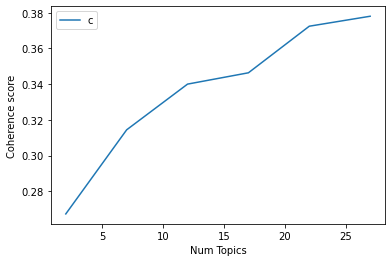

In [86]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [87]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  27

index: 0 | Num Topics = 2  has Coherence Value of 0.2674
index: 1 | Num Topics = 7  has Coherence Value of 0.3144
index: 2 | Num Topics = 12  has Coherence Value of 0.34
index: 3 | Num Topics = 17  has Coherence Value of 0.3464
index: 4 | Num Topics = 22  has Coherence Value of 0.3724
index: 5 | Num Topics = 27  has Coherence Value of 0.378


In [88]:
# Select optimal number of topics
optimal_model_ph_score4 = model_list_ph_score4[5]

In [89]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score4 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score4, corpus_ph_score4, id2word_ph_score4)

In [90]:
print("pyLDAVis for ph topics for score=4:")
vis_ph_score4

pyLDAVis for ph topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.122604 -0.025790       1        1  7.418371
14    -0.103905 -0.024802       2        1  6.942225
8     -0.009730 -0.096777       3        1  6.414771
21    -0.059378  0.078410       4        1  5.587093
24    -0.144526 -0.033425       5        1  5.553674
0     -0.116461 -0.004539       6        1  4.883979
17    -0.022463 -0.083555       7        1  4.759800
19    -0.108598  0.058195       8        1  4.554205
18     0.016965  0.018283       9        1  4.219599
26     0.024000 -0.021681      10        1  4.011557
22    -0.041232  0.045994      11        1  3.940708
5     -0.089877  0.010963      12        1  3.544620
1      0.011187 -0.008713      13        1  3.431820
13    -0.002217 -0.027609      14        1  3.427382
12    -0.076859  0.049639      15        1  3.334493
15     0.116266 -0.148769      16        1  3.221619
4      0.086363  0.187935      17        1  3.201463
11     0.144986 -0.046912      18        1  2.890035
2      0.056024 -0.087145      19        1  2.825073
16    -0.053350 -0.069086      20        1  2.787551
3      0.112695 -0.106048      21        1  2.523264
10     0.051183  0.082264      22        1  2.460643
23     0.022148 -0.029513      23        1  1.982532
20     0.053397  0.129304      24        1  1.957092
7      0.095048  0.082362      25        1  1.938116
25     0.061693  0.008530      26        1  1.531995
6      0.099247  0.062487      27        1  0.656322, topic_info=        Term       Freq      Total Category  logprob  loglift
31        ad  38.000000  38.000000  Default  30.0000  30.0000
99   comment  36.000000  36.000000  Default  29.0000  29.0000
128   delete  17.000000  17.000000  Default  28.0000  28.0000
101  section  13.000000  13.000000  Default  27.0000  27.0000
46     watch  53.000000  53.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
343      bad   0.016997   4.810555  Topic27  -7.0414  -0.6193
63    option   0.016997   8.883285  Topic27  -7.0414  -1.2326
751     high   0.016997   2.318518  Topic27  -7.0414   0.1106
760  advance   0.016997   1.505363  Topic27  -7.0414   0.5425
766     step   0.016997   1.505363  Topic27  -7.0414   0.5425

[1329 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
683       3  0.324157    able
683      19  0.324157    able
683      23  0.324157    able
547       3  0.618970    acce
548       3  0.306126  access
...     ...       ...     ...
148      15  0.185693      yt
148      20  0.092846      yt
148      24  0.185693      yt
148      25  0.092846      yt
434       9  0.637701   zumba

[1763 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 15, 9, 22, 25, 1, 18, 20, 19, 27, 23, 6, 2, 14, 13, 16, 5, 12, 3, 17, 4, 11, 24, 21, 8, 26, 7])

## LDA Topic Modelling (Rating = 5)

In [91]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_ph_score5 = youtube_ios_ph_review_YearMonth_score5.review.values.tolist()
review_words_ph_score5 = list(sent_to_words(review_ph_score5))
print(review_words_ph_score5[:1])

[['its', 'wonderful', 'use', 'this', 'app', 'every', 'day', 'and', 'its', 'very', 'useful', 'news', 'entertainment', 'guide', 'and', 'many', 'more']]


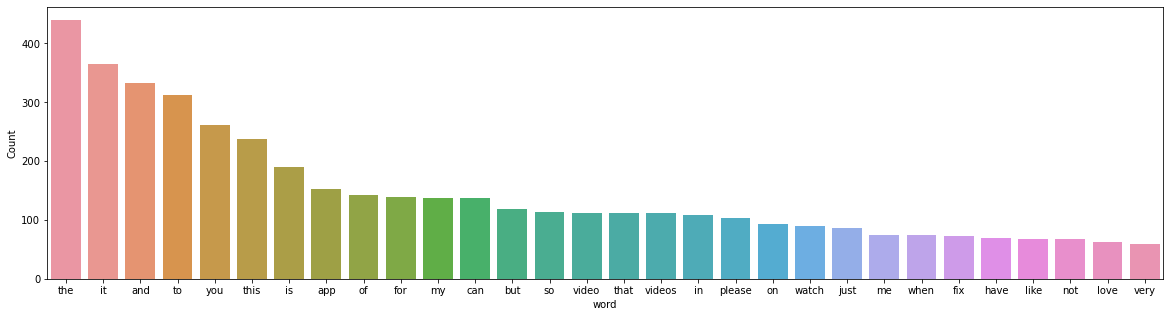

In [92]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score5))

In [93]:
# Clean text
review_ph_ready_score5 = process_words(review_words_ph_score5)  # processed Text Data! - move to each section

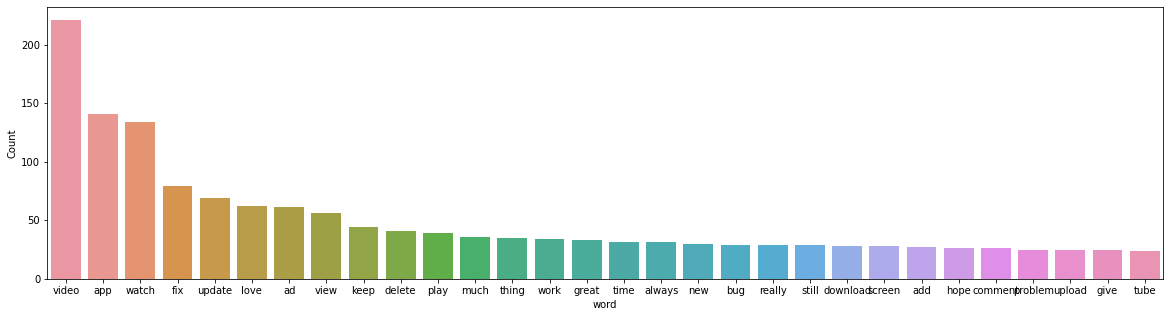

In [94]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score5))


In [95]:
# Create Dictionary
id2word_ph_score5 = corpora.Dictionary(review_ph_ready_score5)

2021-10-17 00:15:26,664 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:15:26,695 [INFO] gensim.corpora.dictionary - built Dictionary(1306 unique tokens: ['app', 'day', 'entertainment', 'guide', 'news']...) from 617 documents (total 4759 corpus positions)
2021-10-17 00:15:26,697 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1306 unique tokens: ['app', 'day', 'entertainment', 'guide', 'news']...) from 617 documents (total 4759 corpus positions)", 'datetime': '2021-10-17T00:15:26.697527', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [96]:
# Create Corpus: Term Document Frequency
corpus_ph_score5 = [id2word_ph_score5.doc2bow(text) for text in review_ph_ready_score5]

In [97]:
# Training LDA model
model_list_ph_score5, coherence_values_ph_score5 = compute_coherence_values(dictionary=id2word_ph_score5, corpus=corpus_ph_score5, 
                                                              texts=review_ph_ready_score5, limit=30, start=2, step=5)


2021-10-17 00:15:26,751 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:15:26,753 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:15:26,756 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:15:26,759 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 617 documents, updating model once every 617 documents, evaluating perplexity every 617 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:15:28,590 [INFO] gensim.models.ldamodel - -7.839 per-word bound, 228.9 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:15:28,601 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #617/617
2021-10-17 00:15:30,162 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"video" + 0.027*"watch" + 0.018*"app" + 0.016*"fix" + 0.015*"ad" + 0.014*"love" + 0.011*"keep" + 0

2021-10-17 00:15:46,690 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"app" + 0.022*"update" + 0.019*"view" + 0.012*"delete" + 0.011*"thing" + 0.010*"new" + 0.009*"watch" + 0.009*"give" + 0.008*"fix" + 0.007*"great"
2021-10-17 00:15:46,691 [INFO] gensim.models.ldamodel - topic diff=0.014703, rho=0.301511
2021-10-17 00:15:47,453 [INFO] gensim.models.ldamodel - -6.598 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:15:47,455 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #617/617
2021-10-17 00:15:48,196 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.034*"watch" + 0.019*"ad" + 0.018*"fix" + 0.017*"app" + 0.016*"love" + 0.012*"keep" + 0.011*"play" + 0.008*"bug" + 0.008*"upload"
2021-10-17 00:15:48,203 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"app" + 0.022*"update" + 0.019*"view" + 0.012*"delete" + 0.011*"thing" + 0.010*"new" + 0.009*"watch" + 0.009*"give" + 0.008

2021-10-17 00:16:03,293 [INFO] gensim.models.ldamodel - topic diff=0.006239, rho=0.218218
2021-10-17 00:16:04,127 [INFO] gensim.models.ldamodel - -6.588 per-word bound, 96.2 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:16:04,128 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #617/617
2021-10-17 00:16:04,569 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.066*"video" + 0.036*"watch" + 0.020*"fix" + 0.019*"ad" + 0.017*"app" + 0.016*"love" + 0.012*"keep" + 0.012*"play" + 0.008*"bug" + 0.008*"upload"
2021-10-17 00:16:04,572 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"app" + 0.021*"update" + 0.020*"view" + 0.014*"delete" + 0.011*"thing" + 0.010*"new" + 0.009*"give" + 0.008*"tube" + 0.008*"great" + 0.007*"watch"
2021-10-17 00:16:04,575 [INFO] gensim.models.ldamodel - topic diff=0.005892, rho=0.213201
2021-10-17 00:16:05,373 [INFO] gensim.models.ldamodel - -6.587 per-word bound, 96.2 perplexity estimate based on

2021-10-17 00:16:18,516 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #617/617
2021-10-17 00:16:19,143 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.036*"watch" + 0.022*"fix" + 0.019*"ad" + 0.017*"app" + 0.016*"love" + 0.013*"keep" + 0.012*"play" + 0.009*"bug" + 0.008*"hope"
2021-10-17 00:16:19,145 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"app" + 0.020*"update" + 0.020*"view" + 0.014*"delete" + 0.011*"thing" + 0.011*"new" + 0.009*"give" + 0.008*"tube" + 0.008*"great" + 0.007*"change"
2021-10-17 00:16:19,146 [INFO] gensim.models.ldamodel - topic diff=0.004129, rho=0.176777
2021-10-17 00:16:20,108 [INFO] gensim.models.ldamodel - -6.582 per-word bound, 95.8 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:16:20,122 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #617/617
2021-10-17 00:16:20,652 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.036*"watch" + 0

2021-10-17 00:16:33,643 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"app" + 0.020*"view" + 0.018*"update" + 0.015*"delete" + 0.011*"thing" + 0.011*"new" + 0.009*"give" + 0.008*"tube" + 0.008*"great" + 0.007*"change"
2021-10-17 00:16:33,644 [INFO] gensim.models.ldamodel - topic diff=0.003132, rho=0.154303
2021-10-17 00:16:34,535 [INFO] gensim.models.ldamodel - -6.579 per-word bound, 95.6 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:16:34,536 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #617/617
2021-10-17 00:16:35,125 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.037*"watch" + 0.023*"fix" + 0.019*"ad" + 0.017*"app" + 0.015*"love" + 0.013*"keep" + 0.012*"play" + 0.009*"bug" + 0.008*"hope"
2021-10-17 00:16:35,126 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"app" + 0.020*"view" + 0.018*"update" + 0.015*"delete" + 0.011*"thing" + 0.011*"new" + 0.009*"give" + 0.008*"tube" + 0.008*

2021-10-17 00:16:49,891 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:16:49,892 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:16:49,895 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:16:49,898 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 617 documents, updating model once every 617 documents, evaluating perplexity every 617 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:16:51,256 [INFO] gensim.models.ldamodel - -9.757 per-word bound, 865.2 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:16:51,258 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #617/617
2021-10-17 00:16:52,435 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"view" + 0.023*"update" + 0.020*"video" + 0.018*"delete" + 0.018*"

2021-10-17 00:16:59,857 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"view" + 0.025*"delete" + 0.022*"thing" + 0.017*"give" + 0.017*"update" + 0.015*"button" + 0.014*"new" + 0.013*"ad" + 0.013*"app" + 0.011*"video"
2021-10-17 00:16:59,877 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.074*"video" + 0.035*"ad" + 0.033*"watch" + 0.023*"screen" + 0.019*"play" + 0.013*"always" + 0.012*"great" + 0.011*"fix" + 0.011*"remove" + 0.010*"find"
2021-10-17 00:16:59,879 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"video" + 0.029*"app" + 0.023*"keep" + 0.016*"love" + 0.014*"update" + 0.013*"download" + 0.013*"problem" + 0.013*"fix" + 0.012*"open" + 0.012*"bug"
2021-10-17 00:16:59,880 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"video" + 0.018*"ad" + 0.017*"keep" + 0.013*"view" + 0.012*"music" + 0.011*"add" + 0.010*"feature" + 0.010*"watch" + 0.010*"wait" + 0.010*"app"
2021-10-17 00:16:59,882 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.059*"watch" + 0.0

2021-10-17 00:17:06,805 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.048*"view" + 0.030*"delete" + 0.023*"thing" + 0.017*"give" + 0.015*"button" + 0.015*"new" + 0.015*"update" + 0.013*"ad" + 0.011*"stop" + 0.011*"app"
2021-10-17 00:17:06,809 [INFO] gensim.models.ldamodel - topic diff=0.013224, rho=0.288675
2021-10-17 00:17:07,531 [INFO] gensim.models.ldamodel - -6.911 per-word bound, 120.3 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:17:07,533 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #617/617
2021-10-17 00:17:07,975 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"video" + 0.039*"ad" + 0.036*"watch" + 0.027*"screen" + 0.019*"play" + 0.012*"always" + 0.012*"fix" + 0.012*"great" + 0.011*"remove" + 0.010*"app"
2021-10-17 00:17:07,978 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.043*"fix" + 0.042*"video" + 0.030*"update" + 0.028*"app" + 0.025*"watch" + 0.015*"change" + 0.014*"time" + 0.014*"play" +

2021-10-17 00:17:14,758 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.032*"video" + 0.018*"keep" + 0.017*"ad" + 0.013*"music" + 0.013*"add" + 0.013*"feature" + 0.010*"wait" + 0.010*"enjoy" + 0.010*"app" + 0.009*"remove"
2021-10-17 00:17:14,759 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"app" + 0.028*"video" + 0.019*"love" + 0.013*"watch" + 0.011*"much" + 0.011*"edit" + 0.011*"comment" + 0.009*"add" + 0.009*"people" + 0.009*"really"
2021-10-17 00:17:14,761 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"video" + 0.039*"ad" + 0.038*"watch" + 0.027*"screen" + 0.019*"play" + 0.013*"fix" + 0.013*"always" + 0.012*"great" + 0.011*"remove" + 0.010*"app"
2021-10-17 00:17:14,762 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.044*"fix" + 0.042*"video" + 0.032*"update" + 0.027*"app" + 0.025*"watch" + 0.015*"change" + 0.014*"time" + 0.013*"play" + 0.013*"crash" + 0.011*"happen"
2021-10-17 00:17:14,763 [INFO] gensim.models.ldamodel - topic diff=0.007629, rho=0.235702

2021-10-17 00:17:21,144 [INFO] gensim.models.ldamodel - topic diff=0.005048, rho=0.208514
2021-10-17 00:17:21,703 [INFO] gensim.models.ldamodel - -6.892 per-word bound, 118.8 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:17:21,704 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #617/617
2021-10-17 00:17:22,183 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"app" + 0.028*"video" + 0.019*"keep" + 0.015*"update" + 0.014*"problem" + 0.014*"download" + 0.014*"fix" + 0.013*"love" + 0.013*"open" + 0.011*"help"
2021-10-17 00:17:22,185 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.061*"watch" + 0.041*"app" + 0.032*"love" + 0.032*"video" + 0.018*"much" + 0.015*"still" + 0.014*"ever" + 0.012*"tube" + 0.011*"star" + 0.010*"thing"
2021-10-17 00:17:22,187 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.044*"fix" + 0.042*"video" + 0.034*"update" + 0.027*"app" + 0.025*"watch" + 0.015*"change" + 0.014*"time" + 0.013*"play

2021-10-17 00:17:28,518 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.059*"view" + 0.041*"delete" + 0.023*"thing" + 0.018*"give" + 0.016*"stop" + 0.015*"button" + 0.013*"ad" + 0.013*"new" + 0.012*"update" + 0.011*"back"
2021-10-17 00:17:28,521 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"app" + 0.028*"video" + 0.019*"keep" + 0.015*"update" + 0.014*"problem" + 0.014*"download" + 0.014*"fix" + 0.013*"love" + 0.013*"open" + 0.011*"help"
2021-10-17 00:17:28,527 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"video" + 0.019*"keep" + 0.017*"ad" + 0.013*"music" + 0.013*"add" + 0.013*"feature" + 0.011*"wait" + 0.010*"enjoy" + 0.009*"app" + 0.009*"comment"
2021-10-17 00:17:28,531 [INFO] gensim.models.ldamodel - topic diff=0.003295, rho=0.185695
2021-10-17 00:17:29,258 [INFO] gensim.models.ldamodel - -6.887 per-word bound, 118.3 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:17:29,259 [INFO] gensim.models.ldamodel - PROGRE

2021-10-17 00:17:35,759 [INFO] gensim.models.ldamodel - -6.885 per-word bound, 118.2 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:17:35,761 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #617/617
2021-10-17 00:17:36,253 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"video" + 0.020*"keep" + 0.017*"ad" + 0.014*"add" + 0.014*"music" + 0.013*"feature" + 0.011*"wait" + 0.010*"enjoy" + 0.009*"comment" + 0.009*"app"
2021-10-17 00:17:36,255 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.082*"video" + 0.041*"watch" + 0.039*"ad" + 0.027*"screen" + 0.019*"play" + 0.013*"fix" + 0.013*"always" + 0.011*"great" + 0.011*"remove" + 0.011*"really"
2021-10-17 00:17:36,256 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"app" + 0.026*"video" + 0.019*"love" + 0.014*"watch" + 0.011*"much" + 0.010*"edit" + 0.010*"people" + 0.010*"comment" + 0.010*"really" + 0.009*"add"
2021-10-17 00:17:36,259 [INFO] gensim.models.ldamodel

2021-10-17 00:17:42,379 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.045*"fix" + 0.041*"video" + 0.035*"update" + 0.028*"app" + 0.025*"watch" + 0.015*"change" + 0.014*"time" + 0.013*"play" + 0.013*"crash" + 0.012*"happen"
2021-10-17 00:17:42,380 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"watch" + 0.041*"app" + 0.034*"love" + 0.032*"video" + 0.018*"much" + 0.015*"still" + 0.014*"tube" + 0.014*"ever" + 0.011*"star" + 0.010*"thing"
2021-10-17 00:17:42,384 [INFO] gensim.models.ldamodel - topic diff=0.001573, rho=0.158114
2021-10-17 00:17:43,130 [INFO] gensim.models.ldamodel - -6.883 per-word bound, 118.0 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:17:43,132 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #617/617
2021-10-17 00:17:43,725 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.045*"fix" + 0.041*"video" + 0.035*"update" + 0.028*"app" + 0.025*"watch" + 0.015*"change" + 0.014*"time" + 0.013*"play"

2021-10-17 00:17:50,402 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.045*"fix" + 0.040*"video" + 0.035*"update" + 0.028*"app" + 0.025*"watch" + 0.015*"change" + 0.014*"time" + 0.013*"play" + 0.013*"crash" + 0.012*"happen"
2021-10-17 00:17:50,404 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.033*"app" + 0.028*"video" + 0.018*"keep" + 0.016*"update" + 0.015*"problem" + 0.014*"download" + 0.014*"fix" + 0.013*"love" + 0.013*"open" + 0.012*"help"
2021-10-17 00:17:50,407 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"app" + 0.026*"video" + 0.019*"love" + 0.014*"watch" + 0.011*"much" + 0.010*"people" + 0.010*"edit" + 0.010*"comment" + 0.010*"really" + 0.009*"add"
2021-10-17 00:17:50,410 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"watch" + 0.041*"app" + 0.034*"love" + 0.032*"video" + 0.018*"much" + 0.015*"still" + 0.014*"tube" + 0.014*"ever" + 0.011*"star" + 0.010*"thing"
2021-10-17 00:17:50,412 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.062*"view" 

2021-10-17 00:17:56,891 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.082*"video" + 0.041*"watch" + 0.039*"ad" + 0.027*"screen" + 0.019*"play" + 0.013*"always" + 0.013*"fix" + 0.011*"really" + 0.011*"great" + 0.011*"remove"
2021-10-17 00:17:56,894 [INFO] gensim.models.ldamodel - topic diff=0.000730, rho=0.140028
2021-10-17 00:17:56,902 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1306, num_topics=7, decay=0.5, chunksize=1000) in 67.00s', 'datetime': '2021-10-17T00:17:56.902497', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 00:17:56,909 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:18:01,954 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 

2021-10-17 00:18:12,482 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"app" + 0.019*"star" + 0.016*"add" + 0.015*"useful" + 0.014*"people" + 0.011*"video" + 0.010*"view" + 0.010*"edit" + 0.010*"ad" + 0.010*"stupid"
2021-10-17 00:18:12,486 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.022*"video" + 0.019*"download" + 0.017*"button" + 0.016*"old" + 0.013*"great" + 0.013*"internet" + 0.011*"new" + 0.009*"comment" + 0.009*"update" + 0.009*"crash"
2021-10-17 00:18:12,491 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"app" + 0.027*"keep" + 0.019*"update" + 0.018*"tube" + 0.015*"bug" + 0.014*"love" + 0.013*"late" + 0.011*"picture" + 0.011*"fix" + 0.011*"video"
2021-10-17 00:18:12,497 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.030*"video" + 0.024*"keep" + 0.021*"work" + 0.018*"add" + 0.016*"love" + 0.016*"feature" + 0.013*"wait" + 0.013*"music" + 0.012*"hope" + 0.012*"entertainment"
2021-10-17 00:18:12,502 [INFO] gensim.models.ldamodel - topic diff=0.050311, 

2021-10-17 00:18:19,031 [INFO] gensim.models.ldamodel - topic diff=0.018553, rho=0.301511
2021-10-17 00:18:19,784 [INFO] gensim.models.ldamodel - -7.074 per-word bound, 134.8 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:18:19,786 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #617/617
2021-10-17 00:18:20,225 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.030*"keep" + 0.027*"video" + 0.023*"work" + 0.020*"add" + 0.016*"feature" + 0.016*"love" + 0.014*"wait" + 0.013*"information" + 0.013*"music" + 0.012*"entertainment"
2021-10-17 00:18:20,227 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.060*"view" + 0.059*"delete" + 0.028*"watch" + 0.019*"app" + 0.019*"stop" + 0.018*"video" + 0.015*"hard" + 0.014*"add" + 0.010*"work" + 0.010*"edit"
2021-10-17 00:18:20,230 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.039*"app" + 0.022*"well" + 0.019*"still" + 0.017*"watch" + 0.015*"different" + 0.012*"ever" + 0.010*"upload

2021-10-17 00:18:26,531 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.072*"thing" + 0.043*"video" + 0.027*"watch" + 0.018*"content" + 0.015*"great" + 0.014*"recommend" + 0.013*"find" + 0.012*"app" + 0.012*"much" + 0.012*"ad"
2021-10-17 00:18:26,533 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.045*"fix" + 0.030*"app" + 0.028*"change" + 0.027*"crash" + 0.023*"update" + 0.016*"video" + 0.015*"happen" + 0.012*"star" + 0.012*"time" + 0.010*"comment"
2021-10-17 00:18:26,536 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.026*"app" + 0.019*"star" + 0.019*"useful" + 0.016*"add" + 0.016*"people" + 0.012*"helpful" + 0.010*"video" + 0.010*"watch" + 0.010*"ad" + 0.010*"edit"
2021-10-17 00:18:26,538 [INFO] gensim.models.ldamodel - topic diff=0.008051, rho=0.242536
2021-10-17 00:18:27,276 [INFO] gensim.models.ldamodel - -7.057 per-word bound, 133.2 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:18:27,277 [INFO] gensim.models.ldamodel -

2021-10-17 00:18:33,823 [INFO] gensim.models.ldamodel - -7.051 per-word bound, 132.6 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:18:33,887 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #617/617
2021-10-17 00:18:34,519 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.064*"video" + 0.051*"watch" + 0.029*"movie" + 0.019*"great" + 0.018*"upload" + 0.015*"love" + 0.013*"always" + 0.013*"app" + 0.011*"really" + 0.010*"enjoy"
2021-10-17 00:18:34,523 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.063*"video" + 0.046*"app" + 0.045*"update" + 0.033*"fix" + 0.027*"play" + 0.015*"problem" + 0.012*"time" + 0.011*"bug" + 0.010*"ad" + 0.010*"upload"
2021-10-17 00:18:34,526 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.033*"view" + 0.021*"channel" + 0.021*"give" + 0.012*"never" + 0.012*"gon" + 0.012*"back" + 0.012*"life" + 0.012*"work" + 0.012*"people" + 0.010*"let"
2021-10-17 00:18:34,530 [INFO] gensim.models.ldamodel -

2021-10-17 00:18:41,490 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.027*"app" + 0.020*"star" + 0.019*"useful" + 0.016*"add" + 0.016*"people" + 0.013*"helpful" + 0.010*"watch" + 0.010*"edit" + 0.010*"join" + 0.010*"wait"
2021-10-17 00:18:41,510 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.074*"view" + 0.067*"delete" + 0.027*"watch" + 0.020*"stop" + 0.017*"video" + 0.016*"app" + 0.016*"hard" + 0.013*"add" + 0.011*"work" + 0.010*"music"
2021-10-17 00:18:41,511 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.031*"view" + 0.021*"give" + 0.021*"channel" + 0.013*"never" + 0.013*"gon" + 0.013*"back" + 0.013*"life" + 0.012*"people" + 0.012*"work" + 0.010*"let"
2021-10-17 00:18:41,513 [INFO] gensim.models.ldamodel - topic diff=0.004274, rho=0.188982
2021-10-17 00:18:42,271 [INFO] gensim.models.ldamodel - -7.043 per-word bound, 131.9 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:18:42,272 [INFO] gensim.models.ldamodel - PROGRESS: 

2021-10-17 00:18:48,776 [INFO] gensim.models.ldamodel - topic diff=0.003508, rho=0.174078
2021-10-17 00:18:49,506 [INFO] gensim.models.ldamodel - -7.038 per-word bound, 131.4 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:18:49,508 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #617/617
2021-10-17 00:18:50,079 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"keep" + 0.025*"video" + 0.023*"work" + 0.021*"add" + 0.017*"feature" + 0.016*"information" + 0.015*"love" + 0.014*"wait" + 0.014*"day" + 0.012*"premium"
2021-10-17 00:18:50,081 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.083*"video" + 0.068*"watch" + 0.039*"ad" + 0.023*"app" + 0.022*"love" + 0.016*"much" + 0.014*"remove" + 0.014*"fix" + 0.013*"offline" + 0.013*"search"
2021-10-17 00:18:50,083 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.078*"view" + 0.069*"delete" + 0.024*"watch" + 0.020*"stop" + 0.017*"hard" + 0.016*"video" + 0.014*"app" + 0.013*

2021-10-17 00:18:58,202 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.063*"video" + 0.046*"app" + 0.046*"update" + 0.035*"fix" + 0.028*"play" + 0.015*"problem" + 0.012*"bug" + 0.012*"time" + 0.010*"upload" + 0.010*"love"
2021-10-17 00:18:58,205 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.044*"keep" + 0.025*"video" + 0.023*"work" + 0.021*"add" + 0.017*"feature" + 0.016*"information" + 0.015*"love" + 0.014*"wait" + 0.014*"day" + 0.012*"premium"
2021-10-17 00:18:58,208 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.026*"view" + 0.021*"give" + 0.020*"channel" + 0.013*"never" + 0.013*"gon" + 0.013*"back" + 0.013*"life" + 0.013*"people" + 0.010*"let" + 0.010*"love"
2021-10-17 00:18:58,211 [INFO] gensim.models.ldamodel - topic diff=0.002703, rho=0.160128
2021-10-17 00:18:58,917 [INFO] gensim.models.ldamodel - -7.032 per-word bound, 130.9 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:18:58,919 [INFO] gensim.models.ldamodel - P

2021-10-17 00:19:04,424 [INFO] gensim.models.ldamodel - topic diff=0.002299, rho=0.150756
2021-10-17 00:19:05,111 [INFO] gensim.models.ldamodel - -7.029 per-word bound, 130.6 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:19:05,112 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #617/617
2021-10-17 00:19:05,626 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.024*"view" + 0.020*"channel" + 0.019*"give" + 0.013*"never" + 0.013*"gon" + 0.013*"back" + 0.013*"life" + 0.013*"people" + 0.010*"let" + 0.010*"love"
2021-10-17 00:19:05,627 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.051*"fix" + 0.034*"change" + 0.029*"crash" + 0.028*"app" + 0.023*"update" + 0.016*"happen" + 0.014*"profile" + 0.012*"time" + 0.012*"comment" + 0.012*"star"
2021-10-17 00:19:05,630 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.081*"view" + 0.070*"delete" + 0.022*"watch" + 0.020*"stop" + 0.018*"hard" + 0.016*"video" + 0.013*"add" + 0.013*"w

2021-10-17 00:19:12,908 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.071*"thing" + 0.042*"video" + 0.027*"watch" + 0.018*"content" + 0.016*"recommend" + 0.016*"great" + 0.013*"app" + 0.012*"find" + 0.012*"ad" + 0.012*"much"
2021-10-17 00:19:12,911 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.064*"video" + 0.053*"watch" + 0.029*"movie" + 0.018*"great" + 0.018*"upload" + 0.016*"app" + 0.016*"love" + 0.013*"always" + 0.012*"enjoy" + 0.011*"live"
2021-10-17 00:19:12,914 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.052*"fix" + 0.034*"change" + 0.029*"crash" + 0.028*"app" + 0.023*"update" + 0.016*"happen" + 0.014*"profile" + 0.012*"time" + 0.012*"comment" + 0.012*"vid"
2021-10-17 00:19:12,915 [INFO] gensim.models.ldamodel - topic diff=0.001797, rho=0.141421
2021-10-17 00:19:13,929 [INFO] gensim.models.ldamodel - -7.027 per-word bound, 130.4 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:19:13,930 [INFO] gensim.models.ldamod

2021-10-17 00:19:26,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #617/617
2021-10-17 00:19:27,083 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.037*"button" + 0.023*"join" + 0.018*"enjoy" + 0.018*"wait" + 0.015*"ad" + 0.014*"history" + 0.010*"really" + 0.010*"video" + 0.010*"great" + 0.010*"slow"
2021-10-17 00:19:27,085 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.045*"app" + 0.043*"video" + 0.042*"update" + 0.039*"fix" + 0.018*"change" + 0.016*"bug" + 0.016*"watch" + 0.015*"love" + 0.014*"play" + 0.013*"whenever"
2021-10-17 00:19:27,088 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.031*"video" + 0.024*"keep" + 0.022*"feature" + 0.019*"content" + 0.017*"ad" + 0.013*"music" + 0.013*"already" + 0.013*"crash" + 0.011*"yt" + 0.011*"work"
2021-10-17 00:19:27,092 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.038*"video" + 0.021*"app" + 0.015*"watch" + 0.015*"update" + 0.015*"delete" + 0.015*"time" + 0.014*"stop" + 0.012*"help" + 0.012*"always" 

2021-10-17 00:19:34,266 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.057*"video" + 0.049*"watch" + 0.019*"upload" + 0.016*"learn" + 0.014*"view" + 0.014*"information" + 0.014*"source" + 0.013*"helpful" + 0.012*"really" + 0.012*"app"
2021-10-17 00:19:34,270 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.051*"ad" + 0.050*"video" + 0.023*"remove" + 0.022*"work" + 0.020*"problem" + 0.020*"play" + 0.018*"download" + 0.013*"hard" + 0.012*"view" + 0.012*"people"
2021-10-17 00:19:34,272 [INFO] gensim.models.ldamodel - topic diff=0.027902, rho=0.316228
2021-10-17 00:19:35,094 [INFO] gensim.models.ldamodel - -7.204 per-word bound, 147.4 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:19:35,096 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #617/617
2021-10-17 00:19:35,918 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.048*"update" + 0.046*"app" + 0.045*"video" + 0.039*"fix" + 0.023*"change" + 0.017*"bug" + 0.015*"watch

2021-10-17 00:19:43,654 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #617/617
2021-10-17 00:19:44,291 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.080*"watch" + 0.070*"video" + 0.028*"love" + 0.018*"ad" + 0.017*"app" + 0.015*"search" + 0.014*"download" + 0.012*"still" + 0.010*"update" + 0.010*"time"
2021-10-17 00:19:44,294 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.031*"video" + 0.024*"fast" + 0.024*"comment" + 0.021*"account" + 0.017*"ad" + 0.016*"fix" + 0.015*"watch" + 0.015*"show" + 0.015*"edit" + 0.015*"add"
2021-10-17 00:19:44,297 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.046*"video" + 0.042*"well" + 0.033*"watch" + 0.032*"app" + 0.032*"view" + 0.021*"ever" + 0.020*"life" + 0.019*"ad" + 0.017*"movie" + 0.017*"find"
2021-10-17 00:19:44,300 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.053*"video" + 0.044*"fix" + 0.039*"screen" + 0.033*"app" + 0.032*"watch" + 0.022*"bug" + 0.019*"full" + 0.016*"update" + 0.016*"offline" + 0.012*"pl

2021-10-17 00:19:51,180 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.033*"video" + 0.031*"hope" + 0.026*"app" + 0.023*"fix" + 0.016*"review" + 0.015*"still" + 0.013*"watch" + 0.012*"help" + 0.012*"car" + 0.010*"tutorial"
2021-10-17 00:19:51,182 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.034*"video" + 0.020*"app" + 0.017*"watch" + 0.016*"time" + 0.014*"stop" + 0.013*"help" + 0.013*"channel" + 0.013*"keep" + 0.013*"ad" + 0.012*"always"
2021-10-17 00:19:51,183 [INFO] gensim.models.ldamodel - topic diff=0.007216, rho=0.218218
2021-10-17 00:19:51,843 [INFO] gensim.models.ldamodel - -7.168 per-word bound, 143.8 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:19:51,844 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #617/617
2021-10-17 00:19:52,315 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.027*"keep" + 0.026*"video" + 0.021*"content" + 0.020*"feature" + 0.017*"ad" + 0.014*"music" + 0.014*"already" + 0.013

2021-10-17 00:19:58,427 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #617/617
2021-10-17 00:19:59,145 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.033*"video" + 0.020*"app" + 0.017*"watch" + 0.015*"time" + 0.014*"help" + 0.014*"channel" + 0.013*"keep" + 0.012*"always" + 0.012*"stop" + 0.012*"update"
2021-10-17 00:19:59,152 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.056*"video" + 0.048*"watch" + 0.019*"upload" + 0.017*"learn" + 0.016*"information" + 0.014*"source" + 0.014*"helpful" + 0.012*"app" + 0.012*"informative" + 0.012*"really"
2021-10-17 00:19:59,153 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.030*"video" + 0.024*"fast" + 0.024*"comment" + 0.022*"account" + 0.016*"ad" + 0.016*"fix" + 0.016*"watch" + 0.015*"show" + 0.015*"edit" + 0.015*"add"
2021-10-17 00:19:59,155 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.056*"thing" + 0.036*"love" + 0.029*"video" + 0.021*"watch" + 0.021*"app" + 0.017*"tube" + 0.017*"song" + 0.013*"fast" + 0.0

2021-10-17 00:20:06,290 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.059*"thing" + 0.036*"love" + 0.029*"video" + 0.021*"watch" + 0.021*"app" + 0.017*"tube" + 0.017*"song" + 0.013*"fast" + 0.013*"amazing" + 0.011*"time"
2021-10-17 00:20:06,292 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.057*"video" + 0.048*"watch" + 0.019*"upload" + 0.017*"learn" + 0.017*"information" + 0.014*"source" + 0.014*"helpful" + 0.012*"app" + 0.012*"informative" + 0.012*"really"
2021-10-17 00:20:06,294 [INFO] gensim.models.ldamodel - topic diff=0.003019, rho=0.176777
2021-10-17 00:20:07,041 [INFO] gensim.models.ldamodel - -7.155 per-word bound, 142.5 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:20:07,043 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #617/617
2021-10-17 00:20:07,511 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.029*"add" + 0.022*"video" + 0.022*"watch" + 0.017*"delete" + 0.016*"love" + 0.013*"time" + 0.013*"

2021-10-17 00:20:13,688 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #617/617
2021-10-17 00:20:14,413 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.032*"keep" + 0.025*"app" + 0.014*"wet" + 0.014*"experience" + 0.013*"late" + 0.012*"work" + 0.011*"search" + 0.010*"give" + 0.009*"picture" + 0.008*"love"
2021-10-17 00:20:14,416 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"keep" + 0.027*"video" + 0.021*"content" + 0.020*"feature" + 0.014*"music" + 0.014*"already" + 0.013*"yt" + 0.013*"work" + 0.013*"ad" + 0.012*"hope"
2021-10-17 00:20:14,421 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.050*"video" + 0.043*"well" + 0.037*"watch" + 0.031*"app" + 0.021*"ever" + 0.020*"life" + 0.020*"ad" + 0.019*"view" + 0.017*"movie" + 0.017*"find"
2021-10-17 00:20:14,435 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.081*"view" + 0.056*"delete" + 0.034*"app" + 0.031*"update" + 0.023*"back" + 0.022*"new" + 0.018*"give" + 0.017*"bring" + 0.015*"channel" + 0.015*

2021-10-17 00:20:20,541 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.051*"video" + 0.043*"well" + 0.037*"watch" + 0.031*"app" + 0.022*"ever" + 0.021*"ad" + 0.020*"life" + 0.018*"movie" + 0.017*"find" + 0.017*"stop"
2021-10-17 00:20:20,543 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.089*"view" + 0.060*"delete" + 0.034*"app" + 0.030*"update" + 0.023*"back" + 0.022*"new" + 0.018*"give" + 0.017*"bring" + 0.016*"hard" + 0.015*"channel"
2021-10-17 00:20:20,544 [INFO] gensim.models.ldamodel - topic diff=0.002200, rho=0.152499
2021-10-17 00:20:21,232 [INFO] gensim.models.ldamodel - -7.148 per-word bound, 141.8 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:20:21,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #617/617
2021-10-17 00:20:21,701 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.061*"thing" + 0.037*"love" + 0.028*"video" + 0.021*"watch" + 0.021*"app" + 0.017*"tube" + 0.016*"song" + 0.014*"time" + 0

2021-10-17 00:20:26,687 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #617/617
2021-10-17 00:20:27,161 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.059*"video" + 0.049*"watch" + 0.019*"upload" + 0.017*"learn" + 0.017*"information" + 0.015*"source" + 0.014*"helpful" + 0.012*"app" + 0.012*"informative" + 0.012*"really"
2021-10-17 00:20:27,163 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.053*"video" + 0.043*"well" + 0.037*"watch" + 0.031*"app" + 0.022*"ad" + 0.022*"ever" + 0.020*"life" + 0.018*"movie" + 0.017*"find" + 0.017*"stop"
2021-10-17 00:20:27,164 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.032*"keep" + 0.026*"app" + 0.014*"wet" + 0.014*"experience" + 0.012*"late" + 0.012*"work" + 0.011*"search" + 0.011*"give" + 0.009*"love" + 0.009*"look"
2021-10-17 00:20:27,165 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.032*"hope" + 0.031*"video" + 0.026*"app" + 0.022*"fix" + 0.016*"review" + 0.016*"still" + 0.013*"watch" + 0.012*"help" + 0.012*"c

2021-10-17 00:20:39,419 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.035*"video" + 0.021*"download" + 0.016*"screen" + 0.015*"problem" + 0.014*"add" + 0.013*"work" + 0.013*"momo" + 0.013*"update" + 0.012*"full" + 0.011*"always"
2021-10-17 00:20:39,422 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.025*"update" + 0.024*"fix" + 0.020*"view" + 0.019*"video" + 0.015*"crash" + 0.015*"always" + 0.013*"time" + 0.012*"whenever" + 0.012*"caption" + 0.011*"experience"
2021-10-17 00:20:39,424 [INFO] gensim.models.ldamodel - topic diff=0.118933, rho=0.577350
2021-10-17 00:20:40,016 [INFO] gensim.models.ldamodel - -7.455 per-word bound, 175.5 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:20:40,017 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #617/617
2021-10-17 00:20:40,491 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.061*"thing" + 0.036*"view" + 0.028*"watch" + 0.020*"give" + 0.020*"wet" + 0.016*"hard" + 0.016*"b

2021-10-17 00:20:45,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #617/617
2021-10-17 00:20:46,040 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.023*"fix" + 0.023*"update" + 0.019*"video" + 0.018*"caption" + 0.018*"late" + 0.015*"view" + 0.014*"time" + 0.014*"experience" + 0.014*"error" + 0.013*"whenever"
2021-10-17 00:20:46,042 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.038*"watch" + 0.020*"love" + 0.019*"time" + 0.018*"app" + 0.016*"news" + 0.015*"way" + 0.013*"vid" + 0.013*"screen" + 0.013*"add" + 0.012*"help"
2021-10-17 00:20:46,046 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.055*"keep" + 0.045*"video" + 0.027*"upload" + 0.024*"work" + 0.019*"bug" + 0.017*"watch" + 0.017*"still" + 0.017*"remove" + 0.013*"star" + 0.013*"press"
2021-10-17 00:20:46,047 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.049*"new" + 0.040*"update" + 0.030*"app" + 0.028*"channel" + 0.018*"device" + 0.016*"version" + 0.016*"view" + 0.015*"let" + 0.013*"long" +

2021-10-17 00:20:51,682 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.024*"fix" + 0.020*"audio" + 0.019*"caption" + 0.018*"video" + 0.015*"late" + 0.015*"time" + 0.015*"experience" + 0.015*"error" + 0.014*"update" + 0.013*"whenever"
2021-10-17 00:20:51,684 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.051*"new" + 0.044*"update" + 0.031*"app" + 0.029*"channel" + 0.018*"device" + 0.017*"let" + 0.017*"version" + 0.016*"late" + 0.013*"long" + 0.013*"subscriber"
2021-10-17 00:20:51,686 [INFO] gensim.models.ldamodel - topic diff=0.017790, rho=0.267261
2021-10-17 00:20:52,323 [INFO] gensim.models.ldamodel - -7.245 per-word bound, 151.7 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:20:52,324 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #617/617
2021-10-17 00:20:52,787 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.046*"app" + 0.029*"video" + 0.017*"upload" + 0.017*"helpful" + 0.015*"already" + 0.014*"watch" + 

2021-10-17 00:20:57,923 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #617/617
2021-10-17 00:20:58,328 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.060*"ad" + 0.027*"video" + 0.018*"music" + 0.016*"remove" + 0.014*"channel" + 0.012*"hope" + 0.012*"different" + 0.012*"bug" + 0.012*"love" + 0.012*"awesome"
2021-10-17 00:20:58,330 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.073*"love" + 0.061*"tube" + 0.036*"app" + 0.029*"much" + 0.022*"picture" + 0.022*"great" + 0.022*"enjoy" + 0.021*"keep" + 0.018*"always" + 0.014*"update"
2021-10-17 00:20:58,331 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.037*"watch" + 0.018*"time" + 0.018*"love" + 0.017*"app" + 0.016*"news" + 0.016*"way" + 0.012*"vid" + 0.012*"screen" + 0.012*"add" + 0.012*"help"
2021-10-17 00:20:58,333 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.027*"app" + 0.026*"video" + 0.015*"still" + 0.014*"keep" + 0.013*"ad" + 0.011*"update" + 0.009*"message" + 0.009*"download" + 0.009*"great" + 

2021-10-17 00:21:04,791 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.047*"app" + 0.027*"video" + 0.018*"upload" + 0.018*"helpful" + 0.015*"already" + 0.014*"fix" + 0.013*"content" + 0.012*"star" + 0.012*"creator" + 0.012*"io"
2021-10-17 00:21:04,792 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.117*"video" + 0.102*"watch" + 0.024*"offline" + 0.021*"ad" + 0.020*"fix" + 0.018*"app" + 0.015*"play" + 0.015*"download" + 0.015*"enjoy" + 0.014*"screen"
2021-10-17 00:21:04,793 [INFO] gensim.models.ldamodel - topic diff=0.005429, rho=0.200000
2021-10-17 00:21:05,439 [INFO] gensim.models.ldamodel - -7.220 per-word bound, 149.1 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:21:05,440 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #617/617
2021-10-17 00:21:06,158 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.051*"new" + 0.044*"update" + 0.032*"app" + 0.029*"channel" + 0.018*"device" + 0.018*"version" + 0.017*"late" 

2021-10-17 00:21:11,715 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #617/617
2021-10-17 00:21:12,173 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.042*"download" + 0.040*"video" + 0.020*"problem" + 0.019*"add" + 0.017*"recommend" + 0.016*"work" + 0.013*"momo" + 0.013*"family" + 0.013*"fast" + 0.011*"screen"
2021-10-17 00:21:12,174 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.051*"watch" + 0.050*"video" + 0.040*"really" + 0.018*"learn" + 0.017*"help" + 0.016*"keep" + 0.015*"tutorial" + 0.012*"love" + 0.012*"great" + 0.011*"datum"
2021-10-17 00:21:12,177 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.085*"love" + 0.059*"tube" + 0.052*"much" + 0.036*"app" + 0.024*"enjoy" + 0.024*"great" + 0.021*"picture" + 0.020*"keep" + 0.017*"always" + 0.013*"update"
2021-10-17 00:21:12,183 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.112*"view" + 0.084*"delete" + 0.044*"video" + 0.033*"stop" + 0.028*"app" + 0.019*"hard" + 0.016*"well" + 0.016*"movie" + 0.015

2021-10-17 00:21:18,422 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.076*"fix" + 0.065*"update" + 0.052*"video" + 0.044*"app" + 0.043*"play" + 0.027*"bug" + 0.018*"watch" + 0.013*"change" + 0.013*"load" + 0.013*"new"
2021-10-17 00:21:18,426 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.048*"app" + 0.027*"video" + 0.018*"upload" + 0.018*"helpful" + 0.015*"already" + 0.015*"content" + 0.014*"fix" + 0.012*"star" + 0.012*"creator" + 0.012*"io"
2021-10-17 00:21:18,430 [INFO] gensim.models.ldamodel - topic diff=0.003201, rho=0.166667
2021-10-17 00:21:18,933 [INFO] gensim.models.ldamodel - -7.209 per-word bound, 148.0 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:21:18,935 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #617/617
2021-10-17 00:21:19,431 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.077*"fix" + 0.065*"update" + 0.052*"video" + 0.044*"app" + 0.043*"play" + 0.027*"bug" + 0.018*"watch" + 0.013*"chan

2021-10-17 00:21:24,463 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #617/617
2021-10-17 00:21:24,895 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.118*"video" + 0.103*"watch" + 0.024*"offline" + 0.021*"ad" + 0.019*"fix" + 0.019*"app" + 0.016*"enjoy" + 0.015*"download" + 0.015*"play" + 0.014*"screen"
2021-10-17 00:21:24,897 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.078*"fix" + 0.066*"update" + 0.054*"video" + 0.043*"play" + 0.043*"app" + 0.026*"bug" + 0.018*"watch" + 0.013*"whenever" + 0.013*"change" + 0.013*"load"
2021-10-17 00:21:24,899 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.054*"watch" + 0.050*"video" + 0.039*"really" + 0.018*"learn" + 0.017*"tutorial" + 0.017*"help" + 0.016*"keep" + 0.012*"love" + 0.011*"great" + 0.011*"thing"
2021-10-17 00:21:24,901 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.060*"video" + 0.055*"always" + 0.054*"app" + 0.037*"watch" + 0.034*"love" + 0.030*"update" + 0.024*"informative" + 0.017*"fun" + 0.015*

2021-10-17 00:21:31,502 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.078*"fix" + 0.066*"update" + 0.056*"video" + 0.045*"play" + 0.043*"app" + 0.026*"bug" + 0.017*"watch" + 0.014*"whenever" + 0.013*"change" + 0.013*"load"
2021-10-17 00:21:31,529 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.054*"crash" + 0.046*"fix" + 0.040*"star" + 0.032*"much" + 0.024*"happen" + 0.022*"keep" + 0.018*"help" + 0.018*"advertisement" + 0.018*"thing" + 0.018*"still"
2021-10-17 00:21:31,535 [INFO] gensim.models.ldamodel - topic diff=0.002273, rho=0.145865
2021-10-17 00:21:32,410 [INFO] gensim.models.ldamodel - -7.199 per-word bound, 146.9 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:21:32,411 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #617/617
2021-10-17 00:21:32,983 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.088*"comment" + 0.034*"app" + 0.027*"love" + 0.026*"add" + 0.025*"edit" + 0.023*"put" + 0.020*"section" + 0.

2021-10-17 00:21:50,847 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.064*"video" + 0.026*"update" + 0.022*"app" + 0.020*"watch" + 0.020*"play" + 0.020*"ad" + 0.013*"upload" + 0.013*"bug" + 0.012*"fix" + 0.012*"helpful"
2021-10-17 00:21:50,849 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.050*"fix" + 0.045*"video" + 0.027*"play" + 0.026*"update" + 0.024*"app" + 0.017*"new" + 0.015*"bug" + 0.014*"keep" + 0.014*"watch" + 0.010*"love"
2021-10-17 00:21:50,851 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.068*"video" + 0.027*"view" + 0.019*"app" + 0.016*"recommend" + 0.016*"show" + 0.016*"much" + 0.016*"love" + 0.013*"fix" + 0.012*"message" + 0.012*"tube"
2021-10-17 00:21:50,857 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.030*"app" + 0.025*"thing" + 0.023*"video" + 0.023*"watch" + 0.015*"download" + 0.015*"still" + 0.013*"ever" + 0.013*"well" + 0.012*"tutorial" + 0.010*"family"
2021-10-17 00:21:50,860 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.030*"ad

2021-10-17 00:21:57,788 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.086*"watch" + 0.080*"video" + 0.025*"app" + 0.021*"offline" + 0.018*"love" + 0.017*"ad" + 0.014*"download" + 0.011*"comment" + 0.011*"search" + 0.011*"really"
2021-10-17 00:21:57,790 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.047*"view" + 0.040*"app" + 0.027*"late" + 0.018*"update" + 0.018*"delete" + 0.017*"bring" + 0.017*"car" + 0.017*"give" + 0.017*"let" + 0.017*"device"
2021-10-17 00:21:57,791 [INFO] gensim.models.ldamodel - topic diff=0.044735, rho=0.377964
2021-10-17 00:21:58,468 [INFO] gensim.models.ldamodel - -7.419 per-word bound, 171.1 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:21:58,470 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #617/617
2021-10-17 00:21:58,974 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.034*"show" + 0.027*"update" + 0.026*"new" + 0.021*"subscriber" + 0.021*"video" + 0.021*"ad" + 0.015*"fix" + 0.01

2021-10-17 00:22:04,928 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #617/617
2021-10-17 00:22:05,438 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.091*"watch" + 0.075*"video" + 0.029*"offline" + 0.025*"app" + 0.020*"download" + 0.017*"love" + 0.014*"ad" + 0.011*"comment" + 0.011*"really" + 0.011*"enjoy"
2021-10-17 00:22:05,439 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.042*"app" + 0.033*"late" + 0.029*"view" + 0.022*"update" + 0.018*"car" + 0.018*"give" + 0.018*"let" + 0.018*"device" + 0.018*"long" + 0.017*"bring"
2021-10-17 00:22:05,441 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.086*"fix" + 0.069*"video" + 0.062*"play" + 0.059*"update" + 0.017*"new" + 0.016*"profile" + 0.013*"end" + 0.012*"app" + 0.012*"keep" + 0.012*"change"
2021-10-17 00:22:05,442 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.035*"fix" + 0.026*"update" + 0.026*"screen" + 0.022*"never" + 0.022*"app" + 0.022*"video" + 0.018*"gon" + 0.018*"love" + 0.013*"time" + 0.013*

2021-10-17 00:22:12,041 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.072*"ad" + 0.044*"video" + 0.031*"watch" + 0.029*"change" + 0.027*"play" + 0.026*"fix" + 0.023*"problem" + 0.021*"search" + 0.020*"hope" + 0.018*"app"
2021-10-17 00:22:12,044 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.046*"app" + 0.021*"update" + 0.019*"video" + 0.018*"fix" + 0.018*"vid" + 0.018*"people" + 0.014*"play" + 0.014*"stream" + 0.014*"still" + 0.013*"internet"
2021-10-17 00:22:12,045 [INFO] gensim.models.ldamodel - topic diff=0.010605, rho=0.235702
2021-10-17 00:22:13,193 [INFO] gensim.models.ldamodel - -7.339 per-word bound, 161.9 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:22:13,194 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #617/617
2021-10-17 00:22:13,695 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.027*"video" + 0.022*"join" + 0.018*"update" + 0.018*"add" + 0.013*"wait" + 0.013*"mode" + 0.013*"live" + 0.013*"c

2021-10-17 00:22:21,558 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #617/617
2021-10-17 00:22:22,169 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.151*"thing" + 0.085*"love" + 0.082*"watch" + 0.051*"video" + 0.030*"way" + 0.020*"app" + 0.014*"time" + 0.013*"game" + 0.013*"later" + 0.013*"add"
2021-10-17 00:22:22,171 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.036*"well" + 0.031*"app" + 0.025*"video" + 0.022*"thing" + 0.018*"watch" + 0.014*"still" + 0.014*"download" + 0.014*"ever" + 0.014*"tutorial" + 0.014*"life"
2021-10-17 00:22:22,172 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.207*"view" + 0.144*"delete" + 0.044*"stop" + 0.038*"back" + 0.027*"bring" + 0.026*"hard" + 0.024*"star" + 0.019*"music" + 0.017*"app" + 0.017*"new"
2021-10-17 00:22:22,174 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.035*"fix" + 0.026*"update" + 0.026*"screen" + 0.022*"video" + 0.022*"never" + 0.022*"app" + 0.018*"gon" + 0.017*"love" + 0.013*"time" + 0.013*"w

2021-10-17 00:22:29,445 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.081*"video" + 0.071*"watch" + 0.034*"movie" + 0.032*"ad" + 0.025*"bug" + 0.019*"crash" + 0.019*"app" + 0.018*"well" + 0.016*"bit" + 0.012*"sort"
2021-10-17 00:22:29,448 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.056*"app" + 0.049*"always" + 0.030*"crash" + 0.025*"video" + 0.022*"love" + 0.018*"new" + 0.015*"watch" + 0.013*"whenever" + 0.011*"keep" + 0.010*"update"
2021-10-17 00:22:29,454 [INFO] gensim.models.ldamodel - topic diff=0.004070, rho=0.185695
2021-10-17 00:22:30,291 [INFO] gensim.models.ldamodel - -7.318 per-word bound, 159.6 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:22:30,294 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #617/617
2021-10-17 00:22:30,926 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.045*"app" + 0.038*"late" + 0.026*"update" + 0.025*"let" + 0.019*"car" + 0.019*"long" + 0.019*"device" + 0.015*"bring" +

2021-10-17 00:22:37,187 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #617/617
2021-10-17 00:22:37,679 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.036*"well" + 0.031*"app" + 0.025*"video" + 0.022*"thing" + 0.018*"watch" + 0.014*"still" + 0.014*"ever" + 0.014*"download" + 0.014*"tutorial" + 0.014*"life"
2021-10-17 00:22:37,680 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.044*"app" + 0.034*"watch" + 0.028*"educational" + 0.023*"much" + 0.023*"entertain" + 0.023*"different" + 0.012*"video" + 0.012*"work" + 0.012*"letter" + 0.012*"still"
2021-10-17 00:22:37,681 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.056*"app" + 0.049*"always" + 0.032*"crash" + 0.024*"video" + 0.022*"love" + 0.018*"new" + 0.015*"watch" + 0.013*"whenever" + 0.011*"keep" + 0.010*"update"
2021-10-17 00:22:37,683 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.027*"video" + 0.022*"join" + 0.018*"update" + 0.018*"add" + 0.013*"wait" + 0.013*"live" + 0.013*"mode" + 0.013*"channe

2021-10-17 00:22:43,142 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.093*"fix" + 0.073*"video" + 0.057*"update" + 0.052*"play" + 0.020*"audio" + 0.016*"new" + 0.016*"profile" + 0.015*"keep" + 0.014*"end" + 0.012*"change"
2021-10-17 00:22:43,148 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.054*"app" + 0.050*"always" + 0.033*"crash" + 0.024*"video" + 0.020*"love" + 0.018*"new" + 0.015*"watch" + 0.013*"whenever" + 0.011*"keep" + 0.010*"update"
2021-10-17 00:22:43,154 [INFO] gensim.models.ldamodel - topic diff=0.002088, rho=0.158114
2021-10-17 00:22:43,826 [INFO] gensim.models.ldamodel - -7.312 per-word bound, 158.9 perplexity estimate based on a held-out corpus of 617 documents with 4759 words
2021-10-17 00:22:43,827 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #617/617
2021-10-17 00:22:44,303 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.021*"video" + 0.021*"add" + 0.016*"really" + 0.016*"become" + 0.011*"open" + 0.011*"feature" + 0.011*"edit" + 0.

2021-10-17 00:22:49,704 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #617/617
2021-10-17 00:22:50,197 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.033*"video" + 0.031*"entertaining" + 0.025*"app" + 0.025*"keep" + 0.019*"song" + 0.013*"watch" + 0.012*"time" + 0.012*"upload" + 0.012*"work" + 0.012*"help"
2021-10-17 00:22:50,199 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.057*"new" + 0.043*"update" + 0.034*"show" + 0.020*"subscriber" + 0.020*"video" + 0.020*"ad" + 0.020*"look" + 0.015*"fix" + 0.014*"tube" + 0.013*"give"
2021-10-17 00:22:50,200 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.046*"app" + 0.021*"update" + 0.020*"video" + 0.018*"fix" + 0.018*"vid" + 0.018*"people" + 0.014*"play" + 0.014*"stream" + 0.014*"still" + 0.013*"internet"
2021-10-17 00:22:50,204 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.057*"video" + 0.037*"work" + 0.030*"caption" + 0.026*"watch" + 0.021*"give" + 0.020*"always" + 0.017*"subtitle" + 0.017*"error" + 0.01

2021-10-17 00:22:56,014 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.055*"video" + 0.046*"tube" + 0.029*"love" + 0.026*"show" + 0.018*"much" + 0.018*"recommend" + 0.018*"stupid" + 0.015*"app" + 0.013*"message" + 0.013*"user"
2021-10-17 00:22:56,023 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.033*"video" + 0.031*"entertaining" + 0.025*"app" + 0.025*"keep" + 0.018*"song" + 0.013*"watch" + 0.012*"time" + 0.012*"upload" + 0.012*"work" + 0.012*"help"
2021-10-17 00:22:56,027 [INFO] gensim.models.ldamodel - topic diff=0.001279, rho=0.140028
2021-10-17 00:22:56,031 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1306, num_topics=27, decay=0.5, chunksize=1000) in 67.58s', 'datetime': '2021-10-17T00:22:56.031915', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 00:22:56,051 [INFO] gensim.topic_coherence.probability_estimation - u

In [98]:
%store model_list_ph_score5
%store coherence_values_ph_score5

Stored 'model_list_ph_score5' (list)
Stored 'coherence_values_ph_score5' (list)


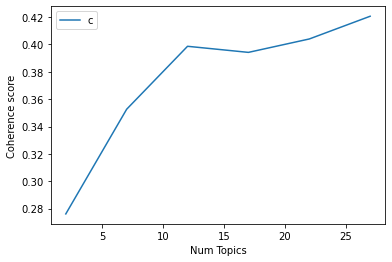

In [99]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [100]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2762
index: 1 | Num Topics = 7  has Coherence Value of 0.3526
index: 2 | Num Topics = 12  has Coherence Value of 0.3986
index: 3 | Num Topics = 17  has Coherence Value of 0.3941
index: 4 | Num Topics = 22  has Coherence Value of 0.4039
index: 5 | Num Topics = 27  has Coherence Value of 0.4205


In [181]:
# Select optimal number of topics
optimal_model_ph_score5 = model_list_ph_score5[5]

In [182]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score5 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score5, corpus_ph_score5, id2word_ph_score5)

In [183]:
print("pyLDAVis for ph topics for score=5:")
vis_ph_score5

pyLDAVis for ph topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26    -0.185380 -0.015417       1        1  6.854529
9     -0.018194 -0.142956       2        1  5.891314
4     -0.038955  0.000254       3        1  5.720242
10    -0.090155  0.002290       4        1  5.405517
8      0.046509 -0.118256       5        1  4.898601
3     -0.076494  0.057313       6        1  4.799951
14    -0.050293 -0.098662       7        1  4.215261
17    -0.158896  0.090077       8        1  4.111419
23     0.200767  0.165725       9        1  4.093481
21    -0.067623 -0.009090      10        1  3.946058
25    -0.054147  0.032233      11        1  3.853836
18    -0.005178  0.115210      12        1  3.784374
24     0.013682 -0.080728      13        1  3.729242
19    -0.017012 -0.041430      14        1  3.728361
13     0.043721 -0.062986      15        1  3.727692
0     -0.008741  0.072201      16        1  3.322763
7      0.045553  0.005455      17        1  3.117849
16    -0.015739 -0.026339      18        1  2.889535
20    -0.003888  0.087550      19        1  2.855482
5      0.088663 -0.043239      20        1  2.759571
2      0.137513 -0.038518      21        1  2.660709
11     0.067928 -0.119661      22        1  2.635125
12     0.034639 -0.071696      23        1  2.530415
1      0.034359  0.051785      24        1  2.448008
15    -0.011202  0.078011      25        1  2.382224
22     0.092243  0.053729      26        1  1.928743
6     -0.003679  0.057145      27        1  1.709697, topic_info=         Term        Freq       Total Category  logprob  loglift
353      view   44.000000   44.000000  Default  30.0000  30.0000
9      delete   32.000000   32.000000  Default  29.0000  29.0000
217     thing   27.000000   27.000000  Default  28.0000  28.0000
51      watch  107.000000  107.000000  Default  27.0000  27.0000
83         ad   49.000000   49.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
46   annoying    0.688760    8.637200  Topic27  -4.7718   1.5399
25    problem    0.688759   20.867836  Topic27  -4.7718   0.6578
64        add    0.688759   21.709574  Topic27  -4.7718   0.6182
151    really    0.688759   23.462521  Topic27  -4.7718   0.5406
132   comment    0.688758   21.150817  Topic27  -4.7718   0.6443

[1494 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
86        1  0.224029        able
86        2  0.112014        able
86        3  0.224029        able
86        4  0.112014        able
86        6  0.112014        able
...     ...       ...         ...
103      18  0.078586          yt
103      19  0.078586          yt
103      23  0.078586          yt
844      11  0.635046  ytbringour
770      11  0.635046        zoom

[2284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 10, 5, 11, 9, 4, 15, 18, 24, 22, 26, 19, 25, 20, 14, 1, 8, 17, 21, 6, 3, 12, 13, 2, 16, 23, 7])

## LDA Topic Modelling (Rating = 1,2,3)

In [104]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_ph_score1N2N3 = youtube_ios_ph_review_YearMonth_score1N2N3.review.values.tolist()
review_words_ph_score1N2N3 = list(sent_to_words(review_ph_score1N2N3))
print(review_words_ph_score1N2N3[:1])

[['cant', 'download', 'videos', 'for', 'offline', 'viewing', 'anymore', 'is', 'it', 'not', 'available', 'anymore', 'don', 'think', 'there', 'was', 'an', 'update', 'removing', 'it']]


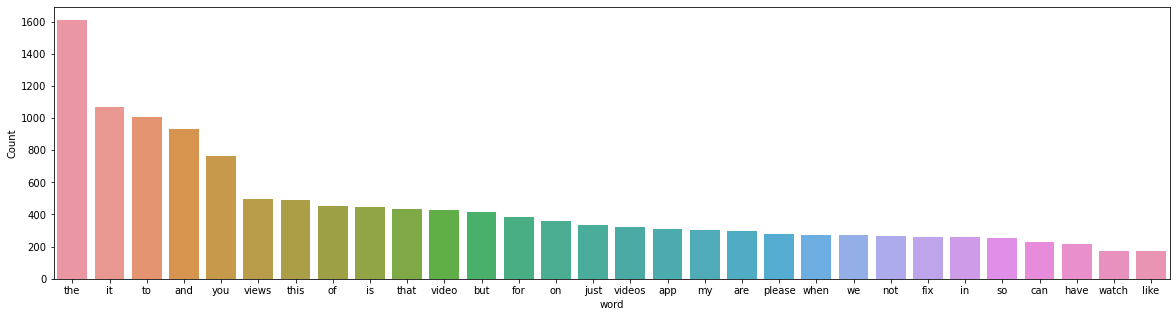

In [105]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score1N2N3))

In [106]:
# Clean text
review_ph_ready_score1N2N3 = process_words(review_words_ph_score1N2N3)  # processed Text Data! - move to each section

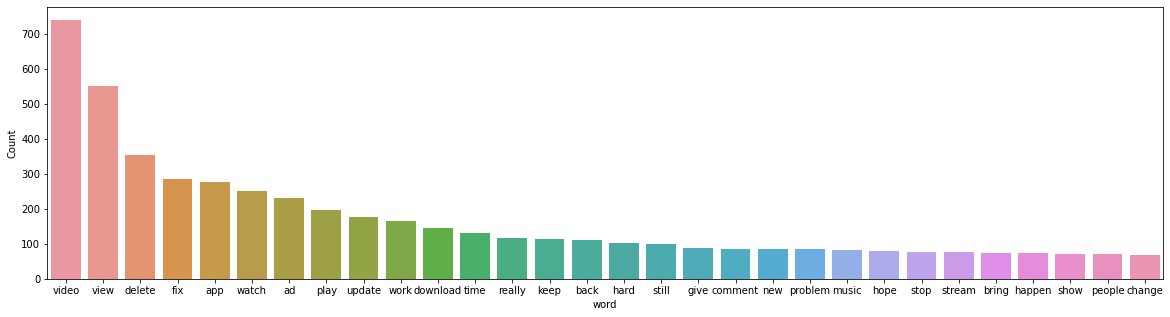

In [107]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score1N2N3))


In [108]:
# Create Dictionary
id2word_ph_score1N2N3 = corpora.Dictionary(review_ph_ready_score1N2N3)

2021-10-17 00:23:32,552 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:23:32,593 [INFO] gensim.corpora.dictionary - built Dictionary(1946 unique tokens: ['anymore', 'available', 'download', 'offline', 'remove']...) from 921 documents (total 14133 corpus positions)
2021-10-17 00:23:32,595 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1946 unique tokens: ['anymore', 'available', 'download', 'offline', 'remove']...) from 921 documents (total 14133 corpus positions)", 'datetime': '2021-10-17T00:23:32.595196', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [109]:
# Create Corpus: Term Document Frequency
corpus_ph_score1N2N3 = [id2word_ph_score1N2N3.doc2bow(text) for text in review_ph_ready_score1N2N3]

In [110]:
# Training LDA model
model_list_ph_score1N2N3, coherence_values_ph_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_score1N2N3, corpus=corpus_ph_score1N2N3, 
                                                              texts=review_ph_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-17 00:23:32,635 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:23:32,637 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:23:32,639 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:23:32,641 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 921 documents, updating model once every 921 documents, evaluating perplexity every 921 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:23:35,938 [INFO] gensim.models.ldamodel - -8.103 per-word bound, 274.9 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:23:35,939 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #921/921
2021-10-17 00:23:39,317 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.047*"view" + 0.026*"delete" + 0.020*"video" + 0.016*"app" + 0.014*"ad" + 0.013*"fix" + 0.010*"work" +

2021-10-17 00:24:04,688 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.071*"video" + 0.029*"fix" + 0.024*"watch" + 0.023*"app" + 0.022*"ad" + 0.021*"play" + 0.018*"update" + 0.015*"download" + 0.010*"time" + 0.008*"keep"
2021-10-17 00:24:04,691 [INFO] gensim.models.ldamodel - topic diff=0.032215, rho=0.301511
2021-10-17 00:24:06,096 [INFO] gensim.models.ldamodel - -6.258 per-word bound, 76.6 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:24:06,098 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #921/921
2021-10-17 00:24:07,319 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.080*"view" + 0.050*"delete" + 0.014*"work" + 0.014*"hard" + 0.012*"video" + 0.011*"stream" + 0.011*"give" + 0.010*"back" + 0.009*"bring" + 0.009*"people"
2021-10-17 00:24:07,321 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.071*"video" + 0.029*"fix" + 0.024*"watch" + 0.023*"app" + 0.023*"ad" + 0.021*"play" + 0.018*"update" + 0.015*"downloa

2021-10-17 00:24:28,188 [INFO] gensim.models.ldamodel - topic diff=0.009829, rho=0.218218
2021-10-17 00:24:29,320 [INFO] gensim.models.ldamodel - -6.245 per-word bound, 75.8 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:24:29,321 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #921/921
2021-10-17 00:24:30,208 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.081*"view" + 0.052*"delete" + 0.015*"work" + 0.015*"hard" + 0.014*"video" + 0.012*"give" + 0.012*"stream" + 0.010*"music" + 0.010*"back" + 0.010*"people"
2021-10-17 00:24:30,210 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.069*"video" + 0.029*"fix" + 0.024*"ad" + 0.024*"app" + 0.023*"watch" + 0.021*"play" + 0.019*"update" + 0.016*"download" + 0.009*"time" + 0.008*"still"
2021-10-17 00:24:30,211 [INFO] gensim.models.ldamodel - topic diff=0.008931, rho=0.213201
2021-10-17 00:24:31,447 [INFO] gensim.models.ldamodel - -6.244 per-word bound, 75.8 perplexity estimat

2021-10-17 00:24:54,284 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #921/921
2021-10-17 00:24:55,339 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.082*"view" + 0.052*"delete" + 0.015*"video" + 0.015*"hard" + 0.015*"work" + 0.012*"give" + 0.012*"stream" + 0.011*"music" + 0.010*"people" + 0.010*"back"
2021-10-17 00:24:55,341 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.069*"video" + 0.029*"fix" + 0.025*"ad" + 0.024*"app" + 0.023*"watch" + 0.021*"play" + 0.019*"update" + 0.016*"download" + 0.009*"time" + 0.008*"still"
2021-10-17 00:24:55,347 [INFO] gensim.models.ldamodel - topic diff=0.004136, rho=0.176777
2021-10-17 00:24:56,758 [INFO] gensim.models.ldamodel - -6.241 per-word bound, 75.6 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:24:56,761 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #921/921
2021-10-17 00:24:57,795 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.082*"view" + 0.052*"

2021-10-17 00:25:18,818 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.068*"video" + 0.029*"fix" + 0.025*"ad" + 0.024*"app" + 0.023*"watch" + 0.021*"play" + 0.019*"update" + 0.016*"download" + 0.009*"time" + 0.008*"still"
2021-10-17 00:25:18,818 [INFO] gensim.models.ldamodel - topic diff=0.002414, rho=0.154303
2021-10-17 00:25:19,999 [INFO] gensim.models.ldamodel - -6.240 per-word bound, 75.6 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:25:20,001 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #921/921
2021-10-17 00:25:20,771 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.082*"view" + 0.052*"delete" + 0.015*"video" + 0.015*"hard" + 0.015*"work" + 0.012*"give" + 0.012*"stream" + 0.011*"music" + 0.010*"people" + 0.010*"bring"
2021-10-17 00:25:20,772 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.068*"video" + 0.029*"fix" + 0.025*"ad" + 0.024*"app" + 0.023*"watch" + 0.021*"play" + 0.019*"update" + 0.016*"downl

2021-10-17 00:25:42,228 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 883 virtual documents
2021-10-17 00:25:42,502 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:25:42,503 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:25:42,507 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:25:42,511 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 921 documents, updating model once every 921 documents, evaluating perplexity every 921 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:25:45,106 [INFO] gensim.models.ldamodel - -9.159 per-word bound, 571.5 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:25:45,107 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #921/921
2021-10-17 00:2

2021-10-17 00:25:59,526 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #921/921
2021-10-17 00:26:00,941 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"view" + 0.014*"delete" + 0.013*"time" + 0.013*"still" + 0.009*"count" + 0.009*"content" + 0.009*"work" + 0.009*"record" + 0.008*"update" + 0.008*"ad"
2021-10-17 00:26:00,943 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"video" + 0.019*"back" + 0.013*"app" + 0.013*"bring" + 0.011*"time" + 0.010*"option" + 0.010*"watch" + 0.010*"work" + 0.010*"phone" + 0.009*"update"
2021-10-17 00:26:01,026 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.099*"view" + 0.064*"delete" + 0.026*"video" + 0.021*"app" + 0.020*"hard" + 0.019*"work" + 0.013*"give" + 0.013*"back" + 0.012*"music" + 0.011*"stream"
2021-10-17 00:26:01,046 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"ad" + 0.023*"view" + 0.016*"delete" + 0.013*"download" + 0.010*"way" + 0.010*"much" + 0.010*"star" + 0.009*"comment" + 0.009*"app" + 0.00

2021-10-17 00:26:13,384 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.021*"view" + 0.013*"still" + 0.013*"time" + 0.012*"content" + 0.010*"record" + 0.009*"count" + 0.008*"number" + 0.008*"update" + 0.008*"available" + 0.008*"instead"
2021-10-17 00:26:13,391 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.114*"view" + 0.072*"delete" + 0.022*"hard" + 0.020*"video" + 0.020*"work" + 0.015*"app" + 0.015*"give" + 0.014*"stream" + 0.014*"music" + 0.013*"back"
2021-10-17 00:26:13,399 [INFO] gensim.models.ldamodel - topic diff=0.040987, rho=0.288675
2021-10-17 00:26:14,854 [INFO] gensim.models.ldamodel - -6.487 per-word bound, 89.7 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:26:14,856 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #921/921
2021-10-17 00:26:15,784 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.036*"ad" + 0.013*"download" + 0.012*"much" + 0.011*"way" + 0.011*"star" + 0.010*"comment" + 0.009*"view" 

2021-10-17 00:26:26,993 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #921/921
2021-10-17 00:26:28,128 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.041*"ad" + 0.013*"much" + 0.012*"way" + 0.011*"star" + 0.011*"download" + 0.010*"advertisement" + 0.010*"skip" + 0.010*"comment" + 0.009*"well" + 0.008*"hate"
2021-10-17 00:26:28,182 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.014*"content" + 0.013*"still" + 0.012*"view" + 0.011*"time" + 0.010*"record" + 0.010*"number" + 0.009*"available" + 0.009*"update" + 0.008*"instead" + 0.008*"check"
2021-10-17 00:26:28,217 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.024*"video" + 0.021*"back" + 0.014*"time" + 0.013*"app" + 0.012*"bring" + 0.011*"option" + 0.010*"phone" + 0.010*"upload" + 0.009*"playlist" + 0.009*"update"
2021-10-17 00:26:28,219 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.120*"view" + 0.076*"delete" + 0.022*"hard" + 0.020*"work" + 0.018*"video" + 0.016*"stream" + 0.015*"give" + 0.014*"mus

2021-10-17 00:26:39,769 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.101*"video" + 0.038*"watch" + 0.038*"play" + 0.033*"fix" + 0.031*"ad" + 0.027*"download" + 0.024*"app" + 0.017*"update" + 0.011*"keep" + 0.011*"offline"
2021-10-17 00:26:39,790 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"video" + 0.035*"fix" + 0.028*"app" + 0.014*"upload" + 0.012*"ad" + 0.012*"update" + 0.010*"view" + 0.010*"time" + 0.010*"issue" + 0.010*"comment"
2021-10-17 00:26:39,824 [INFO] gensim.models.ldamodel - topic diff=0.014165, rho=0.208514
2021-10-17 00:26:41,101 [INFO] gensim.models.ldamodel - -6.451 per-word bound, 87.5 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:26:41,103 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #921/921
2021-10-17 00:26:41,980 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.101*"video" + 0.038*"watch" + 0.038*"play" + 0.033*"fix" + 0.031*"ad" + 0.027*"download" + 0.024*"app" + 0.017*"updat

2021-10-17 00:26:52,189 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #921/921
2021-10-17 00:26:53,109 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.024*"video" + 0.022*"back" + 0.013*"time" + 0.012*"bring" + 0.012*"option" + 0.011*"app" + 0.011*"playlist" + 0.011*"upload" + 0.010*"phone" + 0.008*"channel"
2021-10-17 00:26:53,111 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.122*"view" + 0.078*"delete" + 0.021*"hard" + 0.020*"work" + 0.017*"video" + 0.017*"stream" + 0.015*"give" + 0.014*"music" + 0.013*"people" + 0.012*"back"
2021-10-17 00:26:53,112 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.049*"ad" + 0.015*"much" + 0.012*"advertisement" + 0.012*"skip" + 0.012*"way" + 0.011*"star" + 0.010*"download" + 0.009*"comment" + 0.009*"annoying" + 0.009*"well"
2021-10-17 00:26:53,114 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.101*"video" + 0.039*"watch" + 0.038*"play" + 0.033*"fix" + 0.031*"ad" + 0.026*"download" + 0.024*"app" + 0.017*"update" + 0.

2021-10-17 00:27:03,842 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.102*"video" + 0.039*"watch" + 0.038*"play" + 0.033*"fix" + 0.031*"ad" + 0.026*"download" + 0.025*"app" + 0.017*"update" + 0.011*"keep" + 0.011*"time"
2021-10-17 00:27:03,847 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"video" + 0.036*"fix" + 0.029*"app" + 0.015*"upload" + 0.012*"update" + 0.012*"ad" + 0.010*"comment" + 0.010*"issue" + 0.009*"time" + 0.007*"watch"
2021-10-17 00:27:03,854 [INFO] gensim.models.ldamodel - topic diff=0.006956, rho=0.171499
2021-10-17 00:27:05,104 [INFO] gensim.models.ldamodel - -6.438 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:27:05,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #921/921
2021-10-17 00:27:05,869 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.051*"ad" + 0.016*"much" + 0.013*"skip" + 0.012*"advertisement" + 0.012*"way" + 0.012*"star" + 0.009*"download" + 0.009*

2021-10-17 00:27:15,418 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #921/921
2021-10-17 00:27:16,339 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"video" + 0.037*"fix" + 0.029*"app" + 0.015*"upload" + 0.012*"update" + 0.011*"ad" + 0.010*"comment" + 0.010*"issue" + 0.009*"time" + 0.007*"watch"
2021-10-17 00:27:16,341 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.023*"video" + 0.022*"back" + 0.013*"time" + 0.013*"bring" + 0.012*"option" + 0.012*"playlist" + 0.011*"upload" + 0.010*"app" + 0.010*"phone" + 0.009*"channel"
2021-10-17 00:27:16,343 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.102*"video" + 0.039*"watch" + 0.038*"play" + 0.033*"fix" + 0.031*"ad" + 0.026*"download" + 0.025*"app" + 0.017*"update" + 0.011*"keep" + 0.011*"time"
2021-10-17 00:27:16,345 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.017*"content" + 0.013*"number" + 0.012*"still" + 0.010*"record" + 0.010*"available" + 0.009*"instead" + 0.009*"update" + 0.009*"increase" +

2021-10-17 00:27:27,136 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"update" + 0.028*"video" + 0.027*"change" + 0.023*"comment" + 0.021*"quality" + 0.017*"new" + 0.016*"app" + 0.015*"fix" + 0.015*"back" + 0.014*"search"
2021-10-17 00:27:27,141 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.122*"view" + 0.079*"delete" + 0.021*"hard" + 0.020*"work" + 0.017*"video" + 0.017*"stream" + 0.015*"give" + 0.014*"music" + 0.013*"people" + 0.012*"back"
2021-10-17 00:27:27,147 [INFO] gensim.models.ldamodel - topic diff=0.003754, rho=0.149071
2021-10-17 00:27:28,339 [INFO] gensim.models.ldamodel - -6.432 per-word bound, 86.4 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:27:28,340 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #921/921
2021-10-17 00:27:29,157 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.102*"video" + 0.039*"watch" + 0.038*"play" + 0.033*"fix" + 0.030*"ad" + 0.026*"download" + 0.025*"app" + 0.017*

2021-10-17 00:27:38,370 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #921/921
2021-10-17 00:27:39,102 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.021*"content" + 0.013*"number" + 0.012*"still" + 0.010*"available" + 0.010*"post" + 0.010*"record" + 0.009*"instead" + 0.009*"update" + 0.009*"increase" + 0.008*"return"
2021-10-17 00:27:39,104 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.053*"ad" + 0.018*"much" + 0.013*"skip" + 0.013*"advertisement" + 0.012*"way" + 0.012*"star" + 0.010*"annoying" + 0.010*"hate" + 0.009*"download" + 0.009*"well"
2021-10-17 00:27:39,106 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"update" + 0.027*"video" + 0.027*"change" + 0.023*"comment" + 0.021*"quality" + 0.017*"new" + 0.016*"app" + 0.015*"fix" + 0.015*"back" + 0.014*"version"
2021-10-17 00:27:39,109 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"video" + 0.037*"fix" + 0.029*"app" + 0.016*"upload" + 0.013*"update" + 0.011*"ad" + 0.011*"comment" + 0.011*

2021-10-17 00:28:00,474 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.064*"view" + 0.048*"delete" + 0.038*"app" + 0.034*"video" + 0.018*"watch" + 0.017*"work" + 0.016*"hard" + 0.014*"give" + 0.013*"time" + 0.013*"update"
2021-10-17 00:28:00,475 [INFO] gensim.models.ldamodel - topic diff=0.152096, rho=0.447214
2021-10-17 00:28:01,864 [INFO] gensim.models.ldamodel - -6.698 per-word bound, 103.9 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:28:01,867 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #921/921
2021-10-17 00:28:02,919 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.021*"time" + 0.017*"stream" + 0.017*"view" + 0.012*"delete" + 0.012*"fix" + 0.012*"still" + 0.011*"comment" + 0.011*"work" + 0.010*"waste" + 0.010*"effort"
2021-10-17 00:28:02,921 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.089*"video" + 0.043*"download" + 0.034*"watch" + 0.028*"fix" + 0.018*"play" + 0.017*"offline" + 0.014*"app" + 0.01

2021-10-17 00:28:16,140 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.029*"view" + 0.019*"comment" + 0.018*"delete" + 0.015*"hate" + 0.015*"star" + 0.013*"well" + 0.013*"app" + 0.011*"stream" + 0.010*"phone" + 0.010*"already"
2021-10-17 00:28:16,145 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.028*"video" + 0.023*"update" + 0.021*"change" + 0.021*"version" + 0.017*"app" + 0.017*"io" + 0.016*"watch" + 0.015*"old" + 0.014*"new" + 0.013*"iphone"
2021-10-17 00:28:16,156 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"video" + 0.033*"quality" + 0.023*"change" + 0.022*"fix" + 0.018*"search" + 0.016*"load" + 0.015*"picture" + 0.015*"app" + 0.014*"update" + 0.014*"keep"
2021-10-17 00:28:16,161 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.106*"video" + 0.098*"ad" + 0.064*"play" + 0.036*"fix" + 0.034*"watch" + 0.016*"app" + 0.016*"annoying" + 0.013*"audio" + 0.012*"screen" + 0.010*"sometimes"
2021-10-17 00:28:16,167 [INFO] gensim.models.ldamodel - topic diff=0.051139

2021-10-17 00:28:29,599 [INFO] gensim.models.ldamodel - topic diff=0.027504, rho=0.250000
2021-10-17 00:28:30,999 [INFO] gensim.models.ldamodel - -6.590 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:28:31,000 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #921/921
2021-10-17 00:28:32,097 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"bug" + 0.022*"work" + 0.020*"update" + 0.018*"app" + 0.018*"late" + 0.015*"properly" + 0.015*"crash" + 0.015*"help" + 0.014*"load" + 0.011*"back"
2021-10-17 00:28:32,099 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.027*"comment" + 0.027*"view" + 0.019*"hate" + 0.016*"delete" + 0.015*"star" + 0.015*"well" + 0.013*"section" + 0.011*"stream" + 0.011*"app" + 0.011*"phone"
2021-10-17 00:28:32,102 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"video" + 0.035*"quality" + 0.026*"change" + 0.022*"fix" + 0.018*"search" + 0.017*"picture" + 0.015*"load" + 0

2021-10-17 00:28:45,539 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"comment" + 0.025*"view" + 0.022*"hate" + 0.018*"section" + 0.015*"star" + 0.015*"well" + 0.015*"delete" + 0.011*"already" + 0.011*"stream" + 0.011*"phone"
2021-10-17 00:28:45,542 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"video" + 0.035*"quality" + 0.027*"change" + 0.022*"fix" + 0.018*"search" + 0.018*"picture" + 0.014*"setting" + 0.014*"load" + 0.013*"app" + 0.013*"update"
2021-10-17 00:28:45,545 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.031*"bug" + 0.022*"work" + 0.020*"update" + 0.018*"late" + 0.017*"app" + 0.017*"help" + 0.016*"crash" + 0.016*"properly" + 0.015*"load" + 0.011*"back"
2021-10-17 00:28:45,550 [INFO] gensim.models.ldamodel - topic diff=0.016790, rho=0.213201
2021-10-17 00:28:46,874 [INFO] gensim.models.ldamodel - -6.572 per-word bound, 95.2 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:28:46,875 [INFO] gensim.models.l

2021-10-17 00:28:56,718 [INFO] gensim.models.ldamodel - topic diff=0.011711, rho=0.192450
2021-10-17 00:28:57,966 [INFO] gensim.models.ldamodel - -6.561 per-word bound, 94.4 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:28:57,968 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #921/921
2021-10-17 00:28:58,973 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.034*"update" + 0.029*"fix" + 0.017*"app" + 0.017*"hope" + 0.014*"premium" + 0.012*"keep" + 0.009*"show" + 0.009*"bring" + 0.009*"wait" + 0.009*"already"
2021-10-17 00:28:58,975 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.092*"video" + 0.050*"download" + 0.039*"watch" + 0.031*"fix" + 0.018*"offline" + 0.017*"app" + 0.016*"play" + 0.015*"update" + 0.012*"internet" + 0.011*"show"
2021-10-17 00:28:58,977 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.134*"view" + 0.067*"delete" + 0.035*"music" + 0.031*"video" + 0.023*"hard" + 0.021*"work" + 0.018*"people" +

2021-10-17 00:29:11,463 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.109*"video" + 0.104*"ad" + 0.066*"play" + 0.036*"fix" + 0.035*"watch" + 0.019*"annoying" + 0.018*"app" + 0.013*"screen" + 0.013*"audio" + 0.010*"issue"
2021-10-17 00:29:11,464 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.023*"time" + 0.015*"comment" + 0.014*"stream" + 0.013*"still" + 0.012*"fun" + 0.011*"yt" + 0.010*"waste" + 0.010*"never" + 0.010*"work" + 0.010*"fix"
2021-10-17 00:29:11,466 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.097*"view" + 0.081*"delete" + 0.020*"work" + 0.019*"hard" + 0.018*"really" + 0.018*"bring" + 0.015*"million" + 0.015*"much" + 0.015*"army" + 0.015*"stream"
2021-10-17 00:29:11,466 [INFO] gensim.models.ldamodel - topic diff=0.008493, rho=0.174078
2021-10-17 00:29:12,717 [INFO] gensim.models.ldamodel - -6.552 per-word bound, 93.8 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:29:12,721 [INFO] gensim.models.ldamodel - PR

2021-10-17 00:29:24,096 [INFO] gensim.models.ldamodel - -6.546 per-word bound, 93.4 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:29:24,097 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #921/921
2021-10-17 00:29:24,933 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.031*"version" + 0.030*"update" + 0.025*"video" + 0.022*"new" + 0.021*"change" + 0.020*"io" + 0.018*"app" + 0.015*"old" + 0.014*"watch" + 0.013*"still"
2021-10-17 00:29:24,935 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.140*"view" + 0.071*"delete" + 0.034*"music" + 0.030*"video" + 0.024*"hard" + 0.022*"work" + 0.020*"people" + 0.017*"stream" + 0.017*"fair" + 0.016*"back"
2021-10-17 00:29:24,937 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.055*"app" + 0.028*"video" + 0.025*"delete" + 0.022*"view" + 0.020*"watch" + 0.020*"time" + 0.019*"crash" + 0.018*"open" + 0.016*"give" + 0.016*"upload"
2021-10-17 00:29:24,940 [INFO] gensim.models.ldamodel 

2021-10-17 00:29:37,839 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.109*"video" + 0.104*"ad" + 0.066*"play" + 0.036*"fix" + 0.035*"watch" + 0.019*"annoying" + 0.018*"app" + 0.013*"screen" + 0.013*"audio" + 0.010*"sometimes"
2021-10-17 00:29:37,841 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.098*"view" + 0.082*"delete" + 0.021*"work" + 0.019*"hard" + 0.018*"really" + 0.017*"bring" + 0.015*"much" + 0.014*"million" + 0.014*"army" + 0.014*"stream"
2021-10-17 00:29:37,842 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.040*"video" + 0.035*"quality" + 0.031*"change" + 0.019*"fix" + 0.019*"picture" + 0.017*"search" + 0.015*"setting" + 0.013*"back" + 0.013*"app" + 0.013*"new"
2021-10-17 00:29:37,843 [INFO] gensim.models.ldamodel - topic diff=0.005545, rho=0.150756
2021-10-17 00:29:39,508 [INFO] gensim.models.ldamodel - -6.540 per-word bound, 93.1 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:29:39,510 [INFO] gensim.models.ld

2021-10-17 00:29:51,831 [INFO] gensim.models.ldamodel - topic diff=0.004573, rho=0.142857
2021-10-17 00:29:53,237 [INFO] gensim.models.ldamodel - -6.536 per-word bound, 92.8 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:29:53,238 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #921/921
2021-10-17 00:29:54,555 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.029*"bug" + 0.023*"work" + 0.020*"update" + 0.019*"help" + 0.017*"load" + 0.016*"wrong" + 0.016*"properly" + 0.015*"app" + 0.013*"late" + 0.013*"crash"
2021-10-17 00:29:54,580 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.061*"comment" + 0.032*"section" + 0.025*"hate" + 0.019*"star" + 0.016*"well" + 0.013*"already" + 0.010*"put" + 0.010*"phone" + 0.010*"advertisement" + 0.010*"give"
2021-10-17 00:29:54,592 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"video" + 0.035*"quality" + 0.031*"change" + 0.019*"picture" + 0.019*"fix" + 0.016*"search" + 0.015*"

2021-10-17 00:30:17,124 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.039*"view" + 0.031*"ad" + 0.030*"delete" + 0.026*"comment" + 0.019*"keep" + 0.017*"fix" + 0.016*"play" + 0.014*"section" + 0.013*"freeze" + 0.011*"crash"
2021-10-17 00:30:17,128 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.034*"video" + 0.032*"app" + 0.025*"bug" + 0.023*"fix" + 0.022*"update" + 0.019*"comment" + 0.015*"help" + 0.015*"work" + 0.015*"start" + 0.014*"version"
2021-10-17 00:30:17,132 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.049*"view" + 0.034*"delete" + 0.020*"app" + 0.014*"well" + 0.014*"video" + 0.013*"download" + 0.013*"phone" + 0.013*"new" + 0.012*"happen" + 0.011*"fix"
2021-10-17 00:30:17,135 [INFO] gensim.models.ldamodel - topic diff=0.180986, rho=0.500000
2021-10-17 00:30:19,016 [INFO] gensim.models.ldamodel - -6.870 per-word bound, 117.0 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:30:19,019 [INFO] gensim.models.ldamodel -

2021-10-17 00:30:29,753 [INFO] gensim.models.ldamodel - topic diff=0.087257, rho=0.333333
2021-10-17 00:30:31,188 [INFO] gensim.models.ldamodel - -6.730 per-word bound, 106.2 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:30:31,189 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #921/921
2021-10-17 00:30:32,313 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.119*"video" + 0.094*"ad" + 0.078*"play" + 0.037*"fix" + 0.036*"watch" + 0.019*"update" + 0.018*"app" + 0.016*"annoying" + 0.012*"audio" + 0.011*"load"
2021-10-17 00:30:32,316 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.106*"video" + 0.068*"download" + 0.043*"watch" + 0.030*"fix" + 0.028*"offline" + 0.015*"show" + 0.012*"caption" + 0.011*"error" + 0.010*"already" + 0.009*"internet"
2021-10-17 00:30:32,321 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.044*"view" + 0.035*"delete" + 0.020*"app" + 0.018*"well" + 0.015*"new" + 0.015*"phone" + 0.014*"stream" +

2021-10-17 00:30:43,833 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.035*"bug" + 0.031*"app" + 0.028*"video" + 0.026*"fix" + 0.026*"help" + 0.024*"comment" + 0.021*"update" + 0.017*"work" + 0.016*"properly" + 0.016*"start"
2021-10-17 00:30:43,841 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.027*"change" + 0.020*"time" + 0.019*"video" + 0.016*"watch" + 0.016*"always" + 0.016*"last" + 0.016*"fix" + 0.015*"app" + 0.013*"crash" + 0.012*"option"
2021-10-17 00:30:43,877 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.046*"view" + 0.035*"delete" + 0.013*"count" + 0.012*"work" + 0.012*"million" + 0.011*"army" + 0.011*"profile" + 0.009*"number" + 0.009*"mark" + 0.009*"bad"
2021-10-17 00:30:43,883 [INFO] gensim.models.ldamodel - topic diff=0.039584, rho=0.258199
2021-10-17 00:30:45,108 [INFO] gensim.models.ldamodel - -6.671 per-word bound, 101.9 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:30:45,110 [INFO] gensim.models.ldamode

2021-10-17 00:30:55,139 [INFO] gensim.models.ldamodel - topic diff=0.024027, rho=0.223607
2021-10-17 00:30:56,583 [INFO] gensim.models.ldamodel - -6.646 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:30:56,586 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #921/921
2021-10-17 00:30:57,540 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.036*"bug" + 0.030*"help" + 0.028*"app" + 0.027*"video" + 0.025*"fix" + 0.021*"comment" + 0.019*"update" + 0.018*"work" + 0.016*"start" + 0.016*"properly"
2021-10-17 00:30:57,542 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.109*"update" + 0.056*"app" + 0.046*"version" + 0.034*"new" + 0.025*"video" + 0.024*"still" + 0.024*"keep" + 0.023*"io" + 0.015*"anymore" + 0.015*"watch"
2021-10-17 00:30:57,545 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.149*"comment" + 0.049*"section" + 0.030*"ad" + 0.022*"fix" + 0.013*"write" + 0.013*"annoy" + 0.013*"keep" + 0.0

2021-10-17 00:31:09,875 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.050*"quality" + 0.042*"video" + 0.031*"change" + 0.019*"picture" + 0.019*"high" + 0.016*"back" + 0.016*"really" + 0.014*"fix" + 0.013*"app" + 0.013*"setting"
2021-10-17 00:31:09,877 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.037*"bug" + 0.034*"help" + 0.026*"app" + 0.026*"video" + 0.024*"fix" + 0.020*"comment" + 0.019*"work" + 0.018*"update" + 0.017*"start" + 0.014*"loading"
2021-10-17 00:31:09,878 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.044*"app" + 0.025*"video" + 0.024*"view" + 0.022*"delete" + 0.017*"open" + 0.014*"watch" + 0.014*"keep" + 0.013*"give" + 0.013*"work" + 0.011*"still"
2021-10-17 00:31:09,879 [INFO] gensim.models.ldamodel - topic diff=0.015203, rho=0.196116
2021-10-17 00:31:11,246 [INFO] gensim.models.ldamodel - -6.628 per-word bound, 98.9 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:31:11,247 [INFO] gensim.models.ldamodel - 

2021-10-17 00:31:21,541 [INFO] gensim.models.ldamodel - topic diff=0.011253, rho=0.179605
2021-10-17 00:31:22,686 [INFO] gensim.models.ldamodel - -6.619 per-word bound, 98.3 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:31:22,687 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #921/921
2021-10-17 00:31:23,605 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.047*"video" + 0.035*"fix" + 0.025*"app" + 0.024*"view" + 0.017*"delete" + 0.015*"watch" + 0.014*"time" + 0.010*"really" + 0.010*"issue" + 0.009*"upload"
2021-10-17 00:31:23,606 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.124*"video" + 0.097*"ad" + 0.077*"play" + 0.043*"fix" + 0.039*"watch" + 0.021*"app" + 0.015*"update" + 0.015*"annoying" + 0.015*"time" + 0.014*"crash"
2021-10-17 00:31:23,608 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.035*"video" + 0.021*"watch" + 0.020*"load" + 0.020*"app" + 0.014*"time" + 0.013*"fast" + 0.013*"internet" + 0.011*"e

2021-10-17 00:31:35,197 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.038*"video" + 0.015*"update" + 0.014*"fix" + 0.011*"like" + 0.010*"work" + 0.009*"give" + 0.009*"bug" + 0.009*"press" + 0.008*"problem" + 0.007*"show"
2021-10-17 00:31:35,200 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.118*"update" + 0.059*"app" + 0.044*"version" + 0.033*"new" + 0.026*"video" + 0.025*"still" + 0.024*"io" + 0.024*"keep" + 0.015*"anymore" + 0.014*"crash"
2021-10-17 00:31:35,203 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.035*"view" + 0.029*"delete" + 0.024*"well" + 0.023*"app" + 0.018*"phone" + 0.018*"new" + 0.017*"hate" + 0.017*"stream" + 0.013*"happen" + 0.012*"bug"
2021-10-17 00:31:35,208 [INFO] gensim.models.ldamodel - topic diff=0.008007, rho=0.164399
2021-10-17 00:31:36,526 [INFO] gensim.models.ldamodel - -6.610 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:31:36,527 [INFO] gensim.models.ldamodel - PROGR

2021-10-17 00:31:47,868 [INFO] gensim.models.ldamodel - topic diff=0.006546, rho=0.154303
2021-10-17 00:31:48,975 [INFO] gensim.models.ldamodel - -6.605 per-word bound, 97.3 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:31:48,976 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #921/921
2021-10-17 00:31:49,856 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.041*"help" + 0.039*"bug" + 0.025*"video" + 0.023*"fix" + 0.022*"app" + 0.021*"work" + 0.020*"comment" + 0.018*"start" + 0.015*"slow" + 0.014*"restart"
2021-10-17 00:31:49,858 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.037*"video" + 0.021*"watch" + 0.020*"app" + 0.020*"load" + 0.014*"fast" + 0.013*"time" + 0.013*"internet" + 0.012*"experience" + 0.011*"show" + 0.009*"money"
2021-10-17 00:31:49,862 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.033*"view" + 0.027*"delete" + 0.024*"well" + 0.023*"app" + 0.018*"phone" + 0.018*"new" + 0.017*"hate" + 0.017*"

2021-10-17 00:32:02,387 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.038*"video" + 0.021*"watch" + 0.021*"app" + 0.020*"load" + 0.014*"fast" + 0.013*"internet" + 0.013*"time" + 0.012*"experience" + 0.011*"show" + 0.009*"money"
2021-10-17 00:32:02,389 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.047*"video" + 0.036*"fix" + 0.027*"app" + 0.019*"view" + 0.015*"watch" + 0.014*"time" + 0.011*"delete" + 0.011*"really" + 0.010*"issue" + 0.010*"love"
2021-10-17 00:32:02,394 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.016*"view" + 0.015*"never" + 0.012*"profile" + 0.012*"bad" + 0.012*"sure" + 0.012*"delete" + 0.011*"tell" + 0.011*"million" + 0.011*"count" + 0.010*"work"
2021-10-17 00:32:02,397 [INFO] gensim.models.ldamodel - topic diff=0.005026, rho=0.144338
2021-10-17 00:32:03,550 [INFO] gensim.models.ldamodel - -6.600 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:32:03,552 [INFO] gensim.models.ldamod

2021-10-17 00:32:23,249 [INFO] gensim.models.ldamodel - -7.123 per-word bound, 139.3 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:32:23,250 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #921/921
2021-10-17 00:32:24,482 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.050*"video" + 0.026*"view" + 0.019*"bug" + 0.014*"update" + 0.014*"fix" + 0.013*"give" + 0.012*"play" + 0.010*"app" + 0.009*"work" + 0.009*"open"
2021-10-17 00:32:24,484 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.091*"view" + 0.051*"video" + 0.043*"delete" + 0.042*"music" + 0.018*"play" + 0.016*"ad" + 0.014*"back" + 0.012*"people" + 0.012*"hard" + 0.012*"keep"
2021-10-17 00:32:24,490 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.056*"view" + 0.028*"delete" + 0.025*"bring" + 0.022*"back" + 0.020*"really" + 0.018*"time" + 0.017*"fix" + 0.015*"already" + 0.013*"update" + 0.013*"video"
2021-10-17 00:32:24,500 [INFO] gensim.models.ldamodel - t

2021-10-17 00:32:37,136 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.023*"comment" + 0.022*"update" + 0.020*"app" + 0.017*"account" + 0.015*"screen" + 0.014*"put" + 0.014*"hope" + 0.013*"work" + 0.011*"minimize" + 0.011*"listen"
2021-10-17 00:32:37,137 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.091*"video" + 0.050*"download" + 0.033*"watch" + 0.029*"fix" + 0.024*"offline" + 0.020*"play" + 0.014*"update" + 0.013*"show" + 0.012*"still" + 0.012*"app"
2021-10-17 00:32:37,138 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.047*"version" + 0.032*"app" + 0.031*"work" + 0.025*"io" + 0.023*"video" + 0.021*"iphone" + 0.021*"comment" + 0.019*"old" + 0.017*"speed" + 0.016*"fix"
2021-10-17 00:32:37,139 [INFO] gensim.models.ldamodel - topic diff=0.109295, rho=0.353553
2021-10-17 00:32:38,614 [INFO] gensim.models.ldamodel - -6.806 per-word bound, 111.9 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:32:38,615 [INFO] gensim.models.lda

2021-10-17 00:32:49,307 [INFO] gensim.models.ldamodel - topic diff=0.055231, rho=0.277350
2021-10-17 00:32:50,527 [INFO] gensim.models.ldamodel - -6.734 per-word bound, 106.4 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:32:50,528 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #921/921
2021-10-17 00:32:51,553 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.093*"view" + 0.064*"delete" + 0.027*"app" + 0.026*"work" + 0.023*"hard" + 0.017*"give" + 0.017*"video" + 0.016*"really" + 0.015*"watch" + 0.013*"stream"
2021-10-17 00:32:51,556 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.128*"video" + 0.104*"ad" + 0.069*"play" + 0.045*"watch" + 0.036*"fix" + 0.018*"annoying" + 0.016*"audio" + 0.011*"screen" + 0.010*"update" + 0.010*"app"
2021-10-17 00:32:51,570 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.033*"hour" + 0.020*"delete" + 0.019*"people" + 0.018*"million" + 0.017*"stream" + 0.016*"enough" + 0.016*"kid" + 

2021-10-17 00:33:03,630 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.091*"view" + 0.063*"delete" + 0.026*"app" + 0.025*"work" + 0.023*"hard" + 0.018*"give" + 0.016*"video" + 0.016*"really" + 0.015*"watch" + 0.013*"back"
2021-10-17 00:33:03,633 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.130*"video" + 0.105*"ad" + 0.069*"play" + 0.047*"watch" + 0.037*"fix" + 0.018*"annoying" + 0.017*"audio" + 0.011*"screen" + 0.010*"update" + 0.009*"much"
2021-10-17 00:33:03,636 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.060*"video" + 0.018*"size" + 0.018*"mini" + 0.014*"post" + 0.014*"keep" + 0.014*"small" + 0.012*"annoying" + 0.011*"turn" + 0.011*"copy" + 0.011*"picture"
2021-10-17 00:33:03,638 [INFO] gensim.models.ldamodel - topic diff=0.029354, rho=0.229416
2021-10-17 00:33:04,975 [INFO] gensim.models.ldamodel - -6.698 per-word bound, 103.9 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:33:04,977 [INFO] gensim.models.ldamodel -

2021-10-17 00:33:15,254 [INFO] gensim.models.ldamodel - topic diff=0.018129, rho=0.204124
2021-10-17 00:33:16,550 [INFO] gensim.models.ldamodel - -6.682 per-word bound, 102.6 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:33:16,551 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #921/921
2021-10-17 00:33:17,656 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.057*"video" + 0.036*"fix" + 0.031*"upload" + 0.027*"app" + 0.016*"ad" + 0.013*"watch" + 0.013*"issue" + 0.012*"long" + 0.012*"time" + 0.009*"problem"
2021-10-17 00:33:17,658 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.026*"comment" + 0.024*"update" + 0.020*"account" + 0.016*"put" + 0.016*"app" + 0.015*"screen" + 0.013*"listen" + 0.013*"minimize" + 0.012*"hope" + 0.011*"music"
2021-10-17 00:33:17,661 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.040*"delete" + 0.023*"view" + 0.021*"keep" + 0.019*"bot" + 0.016*"human" + 0.013*"away" + 0.012*"pop" + 0.0

2021-10-17 00:33:32,020 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.052*"view" + 0.031*"bring" + 0.030*"back" + 0.029*"already" + 0.028*"delete" + 0.014*"option" + 0.014*"time" + 0.013*"really" + 0.013*"fix" + 0.011*"star"
2021-10-17 00:33:32,022 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.026*"comment" + 0.024*"update" + 0.020*"account" + 0.017*"put" + 0.016*"app" + 0.015*"screen" + 0.013*"listen" + 0.013*"minimize" + 0.012*"hope" + 0.011*"music"
2021-10-17 00:33:32,025 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.074*"view" + 0.052*"delete" + 0.026*"million" + 0.026*"count" + 0.014*"disappoint" + 0.012*"manipulate" + 0.011*"work" + 0.011*"fair" + 0.010*"army" + 0.010*"hard"
2021-10-17 00:33:32,026 [INFO] gensim.models.ldamodel - topic diff=0.011084, rho=0.182574
2021-10-17 00:33:33,376 [INFO] gensim.models.ldamodel - -6.670 per-word bound, 101.8 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:33:33,377 [INFO] ge

2021-10-17 00:33:42,900 [INFO] gensim.models.ldamodel - topic diff=0.007978, rho=0.169031
2021-10-17 00:33:44,256 [INFO] gensim.models.ldamodel - -6.662 per-word bound, 101.3 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:33:44,257 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #921/921
2021-10-17 00:33:45,132 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.077*"app" + 0.057*"update" + 0.053*"fix" + 0.047*"video" + 0.045*"crash" + 0.036*"open" + 0.030*"keep" + 0.022*"load" + 0.021*"search" + 0.020*"time"
2021-10-17 00:33:45,133 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.031*"ad" + 0.028*"still" + 0.022*"time" + 0.022*"work" + 0.015*"delete" + 0.015*"ipad" + 0.013*"channel" + 0.013*"community" + 0.013*"watch" + 0.013*"understand"
2021-10-17 00:33:45,135 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.086*"view" + 0.059*"delete" + 0.028*"app" + 0.021*"work" + 0.020*"give" + 0.019*"hard" + 0.016*"really" + 0

2021-10-17 00:33:56,131 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.147*"view" + 0.086*"delete" + 0.035*"music" + 0.029*"video" + 0.026*"hard" + 0.026*"stream" + 0.025*"work" + 0.018*"stop" + 0.017*"people" + 0.014*"hour"
2021-10-17 00:33:56,132 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.031*"ad" + 0.028*"still" + 0.022*"time" + 0.022*"work" + 0.015*"ipad" + 0.014*"delete" + 0.013*"community" + 0.013*"understand" + 0.013*"watch" + 0.013*"post"
2021-10-17 00:33:56,133 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.039*"delete" + 0.021*"view" + 0.020*"keep" + 0.020*"bot" + 0.017*"human" + 0.013*"away" + 0.012*"pop" + 0.012*"app" + 0.010*"really" + 0.010*"consider"
2021-10-17 00:33:56,134 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.050*"video" + 0.040*"quality" + 0.036*"change" + 0.024*"back" + 0.022*"new" + 0.021*"update" + 0.020*"setting" + 0.015*"really" + 0.013*"comment" + 0.013*"app"
2021-10-17 00:33:56,135 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-17 00:34:07,557 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.085*"view" + 0.058*"delete" + 0.029*"app" + 0.021*"give" + 0.019*"work" + 0.017*"hard" + 0.016*"really" + 0.016*"video" + 0.016*"watch" + 0.013*"back"
2021-10-17 00:34:07,570 [INFO] gensim.models.ldamodel - topic diff=0.004723, rho=0.147442
2021-10-17 00:34:08,924 [INFO] gensim.models.ldamodel - -6.654 per-word bound, 100.7 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:34:08,927 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #921/921
2021-10-17 00:34:10,028 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.039*"delete" + 0.021*"view" + 0.021*"keep" + 0.020*"bot" + 0.017*"human" + 0.013*"away" + 0.012*"pop" + 0.012*"app" + 0.010*"really" + 0.010*"consider"
2021-10-17 00:34:10,031 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.147*"view" + 0.087*"delete" + 0.034*"music" + 0.029*"video" + 0.027*"hard" + 0.026*"work" + 0.026*"stream" + 0.017*"

2021-10-17 00:34:19,515 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:34:26,265 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:34:26,421 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 919 virtual documents
2021-10-17 00:34:31,045 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-17 00:34:31,048 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-17 00:34:31,052 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:34:31,064 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 921 documents, updating model once every 921 documents, evaluating perplexity every 921 documents, iterating 50x with a 

2021-10-17 00:34:47,818 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.036*"video" + 0.024*"view" + 0.023*"app" + 0.021*"change" + 0.019*"back" + 0.018*"bring" + 0.018*"iphone" + 0.015*"work" + 0.014*"still" + 0.013*"hard"
2021-10-17 00:34:47,823 [INFO] gensim.models.ldamodel - topic diff=0.151861, rho=0.408248
2021-10-17 00:34:49,391 [INFO] gensim.models.ldamodel - -6.961 per-word bound, 124.6 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:34:49,392 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #921/921
2021-10-17 00:34:50,451 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.121*"video" + 0.092*"play" + 0.088*"ad" + 0.046*"fix" + 0.038*"watch" + 0.019*"screen" + 0.014*"update" + 0.012*"freeze" + 0.011*"black" + 0.011*"problem"
2021-10-17 00:34:50,453 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.040*"view" + 0.019*"content" + 0.017*"quality" + 0.016*"delete" + 0.014*"count" + 0.012*"record" + 0.011*"update"

2021-10-17 00:35:02,644 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.022*"app" + 0.021*"view" + 0.017*"hate" + 0.015*"star" + 0.014*"phone" + 0.012*"comment" + 0.012*"update" + 0.012*"give" + 0.011*"delete" + 0.011*"new"
2021-10-17 00:35:02,646 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.049*"video" + 0.017*"view" + 0.014*"work" + 0.014*"watch" + 0.014*"time" + 0.014*"speed" + 0.014*"channel" + 0.012*"window" + 0.011*"yt" + 0.010*"fix"
2021-10-17 00:35:02,649 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.130*"video" + 0.104*"ad" + 0.101*"play" + 0.047*"fix" + 0.041*"watch" + 0.018*"screen" + 0.014*"annoying" + 0.013*"start" + 0.013*"update" + 0.011*"freeze"
2021-10-17 00:35:02,653 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.036*"video" + 0.029*"download" + 0.023*"quality" + 0.019*"watch" + 0.017*"setting" + 0.017*"anymore" + 0.017*"high" + 0.016*"notification" + 0.012*"fix" + 0.012*"way"
2021-10-17 00:35:02,655 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 00:35:15,001 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.057*"video" + 0.039*"comment" + 0.036*"play" + 0.024*"section" + 0.020*"turn" + 0.015*"bug" + 0.015*"read" + 0.015*"app" + 0.013*"give" + 0.013*"watch"
2021-10-17 00:35:15,003 [INFO] gensim.models.ldamodel - topic diff=0.036901, rho=0.242536
2021-10-17 00:35:16,388 [INFO] gensim.models.ldamodel - -6.802 per-word bound, 111.6 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:35:16,389 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #921/921
2021-10-17 00:35:17,445 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.080*"view" + 0.060*"delete" + 0.021*"give" + 0.017*"video" + 0.016*"app" + 0.013*"keep" + 0.013*"watch" + 0.013*"streaming" + 0.012*"time" + 0.012*"day"
2021-10-17 00:35:17,498 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.098*"update" + 0.058*"app" + 0.027*"fix" + 0.026*"video" + 0.024*"io" + 0.024*"version" + 0.022*"still" + 0.019*"

2021-10-17 00:35:29,266 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.052*"video" + 0.015*"watch" + 0.015*"speed" + 0.015*"channel" + 0.014*"time" + 0.014*"work" + 0.013*"window" + 0.012*"yt" + 0.010*"view" + 0.010*"hope"
2021-10-17 00:35:29,268 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.051*"video" + 0.035*"search" + 0.029*"change" + 0.027*"fix" + 0.023*"app" + 0.022*"quality" + 0.022*"back" + 0.015*"work" + 0.014*"click" + 0.012*"load"
2021-10-17 00:35:29,269 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.021*"ad" + 0.019*"work" + 0.017*"sort" + 0.017*"watch" + 0.017*"app" + 0.015*"support" + 0.015*"guy" + 0.013*"almost" + 0.013*"banner" + 0.013*"video"
2021-10-17 00:35:29,272 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.025*"view" + 0.023*"content" + 0.018*"quality" + 0.013*"count" + 0.013*"record" + 0.012*"world" + 0.010*"instead" + 0.010*"still" + 0.010*"sound" + 0.010*"mark"
2021-10-17 00:35:29,274 [INFO] gensim.models.ldamodel - topic diff=0.021814,

2021-10-17 00:35:42,279 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.124*"video" + 0.061*"download" + 0.049*"watch" + 0.024*"fix" + 0.023*"offline" + 0.014*"show" + 0.014*"premium" + 0.012*"already" + 0.012*"let" + 0.011*"still"
2021-10-17 00:35:42,281 [INFO] gensim.models.ldamodel - topic diff=0.015006, rho=0.188982
2021-10-17 00:35:43,570 [INFO] gensim.models.ldamodel - -6.760 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:35:43,572 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #921/921
2021-10-17 00:35:44,655 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.026*"help" + 0.024*"people" + 0.022*"problem" + 0.022*"change" + 0.022*"ridiculous" + 0.021*"work" + 0.014*"connection" + 0.013*"way" + 0.009*"wrong" + 0.008*"disappear"
2021-10-17 00:35:44,656 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.053*"video" + 0.015*"watch" + 0.015*"speed" + 0.015*"channel" + 0.014*"time" + 0.013*"wor

2021-10-17 00:35:56,633 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.022*"ad" + 0.018*"guy" + 0.018*"sort" + 0.017*"watch" + 0.016*"work" + 0.015*"support" + 0.015*"app" + 0.014*"banner" + 0.014*"almost" + 0.014*"option"
2021-10-17 00:35:56,635 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.032*"issue" + 0.025*"playlist" + 0.021*"put" + 0.018*"update" + 0.018*"video" + 0.017*"add" + 0.017*"lately" + 0.017*"playing" + 0.017*"become" + 0.016*"show"
2021-10-17 00:35:56,637 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.060*"video" + 0.051*"picture" + 0.021*"watch" + 0.019*"user" + 0.018*"time" + 0.016*"experience" + 0.016*"click" + 0.015*"quality" + 0.014*"already" + 0.013*"show"
2021-10-17 00:35:56,642 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.053*"ad" + 0.043*"video" + 0.020*"much" + 0.016*"view" + 0.014*"really" + 0.014*"fix" + 0.012*"annoying" + 0.011*"open" + 0.011*"hope" + 0.010*"issue"
2021-10-17 00:35:56,643 [INFO] gensim.models.ldamodel - topic diff

2021-10-17 00:36:08,546 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.037*"time" + 0.020*"hope" + 0.018*"channel" + 0.015*"really" + 0.014*"next" + 0.013*"fan" + 0.013*"comment" + 0.013*"check" + 0.013*"happen" + 0.011*"already"
2021-10-17 00:36:08,549 [INFO] gensim.models.ldamodel - topic diff=0.007335, rho=0.160128
2021-10-17 00:36:09,895 [INFO] gensim.models.ldamodel - -6.742 per-word bound, 107.1 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:36:09,897 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #921/921
2021-10-17 00:36:10,881 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.054*"ad" + 0.043*"video" + 0.020*"much" + 0.014*"really" + 0.014*"view" + 0.014*"fix" + 0.012*"annoying" + 0.011*"open" + 0.011*"hope" + 0.010*"issue"
2021-10-17 00:36:10,883 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.176*"view" + 0.132*"delete" + 0.039*"hard" + 0.039*"work" + 0.024*"stop" + 0.022*"stream" + 0.022*"fair" + 0

2021-10-17 00:36:22,341 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.127*"video" + 0.061*"download" + 0.051*"watch" + 0.024*"fix" + 0.022*"offline" + 0.015*"show" + 0.014*"premium" + 0.012*"already" + 0.012*"let" + 0.011*"still"
2021-10-17 00:36:22,347 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.132*"video" + 0.114*"ad" + 0.105*"play" + 0.049*"fix" + 0.046*"watch" + 0.019*"annoying" + 0.017*"screen" + 0.014*"start" + 0.013*"app" + 0.012*"problem"
2021-10-17 00:36:22,351 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.054*"video" + 0.016*"watch" + 0.015*"channel" + 0.015*"speed" + 0.014*"time" + 0.013*"work" + 0.013*"window" + 0.011*"yt" + 0.010*"hope" + 0.009*"find"
2021-10-17 00:36:22,353 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.022*"content" + 0.019*"quality" + 0.017*"view" + 0.013*"record" + 0.013*"world" + 0.012*"count" + 0.010*"instead" + 0.010*"sound" + 0.010*"mark" + 0.010*"shuffle"
2021-10-17 00:36:22,360 [INFO] gensim.models.ldamodel - topic dif

2021-10-17 00:36:33,933 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.061*"video" + 0.052*"picture" + 0.022*"watch" + 0.019*"user" + 0.018*"time" + 0.016*"click" + 0.016*"experience" + 0.015*"quality" + 0.014*"already" + 0.013*"show"
2021-10-17 00:36:33,938 [INFO] gensim.models.ldamodel - topic diff=0.004592, rho=0.141421
2021-10-17 00:36:35,261 [INFO] gensim.models.ldamodel - -6.731 per-word bound, 106.2 perplexity estimate based on a held-out corpus of 921 documents with 14133 words
2021-10-17 00:36:35,262 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #921/921
2021-10-17 00:36:36,269 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.126*"comment" + 0.028*"change" + 0.024*"setting" + 0.023*"watch" + 0.021*"update" + 0.020*"new" + 0.018*"resolution" + 0.015*"layout" + 0.015*"write" + 0.013*"top"
2021-10-17 00:36:36,270 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.110*"update" + 0.067*"app" + 0.030*"fix" + 0.029*"version" + 0.028*"video" + 0.022*"io" +

In [111]:
%store model_list_ph_score1N2N3
%store coherence_values_ph_score1N2N3

Stored 'model_list_ph_score1N2N3' (list)
Stored 'coherence_values_ph_score1N2N3' (list)


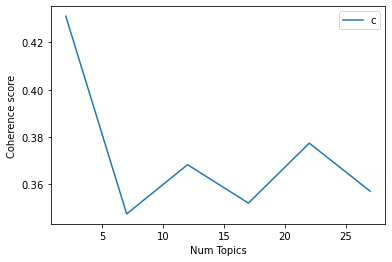

In [112]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [113]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.4311
index: 1 | Num Topics = 7  has Coherence Value of 0.3473
index: 2 | Num Topics = 12  has Coherence Value of 0.3682
index: 3 | Num Topics = 17  has Coherence Value of 0.3519
index: 4 | Num Topics = 22  has Coherence Value of 0.3773
index: 5 | Num Topics = 27  has Coherence Value of 0.357


In [184]:
# Select optimal number of topics
optimal_model_ph_score1N2N3 = model_list_ph_score1N2N3[0]

In [185]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score1N2N3, corpus_ph_score1N2N3, id2word_ph_score1N2N3)

In [186]:
print("pyLDAVis for ph topics for score=1,2,3:")
vis_ph_score1N2N3

pyLDAVis for ph topics for score=1,2,3:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.152463  0.0       1        1  58.054978
0     -0.152463  0.0       2        1  41.945022, topic_info=       Term        Freq       Total Category  logprob  loglift
7      view  485.000000  485.000000  Default  30.0000  30.0000
419  delete  311.000000  311.000000  Default  29.0000  29.0000
132      ad  203.000000  203.000000  Default  28.0000  28.0000
32      fix  250.000000  250.000000  Default  27.0000  27.0000
46     play  173.000000  173.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
115    keep   39.509603  101.106244   Topic2  -5.0109  -0.0708
56     time   39.251484  115.194417   Topic2  -5.0175  -0.2078
10      app   50.652366  244.579159   Topic2  -4.7625  -0.7057
16     hope   32.917845   71.194934   Topic2  -5.1934   0.0974
89    watch   30.765196  221.759871   Topic2  -5.2611  -1.1064

[126 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
132       1  0.998131        ad
132       2  0.004917        ad
172       1  0.757904    always
172       2  0.252635    always
9         1  0.993867  annoying
...     ...       ...       ...
142       2  0.028397  whenever
98        1  0.397717      work
98        2  0.603433      work
788       1  0.051812       yet
788       2  0.984436       yet

[134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [117]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_ph_2018_score1N2N3 = youtube_ios_ph_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_ph_2018_score1N2N3 = list(sent_to_words(review_ph_2018_score1N2N3))
print(review_words_ph_2018_score1N2N3[:1])

[['cant', 'download', 'videos', 'for', 'offline', 'viewing', 'anymore', 'is', 'it', 'not', 'available', 'anymore', 'don', 'think', 'there', 'was', 'an', 'update', 'removing', 'it']]


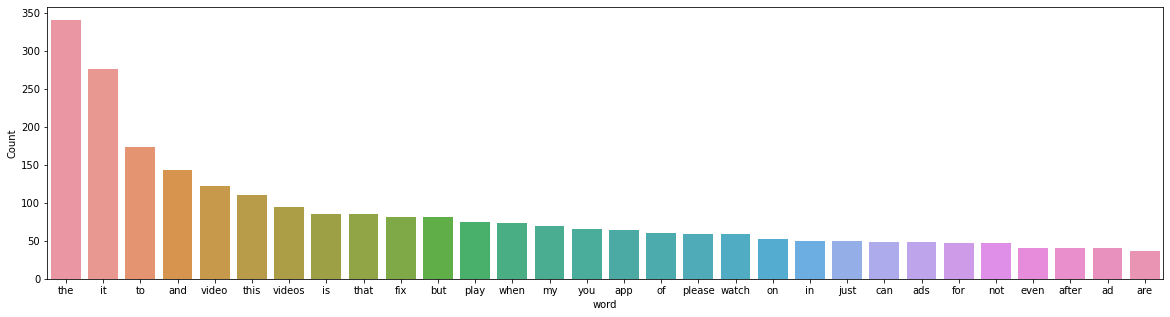

In [118]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2018_score1N2N3))

In [119]:
# Clean text
review_words_ph_ready_2018_score1N2N3 = process_words(review_words_ph_2018_score1N2N3)  # processed Text Data! - move to each section

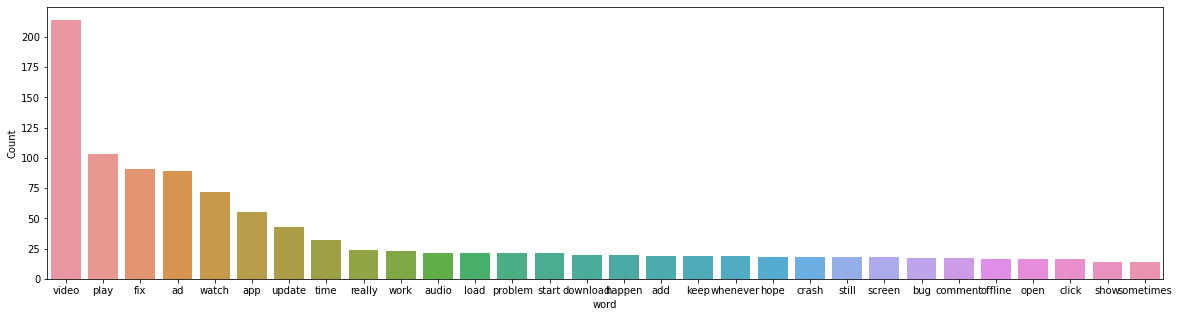

In [120]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2018_score1N2N3))


In [121]:
# Create Dictionary
id2word_ph_2018_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2018_score1N2N3)

2021-10-17 00:37:06,409 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:37:06,422 [INFO] gensim.corpora.dictionary - built Dictionary(667 unique tokens: ['anymore', 'available', 'download', 'offline', 'remove']...) from 188 documents (total 2562 corpus positions)
2021-10-17 00:37:06,427 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(667 unique tokens: ['anymore', 'available', 'download', 'offline', 'remove']...) from 188 documents (total 2562 corpus positions)", 'datetime': '2021-10-17T00:37:06.427811', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [122]:
# Create Corpus: Term Document Frequency
corpus_ph_2018_score1N2N3 = [id2word_ph_2018_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2018_score1N2N3]

In [123]:
# Training LDA model
model_list_ph_2018_score1N2N3, coherence_values_ph_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2018_score1N2N3, corpus=corpus_ph_2018_score1N2N3, 
                                                              texts=review_words_ph_ready_2018_score1N2N3, limit=30, start=2, step=5)


2021-10-17 00:37:06,458 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:37:06,461 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:37:06,465 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:37:06,468 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 188 documents, updating model once every 188 documents, evaluating perplexity every 188 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:37:07,270 [INFO] gensim.models.ldamodel - -7.109 per-word bound, 138.1 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:07,271 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #188/188
2021-10-17 00:37:07,887 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.038*"video" + 0.025*"play" + 0.024*"ad" + 0.019*"fix" + 0.019*"watch" + 0.016*"update" + 0.012*"downlo

2021-10-17 00:37:13,397 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.090*"video" + 0.047*"play" + 0.041*"ad" + 0.034*"fix" + 0.028*"watch" + 0.021*"app" + 0.012*"update" + 0.011*"really" + 0.010*"problem" + 0.010*"time"
2021-10-17 00:37:13,401 [INFO] gensim.models.ldamodel - topic diff=0.011285, rho=0.301511
2021-10-17 00:37:13,750 [INFO] gensim.models.ldamodel - -5.818 per-word bound, 56.4 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:13,756 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #188/188
2021-10-17 00:37:13,975 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"video" + 0.018*"download" + 0.017*"fix" + 0.017*"update" + 0.015*"comment" + 0.015*"offline" + 0.013*"work" + 0.012*"back" + 0.011*"watch" + 0.011*"new"
2021-10-17 00:37:13,978 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.090*"video" + 0.047*"play" + 0.041*"ad" + 0.034*"fix" + 0.029*"watch" + 0.021*"app" + 0.012*"update" + 0.011*"rea

2021-10-17 00:37:19,026 [INFO] gensim.models.ldamodel - topic diff=0.006752, rho=0.218218
2021-10-17 00:37:19,252 [INFO] gensim.models.ldamodel - -5.806 per-word bound, 56.0 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:19,253 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #188/188
2021-10-17 00:37:19,540 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"video" + 0.018*"fix" + 0.018*"download" + 0.017*"update" + 0.015*"comment" + 0.014*"offline" + 0.013*"work" + 0.013*"app" + 0.012*"back" + 0.012*"time"
2021-10-17 00:37:19,542 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.091*"video" + 0.049*"play" + 0.043*"ad" + 0.034*"fix" + 0.030*"watch" + 0.020*"app" + 0.012*"update" + 0.011*"really" + 0.010*"problem" + 0.010*"load"
2021-10-17 00:37:19,544 [INFO] gensim.models.ldamodel - topic diff=0.006179, rho=0.213201
2021-10-17 00:37:19,897 [INFO] gensim.models.ldamodel - -5.806 per-word bound, 55.9 perplexity estim

2021-10-17 00:37:24,721 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #188/188
2021-10-17 00:37:25,020 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"video" + 0.018*"fix" + 0.018*"update" + 0.018*"download" + 0.015*"comment" + 0.014*"offline" + 0.014*"app" + 0.014*"work" + 0.012*"time" + 0.012*"back"
2021-10-17 00:37:25,022 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.091*"video" + 0.049*"play" + 0.043*"ad" + 0.035*"fix" + 0.030*"watch" + 0.019*"app" + 0.011*"update" + 0.011*"really" + 0.010*"problem" + 0.010*"load"
2021-10-17 00:37:25,023 [INFO] gensim.models.ldamodel - topic diff=0.003140, rho=0.176777
2021-10-17 00:37:25,303 [INFO] gensim.models.ldamodel - -5.802 per-word bound, 55.8 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:25,305 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #188/188
2021-10-17 00:37:25,533 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"video" + 0.01

2021-10-17 00:37:30,304 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"video" + 0.018*"update" + 0.018*"fix" + 0.018*"download" + 0.015*"comment" + 0.015*"app" + 0.014*"offline" + 0.014*"work" + 0.012*"time" + 0.012*"back"
2021-10-17 00:37:30,307 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.091*"video" + 0.050*"play" + 0.043*"ad" + 0.035*"fix" + 0.031*"watch" + 0.019*"app" + 0.011*"update" + 0.010*"really" + 0.010*"problem" + 0.010*"load"
2021-10-17 00:37:30,308 [INFO] gensim.models.ldamodel - topic diff=0.001618, rho=0.154303
2021-10-17 00:37:30,643 [INFO] gensim.models.ldamodel - -5.801 per-word bound, 55.8 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:30,644 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #188/188
2021-10-17 00:37:30,833 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"video" + 0.018*"update" + 0.018*"fix" + 0.018*"download" + 0.015*"comment" + 0.015*"app" + 0.014*"offline" + 

2021-10-17 00:37:35,368 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:37:39,790 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:37:39,818 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 183 virtual documents
2021-10-17 00:37:40,067 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:37:40,068 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:37:40,071 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:37:40,075 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 188 documents, updating model once every 188 documents, evaluating perplexity every 188 documents, iterating 50x with a con

2021-10-17 00:37:43,001 [INFO] gensim.models.ldamodel - topic diff=0.050594, rho=0.408248
2021-10-17 00:37:43,347 [INFO] gensim.models.ldamodel - -6.100 per-word bound, 68.6 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:43,348 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #188/188
2021-10-17 00:37:43,543 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.056*"video" + 0.029*"ad" + 0.026*"play" + 0.019*"fix" + 0.018*"open" + 0.015*"long" + 0.011*"playlist" + 0.011*"work" + 0.011*"upload" + 0.011*"cast"
2021-10-17 00:37:43,546 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"fix" + 0.026*"update" + 0.024*"app" + 0.024*"comment" + 0.019*"video" + 0.015*"open" + 0.015*"issue" + 0.013*"playlist" + 0.013*"iphone" + 0.012*"close"
2021-10-17 00:37:43,558 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"video" + 0.027*"time" + 0.024*"upload" + 0.023*"app" + 0.019*"search" + 0.017*"fix" + 0.016*"work" + 0.015*"st

2021-10-17 00:37:45,957 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"video" + 0.023*"fix" + 0.017*"io" + 0.017*"update" + 0.016*"app" + 0.015*"play" + 0.013*"start" + 0.013*"bug" + 0.011*"watch" + 0.011*"screen"
2021-10-17 00:37:45,959 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"fix" + 0.025*"update" + 0.024*"app" + 0.023*"comment" + 0.020*"video" + 0.015*"open" + 0.015*"issue" + 0.015*"playlist" + 0.012*"iphone" + 0.012*"close"
2021-10-17 00:37:45,961 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"video" + 0.027*"time" + 0.025*"app" + 0.024*"upload" + 0.023*"search" + 0.017*"work" + 0.016*"fix" + 0.015*"still" + 0.014*"back" + 0.014*"option"
2021-10-17 00:37:45,964 [INFO] gensim.models.ldamodel - topic diff=0.012275, rho=0.288675
2021-10-17 00:37:46,273 [INFO] gensim.models.ldamodel - -6.079 per-word bound, 67.6 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:46,275 [INFO] gensim.models.ldamodel - PROG

2021-10-17 00:37:48,889 [INFO] gensim.models.ldamodel - -6.074 per-word bound, 67.4 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:48,891 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #188/188
2021-10-17 00:37:49,034 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.024*"video" + 0.023*"fix" + 0.017*"io" + 0.016*"app" + 0.016*"update" + 0.015*"play" + 0.014*"bug" + 0.014*"start" + 0.011*"watch" + 0.011*"screen"
2021-10-17 00:37:49,036 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"video" + 0.027*"app" + 0.027*"search" + 0.027*"time" + 0.023*"upload" + 0.018*"work" + 0.017*"fix" + 0.016*"show" + 0.015*"update" + 0.015*"version"
2021-10-17 00:37:49,039 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.113*"video" + 0.071*"play" + 0.058*"ad" + 0.041*"fix" + 0.036*"watch" + 0.016*"app" + 0.015*"update" + 0.012*"really" + 0.012*"annoying" + 0.011*"hope"
2021-10-17 00:37:49,041 [INFO] gensim.models.ldamodel - to

2021-10-17 00:37:51,435 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.113*"video" + 0.073*"play" + 0.059*"ad" + 0.041*"fix" + 0.036*"watch" + 0.016*"app" + 0.015*"update" + 0.012*"really" + 0.012*"annoying" + 0.011*"hope"
2021-10-17 00:37:51,437 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.023*"video" + 0.023*"fix" + 0.017*"io" + 0.016*"app" + 0.015*"update" + 0.015*"play" + 0.014*"bug" + 0.014*"start" + 0.011*"watch" + 0.011*"screen"
2021-10-17 00:37:51,439 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.058*"video" + 0.040*"ad" + 0.038*"watch" + 0.030*"fix" + 0.025*"download" + 0.020*"play" + 0.020*"app" + 0.019*"offline" + 0.014*"start" + 0.012*"anymore"
2021-10-17 00:37:51,440 [INFO] gensim.models.ldamodel - topic diff=0.004803, rho=0.208514
2021-10-17 00:37:51,679 [INFO] gensim.models.ldamodel - -6.068 per-word bound, 67.1 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:51,682 [INFO] gensim.models.ldamodel - PROGRES

2021-10-17 00:37:54,647 [INFO] gensim.models.ldamodel - -6.065 per-word bound, 66.9 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:54,648 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #188/188
2021-10-17 00:37:54,822 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"fix" + 0.025*"update" + 0.024*"app" + 0.024*"comment" + 0.019*"video" + 0.015*"open" + 0.015*"issue" + 0.015*"playlist" + 0.013*"iphone" + 0.012*"close"
2021-10-17 00:37:54,824 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.023*"fix" + 0.023*"video" + 0.017*"io" + 0.017*"app" + 0.015*"play" + 0.015*"update" + 0.014*"bug" + 0.014*"start" + 0.011*"watch" + 0.011*"screen"
2021-10-17 00:37:54,826 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.057*"video" + 0.038*"ad" + 0.038*"watch" + 0.029*"fix" + 0.025*"download" + 0.020*"offline" + 0.019*"app" + 0.017*"play" + 0.013*"start" + 0.013*"anymore"
2021-10-17 00:37:54,830 [INFO] gensim.models.ldamod

2021-10-17 00:37:58,061 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.060*"video" + 0.030*"watch" + 0.022*"button" + 0.019*"load" + 0.019*"bug" + 0.019*"happen" + 0.016*"whenever" + 0.016*"audio" + 0.016*"time" + 0.016*"download"
2021-10-17 00:37:58,064 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.053*"video" + 0.019*"open" + 0.016*"play" + 0.016*"long" + 0.013*"fix" + 0.012*"playlist" + 0.012*"cast" + 0.012*"minute" + 0.012*"min" + 0.012*"suddenly"
2021-10-17 00:37:58,066 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"fix" + 0.025*"update" + 0.024*"app" + 0.024*"comment" + 0.018*"video" + 0.015*"open" + 0.015*"issue" + 0.015*"playlist" + 0.013*"iphone" + 0.012*"close"
2021-10-17 00:37:58,071 [INFO] gensim.models.ldamodel - topic diff=0.002164, rho=0.171499
2021-10-17 00:37:58,398 [INFO] gensim.models.ldamodel - -6.063 per-word bound, 66.9 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:37:58,400 [INFO] gensim.models.

2021-10-17 00:38:00,417 [INFO] gensim.models.ldamodel - topic diff=0.001673, rho=0.160128
2021-10-17 00:38:00,674 [INFO] gensim.models.ldamodel - -6.062 per-word bound, 66.8 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:00,676 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #188/188
2021-10-17 00:38:00,892 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.023*"fix" + 0.023*"video" + 0.017*"io" + 0.016*"app" + 0.015*"play" + 0.015*"update" + 0.014*"bug" + 0.014*"start" + 0.011*"watch" + 0.011*"screen"
2021-10-17 00:38:00,893 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"fix" + 0.025*"update" + 0.024*"app" + 0.024*"comment" + 0.018*"video" + 0.015*"open" + 0.015*"issue" + 0.015*"playlist" + 0.013*"iphone" + 0.012*"close"
2021-10-17 00:38:00,895 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.112*"video" + 0.076*"play" + 0.061*"ad" + 0.042*"fix" + 0.036*"watch" + 0.015*"app" + 0.015*"update" + 0.013*"really

2021-10-17 00:38:03,053 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.040*"video" + 0.033*"app" + 0.028*"upload" + 0.027*"search" + 0.026*"time" + 0.020*"update" + 0.019*"show" + 0.018*"work" + 0.018*"fix" + 0.018*"crash"
2021-10-17 00:38:03,056 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.056*"video" + 0.038*"watch" + 0.036*"ad" + 0.028*"fix" + 0.026*"download" + 0.021*"offline" + 0.019*"app" + 0.015*"internet" + 0.015*"play" + 0.013*"anymore"
2021-10-17 00:38:03,057 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.059*"video" + 0.030*"watch" + 0.022*"button" + 0.019*"load" + 0.019*"bug" + 0.019*"happen" + 0.016*"audio" + 0.016*"download" + 0.016*"whenever" + 0.016*"time"
2021-10-17 00:38:03,059 [INFO] gensim.models.ldamodel - topic diff=0.001317, rho=0.149071
2021-10-17 00:38:03,362 [INFO] gensim.models.ldamodel - -6.061 per-word bound, 66.8 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:03,365 [INFO] gensim.models.lda

2021-10-17 00:38:05,174 [INFO] gensim.models.ldamodel - topic diff=0.001234, rho=0.141421
2021-10-17 00:38:05,417 [INFO] gensim.models.ldamodel - -6.060 per-word bound, 66.7 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:05,420 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #188/188
2021-10-17 00:38:05,620 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.059*"video" + 0.031*"watch" + 0.022*"button" + 0.019*"load" + 0.019*"bug" + 0.019*"happen" + 0.016*"audio" + 0.016*"download" + 0.016*"whenever" + 0.015*"time"
2021-10-17 00:38:05,624 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.040*"video" + 0.033*"app" + 0.029*"upload" + 0.027*"search" + 0.026*"time" + 0.020*"update" + 0.019*"show" + 0.019*"crash" + 0.018*"fix" + 0.018*"work"
2021-10-17 00:38:05,626 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.112*"video" + 0.076*"play" + 0.061*"ad" + 0.043*"fix" + 0.036*"watch" + 0.015*"app" + 0.015*"update" + 0.013*"

2021-10-17 00:38:14,058 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.084*"video" + 0.047*"load" + 0.027*"play" + 0.025*"fix" + 0.025*"watch" + 0.024*"error" + 0.024*"button" + 0.020*"bug" + 0.020*"click" + 0.019*"offline"
2021-10-17 00:38:14,060 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.041*"video" + 0.036*"fix" + 0.021*"update" + 0.016*"audio" + 0.016*"happen" + 0.016*"whenever" + 0.016*"watch" + 0.016*"comment" + 0.016*"bug" + 0.011*"version"
2021-10-17 00:38:14,062 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.036*"time" + 0.029*"loading" + 0.027*"work" + 0.024*"app" + 0.022*"video" + 0.020*"connection" + 0.018*"check" + 0.017*"option" + 0.017*"comment" + 0.017*"still"
2021-10-17 00:38:14,063 [INFO] gensim.models.ldamodel - topic diff=0.066332, rho=0.447214
2021-10-17 00:38:14,300 [INFO] gensim.models.ldamodel - -6.218 per-word bound, 74.5 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:14,303 [INFO] gensim.mode

2021-10-17 00:38:16,311 [INFO] gensim.models.ldamodel - topic diff=0.020930, rho=0.316228
2021-10-17 00:38:16,660 [INFO] gensim.models.ldamodel - -6.183 per-word bound, 72.7 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:16,662 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #188/188
2021-10-17 00:38:16,822 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.031*"app" + 0.028*"video" + 0.025*"download" + 0.019*"anymore" + 0.016*"remove" + 0.013*"time" + 0.013*"day" + 0.013*"back" + 0.013*"bring" + 0.013*"great"
2021-10-17 00:38:16,826 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.089*"video" + 0.045*"ad" + 0.037*"watch" + 0.031*"play" + 0.017*"download" + 0.015*"start" + 0.015*"offline" + 0.014*"fix" + 0.013*"audio" + 0.013*"vid"
2021-10-17 00:38:16,827 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.106*"video" + 0.048*"fix" + 0.044*"watch" + 0.028*"app" + 0.020*"ad" + 0.018*"add" + 0.018*"annoying" + 0.016*"st

2021-10-17 00:38:19,299 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.106*"video" + 0.048*"fix" + 0.044*"watch" + 0.028*"app" + 0.020*"ad" + 0.018*"add" + 0.018*"annoying" + 0.016*"star" + 0.015*"really" + 0.013*"give"
2021-10-17 00:38:19,300 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.040*"video" + 0.033*"fix" + 0.022*"update" + 0.016*"audio" + 0.016*"happen" + 0.016*"whenever" + 0.016*"watch" + 0.016*"comment" + 0.014*"bug" + 0.011*"version"
2021-10-17 00:38:19,303 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.055*"video" + 0.021*"play" + 0.021*"playlist" + 0.021*"cast" + 0.021*"problem" + 0.014*"suddenly" + 0.014*"screen" + 0.014*"watch" + 0.014*"revert" + 0.014*"shuffle"
2021-10-17 00:38:19,305 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"app" + 0.027*"video" + 0.025*"download" + 0.019*"anymore" + 0.016*"remove" + 0.013*"time" + 0.013*"day" + 0.013*"bring" + 0.013*"back" + 0.013*"great"
2021-10-17 00:38:19,308 [INFO] gensim.models.ldamodel - topic di

2021-10-17 00:38:21,542 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.039*"comment" + 0.034*"fix" + 0.031*"iphone" + 0.020*"update" + 0.020*"mode" + 0.014*"crash" + 0.014*"stick" + 0.014*"show" + 0.014*"keep" + 0.014*"issue"
2021-10-17 00:38:21,543 [INFO] gensim.models.ldamodel - topic diff=0.005139, rho=0.218218
2021-10-17 00:38:21,826 [INFO] gensim.models.ldamodel - -6.162 per-word bound, 71.6 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:21,828 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #188/188
2021-10-17 00:38:21,953 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.040*"video" + 0.031*"fix" + 0.022*"update" + 0.017*"audio" + 0.017*"happen" + 0.017*"whenever" + 0.017*"watch" + 0.017*"comment" + 0.013*"bug" + 0.011*"version"
2021-10-17 00:38:21,955 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.088*"video" + 0.043*"ad" + 0.037*"watch" + 0.030*"play" + 0.017*"download" + 0.015*"start" + 0.015*"offli

2021-10-17 00:38:24,169 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.088*"video" + 0.042*"ad" + 0.036*"watch" + 0.029*"play" + 0.017*"download" + 0.015*"start" + 0.015*"offline" + 0.014*"fix" + 0.013*"audio" + 0.013*"vid"
2021-10-17 00:38:24,171 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.029*"app" + 0.027*"video" + 0.025*"download" + 0.025*"anymore" + 0.016*"remove" + 0.013*"time" + 0.013*"day" + 0.013*"back" + 0.013*"bring" + 0.013*"show"
2021-10-17 00:38:24,177 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.055*"video" + 0.021*"play" + 0.021*"playlist" + 0.021*"cast" + 0.021*"problem" + 0.014*"suddenly" + 0.014*"screen" + 0.014*"watch" + 0.014*"revert" + 0.014*"demonetize"
2021-10-17 00:38:24,180 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.040*"comment" + 0.034*"fix" + 0.031*"iphone" + 0.020*"update" + 0.020*"mode" + 0.014*"crash" + 0.014*"stick" + 0.014*"show" + 0.014*"issue" + 0.014*"click"
2021-10-17 00:38:24,182 [INFO] gensim.models.ldamodel - topic 

2021-10-17 00:38:26,609 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.106*"video" + 0.048*"fix" + 0.044*"watch" + 0.028*"app" + 0.020*"ad" + 0.018*"add" + 0.018*"annoying" + 0.016*"star" + 0.015*"really" + 0.013*"give"
2021-10-17 00:38:26,611 [INFO] gensim.models.ldamodel - topic diff=0.002198, rho=0.176777
2021-10-17 00:38:26,827 [INFO] gensim.models.ldamodel - -6.153 per-word bound, 71.2 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:26,829 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #188/188
2021-10-17 00:38:27,029 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.029*"app" + 0.027*"video" + 0.025*"download" + 0.025*"anymore" + 0.016*"remove" + 0.013*"time" + 0.013*"day" + 0.013*"bring" + 0.013*"back" + 0.013*"show"
2021-10-17 00:38:27,030 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.055*"video" + 0.021*"play" + 0.021*"playlist" + 0.021*"cast" + 0.021*"problem" + 0.014*"suddenly" + 0.014*"screen" + 0

2021-10-17 00:38:29,294 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.106*"video" + 0.048*"fix" + 0.044*"watch" + 0.029*"app" + 0.020*"ad" + 0.018*"add" + 0.018*"annoying" + 0.016*"star" + 0.015*"really" + 0.013*"give"
2021-10-17 00:38:29,295 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.040*"comment" + 0.033*"fix" + 0.031*"iphone" + 0.020*"update" + 0.020*"mode" + 0.014*"crash" + 0.014*"stick" + 0.014*"show" + 0.014*"issue" + 0.014*"click"
2021-10-17 00:38:29,297 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.029*"app" + 0.027*"video" + 0.025*"download" + 0.025*"anymore" + 0.016*"remove" + 0.013*"time" + 0.013*"view" + 0.013*"day" + 0.013*"bring" + 0.013*"back"
2021-10-17 00:38:29,299 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"time" + 0.034*"loading" + 0.033*"work" + 0.028*"app" + 0.025*"connection" + 0.020*"check" + 0.020*"option" + 0.019*"comment" + 0.019*"still" + 0.017*"really"
2021-10-17 00:38:29,300 [INFO] gensim.models.ldamodel - topic diff=0.0014

2021-10-17 00:38:31,662 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.051*"app" + 0.041*"fix" + 0.040*"video" + 0.029*"update" + 0.027*"crash" + 0.026*"work" + 0.023*"still" + 0.018*"time" + 0.015*"sound" + 0.015*"bug"
2021-10-17 00:38:31,663 [INFO] gensim.models.ldamodel - topic diff=0.000935, rho=0.152499
2021-10-17 00:38:31,929 [INFO] gensim.models.ldamodel - -6.151 per-word bound, 71.1 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:31,931 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #188/188
2021-10-17 00:38:32,155 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.103*"video" + 0.101*"play" + 0.078*"ad" + 0.043*"fix" + 0.026*"watch" + 0.022*"update" + 0.014*"black" + 0.013*"app" + 0.013*"freeze" + 0.013*"keep"
2021-10-17 00:38:32,157 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.040*"comment" + 0.033*"fix" + 0.031*"iphone" + 0.020*"update" + 0.020*"mode" + 0.014*"crash" + 0.014*"stick" + 0.014*"show"

2021-10-17 00:38:34,422 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.051*"app" + 0.041*"fix" + 0.040*"video" + 0.029*"update" + 0.027*"crash" + 0.026*"work" + 0.023*"still" + 0.018*"time" + 0.015*"sound" + 0.015*"bug"
2021-10-17 00:38:34,424 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.029*"app" + 0.027*"video" + 0.025*"download" + 0.025*"anymore" + 0.016*"remove" + 0.013*"view" + 0.013*"time" + 0.013*"day" + 0.013*"today" + 0.013*"bring"
2021-10-17 00:38:34,426 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.059*"crash" + 0.041*"app" + 0.039*"upload" + 0.024*"video" + 0.021*"fix" + 0.018*"long" + 0.018*"minute" + 0.014*"issue" + 0.013*"update" + 0.011*"play"
2021-10-17 00:38:34,428 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.105*"video" + 0.048*"fix" + 0.044*"watch" + 0.029*"app" + 0.020*"ad" + 0.018*"add" + 0.018*"annoying" + 0.016*"star" + 0.015*"really" + 0.013*"give"
2021-10-17 00:38:34,429 [INFO] gensim.models.ldamodel - topic diff=0.000536, rho=0.14285

2021-10-17 00:38:43,762 [INFO] gensim.models.ldamodel - topic diff=0.122198, rho=0.577350
2021-10-17 00:38:43,956 [INFO] gensim.models.ldamodel - -6.425 per-word bound, 85.9 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:43,958 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #188/188
2021-10-17 00:38:44,183 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.076*"video" + 0.030*"play" + 0.028*"fix" + 0.023*"app" + 0.019*"really" + 0.019*"internet" + 0.018*"watch" + 0.018*"save" + 0.017*"today" + 0.017*"button"
2021-10-17 00:38:44,188 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.081*"video" + 0.041*"play" + 0.034*"watch" + 0.023*"ad" + 0.020*"fix" + 0.016*"audio" + 0.015*"download" + 0.012*"vid" + 0.012*"back" + 0.011*"app"
2021-10-17 00:38:44,191 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.047*"comment" + 0.027*"open" + 0.026*"new" + 0.020*"issue" + 0.020*"already" + 0.013*"video" + 0.010*"notification" + 

2021-10-17 00:38:46,660 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.104*"video" + 0.043*"watch" + 0.040*"fix" + 0.028*"add" + 0.027*"play" + 0.016*"app" + 0.016*"really" + 0.016*"time" + 0.015*"hope" + 0.015*"annoying"
2021-10-17 00:38:46,662 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.063*"video" + 0.036*"download" + 0.036*"anymore" + 0.034*"work" + 0.027*"offline" + 0.027*"cast" + 0.018*"watch" + 0.018*"library" + 0.018*"pay" + 0.018*"screen"
2021-10-17 00:38:46,664 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.035*"video" + 0.029*"app" + 0.029*"watch" + 0.029*"screen" + 0.022*"open" + 0.021*"page" + 0.018*"fine" + 0.017*"back" + 0.015*"problem" + 0.015*"start"
2021-10-17 00:38:46,665 [INFO] gensim.models.ldamodel - topic diff=0.027687, rho=0.333333
2021-10-17 00:38:46,868 [INFO] gensim.models.ldamodel - -6.326 per-word bound, 80.2 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:46,871 [INFO] gensim.models.ldamod

2021-10-17 00:38:48,957 [INFO] gensim.models.ldamodel - topic diff=0.009930, rho=0.267261
2021-10-17 00:38:49,292 [INFO] gensim.models.ldamodel - -6.312 per-word bound, 79.5 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:49,293 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #188/188
2021-10-17 00:38:49,429 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.039*"comment" + 0.023*"fix" + 0.023*"update" + 0.016*"discard" + 0.016*"memory" + 0.016*"crash" + 0.016*"section" + 0.016*"stick" + 0.016*"click" + 0.016*"iphone"
2021-10-17 00:38:49,431 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.062*"video" + 0.043*"loading" + 0.036*"fix" + 0.023*"problem" + 0.018*"watch" + 0.018*"business" + 0.018*"pop" + 0.018*"long" + 0.018*"star" + 0.018*"upload"
2021-10-17 00:38:49,432 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.104*"video" + 0.044*"watch" + 0.040*"fix" + 0.028*"add" + 0.026*"play" + 0.016*"app" + 0.016*"time" 

2021-10-17 00:38:51,737 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.056*"upload" + 0.045*"app" + 0.039*"video" + 0.038*"time" + 0.028*"check" + 0.028*"option" + 0.023*"crash" + 0.022*"channel" + 0.022*"iphone" + 0.017*"happen"
2021-10-17 00:38:51,740 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.046*"video" + 0.031*"keep" + 0.028*"ad" + 0.027*"full" + 0.018*"watch" + 0.018*"app" + 0.018*"playlist" + 0.018*"revert" + 0.018*"suddenly" + 0.018*"fix"
2021-10-17 00:38:51,742 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.062*"video" + 0.043*"loading" + 0.036*"fix" + 0.022*"problem" + 0.018*"watch" + 0.018*"business" + 0.018*"pop" + 0.018*"long" + 0.018*"star" + 0.018*"upload"
2021-10-17 00:38:51,748 [INFO] gensim.models.ldamodel - topic diff=0.004931, rho=0.223607
2021-10-17 00:38:52,023 [INFO] gensim.models.ldamodel - -6.307 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:52,025 [INFO] gensim.models.l

2021-10-17 00:38:54,052 [INFO] gensim.models.ldamodel - topic diff=0.005054, rho=0.200000
2021-10-17 00:38:54,299 [INFO] gensim.models.ldamodel - -6.303 per-word bound, 78.9 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:54,300 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #188/188
2021-10-17 00:38:54,463 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.052*"comment" + 0.031*"open" + 0.023*"new" + 0.021*"already" + 0.021*"issue" + 0.011*"video" + 0.011*"always" + 0.011*"work" + 0.011*"write" + 0.011*"uninstall"
2021-10-17 00:38:54,465 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.078*"video" + 0.045*"play" + 0.025*"watch" + 0.018*"audio" + 0.017*"fix" + 0.017*"download" + 0.013*"vid" + 0.012*"back" + 0.011*"app" + 0.010*"history"
2021-10-17 00:38:54,467 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.056*"fix" + 0.037*"show" + 0.028*"crash" + 0.028*"comment" + 0.023*"update" + 0.021*"video" + 0.019*"keep" 

2021-10-17 00:38:56,555 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.045*"error" + 0.023*"bug" + 0.023*"everytime" + 0.023*"search" + 0.023*"display" + 0.023*"load" + 0.001*"movie" + 0.001*"hollywood" + 0.001*"love" + 0.001*"watch"
2021-10-17 00:38:56,558 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.059*"app" + 0.056*"upload" + 0.051*"crash" + 0.041*"video" + 0.038*"time" + 0.026*"check" + 0.026*"option" + 0.021*"channel" + 0.020*"iphone" + 0.018*"fix"
2021-10-17 00:38:56,563 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.061*"video" + 0.037*"download" + 0.037*"anymore" + 0.036*"work" + 0.028*"offline" + 0.028*"cast" + 0.019*"watch" + 0.019*"library" + 0.019*"pay" + 0.019*"screen"
2021-10-17 00:38:56,565 [INFO] gensim.models.ldamodel - topic diff=0.003387, rho=0.179605
2021-10-17 00:38:56,866 [INFO] gensim.models.ldamodel - -6.294 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:56,868 [INFO] gens

2021-10-17 00:38:58,815 [INFO] gensim.models.ldamodel - topic diff=0.002956, rho=0.166667
2021-10-17 00:38:59,058 [INFO] gensim.models.ldamodel - -6.289 per-word bound, 78.2 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:38:59,060 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #188/188
2021-10-17 00:38:59,265 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.078*"video" + 0.042*"offline" + 0.033*"watch" + 0.033*"download" + 0.033*"fix" + 0.025*"load" + 0.025*"bug" + 0.023*"click" + 0.022*"whenever" + 0.017*"library"
2021-10-17 00:38:59,268 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.045*"error" + 0.023*"bug" + 0.023*"everytime" + 0.023*"search" + 0.023*"display" + 0.023*"load" + 0.001*"movie" + 0.001*"hollywood" + 0.001*"love" + 0.001*"watch"
2021-10-17 00:38:59,272 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.077*"video" + 0.045*"play" + 0.022*"watch" + 0.019*"audio" + 0.017*"download" + 0.017*"fix" + 0.

2021-10-17 00:39:01,619 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.055*"fix" + 0.037*"show" + 0.028*"crash" + 0.028*"comment" + 0.023*"update" + 0.021*"video" + 0.019*"turn" + 0.019*"iphone" + 0.019*"already" + 0.019*"change"
2021-10-17 00:39:01,635 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.034*"movie" + 0.025*"watch" + 0.023*"listen" + 0.023*"especially" + 0.023*"playlist" + 0.023*"love" + 0.023*"hollywood" + 0.018*"minimize" + 0.013*"video" + 0.012*"app"
2021-10-17 00:39:01,639 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.039*"comment" + 0.024*"update" + 0.022*"fix" + 0.016*"section" + 0.016*"discard" + 0.016*"stick" + 0.016*"memory" + 0.016*"click" + 0.016*"iphone" + 0.016*"issue"
2021-10-17 00:39:01,644 [INFO] gensim.models.ldamodel - topic diff=0.003033, rho=0.154303
2021-10-17 00:39:01,838 [INFO] gensim.models.ldamodel - -6.281 per-word bound, 77.8 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:39:01,839 [I

2021-10-17 00:39:03,881 [INFO] gensim.models.ldamodel - topic diff=0.002449, rho=0.145865
2021-10-17 00:39:04,070 [INFO] gensim.models.ldamodel - -6.276 per-word bound, 77.5 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:39:04,073 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #188/188
2021-10-17 00:39:04,250 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.077*"video" + 0.045*"play" + 0.019*"audio" + 0.019*"watch" + 0.017*"download" + 0.017*"fix" + 0.013*"vid" + 0.012*"back" + 0.011*"search" + 0.011*"history"
2021-10-17 00:39:04,253 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.062*"video" + 0.043*"loading" + 0.036*"fix" + 0.022*"problem" + 0.018*"watch" + 0.017*"pop" + 0.017*"business" + 0.017*"give" + 0.017*"star" + 0.017*"long"
2021-10-17 00:39:04,257 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.058*"video" + 0.038*"anymore" + 0.038*"download" + 0.037*"work" + 0.029*"offline" + 0.029*"cast" + 0.019*"l

2021-10-17 00:39:15,935 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.032*"vid" + 0.032*"download" + 0.032*"connection" + 0.032*"app" + 0.021*"access" + 0.021*"expire" + 0.021*"play" + 0.021*"start" + 0.021*"online" + 0.021*"reply"
2021-10-17 00:39:15,937 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.042*"fix" + 0.030*"play" + 0.027*"name" + 0.027*"chat" + 0.027*"still" + 0.027*"keep" + 0.018*"ad" + 0.016*"vid" + 0.014*"itttttt" + 0.014*"stick"
2021-10-17 00:39:15,941 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.058*"watch" + 0.056*"video" + 0.028*"history" + 0.020*"comment" + 0.015*"ad" + 0.014*"pop" + 0.014*"audio" + 0.014*"change" + 0.014*"post" + 0.014*"reload"
2021-10-17 00:39:15,942 [INFO] gensim.models.ldamodel - topic diff=17.864159, rho=1.000000
2021-10-17 00:39:16,241 [INFO] gensim.models.ldamodel - -6.592 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:39:16,242 [INFO] gensim.models.ldamod

2021-10-17 00:39:18,992 [INFO] gensim.models.ldamodel - topic diff=0.054673, rho=0.377964
2021-10-17 00:39:19,418 [INFO] gensim.models.ldamodel - -6.391 per-word bound, 83.9 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:39:19,420 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #188/188
2021-10-17 00:39:19,613 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.071*"video" + 0.048*"time" + 0.038*"search" + 0.034*"fix" + 0.034*"channel" + 0.033*"update" + 0.021*"upload" + 0.021*"check" + 0.021*"still" + 0.021*"option"
2021-10-17 00:39:19,616 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.075*"video" + 0.055*"upload" + 0.051*"problem" + 0.037*"app" + 0.031*"black" + 0.025*"play" + 0.023*"mode" + 0.023*"update" + 0.023*"close" + 0.012*"issue"
2021-10-17 00:39:19,618 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.050*"comment" + 0.038*"open" + 0.032*"update" + 0.032*"fix" + 0.025*"discard" + 0.025*"memory" + 0.025*"sti

2021-10-17 00:39:22,295 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.042*"fix" + 0.028*"play" + 0.028*"name" + 0.028*"still" + 0.028*"chat" + 0.028*"keep" + 0.014*"ad" + 0.014*"vid" + 0.014*"ahhh" + 0.014*"processing"
2021-10-17 00:39:22,297 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.048*"app" + 0.048*"video" + 0.029*"update" + 0.029*"fix" + 0.024*"work" + 0.017*"version" + 0.016*"bug" + 0.015*"play" + 0.014*"io" + 0.014*"view"
2021-10-17 00:39:22,299 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.112*"video" + 0.086*"play" + 0.063*"fix" + 0.063*"load" + 0.036*"watch" + 0.033*"add" + 0.028*"internet" + 0.028*"freeze" + 0.026*"happen" + 0.021*"everytime"
2021-10-17 00:39:22,300 [INFO] gensim.models.ldamodel - topic diff=0.015783, rho=0.277350
2021-10-17 00:39:22,596 [INFO] gensim.models.ldamodel - -6.358 per-word bound, 82.0 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:39:22,602 [INFO] gensim.models.ldamodel - PROG

2021-10-17 00:39:24,871 [INFO] gensim.models.ldamodel - topic diff=0.007131, rho=0.235702
2021-10-17 00:39:25,151 [INFO] gensim.models.ldamodel - -6.347 per-word bound, 81.4 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:39:25,234 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #188/188
2021-10-17 00:39:25,403 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.062*"video" + 0.035*"download" + 0.023*"offline" + 0.023*"work" + 0.023*"problem" + 0.021*"watch" + 0.018*"anymore" + 0.018*"cast" + 0.013*"update" + 0.012*"view"
2021-10-17 00:39:25,427 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.038*"fix" + 0.034*"crash" + 0.034*"app" + 0.030*"annoying" + 0.029*"update" + 0.024*"play" + 0.023*"pause" + 0.023*"menu" + 0.023*"recent" + 0.018*"keep"
2021-10-17 00:39:25,429 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.039*"screen" + 0.032*"watch" + 0.029*"ad" + 0.021*"play" + 0.020*"overlay" + 0.020*"show" + 0.020*"scre

2021-10-17 00:39:28,046 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.038*"fix" + 0.034*"crash" + 0.034*"app" + 0.030*"annoying" + 0.029*"update" + 0.024*"play" + 0.023*"pause" + 0.023*"menu" + 0.023*"recent" + 0.017*"keep"
2021-10-17 00:39:28,052 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.097*"ad" + 0.087*"video" + 0.067*"fix" + 0.047*"click" + 0.044*"play" + 0.033*"everytime" + 0.028*"black" + 0.025*"time" + 0.024*"crash" + 0.020*"app"
2021-10-17 00:39:28,053 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.063*"video" + 0.035*"download" + 0.023*"offline" + 0.023*"work" + 0.023*"problem" + 0.021*"watch" + 0.018*"anymore" + 0.018*"cast" + 0.013*"update" + 0.012*"view"
2021-10-17 00:39:28,055 [INFO] gensim.models.ldamodel - topic diff=0.002957, rho=0.204124
2021-10-17 00:39:28,410 [INFO] gensim.models.ldamodel - -6.341 per-word bound, 81.0 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:39:28,411 [INFO] gensim.models.ldam

2021-10-17 00:39:30,679 [INFO] gensim.models.ldamodel - topic diff=0.001767, rho=0.185695
2021-10-17 00:39:30,923 [INFO] gensim.models.ldamodel - -6.338 per-word bound, 80.9 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:39:30,925 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #188/188
2021-10-17 00:39:31,166 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.065*"video" + 0.064*"watch" + 0.030*"history" + 0.023*"comment" + 0.017*"fix" + 0.015*"change" + 0.015*"reload" + 0.015*"vid" + 0.015*"pop" + 0.015*"audio"
2021-10-17 00:39:31,168 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.063*"video" + 0.035*"download" + 0.023*"offline" + 0.023*"work" + 0.023*"problem" + 0.021*"watch" + 0.018*"anymore" + 0.018*"cast" + 0.013*"update" + 0.012*"view"
2021-10-17 00:39:31,169 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.081*"video" + 0.024*"back" + 0.024*"playlist" + 0.024*"skip" + 0.020*"bring" + 0.020*"button" + 0.020

2021-10-17 00:39:33,843 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.039*"fix" + 0.034*"crash" + 0.034*"app" + 0.031*"annoying" + 0.029*"update" + 0.024*"play" + 0.023*"pause" + 0.023*"menu" + 0.023*"recent" + 0.017*"keep"
2021-10-17 00:39:33,850 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.044*"vid" + 0.033*"download" + 0.033*"connection" + 0.033*"app" + 0.033*"reply" + 0.033*"online" + 0.022*"expire" + 0.022*"internet" + 0.022*"access" + 0.022*"start"
2021-10-17 00:39:33,871 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.001*"multiple" + 0.001*"put" + 0.001*"nvm" + 0.001*"pay" + 0.001*"went" + 0.001*"duplicate" + 0.001*"entire" + 0.001*"extremely" + 0.001*"frustrated" + 0.001*"place"
2021-10-17 00:39:33,876 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.096*"ad" + 0.087*"video" + 0.068*"fix" + 0.049*"click" + 0.044*"play" + 0.032*"everytime" + 0.028*"black" + 0.024*"time" + 0.024*"crash" + 0.020*"app"
2021-10-17 00:39:33,878 [INFO] gensim.models.ldamodel - to

2021-10-17 00:39:36,671 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.087*"video" + 0.042*"load" + 0.035*"button" + 0.031*"watch" + 0.030*"click" + 0.028*"happen" + 0.027*"offline" + 0.022*"whenever" + 0.021*"library" + 0.019*"always"
2021-10-17 00:39:36,672 [INFO] gensim.models.ldamodel - topic diff=0.000925, rho=0.158114
2021-10-17 00:39:36,854 [INFO] gensim.models.ldamodel - -6.336 per-word bound, 80.8 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:39:36,856 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #188/188
2021-10-17 00:39:37,105 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.039*"screen" + 0.032*"watch" + 0.029*"ad" + 0.021*"play" + 0.020*"overlay" + 0.020*"show" + 0.020*"screenshot" + 0.020*"mode" + 0.020*"shift" + 0.020*"start"
2021-10-17 00:39:37,108 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.039*"fix" + 0.034*"crash" + 0.034*"app" + 0.031*"annoying" + 0.029*"update" + 0.024*"play" + 0.023

2021-10-17 00:39:40,282 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.080*"video" + 0.025*"back" + 0.025*"playlist" + 0.025*"skip" + 0.021*"bring" + 0.021*"button" + 0.021*"show" + 0.017*"app" + 0.014*"play" + 0.012*"put"
2021-10-17 00:39:40,288 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.063*"video" + 0.035*"download" + 0.023*"offline" + 0.023*"work" + 0.023*"problem" + 0.021*"watch" + 0.018*"cast" + 0.018*"anymore" + 0.013*"update" + 0.012*"view"
2021-10-17 00:39:40,290 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.070*"loading" + 0.069*"fix" + 0.035*"download" + 0.035*"error" + 0.032*"video" + 0.024*"comment" + 0.024*"work" + 0.024*"offline" + 0.022*"always" + 0.012*"already"
2021-10-17 00:39:40,295 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.096*"ad" + 0.087*"video" + 0.068*"fix" + 0.053*"click" + 0.044*"play" + 0.032*"everytime" + 0.028*"black" + 0.024*"time" + 0.024*"crash" + 0.020*"app"
2021-10-17 00:39:40,297 [INFO] gensim.models.ldamodel - topic 

2021-10-17 00:39:43,303 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.044*"vid" + 0.033*"download" + 0.033*"connection" + 0.033*"app" + 0.033*"reply" + 0.033*"online" + 0.022*"expire" + 0.022*"internet" + 0.022*"start" + 0.022*"access"
2021-10-17 00:39:43,307 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.039*"fix" + 0.034*"crash" + 0.034*"app" + 0.031*"annoying" + 0.029*"update" + 0.024*"play" + 0.023*"menu" + 0.023*"pause" + 0.023*"recent" + 0.017*"keep"
2021-10-17 00:39:43,310 [INFO] gensim.models.ldamodel - topic diff=0.000772, rho=0.140028
2021-10-17 00:39:43,313 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=667, num_topics=22, decay=0.5, chunksize=1000) in 28.28s', 'datetime': '2021-10-17T00:39:43.312792', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-17 00:39:43,325 [INFO] gensim.topic_coherence.probability_estimation

2021-10-17 00:39:58,555 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #188/188
2021-10-17 00:39:58,790 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.040*"fix" + 0.037*"app" + 0.036*"watch" + 0.031*"work" + 0.031*"history" + 0.031*"still" + 0.026*"video" + 0.025*"play" + 0.024*"crash" + 0.024*"vid"
2021-10-17 00:39:58,792 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.081*"video" + 0.024*"watch" + 0.022*"problem" + 0.022*"cast" + 0.019*"screen" + 0.017*"update" + 0.014*"hard" + 0.014*"playlist" + 0.014*"later" + 0.014*"suddenly"
2021-10-17 00:39:58,794 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.068*"video" + 0.056*"play" + 0.037*"fix" + 0.032*"audio" + 0.028*"time" + 0.025*"ad" + 0.021*"watch" + 0.020*"open" + 0.020*"update" + 0.016*"hope"
2021-10-17 00:39:58,796 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.064*"search" + 0.057*"video" + 0.043*"movie" + 0.029*"hollywood" + 0.029*"watch" + 0.028*"love" + 0.027*"fix" + 0.015*"play" + 0.015*"s

2021-10-17 00:40:01,670 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.047*"loading" + 0.044*"check" + 0.043*"internet" + 0.040*"time" + 0.032*"work" + 0.030*"app" + 0.027*"connection" + 0.026*"video" + 0.024*"channel" + 0.024*"instal"
2021-10-17 00:40:01,674 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.081*"video" + 0.023*"watch" + 0.022*"problem" + 0.022*"cast" + 0.018*"screen" + 0.016*"update" + 0.015*"hard" + 0.015*"suddenly" + 0.015*"playlist" + 0.015*"later"
2021-10-17 00:40:01,675 [INFO] gensim.models.ldamodel - topic diff=0.027227, rho=0.301511
2021-10-17 00:40:01,981 [INFO] gensim.models.ldamodel - -6.467 per-word bound, 88.4 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:40:01,988 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #188/188
2021-10-17 00:40:02,200 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.077*"video" + 0.039*"app" + 0.038*"problem" + 0.036*"play" + 0.030*"load" + 0.020*"update" 

2021-10-17 00:40:04,912 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #188/188
2021-10-17 00:40:05,171 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.058*"app" + 0.047*"fix" + 0.035*"work" + 0.029*"update" + 0.029*"version" + 0.023*"start" + 0.023*"io" + 0.023*"time" + 0.023*"fine" + 0.020*"video"
2021-10-17 00:40:05,174 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.081*"video" + 0.023*"watch" + 0.022*"cast" + 0.022*"problem" + 0.018*"screen" + 0.016*"update" + 0.015*"suddenly" + 0.015*"revert" + 0.015*"playlist" + 0.015*"later"
2021-10-17 00:40:05,177 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.039*"fix" + 0.038*"watch" + 0.037*"app" + 0.037*"work" + 0.032*"history" + 0.031*"still" + 0.026*"video" + 0.026*"play" + 0.026*"click" + 0.024*"vid"
2021-10-17 00:40:05,180 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.042*"update" + 0.042*"app" + 0.042*"fix" + 0.021*"check" + 0.021*"clearly" + 0.021*"crash" + 0.021*"stay" + 0.021*"time" + 0.021*"se

2021-10-17 00:40:08,184 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.213*"upload" + 0.177*"crash" + 0.045*"issue" + 0.037*"long" + 0.037*"minute" + 0.034*"fix" + 0.001*"keep" + 0.001*"video" + 0.001*"play" + 0.001*"multiple"
2021-10-17 00:40:08,186 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.048*"loading" + 0.047*"internet" + 0.046*"check" + 0.040*"time" + 0.032*"work" + 0.031*"connection" + 0.030*"app" + 0.026*"video" + 0.024*"channel" + 0.024*"instal"
2021-10-17 00:40:08,187 [INFO] gensim.models.ldamodel - topic diff=0.007354, rho=0.213201
2021-10-17 00:40:08,507 [INFO] gensim.models.ldamodel - -6.432 per-word bound, 86.4 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:40:08,508 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #188/188
2021-10-17 00:40:08,686 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.055*"comment" + 0.028*"whenever" + 0.028*"uninstall" + 0.028*"error" + 0.028*"occur" + 0.028*"always

2021-10-17 00:40:11,170 [INFO] gensim.models.ldamodel - -6.421 per-word bound, 85.7 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:40:11,171 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #188/188
2021-10-17 00:40:11,305 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.048*"loading" + 0.048*"internet" + 0.046*"check" + 0.040*"time" + 0.032*"work" + 0.031*"connection" + 0.030*"app" + 0.026*"video" + 0.024*"channel" + 0.024*"instal"
2021-10-17 00:40:11,307 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.045*"work" + 0.040*"fix" + 0.038*"watch" + 0.036*"app" + 0.030*"history" + 0.030*"still" + 0.029*"click" + 0.027*"video" + 0.026*"play" + 0.023*"vid"
2021-10-17 00:40:11,308 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.044*"video" + 0.042*"voice" + 0.035*"sometimes" + 0.029*"play" + 0.028*"really" + 0.028*"shuffle" + 0.028*"demonetize" + 0.028*"reason" + 0.014*"deep" + 0.014*"high"
2021-10-17 00:40:11,310 [INFO]

2021-10-17 00:40:13,592 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.043*"video" + 0.042*"voice" + 0.035*"sometimes" + 0.029*"play" + 0.028*"really" + 0.028*"shuffle" + 0.028*"demonetize" + 0.028*"reason" + 0.014*"deep" + 0.014*"high"
2021-10-17 00:40:13,595 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.098*"video" + 0.074*"load" + 0.047*"app" + 0.041*"fix" + 0.040*"watch" + 0.032*"everytime" + 0.021*"listen" + 0.021*"chat" + 0.021*"sec" + 0.021*"hope"
2021-10-17 00:40:13,599 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.057*"video" + 0.052*"bring" + 0.050*"back" + 0.048*"playlist" + 0.031*"screen" + 0.031*"option" + 0.030*"put" + 0.030*"time" + 0.021*"watch" + 0.021*"overlay"
2021-10-17 00:40:13,601 [INFO] gensim.models.ldamodel - topic diff=0.003789, rho=0.174078
2021-10-17 00:40:13,921 [INFO] gensim.models.ldamodel - -6.413 per-word bound, 85.2 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:40:13,922 [INFO] gensim.m

2021-10-17 00:40:15,919 [INFO] gensim.models.ldamodel - topic diff=0.002909, rho=0.162221
2021-10-17 00:40:16,137 [INFO] gensim.models.ldamodel - -6.409 per-word bound, 85.0 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:40:16,139 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #188/188
2021-10-17 00:40:16,333 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.043*"video" + 0.042*"voice" + 0.035*"sometimes" + 0.029*"play" + 0.028*"really" + 0.028*"shuffle" + 0.028*"demonetize" + 0.028*"reason" + 0.014*"deep" + 0.014*"high"
2021-10-17 00:40:16,336 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.059*"app" + 0.048*"fix" + 0.036*"work" + 0.030*"update" + 0.030*"version" + 0.024*"start" + 0.024*"io" + 0.024*"time" + 0.024*"fine" + 0.018*"remove"
2021-10-17 00:40:16,339 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.087*"video" + 0.041*"bug" + 0.031*"load" + 0.031*"add" + 0.022*"watch" + 0.021*"thumbnail" + 0.021*"playl

2021-10-17 00:40:18,793 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.080*"video" + 0.023*"watch" + 0.023*"problem" + 0.022*"cast" + 0.017*"screen" + 0.016*"update" + 0.015*"revert" + 0.015*"suddenly" + 0.015*"playlist" + 0.015*"later"
2021-10-17 00:40:18,794 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.033*"screenshot" + 0.033*"mode" + 0.033*"shift" + 0.017*"sound" + 0.017*"hang" + 0.017*"anymore" + 0.017*"fix" + 0.017*"always" + 0.017*"close" + 0.017*"produce"
2021-10-17 00:40:18,796 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.047*"app" + 0.036*"fix" + 0.030*"video" + 0.028*"update" + 0.019*"full" + 0.019*"laggy" + 0.019*"late" + 0.019*"hope" + 0.019*"issue" + 0.019*"iphone"
2021-10-17 00:40:18,798 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.081*"search" + 0.049*"movie" + 0.033*"hollywood" + 0.033*"watch" + 0.033*"love" + 0.026*"video" + 0.017*"action" + 0.017*"vcd" + 0.017*"suspense" + 0.017*"dvds"
2021-10-17 00:40:18,799 [INFO] gensim.models.ldamode

2021-10-17 00:40:21,061 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.042*"fix" + 0.042*"update" + 0.042*"app" + 0.021*"clearly" + 0.021*"crash" + 0.021*"stay" + 0.021*"time" + 0.021*"second" + 0.021*"open" + 0.021*"single"
2021-10-17 00:40:21,063 [INFO] gensim.models.ldamodel - topic diff=0.001652, rho=0.142857
2021-10-17 00:40:21,408 [INFO] gensim.models.ldamodel - -6.404 per-word bound, 84.7 perplexity estimate based on a held-out corpus of 188 documents with 2562 words
2021-10-17 00:40:21,410 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #188/188
2021-10-17 00:40:21,537 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.112*"video" + 0.039*"play" + 0.032*"watch" + 0.028*"ad" + 0.020*"audio" + 0.019*"fix" + 0.017*"save" + 0.013*"view" + 0.013*"add" + 0.013*"fast"
2021-10-17 00:40:21,541 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.038*"wish" + 0.038*"chance" + 0.013*"add" + 0.010*"freeze" + 0.009*"play" + 0.005*"fix" + 0.004*"video" + 0.001*"watch" +

In [124]:
%store model_list_ph_2018_score1N2N3
%store coherence_values_ph_2018_score1N2N3

Stored 'model_list_ph_2018_score1N2N3' (list)
Stored 'coherence_values_ph_2018_score1N2N3' (list)


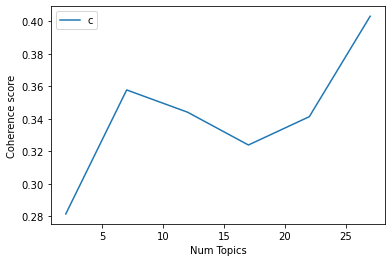

In [125]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [126]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2815
index: 1 | Num Topics = 7  has Coherence Value of 0.3578
index: 2 | Num Topics = 12  has Coherence Value of 0.3441
index: 3 | Num Topics = 17  has Coherence Value of 0.3239
index: 4 | Num Topics = 22  has Coherence Value of 0.3413
index: 5 | Num Topics = 27  has Coherence Value of 0.4031


In [187]:
# Select optimal number of topics
optimal_model_ph_2018_score1N2N3 = model_list_ph_2018_score1N2N3[5]

In [188]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2018_score1N2N3, corpus_ph_2018_score1N2N3, id2word_ph_2018_score1N2N3)

In [189]:
print("pyLDAVis for ph topics for score=1,2,3 in 2018:")
vis_ph_2018_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.238272  0.004814       1        1  15.913933
10    -0.157394  0.059896       2        1  10.399332
23    -0.094472 -0.105515       3        1   6.974677
26    -0.196460  0.080920       4        1   6.388858
11    -0.022610 -0.180131       5        1   5.556512
1     -0.131583 -0.004548       6        1   5.459914
15    -0.027261  0.082101       7        1   4.531675
17    -0.072601 -0.073362       8        1   4.158984
3      0.018828 -0.126947       9        1   4.007843
24    -0.078545  0.046669      10        1   3.303988
12     0.012301 -0.128505      11        1   3.201312
22     0.024372  0.068463      12        1   2.938810
4     -0.020151  0.085220      13        1   2.878241
14    -0.090070 -0.020144      14        1   2.794995
25    -0.032654 -0.027945      15        1   2.760266
19    -0.011645  0.013370      16        1   2.463752
9      0.064098  0.068373      17        1   2.169222
6      0.092647 -0.013452      18        1   2.055802
5      0.041589  0.076842      19        1   1.957748
18     0.183782  0.001279      20        1   1.736955
0      0.067553  0.070009      21        1   1.688061
16     0.081445 -0.028705      22        1   1.617973
13     0.100670  0.134482      23        1   1.595949
8      0.138933 -0.019462      24        1   1.366754
2      0.098977 -0.096105      25        1   1.080140
21     0.137545 -0.000611      26        1   0.679704
20     0.110980  0.032995      27        1   0.318598, topic_info=            Term        Freq       Total Category  logprob  loglift
132           ad   78.000000   78.000000  Default  30.0000  30.0000
44         crash   13.000000   13.000000  Default  29.0000  29.0000
6          video  179.000000  179.000000  Default  28.0000  28.0000
331       upload    9.000000    9.000000  Default  27.0000  27.0000
32           fix   75.000000   75.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
9       annoying    0.010991   11.441265  Topic27  -6.6103  -1.1990
10           app    0.010991   44.078225  Topic27  -6.6103  -2.5477
11   distraction    0.010991    1.554926  Topic27  -6.6103   0.7968
12           end    0.010991    3.928624  Topic27  -6.6103  -0.1300
13          exit    0.010991    3.280694  Topic27  -6.6103   0.0502

[1262 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
590      11  0.669234        abc
160       1  0.177332       able
160       3  0.177332       able
160       4  0.177332       able
160       9  0.177332       able
...     ...       ...        ...
127       7  0.432915  yesterday
127      15  0.432915  yesterday
318       8  0.650918         yo
159       1  0.616941   youtuber
189       2  0.799093         yt

[1347 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 11, 24, 27, 12, 2, 16, 18, 4, 25, 13, 23, 5, 15, 26, 20, 10, 7, 6, 19, 1, 17, 14, 9, 3, 22, 21])

## By-rating of 2019 (Rating=1,2,3)

In [130]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_ph_2019_score1N2N3 = youtube_ios_ph_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_ph_2019_score1N2N3 = list(sent_to_words(review_ph_2019_score1N2N3))
print(review_words_ph_2019_score1N2N3[:1])

[['when', 'was', 'going', 'to', 'watch', 'some', 'videos', 'online', 'noticed', 'the', 'videos', 'that', 'were', 'downloaded', 'all', 'had', 'an', 'unavailable', 'sign', 'on', 'it', 'and', 'had', 'to', 'delete', 'them', 'all', 'now', 'cant', 'download', 'any', 'more', 'videos', 'offlne', 'pls', 'fix', 'this']]


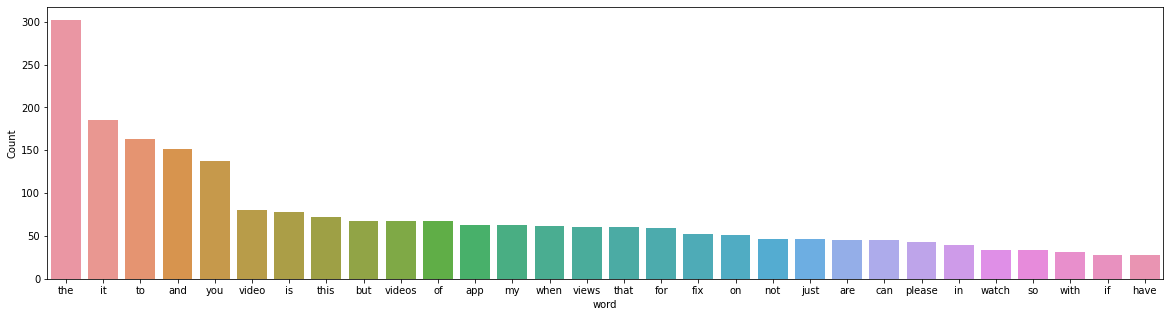

In [131]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2019_score1N2N3))

In [132]:
# Clean text
review_words_ph_ready_2019_score1N2N3 = process_words(review_words_ph_2019_score1N2N3)  # processed Text Data! - move to each section

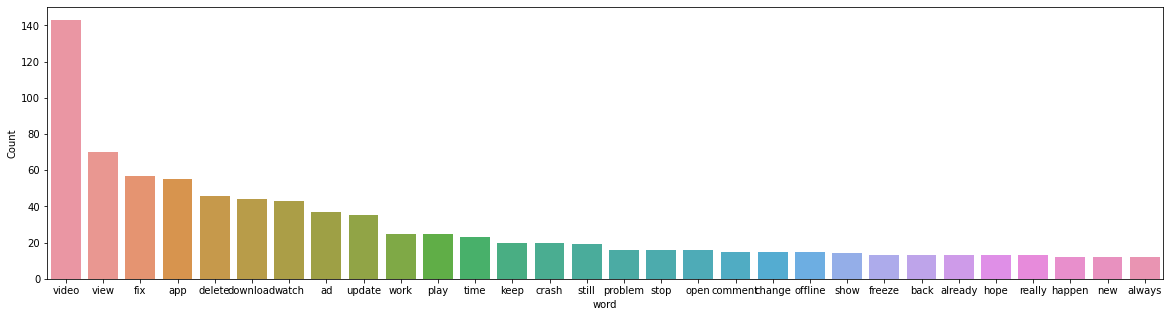

In [133]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2019_score1N2N3))


In [134]:
# Create Dictionary
id2word_ph_2019_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2019_score1N2N3)

2021-10-17 00:40:43,429 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:40:43,438 [INFO] gensim.corpora.dictionary - built Dictionary(705 unique tokens: ['delete', 'download', 'fix', 'notice', 'offlne']...) from 173 documents (total 2345 corpus positions)
2021-10-17 00:40:43,440 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(705 unique tokens: ['delete', 'download', 'fix', 'notice', 'offlne']...) from 173 documents (total 2345 corpus positions)", 'datetime': '2021-10-17T00:40:43.440368', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [135]:
# Create Corpus: Term Document Frequency
corpus_ph_2019_score1N2N3 = [id2word_ph_2019_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2019_score1N2N3]

In [136]:
# Training LDA model
model_list_ph_2019_score1N2N3, coherence_values_ph_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2019_score1N2N3, corpus=corpus_ph_2019_score1N2N3, 
                                                              texts=review_words_ph_ready_2019_score1N2N3, limit=30, start=2, step=5)


2021-10-17 00:40:43,470 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:40:43,472 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:40:43,474 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:40:43,477 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 173 documents, updating model once every 173 documents, evaluating perplexity every 173 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:40:44,162 [INFO] gensim.models.ldamodel - -7.201 per-word bound, 147.2 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:40:44,164 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #173/173
2021-10-17 00:40:44,676 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.062*"video" + 0.021*"download" + 0.020*"fix" + 0.018*"app" + 0.017*"ad" + 0.014*"view" + 0.014*"update

2021-10-17 00:40:49,439 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.053*"view" + 0.034*"delete" + 0.019*"video" + 0.015*"app" + 0.015*"fix" + 0.012*"comment" + 0.010*"work" + 0.008*"freeze" + 0.007*"watch" + 0.007*"hard"
2021-10-17 00:40:49,440 [INFO] gensim.models.ldamodel - topic diff=0.015700, rho=0.301511
2021-10-17 00:40:49,689 [INFO] gensim.models.ldamodel - -6.070 per-word bound, 67.2 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:40:49,690 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #173/173
2021-10-17 00:40:49,846 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.025*"download" + 0.022*"fix" + 0.021*"app" + 0.021*"ad" + 0.020*"watch" + 0.018*"update" + 0.013*"play" + 0.011*"crash" + 0.010*"time"
2021-10-17 00:40:49,847 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.053*"view" + 0.035*"delete" + 0.019*"video" + 0.015*"fix" + 0.014*"app" + 0.012*"comment" + 0.010*"work" + 0.008*"free

2021-10-17 00:40:53,727 [INFO] gensim.models.ldamodel - topic diff=0.009885, rho=0.218218
2021-10-17 00:40:54,040 [INFO] gensim.models.ldamodel - -6.056 per-word bound, 66.5 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:40:54,041 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #173/173
2021-10-17 00:40:54,200 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.024*"download" + 0.023*"app" + 0.022*"fix" + 0.021*"watch" + 0.020*"ad" + 0.019*"update" + 0.013*"play" + 0.011*"crash" + 0.010*"still"
2021-10-17 00:40:54,202 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.057*"view" + 0.037*"delete" + 0.018*"video" + 0.015*"fix" + 0.012*"comment" + 0.011*"app" + 0.010*"work" + 0.009*"freeze" + 0.008*"stop" + 0.008*"hard"
2021-10-17 00:40:54,203 [INFO] gensim.models.ldamodel - topic diff=0.009491, rho=0.213201
2021-10-17 00:40:54,452 [INFO] gensim.models.ldamodel - -6.054 per-word bound, 66.4 perplexity estimate 

2021-10-17 00:40:58,002 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #173/173
2021-10-17 00:40:58,102 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.024*"download" + 0.024*"app" + 0.022*"watch" + 0.022*"fix" + 0.020*"ad" + 0.019*"update" + 0.013*"play" + 0.011*"crash" + 0.010*"still"
2021-10-17 00:40:58,103 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.058*"view" + 0.038*"delete" + 0.017*"video" + 0.015*"fix" + 0.013*"comment" + 0.010*"work" + 0.010*"app" + 0.009*"stop" + 0.009*"freeze" + 0.008*"hard"
2021-10-17 00:40:58,104 [INFO] gensim.models.ldamodel - topic diff=0.003571, rho=0.176777
2021-10-17 00:40:58,418 [INFO] gensim.models.ldamodel - -6.048 per-word bound, 66.2 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:40:58,419 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #173/173
2021-10-17 00:40:58,546 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.024*"a

2021-10-17 00:41:02,072 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.058*"view" + 0.039*"delete" + 0.017*"video" + 0.015*"fix" + 0.013*"comment" + 0.010*"work" + 0.009*"stop" + 0.009*"freeze" + 0.009*"app" + 0.008*"add"
2021-10-17 00:41:02,075 [INFO] gensim.models.ldamodel - topic diff=0.002443, rho=0.154303
2021-10-17 00:41:02,299 [INFO] gensim.models.ldamodel - -6.047 per-word bound, 66.1 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:02,300 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #173/173
2021-10-17 00:41:02,448 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.067*"video" + 0.025*"app" + 0.024*"download" + 0.022*"watch" + 0.022*"fix" + 0.020*"ad" + 0.019*"update" + 0.013*"play" + 0.011*"crash" + 0.010*"still"
2021-10-17 00:41:02,449 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.059*"view" + 0.039*"delete" + 0.017*"video" + 0.015*"fix" + 0.013*"comment" + 0.010*"work" + 0.009*"stop" + 0.009*"free

2021-10-17 00:41:10,679 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 170 virtual documents
2021-10-17 00:41:11,049 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:41:11,051 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:41:11,053 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:41:11,056 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 173 documents, updating model once every 173 documents, evaluating perplexity every 173 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:41:11,533 [INFO] gensim.models.ldamodel - -9.175 per-word bound, 578.1 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:11,542 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #173/173
2021-10-17 00:41

2021-10-17 00:41:14,308 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #173/173
2021-10-17 00:41:14,460 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.039*"video" + 0.029*"delete" + 0.026*"download" + 0.024*"view" + 0.022*"ad" + 0.018*"fix" + 0.012*"stop" + 0.011*"minute" + 0.011*"time" + 0.011*"next"
2021-10-17 00:41:14,463 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.072*"video" + 0.039*"fix" + 0.036*"app" + 0.027*"play" + 0.026*"update" + 0.023*"crash" + 0.022*"still" + 0.020*"watch" + 0.017*"open" + 0.014*"download"
2021-10-17 00:41:14,466 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"video" + 0.031*"view" + 0.023*"app" + 0.021*"add" + 0.018*"delete" + 0.013*"time" + 0.013*"music" + 0.013*"watch" + 0.013*"find" + 0.012*"well"
2021-10-17 00:41:14,467 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.023*"change" + 0.014*"hope" + 0.013*"update" + 0.013*"video" + 0.012*"view" + 0.012*"watch" + 0.011*"profile" + 0.011*"let" + 0.011*"give" + 0.011

2021-10-17 00:41:16,581 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.024*"change" + 0.015*"hope" + 0.013*"video" + 0.013*"let" + 0.012*"update" + 0.012*"profile" + 0.012*"fan" + 0.011*"watch" + 0.011*"view" + 0.011*"app"
2021-10-17 00:41:16,582 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.071*"video" + 0.040*"fix" + 0.039*"app" + 0.027*"update" + 0.027*"crash" + 0.026*"play" + 0.022*"still" + 0.021*"watch" + 0.020*"open" + 0.016*"download"
2021-10-17 00:41:16,584 [INFO] gensim.models.ldamodel - topic diff=0.014568, rho=0.288675
2021-10-17 00:41:16,830 [INFO] gensim.models.ldamodel - -6.326 per-word bound, 80.2 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:16,831 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #173/173
2021-10-17 00:41:17,047 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"video" + 0.030*"delete" + 0.024*"download" + 0.024*"view" + 0.023*"ad" + 0.017*"fix" + 0.013*"stop" + 0.013*"ne

2021-10-17 00:41:19,098 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #173/173
2021-10-17 00:41:19,299 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.071*"video" + 0.041*"app" + 0.041*"fix" + 0.028*"update" + 0.028*"crash" + 0.025*"play" + 0.022*"watch" + 0.022*"still" + 0.022*"open" + 0.017*"download"
2021-10-17 00:41:19,300 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.083*"video" + 0.046*"download" + 0.032*"ad" + 0.021*"offline" + 0.015*"upload" + 0.015*"fix" + 0.015*"caption" + 0.013*"watch" + 0.012*"show" + 0.012*"work"
2021-10-17 00:41:19,302 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"video" + 0.030*"delete" + 0.025*"view" + 0.024*"download" + 0.023*"ad" + 0.015*"fix" + 0.014*"stop" + 0.013*"next" + 0.012*"minute" + 0.012*"advertisement"
2021-10-17 00:41:19,304 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"change" + 0.015*"hope" + 0.014*"let" + 0.013*"video" + 0.012*"update" + 0.012*"profile" + 0.012*"fan" + 0.011*"app" + 0.011

2021-10-17 00:41:21,335 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"view" + 0.049*"delete" + 0.023*"video" + 0.017*"ad" + 0.015*"hard" + 0.015*"work" + 0.013*"freeze" + 0.013*"watch" + 0.011*"boy" + 0.011*"fix"
2021-10-17 00:41:21,337 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"video" + 0.030*"delete" + 0.025*"view" + 0.023*"download" + 0.023*"ad" + 0.015*"fix" + 0.014*"stop" + 0.014*"next" + 0.012*"minute" + 0.012*"advertisement"
2021-10-17 00:41:21,338 [INFO] gensim.models.ldamodel - topic diff=0.004085, rho=0.208514
2021-10-17 00:41:21,484 [INFO] gensim.models.ldamodel - -6.311 per-word bound, 79.4 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:21,485 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #173/173
2021-10-17 00:41:21,680 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"view" + 0.049*"delete" + 0.023*"video" + 0.017*"ad" + 0.015*"hard" + 0.015*"work" + 0.013*"freeze" + 0.013*"

2021-10-17 00:41:23,553 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #173/173
2021-10-17 00:41:23,677 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.083*"video" + 0.046*"download" + 0.032*"ad" + 0.021*"offline" + 0.016*"upload" + 0.015*"fix" + 0.015*"caption" + 0.013*"watch" + 0.013*"show" + 0.012*"work"
2021-10-17 00:41:23,679 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"video" + 0.031*"delete" + 0.025*"view" + 0.023*"ad" + 0.023*"download" + 0.014*"fix" + 0.014*"stop" + 0.014*"next" + 0.012*"minute" + 0.012*"advertisement"
2021-10-17 00:41:23,683 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"app" + 0.028*"video" + 0.022*"fix" + 0.021*"watch" + 0.018*"comment" + 0.018*"start" + 0.014*"update" + 0.011*"count" + 0.011*"mark" + 0.011*"sort"
2021-10-17 00:41:23,684 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.078*"view" + 0.049*"delete" + 0.023*"video" + 0.017*"ad" + 0.015*"hard" + 0.015*"work" + 0.013*"freeze" + 0.013*"watch" + 0.011*"

2021-10-17 00:41:25,655 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.079*"view" + 0.049*"delete" + 0.022*"video" + 0.017*"ad" + 0.015*"hard" + 0.015*"work" + 0.013*"freeze" + 0.013*"watch" + 0.011*"boy" + 0.011*"fix"
2021-10-17 00:41:25,657 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.071*"video" + 0.045*"app" + 0.040*"fix" + 0.030*"update" + 0.027*"crash" + 0.024*"play" + 0.023*"watch" + 0.023*"still" + 0.022*"open" + 0.018*"download"
2021-10-17 00:41:25,658 [INFO] gensim.models.ldamodel - topic diff=0.001997, rho=0.171499
2021-10-17 00:41:25,755 [INFO] gensim.models.ldamodel - -6.308 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:25,757 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #173/173
2021-10-17 00:41:26,057 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"app" + 0.028*"video" + 0.022*"fix" + 0.021*"watch" + 0.018*"comment" + 0.018*"start" + 0.014*"update" + 0.011*"coun

2021-10-17 00:41:28,295 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"app" + 0.028*"video" + 0.022*"fix" + 0.021*"watch" + 0.018*"comment" + 0.018*"start" + 0.014*"update" + 0.011*"count" + 0.011*"mark" + 0.011*"sort"
2021-10-17 00:41:28,301 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.083*"video" + 0.046*"download" + 0.032*"ad" + 0.021*"offline" + 0.016*"upload" + 0.015*"fix" + 0.015*"caption" + 0.013*"watch" + 0.013*"show" + 0.012*"work"
2021-10-17 00:41:28,303 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.071*"video" + 0.046*"app" + 0.040*"fix" + 0.029*"update" + 0.027*"crash" + 0.024*"play" + 0.023*"watch" + 0.022*"still" + 0.021*"open" + 0.018*"download"
2021-10-17 00:41:28,307 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.036*"video" + 0.031*"view" + 0.022*"add" + 0.018*"app" + 0.017*"delete" + 0.013*"music" + 0.013*"watch" + 0.013*"find" + 0.013*"well" + 0.013*"time"
2021-10-17 00:41:28,309 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.079*"vi

2021-10-17 00:41:30,587 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"video" + 0.032*"delete" + 0.026*"view" + 0.024*"ad" + 0.020*"download" + 0.014*"stop" + 0.014*"next" + 0.014*"fix" + 0.012*"minute" + 0.012*"advertisement"
2021-10-17 00:41:30,588 [INFO] gensim.models.ldamodel - topic diff=0.001591, rho=0.149071
2021-10-17 00:41:30,812 [INFO] gensim.models.ldamodel - -6.304 per-word bound, 79.0 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:30,813 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #173/173
2021-10-17 00:41:30,961 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"video" + 0.032*"delete" + 0.026*"view" + 0.024*"ad" + 0.020*"download" + 0.014*"stop" + 0.014*"next" + 0.014*"fix" + 0.012*"minute" + 0.012*"advertisement"
2021-10-17 00:41:30,963 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.036*"video" + 0.031*"view" + 0.022*"add" + 0.018*"app" + 0.017*"delete" + 0.013*"music" + 0.013*"wat

2021-10-17 00:41:33,296 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.085*"video" + 0.047*"download" + 0.032*"ad" + 0.021*"offline" + 0.016*"upload" + 0.016*"fix" + 0.015*"caption" + 0.015*"watch" + 0.013*"show" + 0.012*"work"
2021-10-17 00:41:33,298 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"video" + 0.031*"view" + 0.022*"add" + 0.018*"app" + 0.017*"delete" + 0.013*"music" + 0.013*"find" + 0.013*"watch" + 0.013*"well" + 0.013*"time"
2021-10-17 00:41:33,299 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.071*"video" + 0.047*"app" + 0.040*"fix" + 0.029*"update" + 0.026*"crash" + 0.024*"watch" + 0.023*"play" + 0.022*"still" + 0.021*"open" + 0.019*"download"
2021-10-17 00:41:33,302 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.080*"view" + 0.050*"delete" + 0.020*"video" + 0.017*"ad" + 0.015*"hard" + 0.015*"work" + 0.013*"freeze" + 0.012*"watch" + 0.011*"boy" + 0.011*"fix"
2021-10-17 00:41:33,303 [INFO] gensim.models.ldamodel - topic diff=0.001361, rho=0.14002

2021-10-17 00:41:41,740 [INFO] gensim.models.ldamodel - topic diff=0.081301, rho=0.447214
2021-10-17 00:41:41,969 [INFO] gensim.models.ldamodel - -6.511 per-word bound, 91.2 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:41,971 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #173/173
2021-10-17 00:41:42,172 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.057*"video" + 0.040*"app" + 0.032*"open" + 0.030*"update" + 0.029*"download" + 0.027*"fix" + 0.021*"turn" + 0.017*"still" + 0.013*"touch" + 0.013*"play"
2021-10-17 00:41:42,174 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.065*"video" + 0.045*"ad" + 0.024*"watch" + 0.018*"fix" + 0.016*"always" + 0.016*"work" + 0.015*"banner" + 0.015*"profile" + 0.015*"press" + 0.013*"download"
2021-10-17 00:41:42,175 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.030*"fix" + 0.027*"comment" + 0.022*"video" + 0.021*"app" + 0.018*"watch" + 0.014*"change" + 0.013*"download" + 0

2021-10-17 00:41:44,180 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.045*"video" + 0.042*"download" + 0.040*"app" + 0.031*"show" + 0.030*"update" + 0.022*"play" + 0.021*"offline" + 0.019*"still" + 0.019*"fix" + 0.016*"upload"
2021-10-17 00:41:44,183 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.076*"video" + 0.054*"crash" + 0.046*"fix" + 0.031*"app" + 0.022*"keep" + 0.019*"window" + 0.016*"watch" + 0.013*"open" + 0.012*"space" + 0.012*"center"
2021-10-17 00:41:44,187 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.047*"view" + 0.041*"delete" + 0.030*"add" + 0.028*"video" + 0.023*"late" + 0.021*"update" + 0.018*"music" + 0.018*"work" + 0.012*"boy" + 0.012*"freeze"
2021-10-17 00:41:44,188 [INFO] gensim.models.ldamodel - topic diff=0.017184, rho=0.301511
2021-10-17 00:41:44,463 [INFO] gensim.models.ldamodel - -6.467 per-word bound, 88.4 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:44,468 [INFO] gensim.models.ldamodel - P

2021-10-17 00:41:46,560 [INFO] gensim.models.ldamodel - -6.457 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:46,561 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #173/173
2021-10-17 00:41:46,739 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.047*"view" + 0.042*"delete" + 0.030*"add" + 0.028*"video" + 0.023*"late" + 0.022*"update" + 0.018*"music" + 0.018*"work" + 0.012*"boy" + 0.012*"freeze"
2021-10-17 00:41:46,743 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.032*"delete" + 0.032*"view" + 0.026*"ad" + 0.021*"download" + 0.021*"let" + 0.017*"video" + 0.016*"happen" + 0.011*"keep" + 0.011*"annoy" + 0.011*"fix"
2021-10-17 00:41:46,745 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.057*"video" + 0.050*"app" + 0.036*"open" + 0.033*"update" + 0.028*"download" + 0.027*"fix" + 0.021*"turn" + 0.017*"still" + 0.013*"close" + 0.012*"touch"
2021-10-17 00:41:46,748 [INFO] gensim.models.ldamodel 

2021-10-17 00:41:48,784 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.032*"delete" + 0.032*"view" + 0.026*"ad" + 0.021*"download" + 0.021*"let" + 0.017*"video" + 0.016*"happen" + 0.011*"keep" + 0.011*"annoy" + 0.011*"fix"
2021-10-17 00:41:48,786 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.047*"view" + 0.042*"delete" + 0.030*"add" + 0.028*"video" + 0.024*"late" + 0.022*"update" + 0.018*"music" + 0.018*"work" + 0.012*"boy" + 0.012*"freeze"
2021-10-17 00:41:48,788 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.027*"ad" + 0.021*"watch" + 0.016*"give" + 0.016*"bug" + 0.016*"video" + 0.011*"star" + 0.011*"second" + 0.011*"screen" + 0.011*"update" + 0.011*"new"
2021-10-17 00:41:48,789 [INFO] gensim.models.ldamodel - topic diff=0.003008, rho=0.213201
2021-10-17 00:41:49,071 [INFO] gensim.models.ldamodel - -6.451 per-word bound, 87.5 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:49,072 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-17 00:41:51,050 [INFO] gensim.models.ldamodel - -6.449 per-word bound, 87.3 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:51,053 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #173/173
2021-10-17 00:41:51,209 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.027*"ad" + 0.021*"watch" + 0.016*"give" + 0.016*"bug" + 0.016*"video" + 0.011*"star" + 0.011*"second" + 0.011*"screen" + 0.011*"update" + 0.011*"new"
2021-10-17 00:41:51,211 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.100*"video" + 0.039*"view" + 0.033*"delete" + 0.032*"watch" + 0.028*"time" + 0.022*"download" + 0.019*"always" + 0.018*"app" + 0.016*"next" + 0.014*"play"
2021-10-17 00:41:51,213 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.064*"video" + 0.048*"ad" + 0.023*"watch" + 0.016*"always" + 0.016*"banner" + 0.016*"profile" + 0.016*"work" + 0.016*"press" + 0.015*"fix" + 0.012*"experience"
2021-10-17 00:41:51,215 [INFO] gensim.models.ld

2021-10-17 00:41:53,211 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.057*"video" + 0.051*"app" + 0.036*"open" + 0.033*"update" + 0.028*"download" + 0.026*"fix" + 0.020*"turn" + 0.016*"still" + 0.016*"close" + 0.012*"touch"
2021-10-17 00:41:53,212 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.099*"video" + 0.039*"view" + 0.033*"delete" + 0.032*"watch" + 0.028*"time" + 0.022*"download" + 0.019*"always" + 0.018*"app" + 0.016*"next" + 0.014*"play"
2021-10-17 00:41:53,214 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.044*"change" + 0.028*"video" + 0.022*"really" + 0.022*"ad" + 0.022*"way" + 0.022*"upload" + 0.021*"fix" + 0.015*"watch" + 0.015*"help" + 0.015*"keep"
2021-10-17 00:41:53,215 [INFO] gensim.models.ldamodel - topic diff=0.000873, rho=0.174078
2021-10-17 00:41:53,449 [INFO] gensim.models.ldamodel - -6.448 per-word bound, 87.3 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:53,453 [INFO] gensim.models.ldamodel - PR

2021-10-17 00:41:55,478 [INFO] gensim.models.ldamodel - -6.447 per-word bound, 87.3 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:55,479 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #173/173
2021-10-17 00:41:55,673 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.032*"delete" + 0.032*"view" + 0.026*"ad" + 0.021*"download" + 0.021*"let" + 0.017*"video" + 0.016*"happen" + 0.011*"annoy" + 0.011*"thing" + 0.011*"annoying"
2021-10-17 00:41:55,675 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.027*"ad" + 0.021*"watch" + 0.016*"give" + 0.016*"bug" + 0.016*"video" + 0.011*"star" + 0.011*"second" + 0.011*"screen" + 0.011*"double" + 0.011*"new"
2021-10-17 00:41:55,677 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.105*"view" + 0.057*"delete" + 0.019*"hard" + 0.016*"freeze" + 0.016*"work" + 0.013*"video" + 0.012*"new" + 0.011*"watch" + 0.011*"stop" + 0.011*"guy"
2021-10-17 00:41:55,679 [INFO] gensim.models.ldamodel 

2021-10-17 00:41:57,846 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.048*"view" + 0.042*"delete" + 0.030*"add" + 0.027*"video" + 0.024*"late" + 0.021*"update" + 0.018*"music" + 0.018*"work" + 0.012*"already" + 0.012*"watch"
2021-10-17 00:41:57,848 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.071*"video" + 0.023*"find" + 0.023*"update" + 0.022*"play" + 0.020*"fix" + 0.019*"ad" + 0.019*"well" + 0.015*"watch" + 0.014*"download" + 0.014*"annoying"
2021-10-17 00:41:57,852 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.064*"video" + 0.048*"ad" + 0.023*"watch" + 0.016*"always" + 0.016*"profile" + 0.016*"banner" + 0.016*"work" + 0.016*"press" + 0.015*"fix" + 0.012*"manage"
2021-10-17 00:41:57,854 [INFO] gensim.models.ldamodel - topic diff=0.000273, rho=0.150756
2021-10-17 00:41:58,097 [INFO] gensim.models.ldamodel - -6.447 per-word bound, 87.3 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:41:58,101 [INFO] gensim.models.ldamode

2021-10-17 00:42:00,316 [INFO] gensim.models.ldamodel - -6.447 per-word bound, 87.2 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:00,317 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #173/173
2021-10-17 00:42:00,425 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.048*"view" + 0.042*"delete" + 0.030*"add" + 0.027*"video" + 0.024*"late" + 0.021*"update" + 0.018*"work" + 0.018*"music" + 0.012*"already" + 0.012*"watch"
2021-10-17 00:42:00,426 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.032*"delete" + 0.032*"view" + 0.026*"ad" + 0.021*"download" + 0.021*"let" + 0.017*"video" + 0.016*"happen" + 0.011*"thing" + 0.011*"phone" + 0.011*"feature"
2021-10-17 00:42:00,428 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.105*"view" + 0.057*"delete" + 0.019*"hard" + 0.016*"freeze" + 0.016*"work" + 0.013*"video" + 0.012*"new" + 0.011*"watch" + 0.011*"stop" + 0.011*"guy"
2021-10-17 00:42:00,431 [INFO] gensim.models.ldamo

2021-10-17 00:42:10,326 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.046*"app" + 0.039*"update" + 0.033*"video" + 0.030*"show" + 0.024*"download" + 0.021*"play" + 0.020*"upload" + 0.019*"fix" + 0.018*"still" + 0.015*"crash"
2021-10-17 00:42:10,328 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.077*"view" + 0.047*"video" + 0.038*"add" + 0.027*"delete" + 0.026*"music" + 0.014*"freeze" + 0.014*"check" + 0.014*"boy" + 0.014*"complain" + 0.014*"regard"
2021-10-17 00:42:10,329 [INFO] gensim.models.ldamodel - topic diff=0.126443, rho=0.500000
2021-10-17 00:42:10,550 [INFO] gensim.models.ldamodel - -6.668 per-word bound, 101.7 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:10,552 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #173/173
2021-10-17 00:42:10,798 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.056*"video" + 0.028*"download" + 0.026*"upload" + 0.022*"fix" + 0.020*"touch" + 0.016*"watch" + 0.015*"much" +

2021-10-17 00:42:12,585 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #173/173
2021-10-17 00:42:12,773 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"watch" + 0.032*"hit" + 0.017*"fix" + 0.017*"search" + 0.017*"restart" + 0.017*"issue" + 0.017*"possible" + 0.017*"iphone" + 0.017*"content" + 0.017*"tap"
2021-10-17 00:42:12,775 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.039*"delete" + 0.024*"watch" + 0.024*"view" + 0.024*"fix" + 0.024*"stop" + 0.016*"video" + 0.016*"support" + 0.016*"hope" + 0.016*"open" + 0.016*"ad"
2021-10-17 00:42:12,784 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.084*"video" + 0.042*"watch" + 0.033*"crash" + 0.021*"country" + 0.021*"long" + 0.021*"part" + 0.018*"frustrating" + 0.011*"fix" + 0.011*"app" + 0.011*"work"
2021-10-17 00:42:12,792 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.074*"view" + 0.047*"delete" + 0.023*"video" + 0.021*"work" + 0.018*"hard" + 0.017*"really" + 0.013*"fix" + 0.013*"ad" + 0.012*"stop" 

2021-10-17 00:42:14,687 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.059*"video" + 0.052*"fix" + 0.025*"window" + 0.023*"app" + 0.021*"crash" + 0.019*"keep" + 0.017*"view" + 0.017*"thumbnail" + 0.017*"space" + 0.017*"center"
2021-10-17 00:42:14,690 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"app" + 0.041*"update" + 0.032*"show" + 0.030*"video" + 0.022*"still" + 0.022*"upload" + 0.020*"fix" + 0.020*"play" + 0.015*"download" + 0.015*"crash"
2021-10-17 00:42:14,692 [INFO] gensim.models.ldamodel - topic diff=0.009212, rho=0.258199
2021-10-17 00:42:14,935 [INFO] gensim.models.ldamodel - -6.558 per-word bound, 94.2 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:14,937 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #173/173
2021-10-17 00:42:15,080 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"view" + 0.039*"video" + 0.031*"delete" + 0.024*"time" + 0.022*"always" + 0.018*"ad" + 0.018*"find" + 0.01

2021-10-17 00:42:16,959 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #173/173
2021-10-17 00:42:17,172 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.044*"video" + 0.026*"upload" + 0.026*"feature" + 0.022*"fix" + 0.021*"touch" + 0.017*"download" + 0.016*"much" + 0.016*"work" + 0.016*"banner" + 0.016*"manage"
2021-10-17 00:42:17,176 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"view" + 0.039*"video" + 0.032*"delete" + 0.026*"time" + 0.022*"always" + 0.018*"ad" + 0.018*"find" + 0.014*"alot" + 0.014*"episode" + 0.014*"give"
2021-10-17 00:42:17,181 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.053*"app" + 0.038*"update" + 0.033*"show" + 0.030*"video" + 0.022*"upload" + 0.022*"still" + 0.019*"play" + 0.017*"fix" + 0.015*"ad" + 0.015*"problem"
2021-10-17 00:42:17,184 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.053*"video" + 0.031*"update" + 0.031*"crash" + 0.029*"keep" + 0.028*"caption" + 0.025*"view" + 0.023*"fix" + 0.023*"app" + 0.023*"late"

2021-10-17 00:42:19,166 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.039*"delete" + 0.024*"watch" + 0.024*"view" + 0.024*"fix" + 0.024*"stop" + 0.016*"video" + 0.016*"support" + 0.016*"open" + 0.016*"hope" + 0.016*"ad"
2021-10-17 00:42:19,169 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"watch" + 0.032*"hit" + 0.017*"fix" + 0.017*"search" + 0.017*"include" + 0.017*"later" + 0.017*"update" + 0.017*"iphone" + 0.017*"issue" + 0.017*"phone"
2021-10-17 00:42:19,173 [INFO] gensim.models.ldamodel - topic diff=0.002171, rho=0.196116
2021-10-17 00:42:19,412 [INFO] gensim.models.ldamodel - -6.548 per-word bound, 93.6 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:19,413 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #173/173
2021-10-17 00:42:19,564 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.083*"view" + 0.054*"delete" + 0.021*"video" + 0.021*"work" + 0.020*"really" + 0.018*"hard" + 0.014*"freeze" + 0.01

2021-10-17 00:42:21,708 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #173/173
2021-10-17 00:42:21,842 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.106*"video" + 0.089*"download" + 0.037*"offline" + 0.032*"fix" + 0.028*"app" + 0.025*"watch" + 0.018*"still" + 0.017*"play" + 0.014*"happen" + 0.014*"internet"
2021-10-17 00:42:21,844 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.039*"delete" + 0.024*"watch" + 0.024*"view" + 0.024*"stop" + 0.024*"fix" + 0.016*"video" + 0.016*"support" + 0.016*"hope" + 0.016*"open" + 0.016*"ad"
2021-10-17 00:42:21,847 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"view" + 0.039*"video" + 0.032*"delete" + 0.026*"time" + 0.022*"always" + 0.018*"ad" + 0.018*"find" + 0.014*"alot" + 0.014*"episode" + 0.014*"give"
2021-10-17 00:42:21,849 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.084*"view" + 0.054*"delete" + 0.021*"video" + 0.021*"work" + 0.020*"really" + 0.018*"hard" + 0.014*"freeze" + 0.013*"fix" + 0.012*"ad" 

2021-10-17 00:42:23,844 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.027*"ad" + 0.027*"app" + 0.018*"type" + 0.018*"download" + 0.018*"change" + 0.011*"fix" + 0.009*"choose" + 0.009*"working" + 0.009*"filter" + 0.009*"especially"
2021-10-17 00:42:23,845 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.059*"view" + 0.025*"delete" + 0.025*"ad" + 0.017*"app" + 0.017*"work" + 0.017*"fan" + 0.009*"fix" + 0.009*"update" + 0.009*"new" + 0.009*"hard"
2021-10-17 00:42:23,848 [INFO] gensim.models.ldamodel - topic diff=0.000536, rho=0.164399
2021-10-17 00:42:24,084 [INFO] gensim.models.ldamodel - -6.546 per-word bound, 93.5 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:24,085 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #173/173
2021-10-17 00:42:24,294 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.043*"video" + 0.026*"upload" + 0.026*"feature" + 0.021*"fix" + 0.021*"touch" + 0.017*"download" + 0.016*"much" + 0.0

2021-10-17 00:42:26,311 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #173/173
2021-10-17 00:42:26,461 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"watch" + 0.032*"hit" + 0.017*"fix" + 0.017*"search" + 0.017*"open" + 0.017*"include" + 0.017*"update" + 0.017*"iphone" + 0.017*"issue" + 0.017*"phone"
2021-10-17 00:42:26,463 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.052*"app" + 0.037*"update" + 0.033*"show" + 0.030*"video" + 0.022*"upload" + 0.021*"still" + 0.019*"play" + 0.016*"fix" + 0.015*"ad" + 0.015*"problem"
2021-10-17 00:42:26,466 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.039*"delete" + 0.024*"watch" + 0.024*"view" + 0.024*"stop" + 0.024*"fix" + 0.016*"video" + 0.016*"support" + 0.016*"open" + 0.016*"hope" + 0.016*"thing"
2021-10-17 00:42:26,469 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.037*"change" + 0.027*"back" + 0.024*"way" + 0.018*"delete" + 0.018*"view" + 0.018*"add" + 0.018*"update" + 0.018*"annoy" + 0.018*"pic" + 0.

2021-10-17 00:42:28,597 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.027*"ad" + 0.027*"app" + 0.018*"type" + 0.018*"download" + 0.018*"change" + 0.011*"fix" + 0.009*"especially" + 0.009*"filter" + 0.009*"search" + 0.009*"date"
2021-10-17 00:42:28,599 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.039*"ad" + 0.029*"comment" + 0.029*"app" + 0.029*"open" + 0.020*"video" + 0.020*"scroll" + 0.020*"watch" + 0.020*"reset" + 0.020*"read" + 0.020*"fix"
2021-10-17 00:42:28,600 [INFO] gensim.models.ldamodel - topic diff=0.000226, rho=0.144338
2021-10-17 00:42:28,827 [INFO] gensim.models.ldamodel - -6.547 per-word bound, 93.5 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:28,828 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #173/173
2021-10-17 00:42:28,968 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.054*"video" + 0.033*"crash" + 0.033*"update" + 0.031*"keep" + 0.028*"caption" + 0.025*"fix" + 0.024*"app" + 0.02

2021-10-17 00:42:39,613 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.065*"view" + 0.031*"delete" + 0.027*"video" + 0.021*"really" + 0.019*"freeze" + 0.019*"ad" + 0.018*"fix" + 0.015*"button" + 0.015*"watch" + 0.015*"much"
2021-10-17 00:42:39,627 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.065*"download" + 0.052*"delete" + 0.042*"video" + 0.020*"touch" + 0.020*"view" + 0.020*"fix" + 0.019*"happen" + 0.015*"bug" + 0.014*"much" + 0.014*"hassle"
2021-10-17 00:42:39,630 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.077*"video" + 0.064*"upload" + 0.028*"button" + 0.024*"allow" + 0.024*"shuffle" + 0.024*"stick" + 0.020*"watch" + 0.016*"ad" + 0.015*"next" + 0.012*"break"
2021-10-17 00:42:39,636 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.059*"video" + 0.047*"app" + 0.028*"open" + 0.027*"crash" + 0.027*"fix" + 0.027*"watch" + 0.023*"problem" + 0.022*"update" + 0.021*"play" + 0.016*"become"
2021-10-17 00:42:39,642 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0

2021-10-17 00:42:41,574 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.031*"update" + 0.029*"find" + 0.029*"episode" + 0.029*"ad" + 0.029*"last" + 0.020*"quality" + 0.020*"next" + 0.020*"internet" + 0.020*"download" + 0.020*"time"
2021-10-17 00:42:41,576 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.068*"video" + 0.042*"fix" + 0.025*"window" + 0.021*"suggest" + 0.021*"watch" + 0.021*"view" + 0.021*"comment" + 0.017*"download" + 0.017*"space" + 0.017*"center"
2021-10-17 00:42:41,577 [INFO] gensim.models.ldamodel - topic diff=0.033404, rho=0.353553
2021-10-17 00:42:41,777 [INFO] gensim.models.ldamodel - -6.656 per-word bound, 100.8 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:41,788 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #173/173
2021-10-17 00:42:41,964 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.078*"download" + 0.057*"delete" + 0.032*"video" + 0.022*"touch" + 0.022*"view" + 0.021*"happen" + 0

2021-10-17 00:42:43,592 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #173/173
2021-10-17 00:42:43,716 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.065*"view" + 0.041*"add" + 0.033*"video" + 0.033*"delete" + 0.025*"music" + 0.025*"freeze" + 0.017*"app" + 0.017*"update" + 0.017*"watch" + 0.017*"check"
2021-10-17 00:42:43,718 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.038*"open" + 0.038*"back" + 0.038*"app" + 0.038*"iphone" + 0.038*"always" + 0.020*"unusable" + 0.020*"uninstalled" + 0.020*"watch" + 0.020*"reinstall" + 0.020*"become"
2021-10-17 00:42:43,719 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.067*"video" + 0.042*"fix" + 0.025*"window" + 0.021*"suggest" + 0.021*"watch" + 0.021*"view" + 0.021*"comment" + 0.017*"download" + 0.017*"space" + 0.017*"app"
2021-10-17 00:42:43,721 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.027*"banner" + 0.027*"profile" + 0.027*"feature" + 0.020*"manage" + 0.020*"fix" + 0.020*"remove" + 0.020*"work" + 0.02

2021-10-17 00:42:46,097 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.044*"view" + 0.044*"delete" + 0.026*"alot" + 0.026*"caption" + 0.026*"download" + 0.019*"app" + 0.018*"video" + 0.018*"fix" + 0.009*"tell" + 0.009*"spend"
2021-10-17 00:42:46,099 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.068*"view" + 0.034*"delete" + 0.024*"really" + 0.022*"video" + 0.020*"freeze" + 0.019*"fix" + 0.016*"ad" + 0.015*"much" + 0.015*"watch" + 0.015*"button"
2021-10-17 00:42:46,101 [INFO] gensim.models.ldamodel - topic diff=0.003933, rho=0.229416
2021-10-17 00:42:46,565 [INFO] gensim.models.ldamodel - -6.627 per-word bound, 98.9 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:46,569 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #173/173
2021-10-17 00:42:46,806 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.078*"video" + 0.034*"time" + 0.034*"view" + 0.027*"comment" + 0.020*"watch" + 0.020*"app" + 0.020*"crash" + 0.02

2021-10-17 00:42:49,231 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #173/173
2021-10-17 00:42:49,466 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.048*"change" + 0.024*"way" + 0.024*"fix" + 0.024*"year" + 0.016*"support" + 0.016*"stop" + 0.016*"wait" + 0.016*"back" + 0.016*"help" + 0.016*"profile"
2021-10-17 00:42:49,470 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.076*"video" + 0.070*"upload" + 0.035*"button" + 0.024*"allow" + 0.024*"stick" + 0.024*"shuffle" + 0.024*"next" + 0.014*"watch" + 0.012*"respond" + 0.012*"choose"
2021-10-17 00:42:49,476 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.068*"view" + 0.034*"delete" + 0.024*"really" + 0.022*"video" + 0.020*"freeze" + 0.019*"fix" + 0.015*"ad" + 0.015*"much" + 0.015*"watch" + 0.015*"button"
2021-10-17 00:42:49,478 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.087*"view" + 0.064*"video" + 0.059*"delete" + 0.024*"download" + 0.020*"hard" + 0.018*"already" + 0.016*"app" + 0.015*"watch" + 0.01

2021-10-17 00:42:51,526 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.052*"fix" + 0.039*"app" + 0.039*"video" + 0.027*"comment" + 0.027*"love" + 0.014*"delete" + 0.014*"download" + 0.014*"happen" + 0.014*"hour" + 0.014*"working"
2021-10-17 00:42:51,528 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.075*"app" + 0.055*"video" + 0.045*"crash" + 0.044*"update" + 0.040*"open" + 0.035*"fix" + 0.023*"still" + 0.023*"play" + 0.020*"watch" + 0.020*"problem"
2021-10-17 00:42:51,529 [INFO] gensim.models.ldamodel - topic diff=0.000579, rho=0.182574
2021-10-17 00:42:51,805 [INFO] gensim.models.ldamodel - -6.625 per-word bound, 98.7 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:51,806 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #173/173
2021-10-17 00:42:51,969 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.065*"view" + 0.041*"add" + 0.033*"video" + 0.033*"delete" + 0.025*"music" + 0.025*"freeze" + 0.017*"app" + 0

2021-10-17 00:42:53,719 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #173/173
2021-10-17 00:42:53,841 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.039*"open" + 0.039*"back" + 0.039*"iphone" + 0.039*"app" + 0.039*"always" + 0.020*"unusable" + 0.020*"uninstalled" + 0.020*"watch" + 0.020*"reinstall" + 0.020*"become"
2021-10-17 00:42:53,844 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.027*"profile" + 0.027*"banner" + 0.027*"feature" + 0.020*"manage" + 0.020*"fix" + 0.020*"remove" + 0.020*"work" + 0.020*"count" + 0.020*"mark" + 0.014*"copyright"
2021-10-17 00:42:53,846 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.068*"view" + 0.034*"delete" + 0.024*"really" + 0.022*"video" + 0.020*"freeze" + 0.019*"fix" + 0.015*"ad" + 0.015*"much" + 0.015*"watch" + 0.015*"button"
2021-10-17 00:42:53,848 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.027*"feature" + 0.027*"disappear" + 0.027*"tap" + 0.027*"update" + 0.027*"double" + 0.027*"back" + 0.027*"late" + 

2021-10-17 00:42:55,861 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.075*"app" + 0.055*"video" + 0.045*"crash" + 0.044*"update" + 0.040*"open" + 0.035*"fix" + 0.023*"still" + 0.023*"play" + 0.020*"watch" + 0.020*"problem"
2021-10-17 00:42:55,864 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.052*"fix" + 0.039*"app" + 0.039*"video" + 0.027*"comment" + 0.027*"love" + 0.014*"delete" + 0.014*"download" + 0.014*"happen" + 0.014*"hour" + 0.014*"working"
2021-10-17 00:42:55,866 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.027*"banner" + 0.027*"profile" + 0.027*"feature" + 0.020*"manage" + 0.020*"fix" + 0.020*"remove" + 0.020*"work" + 0.020*"count" + 0.020*"mark" + 0.014*"copyright"
2021-10-17 00:42:55,869 [INFO] gensim.models.ldamodel - topic diff=0.000116, rho=0.156174
2021-10-17 00:42:56,069 [INFO] gensim.models.ldamodel - -6.625 per-word bound, 98.7 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:56,071 [INFO] gensim.mo

2021-10-17 00:42:57,887 [INFO] gensim.models.ldamodel - topic diff=0.000077, rho=0.147442
2021-10-17 00:42:58,089 [INFO] gensim.models.ldamodel - -6.625 per-word bound, 98.7 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:42:58,090 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #173/173
2021-10-17 00:42:58,216 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.087*"view" + 0.064*"video" + 0.059*"delete" + 0.024*"download" + 0.020*"hard" + 0.018*"already" + 0.016*"app" + 0.015*"watch" + 0.015*"work" + 0.015*"update"
2021-10-17 00:42:58,219 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.044*"view" + 0.044*"delete" + 0.026*"alot" + 0.026*"caption" + 0.026*"download" + 0.019*"app" + 0.018*"fix" + 0.018*"video" + 0.009*"tell" + 0.009*"deserve"
2021-10-17 00:42:58,222 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.052*"view" + 0.052*"delete" + 0.052*"work" + 0.026*"hard" + 0.026*"caption" + 0.026*"video" + 0.013*"las

2021-10-17 00:43:04,832 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:43:04,909 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 173 virtual documents
2021-10-17 00:43:09,055 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-17 00:43:09,056 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-17 00:43:09,059 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:43:09,069 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 173 documents, updating model once every 173 documents, evaluating perplexity every 173 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:43:09,486 [INFO] gensim.models.ldamodel - -22.899 per-word bound, 7822342.5 perplexity estimate based on a held-out corpus of 173 documents with 2

2021-10-17 00:43:11,336 [INFO] gensim.models.ldamodel - topic diff=0.087807, rho=0.408248
2021-10-17 00:43:11,582 [INFO] gensim.models.ldamodel - -6.737 per-word bound, 106.7 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:43:11,583 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #173/173
2021-10-17 00:43:11,716 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.042*"watch" + 0.029*"video" + 0.028*"bug" + 0.028*"touch" + 0.028*"download" + 0.027*"understand" + 0.019*"allow" + 0.019*"upload" + 0.019*"stick" + 0.019*"ad"
2021-10-17 00:43:11,719 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.046*"video" + 0.043*"download" + 0.040*"offline" + 0.035*"still" + 0.034*"fix" + 0.031*"app" + 0.029*"caption" + 0.023*"play" + 0.018*"reinstall" + 0.018*"problem"
2021-10-17 00:43:11,726 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.100*"video" + 0.077*"ad" + 0.065*"watch" + 0.030*"keep" + 0.023*"connection" + 0.023*"time" + 0

2021-10-17 00:43:13,595 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.053*"episode" + 0.053*"find" + 0.053*"ad" + 0.018*"view" + 0.018*"waste" + 0.018*"search" + 0.018*"ur" + 0.018*"source" + 0.018*"work" + 0.018*"review"
2021-10-17 00:43:13,598 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.033*"fix" + 0.024*"watch" + 0.024*"video" + 0.022*"keep" + 0.022*"support" + 0.022*"annoying" + 0.022*"connection" + 0.022*"internet" + 0.011*"hope" + 0.011*"screen"
2021-10-17 00:43:13,601 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.041*"watch" + 0.036*"bug" + 0.030*"video" + 0.028*"touch" + 0.028*"download" + 0.028*"understand" + 0.019*"still" + 0.019*"allow" + 0.019*"upload" + 0.019*"stick"
2021-10-17 00:43:13,603 [INFO] gensim.models.ldamodel - topic diff=0.022427, rho=0.288675
2021-10-17 00:43:13,857 [INFO] gensim.models.ldamodel - -6.673 per-word bound, 102.0 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:43:13,862 [INFO] ge

2021-10-17 00:43:15,486 [INFO] gensim.models.ldamodel - topic diff=0.008773, rho=0.242536
2021-10-17 00:43:15,641 [INFO] gensim.models.ldamodel - -6.661 per-word bound, 101.2 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:43:15,642 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #173/173
2021-10-17 00:43:15,815 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.033*"watch" + 0.033*"count" + 0.033*"mark" + 0.022*"video" + 0.022*"hit" + 0.022*"work" + 0.022*"number" + 0.022*"object" + 0.022*"start" + 0.022*"counting"
2021-10-17 00:43:15,816 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.053*"open" + 0.027*"chrimecast" + 0.027*"hope" + 0.027*"connect" + 0.027*"tv" + 0.027*"netflix" + 0.027*"watch" + 0.027*"turn" + 0.027*"problem" + 0.027*"fix"
2021-10-17 00:43:15,818 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.059*"video" + 0.037*"fix" + 0.031*"comment" + 0.031*"scroll" + 0.031*"watch" + 0.031*"work" + 0.021*"cop

2021-10-17 00:43:17,726 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.035*"app" + 0.030*"video" + 0.026*"let" + 0.025*"view" + 0.025*"change" + 0.024*"fix" + 0.018*"update" + 0.018*"internet" + 0.018*"quality" + 0.018*"disappear"
2021-10-17 00:43:17,728 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.068*"view" + 0.053*"delete" + 0.036*"video" + 0.034*"alot" + 0.028*"fix" + 0.025*"download" + 0.025*"next" + 0.025*"money" + 0.024*"effort" + 0.017*"time"
2021-10-17 00:43:17,730 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.101*"app" + 0.066*"update" + 0.044*"upload" + 0.029*"crash" + 0.022*"video" + 0.022*"problem" + 0.022*"show" + 0.022*"hope" + 0.022*"close" + 0.022*"start"
2021-10-17 00:43:17,734 [INFO] gensim.models.ldamodel - topic diff=0.003828, rho=0.208514
2021-10-17 00:43:17,986 [INFO] gensim.models.ldamodel - -6.652 per-word bound, 100.6 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:43:17,988 [INFO] gensim.models.

2021-10-17 00:43:19,717 [INFO] gensim.models.ldamodel - topic diff=0.002399, rho=0.188982
2021-10-17 00:43:19,935 [INFO] gensim.models.ldamodel - -6.646 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:43:19,938 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #173/173
2021-10-17 00:43:20,077 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.038*"late" + 0.025*"sort" + 0.025*"comment" + 0.025*"ad" + 0.025*"video" + 0.025*"automatically" + 0.013*"update" + 0.013*"click" + 0.013*"hang" + 0.013*"select"
2021-10-17 00:43:20,080 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.068*"video" + 0.051*"view" + 0.034*"delete" + 0.034*"time" + 0.026*"app" + 0.026*"fair" + 0.017*"crash" + 0.017*"turn" + 0.017*"hard" + 0.017*"shuffle"
2021-10-17 00:43:20,084 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.130*"video" + 0.073*"download" + 0.039*"watch" + 0.027*"play" + 0.023*"offline" + 0.019*"well" + 0.019*"

2021-10-17 00:43:22,119 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.032*"update" + 0.032*"ad" + 0.032*"download" + 0.032*"menu" + 0.017*"play" + 0.017*"fix" + 0.017*"video" + 0.016*"work" + 0.016*"back" + 0.016*"always"
2021-10-17 00:43:22,123 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.051*"feature" + 0.047*"back" + 0.032*"app" + 0.031*"banner" + 0.031*"profile" + 0.031*"manage" + 0.021*"open" + 0.021*"iphone" + 0.021*"always" + 0.021*"work"
2021-10-17 00:43:22,126 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.053*"find" + 0.053*"episode" + 0.053*"ad" + 0.018*"view" + 0.018*"waste" + 0.018*"ur" + 0.018*"thing" + 0.018*"source" + 0.018*"search" + 0.018*"work"
2021-10-17 00:43:22,141 [INFO] gensim.models.ldamodel - topic diff=0.001557, rho=0.171499
2021-10-17 00:43:22,283 [INFO] gensim.models.ldamodel - -6.642 per-word bound, 99.9 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:43:22,285 [INFO] gensim.models.ldamodel 

2021-10-17 00:43:24,074 [INFO] gensim.models.ldamodel - topic diff=0.001114, rho=0.160128
2021-10-17 00:43:24,317 [INFO] gensim.models.ldamodel - -6.640 per-word bound, 99.8 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:43:24,318 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #173/173
2021-10-17 00:43:24,396 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.032*"sentence" + 0.032*"translate" + 0.032*"update" + 0.032*"voice" + 0.032*"tagalog" + 0.032*"add" + 0.001*"profile" + 0.001*"manage" + 0.001*"banner" + 0.001*"feature"
2021-10-17 00:43:24,398 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.042*"crash" + 0.041*"app" + 0.033*"keep" + 0.033*"fix" + 0.025*"video" + 0.025*"delete" + 0.025*"download" + 0.017*"view" + 0.017*"like" + 0.017*"freeze"
2021-10-17 00:43:24,401 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.064*"video" + 0.045*"fix" + 0.043*"window" + 0.029*"center" + 0.029*"space" + 0.029*"suggest" + 

2021-10-17 00:43:26,384 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.064*"video" + 0.045*"fix" + 0.043*"window" + 0.029*"center" + 0.029*"suggest" + 0.029*"space" + 0.021*"bug" + 0.021*"comment" + 0.015*"view" + 0.014*"caption"
2021-10-17 00:43:26,386 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.053*"find" + 0.053*"episode" + 0.053*"ad" + 0.018*"view" + 0.018*"waste" + 0.018*"ur" + 0.018*"thing" + 0.018*"source" + 0.018*"search" + 0.018*"work"
2021-10-17 00:43:26,392 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.041*"watch" + 0.037*"bug" + 0.030*"video" + 0.028*"touch" + 0.028*"download" + 0.028*"understand" + 0.019*"still" + 0.019*"ad" + 0.019*"hope" + 0.019*"allow"
2021-10-17 00:43:26,399 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.033*"watch" + 0.033*"count" + 0.033*"mark" + 0.022*"video" + 0.022*"hit" + 0.022*"number" + 0.022*"work" + 0.022*"object" + 0.022*"start" + 0.022*"counting"
2021-10-17 00:43:26,409 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-17 00:43:28,987 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.130*"video" + 0.073*"download" + 0.039*"watch" + 0.027*"play" + 0.023*"offline" + 0.018*"well" + 0.018*"happen" + 0.018*"turn" + 0.018*"always" + 0.014*"app"
2021-10-17 00:43:28,988 [INFO] gensim.models.ldamodel - topic diff=0.000471, rho=0.141421
2021-10-17 00:43:29,192 [INFO] gensim.models.ldamodel - -6.639 per-word bound, 99.6 perplexity estimate based on a held-out corpus of 173 documents with 2345 words
2021-10-17 00:43:29,193 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #173/173
2021-10-17 00:43:29,352 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.032*"update" + 0.032*"ad" + 0.032*"download" + 0.032*"menu" + 0.017*"play" + 0.017*"fix" + 0.017*"video" + 0.016*"always" + 0.016*"like" + 0.016*"guy"
2021-10-17 00:43:29,354 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.102*"video" + 0.035*"fix" + 0.035*"ad" + 0.031*"download" + 0.021*"comment" + 0.017*"app" + 0.014*"love" + 0.01

In [137]:
%store model_list_ph_2019_score1N2N3
%store coherence_values_ph_2019_score1N2N3

Stored 'model_list_ph_2019_score1N2N3' (list)
Stored 'coherence_values_ph_2019_score1N2N3' (list)


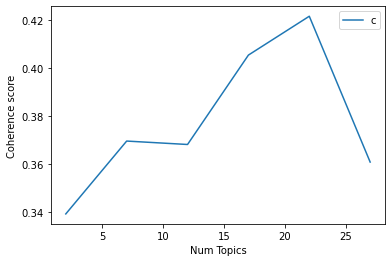

In [138]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [139]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3393
index: 1 | Num Topics = 7  has Coherence Value of 0.3697
index: 2 | Num Topics = 12  has Coherence Value of 0.3682
index: 3 | Num Topics = 17  has Coherence Value of 0.4055
index: 4 | Num Topics = 22  has Coherence Value of 0.4216
index: 5 | Num Topics = 27  has Coherence Value of 0.3609


In [190]:
# Select optimal number of topics
optimal_model_ph_2019_score1N2N3 = model_list_ph_2019_score1N2N3[4]

In [191]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2019_score1N2N3, corpus_ph_2019_score1N2N3, id2word_ph_2019_score1N2N3)

In [192]:
print("pyLDAVis for ph topics for score=1,2,3 in 2019:")
vis_ph_2019_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.142717 -0.090888       1        1  8.745328
3     -0.116620  0.024825       2        1  8.685278
9     -0.123402 -0.081815       3        1  8.526075
6      0.071551  0.139002       4        1  7.321105
16    -0.020608  0.138678       5        1  6.991465
21    -0.142837  0.040832       6        1  6.506178
11    -0.042195 -0.117959       7        1  5.958643
19     0.195197 -0.119735       8        1  5.095493
10    -0.053459  0.041433       9        1  5.002579
13    -0.068326  0.059944      10        1  4.828255
2      0.005816  0.108923      11        1  4.626090
4      0.030260  0.122720      12        1  3.948889
8      0.114842 -0.106833      13        1  3.912219
14     0.076583  0.082222      14        1  3.634975
18     0.008158 -0.047751      15        1  3.136123
7     -0.092759 -0.061658      16        1  3.105100
0     -0.015580 -0.034326      17        1  2.448921
12    -0.000683 -0.046872      18        1  2.095615
17     0.089493  0.097061      19        1  2.077315
5      0.083582  0.014723      20        1  1.630806
1      0.042555 -0.094355      21        1  1.158585
20     0.101149 -0.068172      22        1  0.564962, topic_info=        Term        Freq       Total Category  logprob  loglift
55      view   55.000000   55.000000  Default  30.0000  30.0000
8      video  113.000000  113.000000  Default  29.0000  29.0000
0     delete   36.000000   36.000000  Default  28.0000  28.0000
95        ad   30.000000   30.000000  Default  27.0000  27.0000
33       app   43.000000   43.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
18    resume    0.015423    2.277106  Topic22  -6.7558   0.1814
19  shortcut    0.015423    1.499175  Topic22  -6.7558   0.5994
20     touch    0.015423    3.857898  Topic22  -6.7558  -0.3458
21      well    0.015423    7.262049  Topic22  -6.7558  -0.9784
22  annoying    0.015423    6.926511  Topic22  -6.7558  -0.9311

[1090 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
539       3  0.638331      able
430       8  0.655724  absolute
195      17  0.721828      acce
10        7  0.269169    access
10       11  0.269169    access
...     ...       ...       ...
511       3  0.324649        yt
511       8  0.324649        yt
511      15  0.324649        yt
551      14  0.683204      zoom
556       2  0.633348        ςζ

[1369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 4, 10, 7, 17, 22, 12, 20, 11, 14, 3, 5, 9, 15, 19, 8, 1, 13, 18, 6, 2, 21])

## By-rating of 2020 (Rating=1,2,3)

In [143]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_ph_2020_score1N2N3 = youtube_ios_ph_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_ph_2020_score1N2N3 = list(sent_to_words(review_ph_2020_score1N2N3))
print(review_words_ph_2020_score1N2N3[:1])

[['hi', 'this', 'may', 'be', 'minor', 'problem', 'but', 'my', 'watch', 'later', 'list', 'is', 'not', 'updating', 'it', 'numbers', 'and', 'the', 'recently', 'added', 'videos', 'on', 'watch', 'later', 'won', 'show', 'up', 'as', 'well', 'please', 'fix', 'this']]


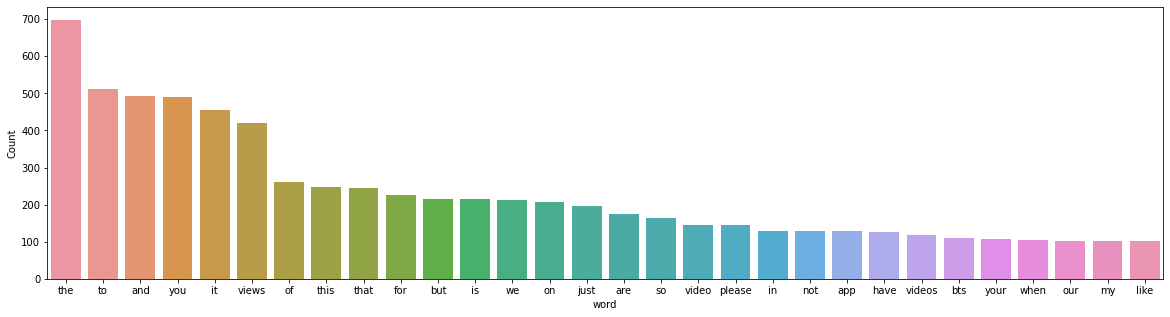

In [144]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2020_score1N2N3))

In [145]:
# Clean text
review_words_ph_ready_2020_score1N2N3 = process_words(review_words_ph_2020_score1N2N3)  # processed Text Data! - move to each section

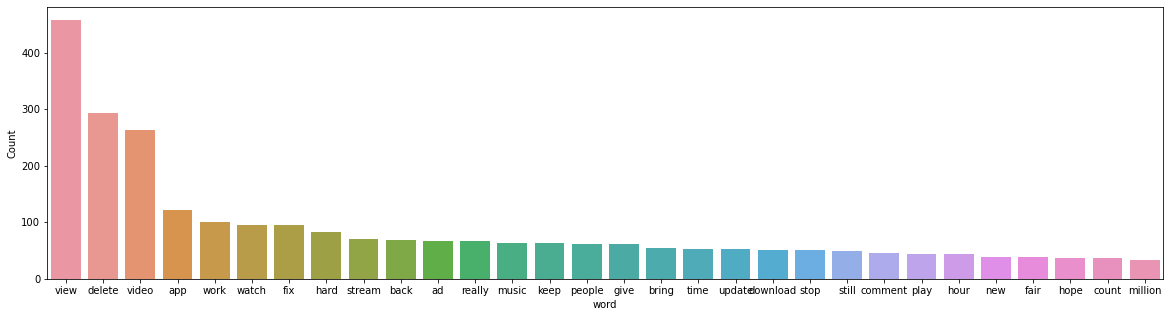

In [146]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2020_score1N2N3))


In [147]:
# Create Dictionary
id2word_ph_2020_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2020_score1N2N3)

2021-10-17 00:43:56,115 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:43:56,168 [INFO] gensim.corpora.dictionary - built Dictionary(1353 unique tokens: ['add', 'fix', 'later', 'list', 'minor']...) from 404 documents (total 7093 corpus positions)
2021-10-17 00:43:56,170 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1353 unique tokens: ['add', 'fix', 'later', 'list', 'minor']...) from 404 documents (total 7093 corpus positions)", 'datetime': '2021-10-17T00:43:56.170238', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [148]:
# Create Corpus: Term Document Frequency
corpus_ph_2020_score1N2N3 = [id2word_ph_2020_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2020_score1N2N3]

In [149]:
# Training LDA model
model_list_ph_2020_score1N2N3, coherence_values_ph_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2020_score1N2N3, corpus=corpus_ph_2020_score1N2N3, 
                                                              texts=review_words_ph_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-17 00:43:56,238 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:43:56,250 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:43:56,260 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:43:56,262 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 404 documents, updating model once every 404 documents, evaluating perplexity every 404 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:43:57,972 [INFO] gensim.models.ldamodel - -7.769 per-word bound, 218.1 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:43:57,973 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #404/404
2021-10-17 00:43:59,571 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"view" + 0.024*"video" + 0.020*"delete" + 0.014*"download" + 0.013*"app" + 0.013*"fix" + 0.012*"wo

2021-10-17 00:44:12,460 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.086*"view" + 0.054*"delete" + 0.024*"video" + 0.016*"hard" + 0.015*"work" + 0.013*"stream" + 0.012*"music" + 0.011*"people" + 0.011*"app" + 0.010*"really"
2021-10-17 00:44:12,473 [INFO] gensim.models.ldamodel - topic diff=0.030832, rho=0.301511
2021-10-17 00:44:13,186 [INFO] gensim.models.ldamodel - -6.172 per-word bound, 72.1 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:44:13,189 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #404/404
2021-10-17 00:44:13,599 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"video" + 0.021*"app" + 0.020*"fix" + 0.018*"watch" + 0.016*"ad" + 0.016*"download" + 0.016*"update" + 0.012*"comment" + 0.011*"play" + 0.010*"still"
2021-10-17 00:44:13,604 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.087*"view" + 0.055*"delete" + 0.023*"video" + 0.016*"hard" + 0.015*"work" + 0.014*"stream" + 0.012*"music" + 0.01

2021-10-17 00:44:25,978 [INFO] gensim.models.ldamodel - topic diff=0.012036, rho=0.218218
2021-10-17 00:44:26,825 [INFO] gensim.models.ldamodel - -6.152 per-word bound, 71.1 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:44:26,826 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #404/404
2021-10-17 00:44:27,463 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"video" + 0.021*"app" + 0.021*"fix" + 0.019*"watch" + 0.019*"ad" + 0.016*"update" + 0.015*"download" + 0.012*"comment" + 0.011*"play" + 0.010*"still"
2021-10-17 00:44:27,474 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.090*"view" + 0.057*"delete" + 0.019*"video" + 0.016*"hard" + 0.016*"work" + 0.014*"stream" + 0.012*"music" + 0.011*"people" + 0.011*"give" + 0.011*"back"
2021-10-17 00:44:27,478 [INFO] gensim.models.ldamodel - topic diff=0.011223, rho=0.213201
2021-10-17 00:44:28,213 [INFO] gensim.models.ldamodel - -6.151 per-word bound, 71.1 perplexity estim

2021-10-17 00:44:40,340 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #404/404
2021-10-17 00:44:40,861 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"video" + 0.021*"app" + 0.021*"fix" + 0.019*"watch" + 0.019*"ad" + 0.015*"update" + 0.015*"download" + 0.012*"comment" + 0.011*"play" + 0.009*"still"
2021-10-17 00:44:40,864 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.091*"view" + 0.058*"delete" + 0.019*"video" + 0.017*"hard" + 0.016*"work" + 0.014*"stream" + 0.013*"music" + 0.011*"people" + 0.011*"give" + 0.011*"back"
2021-10-17 00:44:40,865 [INFO] gensim.models.ldamodel - topic diff=0.005919, rho=0.176777
2021-10-17 00:44:41,804 [INFO] gensim.models.ldamodel - -6.145 per-word bound, 70.8 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:44:41,817 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #404/404
2021-10-17 00:44:42,598 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"video" + 0.02

2021-10-17 00:44:55,868 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"video" + 0.021*"fix" + 0.021*"app" + 0.020*"ad" + 0.019*"watch" + 0.015*"update" + 0.015*"download" + 0.012*"comment" + 0.011*"play" + 0.009*"still"
2021-10-17 00:44:55,870 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.091*"view" + 0.058*"delete" + 0.019*"video" + 0.017*"hard" + 0.016*"work" + 0.014*"stream" + 0.013*"music" + 0.011*"people" + 0.011*"give" + 0.011*"back"
2021-10-17 00:44:55,871 [INFO] gensim.models.ldamodel - topic diff=0.003616, rho=0.154303
2021-10-17 00:44:56,695 [INFO] gensim.models.ldamodel - -6.143 per-word bound, 70.7 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:44:56,702 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #404/404
2021-10-17 00:44:57,333 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"video" + 0.021*"fix" + 0.021*"app" + 0.020*"ad" + 0.019*"watch" + 0.015*"update" + 0.015*"download" + 0.012*"

2021-10-17 00:45:07,636 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:45:13,361 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:45:13,395 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 394 virtual documents
2021-10-17 00:45:13,930 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:45:13,933 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:45:13,944 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:45:13,955 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 404 documents, updating model once every 404 documents, evaluating perplexity every 404 documents, iterating 50x with a con

2021-10-17 00:45:23,862 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.058*"view" + 0.038*"delete" + 0.023*"video" + 0.016*"hour" + 0.014*"keep" + 0.014*"stream" + 0.012*"people" + 0.012*"fix" + 0.012*"play" + 0.012*"time"
2021-10-17 00:45:23,863 [INFO] gensim.models.ldamodel - topic diff=0.083891, rho=0.408248
2021-10-17 00:45:24,905 [INFO] gensim.models.ldamodel - -6.493 per-word bound, 90.1 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:45:24,948 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #404/404
2021-10-17 00:45:25,650 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"app" + 0.029*"video" + 0.021*"update" + 0.020*"comment" + 0.019*"watch" + 0.018*"fix" + 0.017*"still" + 0.017*"section" + 0.012*"download" + 0.012*"back"
2021-10-17 00:45:25,653 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.034*"video" + 0.032*"delete" + 0.029*"view" + 0.021*"fix" + 0.021*"watch" + 0.016*"app" + 0.012*"update" + 0.010

2021-10-17 00:45:33,849 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.058*"view" + 0.039*"delete" + 0.021*"video" + 0.015*"hour" + 0.014*"keep" + 0.012*"time" + 0.012*"people" + 0.012*"stream" + 0.012*"play" + 0.011*"fix"
2021-10-17 00:45:33,850 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.053*"download" + 0.048*"video" + 0.030*"bug" + 0.027*"fix" + 0.020*"watch" + 0.018*"offline" + 0.015*"app" + 0.012*"content" + 0.012*"update" + 0.012*"show"
2021-10-17 00:45:33,852 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"app" + 0.032*"video" + 0.022*"update" + 0.021*"comment" + 0.020*"watch" + 0.019*"still" + 0.018*"fix" + 0.018*"section" + 0.012*"download" + 0.012*"back"
2021-10-17 00:45:33,853 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.035*"video" + 0.026*"delete" + 0.022*"view" + 0.021*"fix" + 0.021*"watch" + 0.015*"app" + 0.013*"update" + 0.011*"open" + 0.010*"time" + 0.009*"change"
2021-10-17 00:45:33,855 [INFO] gensim.models.ldamodel - topic diff=0.025508,

2021-10-17 00:45:40,705 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"play" + 0.019*"fix" + 0.016*"comment" + 0.014*"view" + 0.013*"delete" + 0.012*"app" + 0.011*"video" + 0.011*"keep" + 0.010*"problem" + 0.010*"channel"
2021-10-17 00:45:40,708 [INFO] gensim.models.ldamodel - topic diff=0.015597, rho=0.242536
2021-10-17 00:45:41,659 [INFO] gensim.models.ldamodel - -6.446 per-word bound, 87.2 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:45:41,661 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #404/404
2021-10-17 00:45:42,416 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.056*"view" + 0.038*"delete" + 0.019*"video" + 0.015*"hour" + 0.014*"keep" + 0.013*"time" + 0.012*"play" + 0.012*"people" + 0.011*"stream" + 0.011*"fix"
2021-10-17 00:45:42,420 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.092*"view" + 0.056*"delete" + 0.036*"video" + 0.027*"work" + 0.023*"hard" + 0.015*"really" + 0.015*"ad" + 0.014*"b

2021-10-17 00:45:49,523 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.059*"download" + 0.051*"video" + 0.029*"bug" + 0.028*"fix" + 0.021*"watch" + 0.018*"offline" + 0.016*"update" + 0.015*"app" + 0.013*"work" + 0.012*"show"
2021-10-17 00:45:49,527 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.077*"view" + 0.039*"delete" + 0.026*"video" + 0.016*"give" + 0.014*"count" + 0.011*"app" + 0.011*"music" + 0.010*"back" + 0.009*"stream" + 0.009*"system"
2021-10-17 00:45:49,530 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"play" + 0.019*"fix" + 0.016*"comment" + 0.013*"app" + 0.011*"video" + 0.011*"hate" + 0.011*"problem" + 0.011*"view" + 0.010*"keep" + 0.010*"channel"
2021-10-17 00:45:49,533 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.055*"view" + 0.037*"delete" + 0.018*"video" + 0.016*"hour" + 0.014*"keep" + 0.013*"time" + 0.012*"play" + 0.012*"people" + 0.011*"fix" + 0.011*"stream"
2021-10-17 00:45:49,534 [INFO] gensim.models.ldamodel - topic diff=0.010425, rho=0

2021-10-17 00:45:55,819 [INFO] gensim.models.ldamodel - topic diff=0.008221, rho=0.188982
2021-10-17 00:45:56,527 [INFO] gensim.models.ldamodel - -6.430 per-word bound, 86.2 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:45:56,532 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #404/404
2021-10-17 00:45:57,045 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.076*"view" + 0.038*"delete" + 0.026*"video" + 0.016*"give" + 0.014*"count" + 0.011*"app" + 0.010*"music" + 0.010*"back" + 0.009*"stream" + 0.009*"system"
2021-10-17 00:45:57,052 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"play" + 0.019*"fix" + 0.016*"comment" + 0.013*"app" + 0.012*"hate" + 0.012*"video" + 0.011*"problem" + 0.010*"channel" + 0.010*"keep" + 0.010*"search"
2021-10-17 00:45:57,056 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.095*"view" + 0.059*"delete" + 0.035*"video" + 0.026*"work" + 0.023*"hard" + 0.015*"really" + 0.015*"stream" + 0.

2021-10-17 00:46:03,648 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.062*"download" + 0.054*"video" + 0.029*"fix" + 0.029*"bug" + 0.021*"watch" + 0.017*"offline" + 0.017*"update" + 0.016*"work" + 0.016*"app" + 0.012*"load"
2021-10-17 00:46:03,650 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.097*"view" + 0.059*"delete" + 0.035*"video" + 0.026*"work" + 0.023*"hard" + 0.015*"really" + 0.015*"stream" + 0.015*"bring" + 0.015*"music" + 0.013*"ad"
2021-10-17 00:46:03,652 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.075*"view" + 0.038*"delete" + 0.026*"video" + 0.015*"give" + 0.014*"count" + 0.010*"app" + 0.010*"back" + 0.010*"music" + 0.009*"stream" + 0.009*"system"
2021-10-17 00:46:03,653 [INFO] gensim.models.ldamodel - topic diff=0.006472, rho=0.171499
2021-10-17 00:46:04,450 [INFO] gensim.models.ldamodel - -6.424 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:46:04,452 [INFO] gensim.models.ldamodel - P

2021-10-17 00:46:10,302 [INFO] gensim.models.ldamodel - -6.420 per-word bound, 85.6 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:46:10,306 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #404/404
2021-10-17 00:46:10,849 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.063*"download" + 0.056*"video" + 0.030*"fix" + 0.029*"bug" + 0.021*"watch" + 0.018*"work" + 0.017*"update" + 0.017*"offline" + 0.016*"app" + 0.013*"load"
2021-10-17 00:46:10,850 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.098*"view" + 0.060*"delete" + 0.034*"video" + 0.025*"work" + 0.023*"hard" + 0.015*"stream" + 0.015*"bring" + 0.015*"really" + 0.015*"music" + 0.013*"ad"
2021-10-17 00:46:10,852 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"play" + 0.018*"fix" + 0.017*"comment" + 0.013*"hate" + 0.013*"app" + 0.012*"problem" + 0.011*"channel" + 0.011*"keep" + 0.010*"search" + 0.010*"always"
2021-10-17 00:46:10,853 [INFO] gensim.models.lda

2021-10-17 00:46:16,383 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.063*"download" + 0.058*"video" + 0.030*"fix" + 0.028*"bug" + 0.021*"watch" + 0.019*"work" + 0.017*"update" + 0.017*"app" + 0.016*"offline" + 0.013*"load"
2021-10-17 00:46:16,385 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.099*"view" + 0.060*"delete" + 0.034*"video" + 0.025*"work" + 0.023*"hard" + 0.015*"stream" + 0.015*"bring" + 0.015*"really" + 0.015*"music" + 0.013*"ad"
2021-10-17 00:46:16,386 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"video" + 0.023*"fix" + 0.020*"watch" + 0.015*"open" + 0.014*"app" + 0.012*"premium" + 0.012*"delete" + 0.011*"time" + 0.011*"update" + 0.010*"vid"
2021-10-17 00:46:16,387 [INFO] gensim.models.ldamodel - topic diff=0.003887, rho=0.149071
2021-10-17 00:46:17,130 [INFO] gensim.models.ldamodel - -6.417 per-word bound, 85.5 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:46:17,158 [INFO] gensim.models.ldamodel - PRO

2021-10-17 00:46:22,326 [INFO] gensim.models.ldamodel - -6.415 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:46:22,327 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #404/404
2021-10-17 00:46:22,837 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"video" + 0.023*"fix" + 0.019*"watch" + 0.015*"open" + 0.013*"app" + 0.012*"premium" + 0.011*"delete" + 0.011*"time" + 0.011*"update" + 0.010*"vid"
2021-10-17 00:46:22,838 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.046*"view" + 0.035*"delete" + 0.017*"hour" + 0.016*"video" + 0.014*"keep" + 0.013*"time" + 0.012*"fix" + 0.012*"record" + 0.011*"new" + 0.010*"people"
2021-10-17 00:46:22,840 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.074*"view" + 0.038*"delete" + 0.026*"video" + 0.015*"give" + 0.014*"count" + 0.010*"app" + 0.010*"music" + 0.009*"back" + 0.009*"system" + 0.009*"stream"
2021-10-17 00:46:22,841 [INFO] gensim.models.ldamodel -

2021-10-17 00:46:37,045 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.068*"view" + 0.044*"delete" + 0.028*"video" + 0.020*"app" + 0.015*"update" + 0.014*"fix" + 0.013*"stream" + 0.012*"hour" + 0.012*"hope" + 0.012*"give"
2021-10-17 00:46:37,048 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.023*"delete" + 0.017*"video" + 0.016*"stop" + 0.015*"app" + 0.015*"view" + 0.014*"comment" + 0.014*"really" + 0.012*"give" + 0.011*"crash" + 0.010*"fix"
2021-10-17 00:46:37,050 [INFO] gensim.models.ldamodel - topic diff=0.119900, rho=0.447214
2021-10-17 00:46:37,961 [INFO] gensim.models.ldamodel - -6.640 per-word bound, 99.7 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:46:37,963 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #404/404
2021-10-17 00:46:38,583 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.069*"view" + 0.046*"delete" + 0.024*"hour" + 0.018*"video" + 0.014*"people" + 0.013*"watch" + 0.013*"keep" + 0.011*"str

2021-10-17 00:46:45,236 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #404/404
2021-10-17 00:46:45,802 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.023*"delete" + 0.016*"stop" + 0.016*"video" + 0.014*"view" + 0.014*"comment" + 0.014*"really" + 0.013*"app" + 0.012*"give" + 0.010*"hate" + 0.010*"fix"
2021-10-17 00:46:45,804 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.103*"view" + 0.059*"delete" + 0.043*"video" + 0.028*"work" + 0.025*"hard" + 0.019*"music" + 0.017*"bring" + 0.017*"back" + 0.015*"app" + 0.014*"stream"
2021-10-17 00:46:45,808 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.045*"video" + 0.028*"fix" + 0.028*"ad" + 0.027*"view" + 0.020*"comment" + 0.015*"watch" + 0.013*"vid" + 0.013*"still" + 0.012*"give" + 0.010*"app"
2021-10-17 00:46:45,811 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.070*"view" + 0.046*"delete" + 0.024*"hour" + 0.017*"video" + 0.015*"people" + 0.012*"watch" + 0.012*"stream" + 0.012*"keep" + 0.011*"time" + 0.011*"gi

2021-10-17 00:46:53,205 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.109*"view" + 0.062*"delete" + 0.042*"video" + 0.028*"work" + 0.026*"hard" + 0.019*"music" + 0.018*"bring" + 0.017*"back" + 0.015*"app" + 0.014*"stream"
2021-10-17 00:46:53,211 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.047*"video" + 0.033*"ad" + 0.031*"fix" + 0.020*"comment" + 0.020*"view" + 0.017*"watch" + 0.014*"vid" + 0.013*"still" + 0.011*"give" + 0.010*"annoying"
2021-10-17 00:46:53,213 [INFO] gensim.models.ldamodel - topic diff=0.014754, rho=0.250000
2021-10-17 00:46:53,978 [INFO] gensim.models.ldamodel - -6.578 per-word bound, 95.5 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:46:53,987 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #404/404
2021-10-17 00:46:54,527 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.054*"video" + 0.046*"play" + 0.027*"fix" + 0.024*"update" + 0.024*"delete" + 0.014*"watch" + 0.012*"never" + 0.011*"a

2021-10-17 00:47:01,964 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #404/404
2021-10-17 00:47:02,499 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.060*"view" + 0.033*"delete" + 0.026*"video" + 0.019*"content" + 0.015*"stream" + 0.012*"app" + 0.012*"people" + 0.011*"unfair" + 0.011*"report" + 0.010*"million"
2021-10-17 00:47:02,501 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"always" + 0.024*"advertisement" + 0.012*"game" + 0.012*"play" + 0.012*"ad" + 0.012*"wrong" + 0.007*"fix" + 0.007*"video" + 0.006*"full" + 0.006*"recent"
2021-10-17 00:47:02,518 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.060*"view" + 0.036*"delete" + 0.026*"video" + 0.021*"app" + 0.017*"update" + 0.014*"hope" + 0.013*"watch" + 0.013*"fix" + 0.012*"time" + 0.011*"give"
2021-10-17 00:47:02,522 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.043*"app" + 0.034*"video" + 0.033*"comment" + 0.025*"update" + 0.022*"section" + 0.022*"crash" + 0.020*"keep" + 0.018*"back" + 0.0

2021-10-17 00:47:09,265 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.044*"app" + 0.035*"video" + 0.033*"comment" + 0.026*"update" + 0.022*"crash" + 0.022*"section" + 0.019*"keep" + 0.018*"back" + 0.018*"download" + 0.018*"watch"
2021-10-17 00:47:09,267 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.060*"view" + 0.035*"delete" + 0.026*"video" + 0.021*"app" + 0.016*"update" + 0.014*"hope" + 0.013*"watch" + 0.013*"time" + 0.012*"fix" + 0.011*"give"
2021-10-17 00:47:09,269 [INFO] gensim.models.ldamodel - topic diff=0.008525, rho=0.192450
2021-10-17 00:47:09,925 [INFO] gensim.models.ldamodel - -6.555 per-word bound, 94.0 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:47:09,928 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #404/404
2021-10-17 00:47:10,398 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.060*"view" + 0.035*"delete" + 0.025*"video" + 0.021*"app" + 0.016*"update" + 0.014*"hope" + 0.013*"watch" + 0.01

2021-10-17 00:47:16,858 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #404/404
2021-10-17 00:47:17,368 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.076*"view" + 0.049*"delete" + 0.025*"hour" + 0.015*"people" + 0.015*"record" + 0.013*"time" + 0.013*"give" + 0.013*"star" + 0.012*"stream" + 0.011*"hard"
2021-10-17 00:47:17,370 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.117*"view" + 0.068*"delete" + 0.037*"video" + 0.029*"work" + 0.027*"hard" + 0.020*"bring" + 0.019*"back" + 0.019*"music" + 0.015*"app" + 0.015*"stream"
2021-10-17 00:47:17,371 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.068*"video" + 0.060*"play" + 0.032*"fix" + 0.025*"update" + 0.020*"delete" + 0.014*"watch" + 0.013*"app" + 0.011*"never" + 0.010*"button" + 0.010*"picture"
2021-10-17 00:47:17,374 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.025*"always" + 0.025*"advertisement" + 0.013*"game" + 0.010*"ad" + 0.008*"wrong" + 0.007*"full" + 0.007*"unexpectedly" + 0.007*"sense" + 

2021-10-17 00:47:24,238 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.076*"view" + 0.050*"delete" + 0.025*"hour" + 0.015*"people" + 0.015*"record" + 0.013*"time" + 0.013*"give" + 0.013*"star" + 0.012*"stream" + 0.011*"hard"
2021-10-17 00:47:24,240 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"always" + 0.026*"advertisement" + 0.013*"game" + 0.009*"ad" + 0.007*"full" + 0.007*"sense" + 0.007*"ask" + 0.007*"repeat" + 0.007*"star" + 0.007*"hate"
2021-10-17 00:47:24,241 [INFO] gensim.models.ldamodel - topic diff=0.004786, rho=0.162221
2021-10-17 00:47:24,929 [INFO] gensim.models.ldamodel - -6.542 per-word bound, 93.2 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:47:24,933 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #404/404
2021-10-17 00:47:25,351 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.069*"video" + 0.060*"play" + 0.032*"fix" + 0.025*"update" + 0.020*"delete" + 0.015*"watch" + 0.014*"app" + 0.0

2021-10-17 00:47:30,625 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #404/404
2021-10-17 00:47:31,170 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.076*"view" + 0.050*"delete" + 0.025*"hour" + 0.015*"record" + 0.015*"people" + 0.013*"time" + 0.013*"give" + 0.013*"star" + 0.012*"stream" + 0.011*"new"
2021-10-17 00:47:31,172 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.059*"view" + 0.034*"delete" + 0.024*"video" + 0.021*"app" + 0.015*"update" + 0.014*"hope" + 0.013*"time" + 0.013*"watch" + 0.012*"fix" + 0.011*"give"
2021-10-17 00:47:31,177 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"always" + 0.026*"advertisement" + 0.013*"game" + 0.008*"ad" + 0.007*"ask" + 0.007*"star" + 0.007*"sense" + 0.007*"hate" + 0.007*"repeat" + 0.007*"option"
2021-10-17 00:47:31,184 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.019*"really" + 0.015*"comment" + 0.015*"delete" + 0.014*"stop" + 0.014*"hate" + 0.012*"give" + 0.011*"video" + 0.010*"change" + 0.009*"siz

2021-10-17 00:47:37,131 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.119*"view" + 0.071*"delete" + 0.035*"video" + 0.029*"work" + 0.028*"hard" + 0.020*"bring" + 0.019*"back" + 0.018*"music" + 0.016*"stream" + 0.015*"app"
2021-10-17 00:47:37,133 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.070*"video" + 0.059*"play" + 0.033*"fix" + 0.026*"update" + 0.020*"delete" + 0.016*"app" + 0.015*"watch" + 0.012*"picture" + 0.010*"never" + 0.010*"io"
2021-10-17 00:47:37,138 [INFO] gensim.models.ldamodel - topic diff=0.002831, rho=0.142857
2021-10-17 00:47:37,748 [INFO] gensim.models.ldamodel - -6.535 per-word bound, 92.7 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:47:37,749 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #404/404
2021-10-17 00:47:38,154 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.119*"view" + 0.071*"delete" + 0.035*"video" + 0.029*"work" + 0.028*"hard" + 0.020*"bring" + 0.019*"back" + 0.018*"mus

2021-10-17 00:47:52,238 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.023*"ad" + 0.022*"comment" + 0.016*"keep" + 0.015*"fix" + 0.015*"video" + 0.014*"turn" + 0.013*"well" + 0.013*"app" + 0.012*"section" + 0.011*"view"
2021-10-17 00:47:52,241 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.033*"view" + 0.030*"delete" + 0.026*"video" + 0.014*"number" + 0.014*"app" + 0.013*"disappointed" + 0.013*"effort" + 0.012*"medium" + 0.012*"keep" + 0.010*"give"
2021-10-17 00:47:52,242 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.070*"video" + 0.037*"fix" + 0.031*"delete" + 0.025*"play" + 0.022*"watch" + 0.018*"view" + 0.016*"vid" + 0.013*"app" + 0.011*"never" + 0.010*"keep"
2021-10-17 00:47:52,245 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.090*"view" + 0.055*"delete" + 0.027*"video" + 0.019*"stream" + 0.015*"give" + 0.014*"app" + 0.013*"really" + 0.012*"work" + 0.012*"time" + 0.012*"watch"
2021-10-17 00:47:52,247 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.081*"v

2021-10-17 00:47:58,873 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.080*"video" + 0.043*"fix" + 0.028*"play" + 0.027*"delete" + 0.025*"watch" + 0.022*"vid" + 0.014*"app" + 0.012*"never" + 0.012*"show" + 0.011*"keep"
2021-10-17 00:47:58,876 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.046*"download" + 0.035*"video" + 0.023*"content" + 0.019*"instead" + 0.018*"fix" + 0.018*"keep" + 0.016*"delete" + 0.016*"view" + 0.015*"update" + 0.015*"work"
2021-10-17 00:47:58,880 [INFO] gensim.models.ldamodel - topic diff=0.056946, rho=0.333333
2021-10-17 00:47:59,531 [INFO] gensim.models.ldamodel - -6.708 per-word bound, 104.5 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:47:59,534 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #404/404
2021-10-17 00:47:59,997 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.035*"view" + 0.031*"delete" + 0.017*"number" + 0.017*"video" + 0.013*"disappointed" + 0.013*"effort" + 0.013*"med

2021-10-17 00:48:04,973 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #404/404
2021-10-17 00:48:05,351 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.036*"view" + 0.032*"delete" + 0.018*"number" + 0.014*"disappointed" + 0.014*"effort" + 0.014*"medium" + 0.010*"keep" + 0.009*"app" + 0.009*"give" + 0.009*"really"
2021-10-17 00:48:05,352 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.025*"comment" + 0.020*"ad" + 0.018*"turn" + 0.015*"keep" + 0.015*"well" + 0.015*"section" + 0.013*"app" + 0.012*"video" + 0.011*"view" + 0.011*"big"
2021-10-17 00:48:05,354 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.069*"view" + 0.028*"video" + 0.021*"search" + 0.021*"remove" + 0.019*"delete" + 0.017*"music" + 0.017*"bring" + 0.014*"result" + 0.011*"stop" + 0.011*"back"
2021-10-17 00:48:05,355 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.089*"view" + 0.055*"delete" + 0.046*"video" + 0.032*"work" + 0.025*"hard" + 0.022*"music" + 0.015*"watch" + 0.014*"app" + 0.014*"

2021-10-17 00:48:11,232 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.061*"delete" + 0.054*"view" + 0.022*"work" + 0.017*"stop" + 0.017*"fair" + 0.016*"hard" + 0.016*"fix" + 0.015*"much" + 0.014*"million" + 0.013*"stream"
2021-10-17 00:48:11,234 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.050*"comment" + 0.046*"app" + 0.040*"update" + 0.037*"fix" + 0.026*"section" + 0.023*"download" + 0.021*"put" + 0.019*"problem" + 0.019*"keep" + 0.019*"always"
2021-10-17 00:48:11,236 [INFO] gensim.models.ldamodel - topic diff=0.011569, rho=0.223607
2021-10-17 00:48:11,867 [INFO] gensim.models.ldamodel - -6.665 per-word bound, 101.5 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:48:11,868 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #404/404
2021-10-17 00:48:12,292 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.034*"video" + 0.023*"app" + 0.023*"bug" + 0.015*"update" + 0.014*"really" + 0.014*"search" + 0.012*"delete" 

2021-10-17 00:48:19,782 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #404/404
2021-10-17 00:48:20,297 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.216*"ad" + 0.062*"video" + 0.031*"annoying" + 0.017*"watch" + 0.013*"premium" + 0.012*"delete" + 0.012*"star" + 0.011*"play" + 0.011*"enough" + 0.011*"enjoy"
2021-10-17 00:48:20,304 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.037*"view" + 0.032*"delete" + 0.018*"number" + 0.014*"disappointed" + 0.014*"effort" + 0.014*"medium" + 0.010*"keep" + 0.009*"app" + 0.009*"give" + 0.009*"really"
2021-10-17 00:48:20,314 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.027*"comment" + 0.019*"turn" + 0.016*"keep" + 0.016*"well" + 0.016*"section" + 0.012*"app" + 0.012*"big" + 0.011*"still" + 0.011*"video" + 0.010*"error"
2021-10-17 00:48:20,352 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.040*"video" + 0.035*"download" + 0.033*"version" + 0.020*"picture" + 0.019*"premium" + 0.016*"let" + 0.016*"change" + 0.016*

2021-10-17 00:48:26,359 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.100*"view" + 0.061*"delete" + 0.025*"video" + 0.024*"stream" + 0.016*"give" + 0.016*"really" + 0.015*"time" + 0.014*"hour" + 0.012*"people" + 0.011*"app"
2021-10-17 00:48:26,361 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.068*"view" + 0.027*"video" + 0.021*"search" + 0.021*"remove" + 0.018*"delete" + 0.017*"music" + 0.016*"bring" + 0.014*"result" + 0.011*"stop" + 0.011*"back"
2021-10-17 00:48:26,362 [INFO] gensim.models.ldamodel - topic diff=0.005096, rho=0.179605
2021-10-17 00:48:27,103 [INFO] gensim.models.ldamodel - -6.650 per-word bound, 100.5 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:48:27,104 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #404/404
2021-10-17 00:48:27,501 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.062*"delete" + 0.055*"view" + 0.024*"work" + 0.018*"stop" + 0.017*"fair" + 0.017*"hard" + 0.015*"much" + 0.01

2021-10-17 00:48:33,435 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #404/404
2021-10-17 00:48:33,982 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.062*"delete" + 0.055*"view" + 0.025*"work" + 0.019*"stop" + 0.017*"fair" + 0.017*"hard" + 0.015*"much" + 0.014*"million" + 0.014*"app" + 0.013*"problem"
2021-10-17 00:48:33,984 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.034*"video" + 0.025*"bug" + 0.023*"app" + 0.015*"update" + 0.014*"really" + 0.014*"search" + 0.011*"delete" + 0.011*"still" + 0.011*"caption" + 0.011*"membership"
2021-10-17 00:48:33,986 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.039*"video" + 0.034*"download" + 0.033*"version" + 0.020*"picture" + 0.019*"premium" + 0.017*"let" + 0.016*"change" + 0.015*"rate" + 0.015*"watch" + 0.014*"old"
2021-10-17 00:48:33,989 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"view" + 0.021*"delete" + 0.016*"really" + 0.016*"give" + 0.013*"work" + 0.012*"music" + 0.011*"bring" + 0.011*"still

2021-10-17 00:48:40,376 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.092*"view" + 0.056*"delete" + 0.043*"video" + 0.033*"work" + 0.027*"hard" + 0.022*"music" + 0.015*"back" + 0.015*"bring" + 0.015*"watch" + 0.013*"app"
2021-10-17 00:48:40,378 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.028*"comment" + 0.019*"turn" + 0.017*"keep" + 0.016*"well" + 0.016*"section" + 0.012*"still" + 0.011*"big" + 0.011*"error" + 0.009*"video" + 0.009*"app"
2021-10-17 00:48:40,379 [INFO] gensim.models.ldamodel - topic diff=0.003083, rho=0.154303
2021-10-17 00:48:41,034 [INFO] gensim.models.ldamodel - -6.641 per-word bound, 99.8 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:48:41,036 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #404/404
2021-10-17 00:48:41,478 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"view" + 0.021*"delete" + 0.017*"really" + 0.016*"give" + 0.013*"work" + 0.012*"music" + 0.011*"bring" + 0.011*"s

2021-10-17 00:48:47,382 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #404/404
2021-10-17 00:48:47,863 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.038*"video" + 0.034*"download" + 0.033*"version" + 0.020*"picture" + 0.019*"premium" + 0.017*"let" + 0.016*"change" + 0.015*"rate" + 0.015*"watch" + 0.014*"old"
2021-10-17 00:48:47,864 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.028*"comment" + 0.020*"turn" + 0.017*"keep" + 0.016*"well" + 0.016*"section" + 0.012*"still" + 0.011*"big" + 0.011*"error" + 0.009*"video" + 0.008*"less"
2021-10-17 00:48:47,866 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.223*"ad" + 0.065*"video" + 0.031*"annoying" + 0.020*"watch" + 0.015*"premium" + 0.012*"play" + 0.012*"star" + 0.011*"delete" + 0.011*"long" + 0.011*"enough"
2021-10-17 00:48:47,869 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.037*"view" + 0.032*"delete" + 0.018*"number" + 0.014*"effort" + 0.014*"disappointed" + 0.014*"medium" + 0.010*"keep" + 0.009*"

2021-10-17 00:49:02,310 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.078*"view" + 0.029*"back" + 0.027*"bring" + 0.020*"delete" + 0.018*"really" + 0.013*"day" + 0.013*"watch" + 0.010*"still" + 0.010*"system" + 0.010*"human"
2021-10-17 00:49:02,312 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.048*"video" + 0.030*"app" + 0.028*"view" + 0.024*"download" + 0.018*"keep" + 0.018*"ad" + 0.018*"delete" + 0.016*"play" + 0.014*"work" + 0.013*"show"
2021-10-17 00:49:02,313 [INFO] gensim.models.ldamodel - topic diff=17.276449, rho=1.000000
2021-10-17 00:49:03,120 [INFO] gensim.models.ldamodel - -7.118 per-word bound, 138.9 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:49:03,128 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #404/404
2021-10-17 00:49:03,740 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.083*"view" + 0.077*"delete" + 0.016*"work" + 0.014*"people" + 0.014*"hard" + 0.013*"stop" + 0.013*"really" + 0.01

2021-10-17 00:49:09,128 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #404/404
2021-10-17 00:49:09,653 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.042*"view" + 0.035*"video" + 0.023*"fix" + 0.018*"search" + 0.017*"give" + 0.017*"bug" + 0.013*"app" + 0.011*"watch" + 0.011*"vid" + 0.011*"work"
2021-10-17 00:49:09,656 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.025*"back" + 0.021*"ad" + 0.019*"bring" + 0.018*"video" + 0.017*"properly" + 0.014*"app" + 0.011*"search" + 0.011*"page" + 0.011*"option" + 0.011*"ask"
2021-10-17 00:49:09,658 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.096*"view" + 0.057*"delete" + 0.043*"video" + 0.034*"work" + 0.032*"hard" + 0.025*"music" + 0.023*"app" + 0.016*"stream" + 0.014*"really" + 0.014*"ad"
2021-10-17 00:49:09,659 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.061*"view" + 0.028*"delete" + 0.023*"video" + 0.018*"stream" + 0.013*"put" + 0.012*"unfair" + 0.010*"advertisement" + 0.010*"report" + 0.009*"hope" + 0

2021-10-17 00:49:15,185 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.036*"video" + 0.029*"view" + 0.026*"fix" + 0.023*"search" + 0.020*"bug" + 0.017*"give" + 0.016*"app" + 0.013*"vid" + 0.012*"watch" + 0.010*"yt"
2021-10-17 00:49:15,187 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.058*"view" + 0.031*"video" + 0.029*"delete" + 0.021*"bug" + 0.018*"fix" + 0.016*"time" + 0.015*"comment" + 0.012*"back" + 0.012*"app" + 0.012*"upload"
2021-10-17 00:49:15,189 [INFO] gensim.models.ldamodel - topic diff=0.033199, rho=0.277350
2021-10-17 00:49:15,738 [INFO] gensim.models.ldamodel - -6.773 per-word bound, 109.3 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:49:15,739 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #404/404
2021-10-17 00:49:16,129 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.090*"ad" + 0.059*"comment" + 0.043*"section" + 0.032*"video" + 0.023*"annoying" + 0.020*"channel" + 0.019*"watch" + 0.015*"p

2021-10-17 00:49:20,842 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #404/404
2021-10-17 00:49:21,278 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.058*"video" + 0.032*"delete" + 0.025*"fix" + 0.023*"watch" + 0.019*"app" + 0.015*"change" + 0.012*"hope" + 0.012*"new" + 0.011*"vid" + 0.011*"open"
2021-10-17 00:49:21,279 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.041*"view" + 0.036*"delete" + 0.020*"video" + 0.017*"watch" + 0.016*"guy" + 0.015*"hard" + 0.015*"much" + 0.015*"work" + 0.012*"new" + 0.011*"people"
2021-10-17 00:49:21,280 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.025*"night" + 0.025*"mode" + 0.014*"always" + 0.013*"ad" + 0.013*"delete" + 0.013*"give" + 0.013*"automatically" + 0.013*"wish" + 0.013*"button" + 0.013*"iphone"
2021-10-17 00:49:21,281 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.045*"video" + 0.035*"download" + 0.016*"audio" + 0.015*"app" + 0.014*"fix" + 0.013*"pay" + 0.012*"watch" + 0.012*"next" + 0.010*"record" +

2021-10-17 00:49:26,206 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.058*"video" + 0.032*"delete" + 0.025*"fix" + 0.023*"watch" + 0.019*"app" + 0.015*"change" + 0.012*"hope" + 0.012*"new" + 0.012*"vid" + 0.011*"open"
2021-10-17 00:49:26,220 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.045*"fix" + 0.040*"video" + 0.036*"always" + 0.018*"remove" + 0.018*"error" + 0.018*"start" + 0.017*"watch" + 0.017*"problem" + 0.014*"view" + 0.012*"first"
2021-10-17 00:49:26,224 [INFO] gensim.models.ldamodel - topic diff=0.010630, rho=0.204124
2021-10-17 00:49:26,669 [INFO] gensim.models.ldamodel - -6.733 per-word bound, 106.3 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:49:26,670 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #404/404
2021-10-17 00:49:27,127 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.025*"night" + 0.025*"mode" + 0.013*"always" + 0.013*"ad" + 0.013*"delete" + 0.013*"give" + 0.013*"wish" + 0.013*"c

2021-10-17 00:49:32,132 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #404/404
2021-10-17 00:49:32,636 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.066*"video" + 0.039*"play" + 0.031*"app" + 0.026*"keep" + 0.025*"download" + 0.018*"work" + 0.017*"update" + 0.014*"show" + 0.013*"fix" + 0.013*"wrong"
2021-10-17 00:49:32,652 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.081*"view" + 0.060*"back" + 0.045*"bring" + 0.029*"really" + 0.017*"child" + 0.017*"abuse" + 0.017*"delete" + 0.015*"report" + 0.015*"watch" + 0.014*"point"
2021-10-17 00:49:32,662 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.049*"view" + 0.031*"video" + 0.026*"delete" + 0.022*"bug" + 0.019*"fix" + 0.017*"time" + 0.016*"comment" + 0.013*"app" + 0.012*"upload" + 0.012*"back"
2021-10-17 00:49:32,686 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.025*"night" + 0.025*"mode" + 0.013*"always" + 0.013*"ad" + 0.013*"delete" + 0.013*"give" + 0.013*"change" + 0.013*"button" + 0.013*"iphon

2021-10-17 00:49:38,729 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.080*"view" + 0.061*"back" + 0.044*"bring" + 0.029*"really" + 0.018*"report" + 0.018*"child" + 0.018*"abuse" + 0.017*"delete" + 0.015*"watch" + 0.014*"unfair"
2021-10-17 00:49:38,731 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.045*"delete" + 0.028*"view" + 0.026*"fix" + 0.024*"video" + 0.021*"keep" + 0.020*"problem" + 0.015*"app" + 0.015*"crash" + 0.014*"size" + 0.014*"picture"
2021-10-17 00:49:38,734 [INFO] gensim.models.ldamodel - topic diff=0.005257, rho=0.169031
2021-10-17 00:49:39,749 [INFO] gensim.models.ldamodel - -6.718 per-word bound, 105.3 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:49:39,751 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #404/404
2021-10-17 00:49:40,293 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.058*"view" + 0.040*"delete" + 0.018*"update" + 0.014*"give" + 0.013*"fix" + 0.013*"count" + 0.013*"already"

2021-10-17 00:49:47,053 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #404/404
2021-10-17 00:49:47,661 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.058*"view" + 0.040*"delete" + 0.018*"update" + 0.014*"give" + 0.013*"fix" + 0.013*"count" + 0.013*"already" + 0.013*"happen" + 0.009*"keep" + 0.009*"issue"
2021-10-17 00:49:47,663 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.139*"ad" + 0.054*"comment" + 0.047*"video" + 0.040*"section" + 0.031*"watch" + 0.028*"annoying" + 0.017*"channel" + 0.014*"problem" + 0.012*"issue" + 0.012*"fix"
2021-10-17 00:49:47,670 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.040*"video" + 0.031*"fix" + 0.024*"bug" + 0.024*"search" + 0.018*"app" + 0.015*"vid" + 0.012*"yt" + 0.012*"account" + 0.012*"result" + 0.012*"watch"
2021-10-17 00:49:47,672 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.048*"view" + 0.031*"video" + 0.026*"delete" + 0.023*"bug" + 0.019*"fix" + 0.018*"time" + 0.017*"comment" + 0.013*"upload" + 0.012*

2021-10-17 00:49:54,938 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.044*"delete" + 0.028*"view" + 0.026*"fix" + 0.023*"video" + 0.021*"keep" + 0.021*"problem" + 0.015*"app" + 0.015*"crash" + 0.014*"size" + 0.014*"picture"
2021-10-17 00:49:54,941 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.059*"video" + 0.032*"delete" + 0.025*"fix" + 0.024*"watch" + 0.017*"app" + 0.015*"change" + 0.012*"new" + 0.012*"hope" + 0.012*"kid" + 0.012*"vid"
2021-10-17 00:49:54,943 [INFO] gensim.models.ldamodel - topic diff=0.003248, rho=0.147442
2021-10-17 00:49:55,636 [INFO] gensim.models.ldamodel - -6.710 per-word bound, 104.7 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:49:55,638 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #404/404
2021-10-17 00:49:56,102 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.059*"video" + 0.032*"delete" + 0.025*"fix" + 0.024*"watch" + 0.016*"app" + 0.015*"change" + 0.012*"new" + 0.012*"hope"

2021-10-17 00:50:00,495 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:50:05,308 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:50:05,396 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 404 virtual documents
2021-10-17 00:50:09,387 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-17 00:50:09,388 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-17 00:50:09,391 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:50:09,399 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 404 documents, updating model once every 404 documents, evaluating perplexity every 404 documents, iterating 50x with a 

2021-10-17 00:50:15,767 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.080*"view" + 0.074*"delete" + 0.021*"people" + 0.017*"rate" + 0.017*"unfair" + 0.016*"comeback" + 0.014*"properly" + 0.014*"app" + 0.013*"time" + 0.013*"hard"
2021-10-17 00:50:15,769 [INFO] gensim.models.ldamodel - topic diff=0.119043, rho=0.408248
2021-10-17 00:50:16,377 [INFO] gensim.models.ldamodel - -6.898 per-word bound, 119.2 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:50:16,378 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #404/404
2021-10-17 00:50:16,749 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.031*"video" + 0.023*"delete" + 0.022*"fix" + 0.019*"view" + 0.019*"ad" + 0.018*"watch" + 0.018*"comment" + 0.016*"keep" + 0.014*"notification" + 0.013*"still"
2021-10-17 00:50:16,751 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.060*"view" + 0.052*"delete" + 0.021*"number" + 0.015*"fair" + 0.014*"fix" + 0.013*"update" + 0.012*"w

2021-10-17 00:50:21,750 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.155*"view" + 0.094*"delete" + 0.038*"hard" + 0.037*"work" + 0.028*"bring" + 0.027*"back" + 0.025*"stream" + 0.021*"stop" + 0.021*"fan" + 0.016*"fair"
2021-10-17 00:50:21,787 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.037*"video" + 0.033*"update" + 0.025*"manually" + 0.025*"help" + 0.025*"download" + 0.017*"caption" + 0.017*"turn" + 0.017*"ipad" + 0.017*"change" + 0.017*"watch"
2021-10-17 00:50:21,792 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.037*"search" + 0.037*"result" + 0.028*"video" + 0.028*"similar" + 0.028*"remove" + 0.026*"fix" + 0.019*"view" + 0.019*"first" + 0.019*"demonitize" + 0.019*"display"
2021-10-17 00:50:21,797 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.044*"video" + 0.031*"app" + 0.028*"view" + 0.020*"give" + 0.020*"delete" + 0.016*"people" + 0.016*"music" + 0.014*"refresh" + 0.012*"streaming" + 0.012*"work"
2021-10-17 00:50:21,801 [INFO] gensim.models.ldamodel -

2021-10-17 00:50:26,644 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.037*"video" + 0.020*"fix" + 0.020*"channel" + 0.020*"sign" + 0.020*"comment" + 0.010*"one" + 0.010*"recently" + 0.010*"else" + 0.010*"keep" + 0.010*"let"
2021-10-17 00:50:26,645 [INFO] gensim.models.ldamodel - topic diff=0.018801, rho=0.242536
2021-10-17 00:50:27,259 [INFO] gensim.models.ldamodel - -6.798 per-word bound, 111.3 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:50:27,261 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #404/404
2021-10-17 00:50:27,601 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.031*"fix" + 0.027*"view" + 0.021*"video" + 0.018*"guy" + 0.016*"new" + 0.016*"keep" + 0.016*"advertisement" + 0.016*"hope" + 0.015*"hate" + 0.014*"app"
2021-10-17 00:50:27,605 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.043*"view" + 0.033*"video" + 0.028*"app" + 0.025*"delete" + 0.018*"update" + 0.018*"watch" + 0.015*"love" + 0.015

2021-10-17 00:50:32,549 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.023*"ad" + 0.020*"record" + 0.019*"fix" + 0.018*"comment" + 0.017*"really" + 0.016*"view" + 0.015*"give" + 0.015*"video" + 0.015*"break" + 0.013*"always"
2021-10-17 00:50:32,555 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.055*"view" + 0.040*"delete" + 0.026*"ad" + 0.022*"video" + 0.019*"fix" + 0.019*"happen" + 0.013*"people" + 0.013*"hour" + 0.013*"io" + 0.013*"front"
2021-10-17 00:50:32,559 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.046*"video" + 0.029*"app" + 0.029*"view" + 0.021*"give" + 0.016*"music" + 0.016*"people" + 0.016*"refresh" + 0.014*"delete" + 0.013*"streaming" + 0.011*"report"
2021-10-17 00:50:32,565 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.037*"search" + 0.037*"result" + 0.028*"video" + 0.028*"similar" + 0.028*"remove" + 0.026*"fix" + 0.019*"view" + 0.019*"first" + 0.019*"display" + 0.019*"demonitize"
2021-10-17 00:50:32,574 [INFO] gensim.models.ldamodel - topic di

2021-10-17 00:50:37,442 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.047*"update" + 0.042*"app" + 0.041*"comment" + 0.023*"section" + 0.021*"keep" + 0.019*"phone" + 0.018*"back" + 0.018*"issue" + 0.012*"view" + 0.012*"stream"
2021-10-17 00:50:37,444 [INFO] gensim.models.ldamodel - topic diff=0.007398, rho=0.188982
2021-10-17 00:50:38,037 [INFO] gensim.models.ldamodel - -6.771 per-word bound, 109.2 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:50:38,039 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #404/404
2021-10-17 00:50:38,407 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.025*"app" + 0.022*"video" + 0.020*"watch" + 0.020*"back" + 0.020*"away" + 0.019*"hope" + 0.015*"channel" + 0.015*"still" + 0.015*"turn" + 0.014*"stop"
2021-10-17 00:50:38,408 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.037*"video" + 0.020*"fix" + 0.020*"channel" + 0.020*"sign" + 0.020*"comment" + 0.010*"one" + 0.010*"recently" +

2021-10-17 00:50:43,133 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.046*"video" + 0.029*"view" + 0.028*"app" + 0.022*"give" + 0.016*"music" + 0.016*"refresh" + 0.016*"people" + 0.013*"streaming" + 0.013*"delete" + 0.011*"report"
2021-10-17 00:50:43,135 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.052*"view" + 0.031*"work" + 0.028*"delete" + 0.025*"hard" + 0.023*"people" + 0.023*"watch" + 0.020*"fair" + 0.017*"million" + 0.016*"support" + 0.015*"video"
2021-10-17 00:50:43,136 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.028*"delete" + 0.027*"always" + 0.027*"view" + 0.024*"problem" + 0.023*"keep" + 0.021*"crash" + 0.019*"fix" + 0.017*"error" + 0.015*"version" + 0.015*"disappointed"
2021-10-17 00:50:43,138 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.164*"view" + 0.095*"delete" + 0.036*"hard" + 0.033*"work" + 0.027*"back" + 0.027*"bring" + 0.026*"stream" + 0.019*"stop" + 0.017*"fan" + 0.016*"give"
2021-10-17 00:50:43,139 [INFO] gensim.models.ldamodel - topi

2021-10-17 00:50:49,007 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.032*"search" + 0.032*"change" + 0.022*"video" + 0.018*"app" + 0.018*"back" + 0.014*"click" + 0.012*"time" + 0.011*"button" + 0.009*"streaming" + 0.009*"recommend"
2021-10-17 00:50:49,010 [INFO] gensim.models.ldamodel - topic diff=0.003816, rho=0.160128
2021-10-17 00:50:49,725 [INFO] gensim.models.ldamodel - -6.759 per-word bound, 108.3 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:50:49,757 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #404/404
2021-10-17 00:50:50,251 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.039*"video" + 0.035*"update" + 0.027*"manually" + 0.027*"download" + 0.027*"help" + 0.018*"caption" + 0.018*"ipad" + 0.018*"watch" + 0.018*"turn" + 0.018*"change"
2021-10-17 00:50:50,253 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.105*"video" + 0.071*"crash" + 0.062*"app" + 0.049*"download" + 0.037*"update" + 0.030*"still

2021-10-17 00:50:55,243 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.141*"download" + 0.066*"video" + 0.051*"offline" + 0.034*"bug" + 0.029*"internet" + 0.025*"upload" + 0.024*"work" + 0.023*"fix" + 0.021*"caption" + 0.021*"fast"
2021-10-17 00:50:55,245 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.056*"view" + 0.048*"video" + 0.047*"delete" + 0.030*"watch" + 0.029*"hour" + 0.024*"policy" + 0.021*"people" + 0.019*"new" + 0.014*"stream" + 0.013*"bot"
2021-10-17 00:50:55,246 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.029*"always" + 0.028*"delete" + 0.027*"view" + 0.024*"problem" + 0.023*"keep" + 0.021*"crash" + 0.020*"fix" + 0.017*"error" + 0.015*"version" + 0.015*"disappointed"
2021-10-17 00:50:55,248 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.039*"video" + 0.035*"update" + 0.027*"manually" + 0.027*"help" + 0.027*"download" + 0.018*"ipad" + 0.018*"caption" + 0.018*"watch" + 0.018*"turn" + 0.018*"change"
2021-10-17 00:50:55,249 [INFO] gensim.models.ldamode

2021-10-17 00:50:59,953 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.059*"view" + 0.051*"delete" + 0.026*"number" + 0.016*"fix" + 0.015*"fair" + 0.013*"update" + 0.013*"pop" + 0.013*"thing" + 0.012*"well" + 0.010*"video"
2021-10-17 00:50:59,956 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.047*"view" + 0.039*"delete" + 0.026*"ad" + 0.021*"fix" + 0.020*"video" + 0.020*"happen" + 0.020*"certain" + 0.013*"hour" + 0.013*"front" + 0.013*"feel"
2021-10-17 00:50:59,957 [INFO] gensim.models.ldamodel - topic diff=0.002419, rho=0.141421
2021-10-17 00:51:00,534 [INFO] gensim.models.ldamodel - -6.752 per-word bound, 107.8 perplexity estimate based on a held-out corpus of 404 documents with 7093 words
2021-10-17 00:51:00,536 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #404/404
2021-10-17 00:51:00,867 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.059*"video" + 0.045*"view" + 0.033*"delete" + 0.028*"music" + 0.028*"app" + 0.023*"work" + 0.018*"ad" + 0.017*"hard

In [150]:
%store model_list_ph_2020_score1N2N3
%store coherence_values_ph_2020_score1N2N3

Stored 'model_list_ph_2020_score1N2N3' (list)
Stored 'coherence_values_ph_2020_score1N2N3' (list)


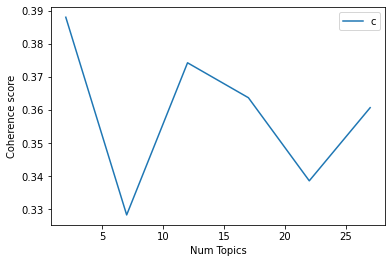

In [151]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [152]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.388
index: 1 | Num Topics = 7  has Coherence Value of 0.3282
index: 2 | Num Topics = 12  has Coherence Value of 0.3742
index: 3 | Num Topics = 17  has Coherence Value of 0.3637
index: 4 | Num Topics = 22  has Coherence Value of 0.3385
index: 5 | Num Topics = 27  has Coherence Value of 0.3606


In [193]:
# Select optimal number of topics
optimal_model_ph_2020_score1N2N3 = model_list_ph_2020_score1N2N3[0]

In [194]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2020_score1N2N3, corpus_ph_2020_score1N2N3, id2word_ph_2020_score1N2N3)

In [195]:
print("pyLDAVis for ph topics for score=1,2,3 in 2020:")
vis_ph_2020_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.136024  0.0       1        1  60.805728
0     -0.136024  0.0       2        1  39.194272, topic_info=       Term        Freq       Total Category  logprob  loglift
69     view  395.000000  395.000000  Default  30.0000  30.0000
95   delete  253.000000  253.000000  Default  29.0000  29.0000
10    video  218.000000  218.000000  Default  28.0000  28.0000
56       ad   54.000000   54.000000  Default  27.0000  27.0000
9    update   42.000000   42.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
59   always   13.230370   25.831721   Topic2  -5.3477   0.2676
16      put   12.403140   20.714888   Topic2  -5.4123   0.4237
8      show   12.498342   26.743217   Topic2  -5.4046   0.1760
36     back   13.823608   59.413729   Topic2  -5.3038  -0.5215
145    time   12.492805   45.709860   Topic2  -5.4051  -0.3605

[127 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
56        1  0.018197       ad
56        2  0.982622       ad
58        1  0.291788  already
58        2  0.729471  already
59        1  0.503257   always
...     ...       ...      ...
11        1  0.325081    watch
11        2  0.675169    watch
50        1  0.773366     work
50        2  0.219313     work
293       1  0.968553      yet

[128 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## By-rating of 2021 (Rating=1,2,3)

In [156]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_ph_2021_score1N2N3 = youtube_ios_ph_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_ph_2021_score1N2N3 = list(sent_to_words(review_ph_2021_score1N2N3))
print(review_words_ph_2021_score1N2N3[:1])

[['place', 'ads', 'before', 'and', 'after', 'playing']]


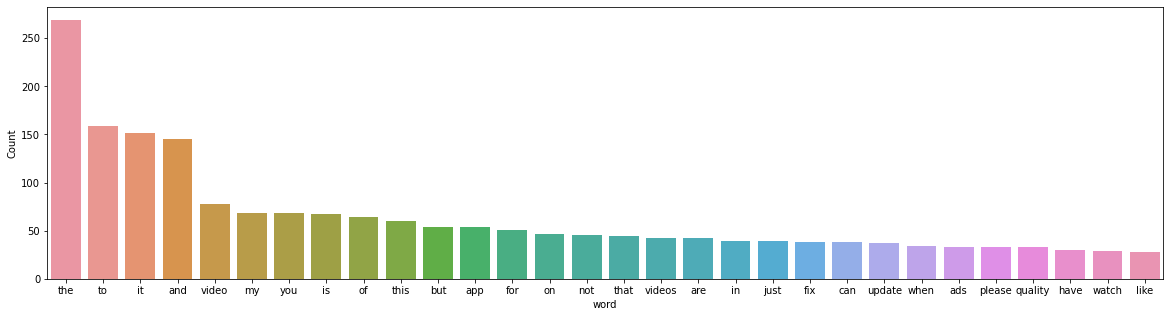

In [157]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2021_score1N2N3))

In [158]:
# Clean text
review_words_ph_ready_2021_score1N2N3 = process_words(review_words_ph_2021_score1N2N3)  # processed Text Data! - move to each section

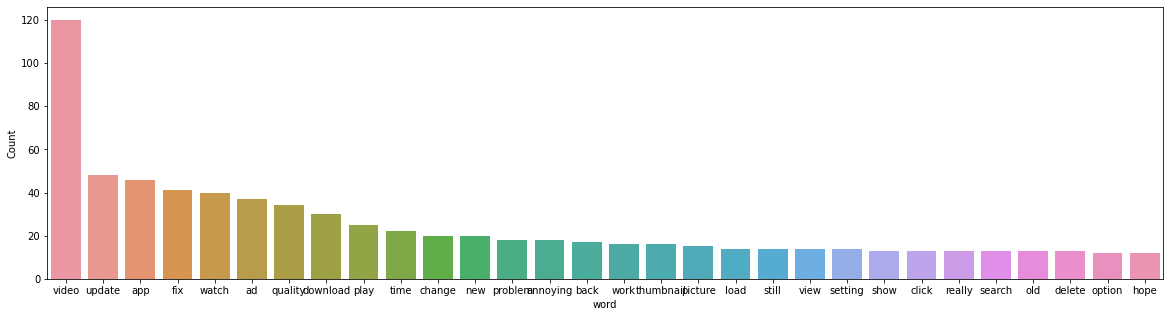

In [159]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2021_score1N2N3))


In [160]:
# Create Dictionary
id2word_ph_2021_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2021_score1N2N3)

2021-10-17 00:51:31,429 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-17 00:51:31,442 [INFO] gensim.corpora.dictionary - built Dictionary(663 unique tokens: ['ad', 'place', 'play', 'crash', 'download']...) from 156 documents (total 2133 corpus positions)
2021-10-17 00:51:31,446 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(663 unique tokens: ['ad', 'place', 'play', 'crash', 'download']...) from 156 documents (total 2133 corpus positions)", 'datetime': '2021-10-17T00:51:31.445963', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [161]:
# Create Corpus: Term Document Frequency
corpus_ph_2021_score1N2N3 = [id2word_ph_2021_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2021_score1N2N3]

In [162]:
# Training LDA model
model_list_ph_2021_score1N2N3, coherence_values_ph_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2021_score1N2N3, corpus=corpus_ph_2021_score1N2N3, 
                                                              texts=review_words_ph_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-17 00:51:31,505 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-17 00:51:31,509 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-17 00:51:31,513 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:51:31,518 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 156 documents, updating model once every 156 documents, evaluating perplexity every 156 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:51:32,419 [INFO] gensim.models.ldamodel - -7.145 per-word bound, 141.5 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:51:32,421 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #156/156
2021-10-17 00:51:32,987 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.060*"video" + 0.020*"watch" + 0.019*"download" + 0.017*"fix" + 0.017*"app" + 0.014*"update" + 0.013*"a

2021-10-17 00:51:38,770 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.021*"update" + 0.018*"quality" + 0.018*"video" + 0.018*"app" + 0.012*"picture" + 0.012*"fix" + 0.011*"view" + 0.011*"setting" + 0.010*"change" + 0.009*"back"
2021-10-17 00:51:38,772 [INFO] gensim.models.ldamodel - topic diff=0.016760, rho=0.301511
2021-10-17 00:51:39,360 [INFO] gensim.models.ldamodel - -6.137 per-word bound, 70.4 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:51:39,361 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #156/156
2021-10-17 00:51:39,616 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.064*"video" + 0.023*"watch" + 0.020*"download" + 0.018*"fix" + 0.018*"ad" + 0.016*"app" + 0.016*"play" + 0.015*"update" + 0.012*"time" + 0.011*"new"
2021-10-17 00:51:39,619 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.021*"update" + 0.018*"quality" + 0.018*"video" + 0.018*"app" + 0.012*"picture" + 0.012*"fix" + 0.011*"view" + 0.011

2021-10-17 00:51:44,195 [INFO] gensim.models.ldamodel - topic diff=0.009855, rho=0.218218
2021-10-17 00:51:44,497 [INFO] gensim.models.ldamodel - -6.122 per-word bound, 69.6 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:51:44,498 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #156/156
2021-10-17 00:51:44,660 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.062*"video" + 0.023*"watch" + 0.020*"ad" + 0.020*"download" + 0.017*"fix" + 0.017*"app" + 0.016*"play" + 0.014*"update" + 0.012*"time" + 0.011*"problem"
2021-10-17 00:51:44,663 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"quality" + 0.022*"update" + 0.020*"video" + 0.017*"app" + 0.012*"fix" + 0.012*"picture" + 0.012*"view" + 0.012*"setting" + 0.012*"change" + 0.011*"back"
2021-10-17 00:51:44,667 [INFO] gensim.models.ldamodel - topic diff=0.010411, rho=0.213201
2021-10-17 00:51:45,024 [INFO] gensim.models.ldamodel - -6.119 per-word bound, 69.5 perplexity es

2021-10-17 00:51:49,300 [INFO] gensim.models.ldamodel - -6.106 per-word bound, 68.9 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:51:49,309 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #156/156
2021-10-17 00:51:49,514 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.061*"video" + 0.023*"watch" + 0.023*"ad" + 0.020*"download" + 0.018*"app" + 0.017*"fix" + 0.016*"play" + 0.014*"update" + 0.012*"time" + 0.011*"annoying"
2021-10-17 00:51:49,527 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"quality" + 0.022*"video" + 0.021*"update" + 0.016*"app" + 0.013*"change" + 0.012*"fix" + 0.012*"picture" + 0.011*"view" + 0.011*"setting" + 0.011*"back"
2021-10-17 00:51:49,535 [INFO] gensim.models.ldamodel - topic diff=0.007154, rho=0.176777
2021-10-17 00:51:49,779 [INFO] gensim.models.ldamodel - -6.105 per-word bound, 68.8 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:51:49,78

2021-10-17 00:51:53,486 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #156/156
2021-10-17 00:51:53,622 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.059*"video" + 0.024*"ad" + 0.023*"watch" + 0.020*"download" + 0.019*"app" + 0.017*"fix" + 0.016*"play" + 0.015*"update" + 0.012*"time" + 0.011*"problem"
2021-10-17 00:51:53,623 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"quality" + 0.024*"video" + 0.020*"update" + 0.014*"app" + 0.014*"change" + 0.012*"fix" + 0.012*"picture" + 0.012*"back" + 0.011*"view" + 0.011*"setting"
2021-10-17 00:51:53,625 [INFO] gensim.models.ldamodel - topic diff=0.004357, rho=0.154303
2021-10-17 00:51:53,862 [INFO] gensim.models.ldamodel - -6.097 per-word bound, 68.5 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:51:53,863 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #156/156
2021-10-17 00:51:54,026 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.059*"video" + 0

2021-10-17 00:51:57,108 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-17 00:52:01,444 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-17 00:52:01,464 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 146 virtual documents
2021-10-17 00:52:01,756 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-17 00:52:01,758 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-17 00:52:01,781 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:52:01,785 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 156 documents, updating model once every 156 documents, evaluating perplexity every 156 documents, iterating 50x with a con

2021-10-17 00:52:04,015 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"video" + 0.030*"picture" + 0.023*"fix" + 0.021*"watch" + 0.017*"premium" + 0.015*"bug" + 0.015*"already" + 0.015*"download" + 0.012*"second" + 0.012*"subscribe"
2021-10-17 00:52:04,016 [INFO] gensim.models.ldamodel - topic diff=0.058843, rho=0.408248
2021-10-17 00:52:04,199 [INFO] gensim.models.ldamodel - -6.383 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:04,201 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #156/156
2021-10-17 00:52:04,328 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"video" + 0.033*"download" + 0.028*"new" + 0.025*"quality" + 0.021*"offline" + 0.020*"watch" + 0.014*"channel" + 0.014*"fix" + 0.013*"play" + 0.011*"high"
2021-10-17 00:52:04,330 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.073*"video" + 0.035*"ad" + 0.021*"fix" + 0.017*"app" + 0.016*"download" + 0.014*"watch" + 0.013*"t

2021-10-17 00:52:06,160 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.073*"video" + 0.036*"ad" + 0.022*"fix" + 0.016*"app" + 0.015*"download" + 0.014*"watch" + 0.013*"time" + 0.011*"speed" + 0.009*"annoying" + 0.009*"really"
2021-10-17 00:52:06,161 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.032*"picture" + 0.031*"video" + 0.021*"fix" + 0.020*"watch" + 0.019*"premium" + 0.016*"bug" + 0.016*"already" + 0.013*"second" + 0.013*"subscribe" + 0.013*"turn"
2021-10-17 00:52:06,164 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.036*"video" + 0.026*"download" + 0.024*"caption" + 0.024*"crash" + 0.021*"error" + 0.018*"app" + 0.018*"always" + 0.018*"loading" + 0.016*"watch" + 0.015*"show"
2021-10-17 00:52:06,166 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"video" + 0.038*"download" + 0.029*"new" + 0.025*"quality" + 0.021*"offline" + 0.019*"watch" + 0.014*"channel" + 0.014*"fix" + 0.012*"play" + 0.011*"high"
2021-10-17 00:52:06,168 [INFO] gensim.models.ldamodel - top

2021-10-17 00:52:07,931 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"video" + 0.040*"download" + 0.029*"new" + 0.027*"quality" + 0.021*"offline" + 0.019*"watch" + 0.014*"channel" + 0.014*"fix" + 0.013*"high" + 0.012*"play"
2021-10-17 00:52:07,932 [INFO] gensim.models.ldamodel - topic diff=0.007291, rho=0.242536
2021-10-17 00:52:08,136 [INFO] gensim.models.ldamodel - -6.351 per-word bound, 81.6 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:08,137 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #156/156
2021-10-17 00:52:08,279 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"update" + 0.018*"hope" + 0.016*"watch" + 0.016*"option" + 0.014*"day" + 0.014*"delete" + 0.014*"yt" + 0.014*"give" + 0.014*"look" + 0.014*"whole"
2021-10-17 00:52:08,289 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"video" + 0.040*"download" + 0.029*"new" + 0.027*"quality" + 0.021*"offline" + 0.019*"watch" + 0.014*"channe

2021-10-17 00:52:10,039 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.058*"video" + 0.027*"ad" + 0.023*"quality" + 0.023*"fix" + 0.023*"app" + 0.017*"update" + 0.016*"time" + 0.013*"change" + 0.013*"setting" + 0.013*"play"
2021-10-17 00:52:10,041 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"picture" + 0.030*"video" + 0.023*"premium" + 0.021*"fix" + 0.019*"watch" + 0.017*"bug" + 0.016*"already" + 0.013*"second" + 0.013*"subscribe" + 0.013*"turn"
2021-10-17 00:52:10,043 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.074*"video" + 0.036*"ad" + 0.020*"fix" + 0.015*"app" + 0.014*"watch" + 0.013*"time" + 0.012*"download" + 0.011*"speed" + 0.009*"annoying" + 0.009*"really"
2021-10-17 00:52:10,046 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"video" + 0.041*"download" + 0.030*"new" + 0.028*"quality" + 0.020*"offline" + 0.018*"watch" + 0.015*"channel" + 0.014*"high" + 0.014*"fix" + 0.012*"play"
2021-10-17 00:52:10,048 [INFO] gensim.models.ldamodel - topic diff=

2021-10-17 00:52:11,881 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.074*"video" + 0.037*"ad" + 0.018*"fix" + 0.015*"app" + 0.014*"watch" + 0.013*"time" + 0.011*"speed" + 0.010*"download" + 0.009*"annoying" + 0.009*"really"
2021-10-17 00:52:11,883 [INFO] gensim.models.ldamodel - topic diff=0.002860, rho=0.188982
2021-10-17 00:52:12,063 [INFO] gensim.models.ldamodel - -6.341 per-word bound, 81.1 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:12,065 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #156/156
2021-10-17 00:52:12,149 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"picture" + 0.029*"video" + 0.023*"premium" + 0.022*"fix" + 0.019*"watch" + 0.017*"bug" + 0.016*"already" + 0.013*"second" + 0.013*"subscribe" + 0.013*"turn"
2021-10-17 00:52:12,151 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.058*"video" + 0.028*"ad" + 0.023*"quality" + 0.023*"fix" + 0.023*"app" + 0.017*"update" + 0.016*"time" + 

2021-10-17 00:52:13,746 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.058*"video" + 0.028*"ad" + 0.023*"quality" + 0.023*"app" + 0.022*"fix" + 0.016*"update" + 0.016*"time" + 0.013*"change" + 0.013*"setting" + 0.013*"thumbnail"
2021-10-17 00:52:13,750 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.075*"video" + 0.037*"ad" + 0.017*"fix" + 0.016*"app" + 0.014*"watch" + 0.013*"time" + 0.011*"speed" + 0.009*"annoying" + 0.009*"really" + 0.009*"problem"
2021-10-17 00:52:13,753 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"picture" + 0.029*"video" + 0.023*"premium" + 0.021*"fix" + 0.019*"watch" + 0.017*"bug" + 0.016*"already" + 0.013*"second" + 0.013*"subscribe" + 0.013*"turn"
2021-10-17 00:52:13,756 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.022*"update" + 0.018*"hope" + 0.018*"look" + 0.017*"watch" + 0.017*"option" + 0.015*"day" + 0.015*"delete" + 0.015*"yt" + 0.015*"whole" + 0.015*"view"
2021-10-17 00:52:13,758 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-17 00:52:15,515 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"update" + 0.029*"video" + 0.029*"app" + 0.021*"old" + 0.020*"still" + 0.017*"quality" + 0.017*"search" + 0.015*"setting" + 0.015*"version" + 0.015*"io"
2021-10-17 00:52:15,516 [INFO] gensim.models.ldamodel - topic diff=0.001265, rho=0.160128
2021-10-17 00:52:15,697 [INFO] gensim.models.ldamodel - -6.337 per-word bound, 80.9 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:15,698 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #156/156
2021-10-17 00:52:15,880 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.074*"video" + 0.037*"ad" + 0.017*"fix" + 0.016*"app" + 0.014*"watch" + 0.013*"time" + 0.011*"speed" + 0.010*"annoying" + 0.010*"really" + 0.010*"problem"
2021-10-17 00:52:15,882 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.051*"download" + 0.044*"video" + 0.029*"new" + 0.028*"quality" + 0.019*"offline" + 0.017*"watch" + 0.014*"chann

2021-10-17 00:52:17,728 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"picture" + 0.029*"video" + 0.023*"premium" + 0.021*"fix" + 0.019*"watch" + 0.017*"bug" + 0.016*"already" + 0.013*"second" + 0.013*"subscribe" + 0.013*"turn"
2021-10-17 00:52:17,731 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.061*"update" + 0.029*"video" + 0.029*"app" + 0.021*"old" + 0.019*"still" + 0.017*"quality" + 0.017*"search" + 0.015*"setting" + 0.015*"version" + 0.015*"io"
2021-10-17 00:52:17,735 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.022*"update" + 0.018*"hope" + 0.018*"look" + 0.017*"option" + 0.017*"watch" + 0.015*"day" + 0.015*"delete" + 0.015*"yt" + 0.015*"whole" + 0.015*"view"
2021-10-17 00:52:17,737 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.038*"video" + 0.033*"download" + 0.031*"crash" + 0.028*"caption" + 0.023*"error" + 0.021*"fix" + 0.019*"app" + 0.019*"watch" + 0.017*"always" + 0.017*"loading"
2021-10-17 00:52:17,738 [INFO] gensim.models.ldamodel - topic diff

2021-10-17 00:52:19,369 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.053*"download" + 0.044*"video" + 0.029*"new" + 0.028*"quality" + 0.019*"offline" + 0.017*"watch" + 0.014*"fix" + 0.014*"channel" + 0.014*"high" + 0.011*"play"
2021-10-17 00:52:19,370 [INFO] gensim.models.ldamodel - topic diff=0.000914, rho=0.141421
2021-10-17 00:52:19,551 [INFO] gensim.models.ldamodel - -6.333 per-word bound, 80.6 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:19,559 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #156/156
2021-10-17 00:52:19,678 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.075*"video" + 0.037*"ad" + 0.017*"fix" + 0.015*"app" + 0.014*"watch" + 0.013*"time" + 0.011*"speed" + 0.010*"annoying" + 0.010*"really" + 0.010*"change"
2021-10-17 00:52:19,680 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"picture" + 0.029*"video" + 0.023*"premium" + 0.021*"fix" + 0.019*"watch" + 0.017*"bug" + 0.016*"already" 

2021-10-17 00:52:26,880 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.069*"video" + 0.033*"fix" + 0.026*"problem" + 0.018*"download" + 0.017*"app" + 0.016*"time" + 0.016*"ad" + 0.015*"guy" + 0.013*"like" + 0.012*"load"
2021-10-17 00:52:26,885 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.045*"ad" + 0.041*"update" + 0.025*"video" + 0.016*"old" + 0.016*"useless" + 0.016*"anymore" + 0.014*"app" + 0.013*"back" + 0.012*"ipad" + 0.012*"skipable"
2021-10-17 00:52:26,887 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.034*"new" + 0.029*"video" + 0.027*"quality" + 0.021*"comment" + 0.020*"watch" + 0.018*"channel" + 0.016*"fix" + 0.013*"create" + 0.013*"download" + 0.013*"problem"
2021-10-17 00:52:26,897 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.065*"video" + 0.046*"update" + 0.032*"app" + 0.029*"download" + 0.022*"fix" + 0.021*"watch" + 0.018*"change" + 0.016*"really" + 0.014*"crash" + 0.012*"time"
2021-10-17 00:52:26,901 [INFO] gensim.models.ldamodel - topic diff=0.10

2021-10-17 00:52:28,560 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.068*"video" + 0.035*"fix" + 0.029*"problem" + 0.018*"download" + 0.018*"app" + 0.016*"time" + 0.016*"ad" + 0.016*"guy" + 0.013*"load" + 0.013*"like"
2021-10-17 00:52:28,562 [INFO] gensim.models.ldamodel - topic diff=0.027706, rho=0.316228
2021-10-17 00:52:28,756 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:28,757 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #156/156
2021-10-17 00:52:28,875 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.068*"video" + 0.035*"fix" + 0.030*"problem" + 0.018*"download" + 0.018*"app" + 0.016*"time" + 0.016*"ad" + 0.016*"guy" + 0.013*"load" + 0.013*"like"
2021-10-17 00:52:28,876 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.048*"quality" + 0.031*"setting" + 0.031*"high" + 0.026*"back" + 0.025*"default" + 0.025*"picture" + 0.019*"option" + 0.017*"p

2021-10-17 00:52:30,374 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"video" + 0.029*"fix" + 0.024*"picture" + 0.024*"always" + 0.024*"available" + 0.022*"app" + 0.018*"play" + 0.016*"watch" + 0.013*"everytime" + 0.012*"premium"
2021-10-17 00:52:30,386 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.035*"version" + 0.028*"old" + 0.021*"become" + 0.021*"issue" + 0.021*"still" + 0.021*"io" + 0.016*"app" + 0.014*"device" + 0.014*"last" + 0.014*"extent"
2021-10-17 00:52:30,394 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.075*"ad" + 0.067*"video" + 0.030*"play" + 0.025*"watch" + 0.023*"annoying" + 0.023*"long" + 0.023*"much" + 0.020*"update" + 0.019*"skip" + 0.018*"app"
2021-10-17 00:52:30,398 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"setting" + 0.053*"quality" + 0.018*"change" + 0.018*"guy" + 0.018*"press" + 0.018*"instal" + 0.017*"function" + 0.010*"search" + 0.009*"video" + 0.009*"resolution"
2021-10-17 00:52:30,403 [INFO] gensim.models.ldamodel - to

2021-10-17 00:52:32,049 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"video" + 0.029*"fix" + 0.028*"picture" + 0.024*"always" + 0.024*"available" + 0.023*"app" + 0.018*"play" + 0.016*"watch" + 0.013*"everytime" + 0.012*"premium"
2021-10-17 00:52:32,051 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.052*"video" + 0.024*"view" + 0.022*"watch" + 0.021*"download" + 0.021*"quality" + 0.019*"offline" + 0.019*"delete" + 0.016*"caption" + 0.016*"day" + 0.015*"work"
2021-10-17 00:52:32,053 [INFO] gensim.models.ldamodel - topic diff=0.003970, rho=0.218218
2021-10-17 00:52:32,288 [INFO] gensim.models.ldamodel - -6.435 per-word bound, 86.5 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:32,290 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #156/156
2021-10-17 00:52:32,425 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"video" + 0.029*"fix" + 0.028*"picture" + 0.024*"always" + 0.024*"available" + 0.023*"app" 

2021-10-17 00:52:33,987 [INFO] gensim.models.ldamodel - -6.432 per-word bound, 86.3 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:33,988 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #156/156
2021-10-17 00:52:34,134 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"quality" + 0.053*"setting" + 0.018*"change" + 0.018*"guy" + 0.018*"press" + 0.018*"instal" + 0.018*"function" + 0.010*"search" + 0.009*"video" + 0.009*"resolution"
2021-10-17 00:52:34,136 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.068*"video" + 0.036*"fix" + 0.030*"problem" + 0.019*"download" + 0.018*"app" + 0.016*"time" + 0.016*"ad" + 0.016*"guy" + 0.014*"load" + 0.012*"like"
2021-10-17 00:52:34,137 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.033*"bug" + 0.025*"picture" + 0.020*"already" + 0.018*"fix" + 0.015*"view" + 0.015*"give" + 0.015*"subscribe" + 0.015*"family" + 0.015*"community" + 0.013*"video"
2021-10-17 00:52:34,139 [INFO] 

2021-10-17 00:52:35,691 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.050*"quality" + 0.032*"setting" + 0.032*"high" + 0.026*"back" + 0.025*"default" + 0.025*"picture" + 0.019*"option" + 0.018*"premium" + 0.016*"bring" + 0.016*"video"
2021-10-17 00:52:35,694 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.058*"video" + 0.053*"load" + 0.049*"search" + 0.044*"app" + 0.036*"update" + 0.028*"thumbnail" + 0.020*"click" + 0.020*"play" + 0.018*"problem" + 0.017*"work"
2021-10-17 00:52:35,698 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"video" + 0.038*"picture" + 0.029*"fix" + 0.023*"always" + 0.023*"available" + 0.023*"app" + 0.018*"play" + 0.016*"watch" + 0.013*"everytime" + 0.012*"premium"
2021-10-17 00:52:35,700 [INFO] gensim.models.ldamodel - topic diff=0.001235, rho=0.176777
2021-10-17 00:52:35,877 [INFO] gensim.models.ldamodel - -6.430 per-word bound, 86.2 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:35,879 [INFO]

2021-10-17 00:52:37,228 [INFO] gensim.models.ldamodel - topic diff=0.000723, rho=0.164399
2021-10-17 00:52:37,457 [INFO] gensim.models.ldamodel - -6.429 per-word bound, 86.2 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:37,471 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #156/156
2021-10-17 00:52:37,538 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.074*"ad" + 0.067*"video" + 0.030*"play" + 0.025*"watch" + 0.023*"annoying" + 0.023*"long" + 0.023*"much" + 0.020*"update" + 0.019*"skip" + 0.018*"app"
2021-10-17 00:52:37,540 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.035*"new" + 0.034*"video" + 0.032*"quality" + 0.026*"comment" + 0.019*"watch" + 0.019*"channel" + 0.015*"fix" + 0.014*"create" + 0.014*"download" + 0.014*"account"
2021-10-17 00:52:37,541 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.035*"version" + 0.028*"old" + 0.021*"issue" + 0.021*"become" + 0.021*"still" + 0.021*"io" + 0.016*"app" + 

2021-10-17 00:52:39,210 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.035*"version" + 0.028*"old" + 0.021*"issue" + 0.021*"become" + 0.021*"still" + 0.021*"io" + 0.016*"app" + 0.014*"device" + 0.014*"last" + 0.014*"show"
2021-10-17 00:52:39,226 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.065*"video" + 0.044*"update" + 0.036*"app" + 0.032*"download" + 0.026*"fix" + 0.022*"watch" + 0.017*"really" + 0.017*"change" + 0.015*"crash" + 0.013*"whenever"
2021-10-17 00:52:39,232 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.068*"video" + 0.036*"fix" + 0.030*"problem" + 0.019*"download" + 0.018*"app" + 0.016*"time" + 0.016*"ad" + 0.016*"guy" + 0.014*"load" + 0.013*"like"
2021-10-17 00:52:39,236 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.035*"bug" + 0.020*"picture" + 0.020*"already" + 0.018*"fix" + 0.015*"give" + 0.015*"view" + 0.015*"subscribe" + 0.015*"family" + 0.015*"community" + 0.012*"watch"
2021-10-17 00:52:39,237 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-17 00:52:40,770 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.052*"video" + 0.024*"view" + 0.022*"watch" + 0.021*"download" + 0.021*"quality" + 0.019*"delete" + 0.019*"offline" + 0.016*"caption" + 0.016*"day" + 0.015*"work"
2021-10-17 00:52:40,771 [INFO] gensim.models.ldamodel - topic diff=0.000228, rho=0.144338
2021-10-17 00:52:40,996 [INFO] gensim.models.ldamodel - -6.429 per-word bound, 86.1 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:40,997 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #156/156
2021-10-17 00:52:41,128 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.052*"video" + 0.024*"view" + 0.022*"watch" + 0.021*"download" + 0.021*"quality" + 0.019*"delete" + 0.019*"offline" + 0.016*"caption" + 0.016*"day" + 0.015*"work"
2021-10-17 00:52:41,129 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.068*"video" + 0.036*"fix" + 0.030*"problem" + 0.019*"download" + 0.018*"app" + 0.016*"time" + 0.

2021-10-17 00:52:49,137 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.051*"video" + 0.037*"change" + 0.037*"quality" + 0.032*"update" + 0.023*"new" + 0.020*"back" + 0.017*"fix" + 0.015*"really" + 0.013*"bug" + 0.012*"thing"
2021-10-17 00:52:49,139 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.038*"version" + 0.032*"old" + 0.029*"last" + 0.022*"device" + 0.022*"still" + 0.022*"io" + 0.018*"app" + 0.017*"late" + 0.015*"already" + 0.013*"extent"
2021-10-17 00:52:49,140 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.046*"view" + 0.037*"quality" + 0.035*"video" + 0.026*"work" + 0.019*"stream" + 0.018*"offline" + 0.017*"play" + 0.017*"fix" + 0.016*"delete" + 0.016*"keep"
2021-10-17 00:52:49,141 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.020*"watch" + 0.018*"video" + 0.016*"bug" + 0.016*"pause" + 0.016*"quality" + 0.015*"high" + 0.015*"old" + 0.015*"whyyyyy" + 0.015*"news" + 0.015*"story"
2021-10-17 00:52:49,142 [INFO] gensim.models.ldamodel - topic diff=0.178468,

2021-10-17 00:52:50,744 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.023*"app" + 0.023*"iphone" + 0.023*"speed" + 0.023*"mini" + 0.023*"playback" + 0.023*"change" + 0.023*"fix" + 0.002*"guy" + 0.002*"view" + 0.001*"video"
2021-10-17 00:52:50,746 [INFO] gensim.models.ldamodel - topic diff=0.043424, rho=0.353553
2021-10-17 00:52:50,915 [INFO] gensim.models.ldamodel - -6.539 per-word bound, 93.0 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:50,918 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #156/156
2021-10-17 00:52:51,025 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.057*"video" + 0.056*"quality" + 0.043*"change" + 0.029*"new" + 0.023*"update" + 0.021*"back" + 0.019*"fix" + 0.017*"really" + 0.016*"high" + 0.013*"bug"
2021-10-17 00:52:51,028 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.017*"watch" + 0.017*"video" + 0.017*"bug" + 0.017*"pause" + 0.017*"quality" + 0.017*"high" + 0.017*"old" + 0.017*"wh

2021-10-17 00:52:52,662 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.050*"search" + 0.042*"setting" + 0.025*"quality" + 0.025*"video" + 0.025*"ipad" + 0.017*"press" + 0.017*"change" + 0.017*"number" + 0.017*"guy" + 0.017*"work"
2021-10-17 00:52:52,664 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.029*"day" + 0.025*"exos" + 0.025*"attention" + 0.025*"fight" + 0.025*"feeling" + 0.025*"call" + 0.025*"explanation" + 0.025*"management" + 0.025*"exo" + 0.025*"update"
2021-10-17 00:52:52,666 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.059*"view" + 0.036*"quality" + 0.034*"video" + 0.028*"work" + 0.028*"delete" + 0.023*"keep" + 0.018*"stream" + 0.016*"still" + 0.014*"time" + 0.013*"app"
2021-10-17 00:52:52,667 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.100*"video" + 0.047*"ad" + 0.042*"download" + 0.031*"watch" + 0.023*"fix" + 0.022*"play" + 0.016*"time" + 0.016*"crash" + 0.016*"caption" + 0.012*"annoying"
2021-10-17 00:52:52,669 [INFO] gensim.models.ldamodel - 

2021-10-17 00:52:54,250 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.017*"watch" + 0.017*"bug" + 0.017*"pause" + 0.017*"old" + 0.017*"story" + 0.017*"content" + 0.017*"usually" + 0.017*"news" + 0.017*"show" + 0.017*"new"
2021-10-17 00:52:54,251 [INFO] gensim.models.ldamodel - topic diff=0.004881, rho=0.229416
2021-10-17 00:52:54,472 [INFO] gensim.models.ldamodel - -6.512 per-word bound, 91.3 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:54,474 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #156/156
2021-10-17 00:52:54,544 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.026*"day" + 0.025*"hope" + 0.025*"whole" + 0.025*"watch" + 0.025*"look" + 0.025*"exos" + 0.025*"fight" + 0.025*"call" + 0.025*"fair" + 0.025*"explanation"
2021-10-17 00:52:54,548 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.041*"video" + 0.041*"app" + 0.027*"stable" + 0.014*"version" + 0.014*"io" + 0.014*"browse" + 0.014*"comment" + 0.0

2021-10-17 00:52:56,020 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.030*"subscribe" + 0.030*"fix" + 0.023*"video" + 0.023*"family" + 0.023*"bug" + 0.023*"show" + 0.016*"premium" + 0.015*"load" + 0.015*"resolution" + 0.015*"already"
2021-10-17 00:52:56,022 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.048*"version" + 0.036*"old" + 0.036*"last" + 0.024*"io" + 0.024*"still" + 0.024*"device" + 0.024*"late" + 0.014*"already" + 0.014*"app" + 0.012*"extent"
2021-10-17 00:52:56,023 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.099*"video" + 0.047*"ad" + 0.042*"download" + 0.031*"watch" + 0.023*"fix" + 0.022*"play" + 0.016*"time" + 0.016*"crash" + 0.016*"caption" + 0.014*"problem"
2021-10-17 00:52:56,024 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.043*"picture" + 0.039*"video" + 0.036*"app" + 0.027*"thumbnail" + 0.024*"fix" + 0.022*"skip" + 0.011*"ad" + 0.011*"annoying" + 0.011*"show" + 0.011*"instal"
2021-10-17 00:52:56,025 [INFO] gensim.models.ldamodel - topic d

2021-10-17 00:52:57,621 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.029*"problem" + 0.029*"thumbnail" + 0.015*"watch" + 0.015*"update" + 0.015*"find" + 0.015*"video" + 0.015*"time" + 0.015*"last" + 0.015*"recent" + 0.015*"phone"
2021-10-17 00:52:57,623 [INFO] gensim.models.ldamodel - topic diff=0.001789, rho=0.182574
2021-10-17 00:52:57,763 [INFO] gensim.models.ldamodel - -6.502 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:52:57,767 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #156/156
2021-10-17 00:52:57,916 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.043*"picture" + 0.039*"video" + 0.036*"app" + 0.027*"thumbnail" + 0.024*"fix" + 0.022*"skip" + 0.011*"ad" + 0.011*"annoying" + 0.011*"show" + 0.011*"instal"
2021-10-17 00:52:57,922 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.046*"video" + 0.038*"watch" + 0.032*"channel" + 0.029*"new" + 0.024*"create" + 0.016*"dummy" + 0.016*"

2021-10-17 00:52:59,367 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.025*"day" + 0.025*"exos" + 0.025*"attention" + 0.025*"fight" + 0.025*"call" + 0.025*"fair" + 0.025*"explanation" + 0.025*"management" + 0.025*"exo" + 0.025*"give"
2021-10-17 00:52:59,373 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.069*"quality" + 0.066*"video" + 0.042*"change" + 0.030*"high" + 0.027*"new" + 0.025*"fix" + 0.022*"back" + 0.020*"update" + 0.016*"really" + 0.013*"thing"
2021-10-17 00:52:59,375 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.034*"update" + 0.034*"app" + 0.029*"video" + 0.023*"quality" + 0.023*"fix" + 0.023*"search" + 0.017*"preference" + 0.017*"setting" + 0.017*"problem" + 0.017*"load"
2021-10-17 00:52:59,376 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.059*"view" + 0.036*"quality" + 0.033*"video" + 0.028*"delete" + 0.028*"work" + 0.023*"keep" + 0.018*"stream" + 0.016*"still" + 0.014*"time" + 0.013*"app"
2021-10-17 00:52:59,379 [INFO] gensim.models.ldamodel - top

2021-10-17 00:53:00,894 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.034*"issue" + 0.034*"become" + 0.023*"obvious" + 0.023*"lately" + 0.023*"racist" + 0.023*"show" + 0.023*"choose" + 0.014*"resolution" + 0.012*"attempt" + 0.012*"order"
2021-10-17 00:53:00,904 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.043*"picture" + 0.039*"video" + 0.036*"app" + 0.027*"thumbnail" + 0.024*"fix" + 0.022*"skip" + 0.011*"annoying" + 0.011*"ad" + 0.011*"show" + 0.011*"tap"
2021-10-17 00:53:00,906 [INFO] gensim.models.ldamodel - topic diff=0.000429, rho=0.156174
2021-10-17 00:53:01,119 [INFO] gensim.models.ldamodel - -6.501 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:01,120 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #156/156
2021-10-17 00:53:01,193 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.099*"video" + 0.047*"ad" + 0.042*"download" + 0.031*"watch" + 0.023*"fix" + 0.022*"play" + 0.016*

2021-10-17 00:53:02,809 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #156/156
2021-10-17 00:53:02,948 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.023*"app" + 0.023*"speed" + 0.023*"iphone" + 0.023*"mini" + 0.023*"change" + 0.023*"fix" + 0.023*"playback" + 0.001*"guy" + 0.001*"view" + 0.001*"video"
2021-10-17 00:53:02,990 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.123*"update" + 0.055*"app" + 0.029*"old" + 0.024*"ipad" + 0.021*"back" + 0.019*"io" + 0.019*"still" + 0.019*"long" + 0.018*"change" + 0.016*"new"
2021-10-17 00:53:02,991 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.029*"problem" + 0.029*"thumbnail" + 0.015*"update" + 0.015*"watch" + 0.015*"time" + 0.015*"video" + 0.015*"last" + 0.015*"find" + 0.015*"phone" + 0.015*"difficult"
2021-10-17 00:53:02,993 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.099*"video" + 0.047*"ad" + 0.042*"download" + 0.031*"watch" + 0.023*"fix" + 0.022*"play" + 0.016*"caption" + 0.016*"crash" + 0.016*"tim

2021-10-17 00:53:11,356 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-17 00:53:11,358 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-17 00:53:11,361 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-17 00:53:11,448 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 156 documents, updating model once every 156 documents, evaluating perplexity every 156 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-17 00:53:11,810 [INFO] gensim.models.ldamodel - -19.200 per-word bound, 602200.5 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:11,812 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #156/156
2021-10-17 00:53:12,147 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.021*"version" + 0.021*"old" + 0.016*"last" + 0.013*"device" + 

2021-10-17 00:53:13,907 [INFO] gensim.models.ldamodel - -6.668 per-word bound, 101.7 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:13,909 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #156/156
2021-10-17 00:53:14,102 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.061*"app" + 0.038*"fix" + 0.033*"update" + 0.030*"video" + 0.022*"ad" + 0.017*"put" + 0.017*"hope" + 0.016*"help" + 0.016*"stream" + 0.016*"still"
2021-10-17 00:53:14,104 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.113*"video" + 0.037*"ad" + 0.037*"watch" + 0.034*"play" + 0.030*"fix" + 0.023*"time" + 0.019*"thumbnail" + 0.018*"crash" + 0.017*"annoying" + 0.016*"download"
2021-10-17 00:53:14,106 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.041*"available" + 0.041*"setting" + 0.041*"ipad" + 0.041*"post" + 0.041*"community" + 0.021*"youtube" + 0.021*"edition" + 0.021*"adjust" + 0.021*"mode" + 0.021*"auto"
2021-10-17 00:53:14,112 [INFO] gensim

2021-10-17 00:53:16,161 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.049*"app" + 0.033*"instal" + 0.033*"io" + 0.017*"update" + 0.017*"watch" + 0.017*"restart" + 0.017*"device" + 0.017*"measure" + 0.017*"week" + 0.017*"resolve"
2021-10-17 00:53:16,164 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.113*"video" + 0.038*"ad" + 0.036*"watch" + 0.035*"play" + 0.031*"fix" + 0.023*"time" + 0.020*"thumbnail" + 0.018*"crash" + 0.018*"annoying" + 0.015*"download"
2021-10-17 00:53:16,166 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.035*"video" + 0.035*"high" + 0.035*"quality" + 0.035*"resolution" + 0.035*"choose" + 0.018*"fix" + 0.018*"option" + 0.018*"stupid" + 0.018*"availabe" + 0.018*"broken"
2021-10-17 00:53:16,168 [INFO] gensim.models.ldamodel - topic diff=0.016994, rho=0.288675
2021-10-17 00:53:16,448 [INFO] gensim.models.ldamodel - -6.632 per-word bound, 99.2 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:16,455 [INFO] 

2021-10-17 00:53:18,165 [INFO] gensim.models.ldamodel - topic diff=0.004485, rho=0.242536
2021-10-17 00:53:18,379 [INFO] gensim.models.ldamodel - -6.629 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:18,380 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #156/156
2021-10-17 00:53:18,472 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.074*"picture" + 0.049*"available" + 0.038*"video" + 0.037*"fix" + 0.037*"app" + 0.025*"premium" + 0.025*"user" + 0.025*"comment" + 0.021*"long" + 0.014*"watch"
2021-10-17 00:53:18,474 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.069*"quality" + 0.028*"bring" + 0.028*"setting" + 0.028*"back" + 0.028*"old" + 0.014*"video" + 0.014*"update" + 0.014*"useless" + 0.014*"work" + 0.014*"bad"
2021-10-17 00:53:18,476 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.026*"watch" + 0.022*"ad" + 0.022*"video" + 0.018*"channel" + 0.018*"new" + 0.018*"exos" + 0.018*"managem

2021-10-17 00:53:20,013 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.039*"update" + 0.027*"ipad" + 0.027*"content" + 0.027*"useless" + 0.014*"anymore" + 0.014*"stop" + 0.014*"old" + 0.014*"buy" + 0.014*"new" + 0.014*"app"
2021-10-17 00:53:20,015 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.035*"video" + 0.035*"quality" + 0.035*"high" + 0.035*"choose" + 0.035*"resolution" + 0.018*"fix" + 0.018*"stupid" + 0.018*"change" + 0.018*"step" + 0.018*"stop"
2021-10-17 00:53:20,017 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.049*"app" + 0.033*"instal" + 0.033*"io" + 0.017*"update" + 0.017*"watch" + 0.017*"restart" + 0.017*"device" + 0.017*"measure" + 0.017*"week" + 0.017*"resolve"
2021-10-17 00:53:20,020 [INFO] gensim.models.ldamodel - topic diff=0.000958, rho=0.208514
2021-10-17 00:53:20,154 [INFO] gensim.models.ldamodel - -6.629 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:20,161 [INFO] gensim.models

2021-10-17 00:53:21,647 [INFO] gensim.models.ldamodel - topic diff=0.000459, rho=0.188982
2021-10-17 00:53:21,816 [INFO] gensim.models.ldamodel - -6.629 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:21,818 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #156/156
2021-10-17 00:53:22,002 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.035*"video" + 0.035*"quality" + 0.035*"high" + 0.035*"choose" + 0.035*"resolution" + 0.018*"stupid" + 0.018*"change" + 0.018*"step" + 0.018*"stop" + 0.018*"fix"
2021-10-17 00:53:22,003 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.045*"ad" + 0.036*"annoying" + 0.028*"video" + 0.027*"always" + 0.027*"thumbnail" + 0.019*"download" + 0.018*"watch" + 0.018*"crash" + 0.018*"number" + 0.018*"fix"
2021-10-17 00:53:22,005 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.041*"subscribe" + 0.031*"already" + 0.031*"ad" + 0.031*"family" + 0.021*"resolution" + 0.021*"p

2021-10-17 00:53:23,558 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.032*"video" + 0.032*"option" + 0.017*"old" + 0.017*"new" + 0.017*"news" + 0.017*"usually" + 0.017*"content" + 0.017*"story" + 0.017*"show" + 0.017*"reason"
2021-10-17 00:53:23,561 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.053*"update" + 0.047*"app" + 0.046*"download" + 0.043*"video" + 0.030*"quality" + 0.024*"setting" + 0.024*"premium" + 0.024*"anymore" + 0.018*"comment" + 0.012*"ad"
2021-10-17 00:53:23,566 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.070*"video" + 0.028*"watch" + 0.027*"update" + 0.027*"download" + 0.023*"fix" + 0.023*"caption" + 0.019*"speed" + 0.019*"error" + 0.016*"really" + 0.016*"everytime"
2021-10-17 00:53:23,569 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.049*"app" + 0.033*"instal" + 0.033*"io" + 0.017*"update" + 0.017*"watch" + 0.017*"resolve" + 0.017*"uninstall" + 0.017*"uninstalling" + 0.017*"function" + 0.017*"bar"
2021-10-17 00:53:23,570 [INFO] gensim.mod

2021-10-17 00:53:25,238 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.041*"subscribe" + 0.031*"already" + 0.031*"ad" + 0.031*"family" + 0.021*"resolution" + 0.021*"premium" + 0.021*"change" + 0.021*"add" + 0.021*"subscription" + 0.021*"whole"
2021-10-17 00:53:25,241 [INFO] gensim.models.ldamodel - topic diff=0.000049, rho=0.160128
2021-10-17 00:53:25,429 [INFO] gensim.models.ldamodel - -6.629 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:25,431 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #156/156
2021-10-17 00:53:25,529 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.054*"video" + 0.034*"guy" + 0.027*"problem" + 0.027*"like" + 0.021*"fix" + 0.020*"play" + 0.020*"delete" + 0.014*"time" + 0.014*"picture" + 0.014*"let"
2021-10-17 00:53:25,531 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.028*"show" + 0.023*"issue" + 0.023*"video" + 0.023*"skip" + 0.017*"become" + 0.017*"view" + 0.0

2021-10-17 00:53:27,142 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.039*"update" + 0.027*"ipad" + 0.027*"content" + 0.027*"useless" + 0.014*"new" + 0.014*"app" + 0.014*"stop" + 0.014*"old" + 0.014*"buy" + 0.014*"anymore"
2021-10-17 00:53:27,143 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.049*"app" + 0.033*"io" + 0.033*"instal" + 0.017*"update" + 0.017*"watch" + 0.017*"device" + 0.017*"uninstall" + 0.017*"uninstalling" + 0.017*"measure" + 0.017*"bar"
2021-10-17 00:53:27,144 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.069*"quality" + 0.028*"bring" + 0.028*"back" + 0.028*"setting" + 0.028*"old" + 0.014*"video" + 0.014*"update" + 0.014*"ask" + 0.014*"high" + 0.014*"bad"
2021-10-17 00:53:27,146 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.037*"resolution" + 0.035*"video" + 0.035*"quality" + 0.035*"high" + 0.035*"choose" + 0.018*"stupid" + 0.018*"change" + 0.018*"step" + 0.018*"stop" + 0.018*"fix"
2021-10-17 00:53:27,148 [INFO] gensim.models.ldamodel - topic #

2021-10-17 00:53:28,781 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.002*"version" + 0.002*"old" + 0.002*"last" + 0.002*"device" + 0.002*"still" + 0.002*"io" + 0.002*"app" + 0.002*"functionality" + 0.002*"smooth" + 0.002*"build"
2021-10-17 00:53:28,783 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.054*"video" + 0.034*"guy" + 0.027*"problem" + 0.027*"like" + 0.021*"fix" + 0.020*"play" + 0.020*"delete" + 0.014*"time" + 0.014*"picture" + 0.014*"dislike"
2021-10-17 00:53:28,784 [INFO] gensim.models.ldamodel - topic diff=0.000070, rho=0.141421
2021-10-17 00:53:28,932 [INFO] gensim.models.ldamodel - -6.629 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:28,933 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #156/156
2021-10-17 00:53:29,134 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.036*"resolution" + 0.035*"video" + 0.035*"high" + 0.035*"quality" + 0.035*"choose" + 0.018*"add" + 0.018

2021-10-17 00:53:38,689 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #156/156
2021-10-17 00:53:38,796 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.053*"view" + 0.036*"delete" + 0.024*"reliable" + 0.024*"fair" + 0.024*"day" + 0.024*"management" + 0.024*"give" + 0.024*"watch" + 0.024*"yt" + 0.024*"hope"
2021-10-17 00:53:38,798 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.055*"quality" + 0.036*"video" + 0.030*"high" + 0.023*"update" + 0.020*"download" + 0.020*"happen" + 0.020*"search" + 0.015*"new" + 0.013*"menu" + 0.013*"late"
2021-10-17 00:53:38,800 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.041*"back" + 0.032*"bring" + 0.028*"video" + 0.027*"ad" + 0.027*"resolution" + 0.027*"setting" + 0.024*"quality" + 0.019*"old" + 0.018*"update" + 0.018*"press"
2021-10-17 00:53:38,803 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.064*"update" + 0.059*"load" + 0.052*"search" + 0.050*"app" + 0.046*"video" + 0.038*"play" + 0.019*"ad" + 0.019*"keep" + 0.01

2021-10-17 00:53:40,349 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.053*"available" + 0.053*"ipad" + 0.053*"post" + 0.053*"community" + 0.027*"edition" + 0.027*"youtube" + 0.027*"troubleshooting" + 0.027*"thumbnail" + 0.027*"premium" + 0.027*"subscribe"
2021-10-17 00:53:40,360 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.060*"problem" + 0.040*"connection" + 0.040*"load" + 0.021*"video" + 0.021*"thumbnail" + 0.021*"new" + 0.021*"old" + 0.021*"issue" + 0.021*"fix" + 0.021*"tablet"
2021-10-17 00:53:40,365 [INFO] gensim.models.ldamodel - topic diff=0.027159, rho=0.316228
2021-10-17 00:53:40,509 [INFO] gensim.models.ldamodel - -6.695 per-word bound, 103.6 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:40,511 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #156/156
2021-10-17 00:53:40,617 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.058*"app" + 0.058*"bug" + 0.039*"lag" + 0.039*"help" + 0.039*"fix" + 0.02

2021-10-17 00:53:42,096 [INFO] gensim.models.ldamodel - -6.688 per-word bound, 103.1 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:42,100 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #156/156
2021-10-17 00:53:42,177 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.046*"video" + 0.046*"ad" + 0.023*"watch" + 0.023*"channel" + 0.023*"skip" + 0.017*"new" + 0.017*"time" + 0.017*"create" + 0.017*"skipable" + 0.017*"kid"
2021-10-17 00:53:42,180 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.053*"post" + 0.053*"ipad" + 0.053*"available" + 0.053*"community" + 0.027*"edition" + 0.027*"youtube" + 0.027*"troubleshooting" + 0.027*"thumbnail" + 0.027*"subscribe" + 0.027*"premium"
2021-10-17 00:53:42,183 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.099*"video" + 0.038*"ad" + 0.033*"watch" + 0.021*"play" + 0.020*"download" + 0.017*"problem" + 0.015*"time" + 0.014*"offline" + 0.014*"caption" + 0.012*"fix"
2021-10-17 0

2021-10-17 00:53:43,778 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.105*"update" + 0.060*"app" + 0.048*"ipad" + 0.041*"old" + 0.031*"still" + 0.031*"version" + 0.031*"io" + 0.025*"video" + 0.020*"long" + 0.020*"offline"
2021-10-17 00:53:43,781 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.065*"video" + 0.054*"app" + 0.044*"fix" + 0.033*"high" + 0.033*"quality" + 0.024*"picture" + 0.022*"thumbnail" + 0.022*"tap" + 0.022*"issue" + 0.011*"update"
2021-10-17 00:53:43,785 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.043*"back" + 0.034*"bring" + 0.028*"video" + 0.026*"setting" + 0.026*"resolution" + 0.026*"ad" + 0.026*"quality" + 0.018*"old" + 0.018*"change" + 0.018*"thing"
2021-10-17 00:53:43,789 [INFO] gensim.models.ldamodel - topic diff=0.001940, rho=0.218218
2021-10-17 00:53:43,950 [INFO] gensim.models.ldamodel - -6.687 per-word bound, 103.0 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:43,954 [INFO] gensim.models.

2021-10-17 00:53:45,314 [INFO] gensim.models.ldamodel - topic diff=0.000764, rho=0.196116
2021-10-17 00:53:45,461 [INFO] gensim.models.ldamodel - -6.686 per-word bound, 103.0 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:45,462 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #156/156
2021-10-17 00:53:45,622 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.051*"video" + 0.038*"change" + 0.038*"thing" + 0.026*"back" + 0.026*"thumbnail" + 0.013*"time" + 0.013*"recent" + 0.013*"phone" + 0.013*"last" + 0.013*"difficult"
2021-10-17 00:53:45,623 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.064*"much" + 0.041*"ad" + 0.033*"already" + 0.033*"especially" + 0.033*"one" + 0.033*"unskippable" + 0.001*"search" + 0.001*"wish" + 0.001*"sweet" + 0.001*"family"
2021-10-17 00:53:45,624 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.040*"video" + 0.040*"update" + 0.024*"quality" + 0.024*"change" + 0.016*"watch" + 0.016*"pre

2021-10-17 00:53:47,306 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.099*"video" + 0.038*"ad" + 0.033*"watch" + 0.021*"play" + 0.020*"download" + 0.018*"problem" + 0.016*"time" + 0.014*"caption" + 0.014*"offline" + 0.012*"error"
2021-10-17 00:53:47,309 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.038*"app" + 0.038*"fix" + 0.025*"io" + 0.025*"comment" + 0.025*"open" + 0.025*"work" + 0.013*"happen" + 0.013*"error" + 0.013*"video" + 0.013*"rate"
2021-10-17 00:53:47,312 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.051*"video" + 0.038*"change" + 0.038*"thing" + 0.026*"back" + 0.026*"thumbnail" + 0.013*"place" + 0.013*"locate" + 0.013*"watch" + 0.013*"recent" + 0.013*"time"
2021-10-17 00:53:47,313 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.105*"update" + 0.060*"app" + 0.048*"ipad" + 0.041*"old" + 0.031*"still" + 0.031*"version" + 0.031*"io" + 0.025*"video" + 0.020*"long" + 0.020*"offline"
2021-10-17 00:53:47,316 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-17 00:53:48,890 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.046*"video" + 0.046*"ad" + 0.023*"watch" + 0.023*"channel" + 0.023*"skip" + 0.017*"new" + 0.017*"time" + 0.017*"create" + 0.017*"skipable" + 0.017*"kid"
2021-10-17 00:53:48,891 [INFO] gensim.models.ldamodel - topic diff=0.000211, rho=0.164399
2021-10-17 00:53:49,067 [INFO] gensim.models.ldamodel - -6.684 per-word bound, 102.9 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:49,068 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #156/156
2021-10-17 00:53:49,241 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.040*"video" + 0.040*"update" + 0.024*"quality" + 0.024*"change" + 0.016*"watch" + 0.016*"preference" + 0.016*"design" + 0.016*"really" + 0.016*"fix" + 0.016*"search"
2021-10-17 00:53:49,243 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.093*"load" + 0.076*"update" + 0.047*"search" + 0.047*"video" + 0.046*"app" + 0.035*"play" + 0.032*"ke

2021-10-17 00:53:50,730 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.040*"speed" + 0.032*"video" + 0.032*"problem" + 0.024*"fix" + 0.024*"become" + 0.024*"issue" + 0.024*"show" + 0.016*"lately" + 0.016*"racist" + 0.016*"obvious"
2021-10-17 00:53:50,734 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.056*"quality" + 0.048*"video" + 0.032*"play" + 0.032*"setting" + 0.024*"view" + 0.024*"give" + 0.024*"option" + 0.016*"stream" + 0.016*"let" + 0.016*"cookie"
2021-10-17 00:53:50,736 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.105*"update" + 0.060*"app" + 0.048*"ipad" + 0.041*"old" + 0.031*"still" + 0.031*"io" + 0.031*"version" + 0.025*"video" + 0.020*"long" + 0.020*"anymore"
2021-10-17 00:53:50,739 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.055*"view" + 0.037*"delete" + 0.025*"fair" + 0.025*"exos" + 0.025*"exo" + 0.025*"fight" + 0.025*"feeling" + 0.025*"forward" + 0.025*"day" + 0.025*"yt"
2021-10-17 00:53:50,742 [INFO] gensim.models.ldamodel - topic #16 (0.03

2021-10-17 00:53:52,396 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.046*"video" + 0.046*"ad" + 0.023*"watch" + 0.023*"channel" + 0.023*"skip" + 0.017*"new" + 0.017*"time" + 0.017*"skipable" + 0.017*"create" + 0.017*"kid"
2021-10-17 00:53:52,397 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.048*"new" + 0.048*"premium" + 0.042*"download" + 0.039*"video" + 0.032*"resolution" + 0.032*"anymore" + 0.019*"quality" + 0.017*"update" + 0.017*"highly" + 0.017*"first"
2021-10-17 00:53:52,416 [INFO] gensim.models.ldamodel - topic diff=0.000096, rho=0.144338
2021-10-17 00:53:52,586 [INFO] gensim.models.ldamodel - -6.684 per-word bound, 102.8 perplexity estimate based on a held-out corpus of 156 documents with 2133 words
2021-10-17 00:53:52,591 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #156/156
2021-10-17 00:53:52,716 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.039*"premium" + 0.039*"picture" + 0.039*"user" + 0.020*"feature" + 0.020*"star" + 0.020*"give" + 

In [163]:
%store model_list_ph_2021_score1N2N3
%store coherence_values_ph_2021_score1N2N3

Stored 'model_list_ph_2021_score1N2N3' (list)
Stored 'coherence_values_ph_2021_score1N2N3' (list)


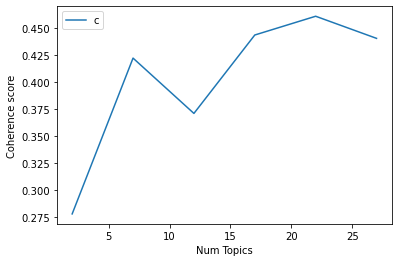

In [164]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [165]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.2783
index: 1 | Num Topics = 7  has Coherence Value of 0.4224
index: 2 | Num Topics = 12  has Coherence Value of 0.3712
index: 3 | Num Topics = 17  has Coherence Value of 0.4437
index: 4 | Num Topics = 22  has Coherence Value of 0.4611
index: 5 | Num Topics = 27  has Coherence Value of 0.4406


In [166]:
# Select optimal number of topics
optimal_model_ph_2021_score1N2N3 = model_list_ph_2021_score1N2N3[4]

In [167]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2021_score1N2N3, corpus_ph_2021_score1N2N3, id2word_ph_2021_score1N2N3)

In [168]:
print("pyLDAVis for ph topics for score=1,2,3 in 2021:")
vis_ph_2021_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.188010  0.002170       1        1  14.070786
9     -0.129051 -0.038637       2        1  10.586348
16    -0.023288  0.170142       3        1   9.139063
18     0.025435  0.103896       4        1   6.893608
14    -0.086294 -0.129654       5        1   6.831940
20    -0.001229 -0.113365       6        1   6.307101
4     -0.111503  0.011026       7        1   5.665754
5     -0.088039 -0.022238       8        1   5.418776
3     -0.059205  0.016323       9        1   4.354357
19     0.060266 -0.146620      10        1   3.908713
17    -0.093749  0.059661      11        1   3.759685
10    -0.033869  0.024154      12        1   3.458902
21     0.092378  0.040076      13        1   3.294309
0      0.003897 -0.015557      14        1   3.017335
6     -0.016835  0.006385      15        1   2.445826
8      0.144319 -0.055500      16        1   2.412067
2      0.092992  0.009880      17        1   2.186659
13     0.059751  0.052690      18        1   1.719949
1      0.087261 -0.079374      19        1   1.709737
15     0.055023  0.052290      20        1   1.486848
7      0.128568  0.023523      21        1   1.034563
11     0.081184  0.028731      22        1   0.297675, topic_info=        Term       Freq      Total Category  logprob  loglift
298  quality  25.000000  25.000000  Default  30.0000  30.0000
32       app  36.000000  36.000000  Default  29.0000  29.0000
22     video  97.000000  97.000000  Default  28.0000  28.0000
48    update  38.000000  38.000000  Default  27.0000  27.0000
5        fix  33.000000  33.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
371      pay   0.009577   3.646137  Topic22  -6.4968  -0.1252
532    model   0.009577   1.430536  Topic22  -6.4968   0.8105
23      work   0.009577  13.547173  Topic22  -6.4968  -1.4377
0         ad   0.009577  30.847544  Topic22  -6.4968  -2.2605
1      place   0.009577   1.967925  Topic22  -6.4968   0.4915

[1070 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
432      12  0.706667     abide
446      16  0.735074   abolish
105       6  0.674167    accept
52        2  0.455257    access
52       15  0.455257    access
...     ...       ...       ...
81        6  0.517489   youtube
336       7  0.667926  youtuber
65        2  0.173073        yt
65        3  0.519218        yt
65        5  0.173073        yt

[1229 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 10, 17, 19, 15, 21, 5, 6, 4, 20, 18, 11, 22, 1, 7, 9, 3, 14, 2, 16, 8, 12])

# Export pyLDAvis as html

In [197]:
# Overall
pyLDAvis.save_html(vis_ph,'youtube_vis_ph.html')

# By-rating 
pyLDAvis.save_html(vis_ph_score1,'youtube_vis_ph_score1.html')
pyLDAvis.save_html(vis_ph_score2,'youtube_vis_ph_score2.html')
pyLDAvis.save_html(vis_ph_score3,'youtube_vis_ph_score3.html')
pyLDAvis.save_html(vis_ph_score4,'youtube_vis_ph_score4.html')
pyLDAvis.save_html(vis_ph_score5,'youtube_vis_ph_score5.html')
pyLDAvis.save_html(vis_ph_score1N2N3,'youtube_vis_ph_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_ph_2021_score1N2N3,'youtube_vis_ph_2021_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2020_score1N2N3,'youtube_vis_ph_2020_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2019_score1N2N3,'youtube_vis_ph_2019_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2018_score1N2N3,'youtube_vis_ph_2018_score1N2N3.html')

